# Beacon, Fitbit, and EMA Analysis
We look at the BIG three and see what things we can see when considering multiple modalities.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Initial Exploration
The start to a more complex analysis, here we just look through the data we have for the combined modalities.

In [68]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import itertools

## Data Import

### Evening IAQ Data
We start by importing the IAQ data from the beacon that has been restricted fully by Fitbit and EMAs

In [14]:
iaq_evening_restricted = pd.read_csv('../data/processed/bpeace2-fitbit-beacon-iaq-evening-restricted.csv',
                                    index_col=0,parse_dates=['Timestamp','start_time','end_time'],infer_datetime_format=True)
iaq_evening_restricted.head()

TVOC   eCO2     Lux   Visible  Infrared  NO2  T_NO2  \
Timestamp                                                                    
2020-07-04 07:10:00  128.04  400.0  6.2832  196613.0       3.0  NaN   27.0   
2020-07-04 07:15:00  124.52  400.0  5.8752  196612.8       3.0  NaN   27.0   
2020-07-04 07:20:00   97.08  400.0  4.2432  196612.0       3.0  NaN   27.0   
2020-07-04 07:25:00  102.24  400.0  4.2432  196612.0       3.0  NaN   27.0   
2020-07-04 07:30:00  106.84  400.0  4.6512  196612.2       3.0  NaN   27.0   

                     RH_NO2       CO  T_CO  ...     PM_C_4    PM_C_10  \
Timestamp                                   ...                         
2020-07-04 07:10:00    52.0 -0.91648   NaN  ...  16.368654  16.581035   
2020-07-04 07:15:00    52.0 -0.81324   NaN  ...  17.515252  17.739183   
2020-07-04 07:20:00    51.0 -0.71760   NaN  ...  17.275952  17.501635   
2020-07-04 07:25:00    51.0 -0.73624   NaN  ...  15.176323  15.371221   
2020-07-04 07:30:00    51.0 -0.74156   NaN  ...  19.510833  19.767971   

                            z  Beacon     Beiwe  Fitbit  REDCap  \
Timestamp                                                         
2020-07-04 07:10:00  0.154553      44  4i7679py      38      37   
2020-07-04 07:15:00  0.159092      44  4i7679py      38      37   
2020-07-04 07:20:00  0.298510      44  4i7679py      38      37   
2020-07-04 07:25:00  0.287511      44  4i7679py      38      37   
2020-07-04 07:30:00  0.263813      44  4i7679py      38      37   

                             start_time            end_time     beiwe  
Timestamp                                                              
2020-07-04 07:10:00 2020-07-04 07:07:00 2020-07-04 16:10:00  4i7679py  
2020-07-04 07:15:00 2020-07-04 07:07:00 2020-07-04 16:10:00  4i7679py  
2020-07-04 07:20:00 2020-07-04 07:07:00 2020-07-04 16:10:00  4i7679py  
2020-07-04 07:25:00 2020-07-04 07:07:00 2020-07-04 16:10:00  4i7679py  
2020-07-04 07:30:00 2020-07-04 07:07:00 2020-07-04 16:10:00  4i7679py  

[5 rows x 31 columns]

### Morning EMAs
We also want the actual EMA data from the sleep surveys

In [8]:
ema = pd.read_csv('../data/processed/bpeace2-morning-survey.csv',
                  index_col=0,parse_dates=True,infer_datetime_format=True)
ema.head()

ID  Content  Stress  Lonely  Sad  Energy  TST  \
2020-07-31 14:25:00  hfttkth7        1       2     1.0    3       0  6.0   
2020-08-20 03:49:00  hfttkth7        1       1     0.0    1       2  7.0   
2020-08-23 15:58:00  hfttkth7        1       1     1.0    2       0  6.0   
2020-07-17 14:52:00  hfttkth7        1       1     0.0    1       2  7.0   
2020-08-12 17:32:00  hfttkth7        1       3     1.0    2       2  6.0   

                      SOL  NAW  Restful  
2020-07-31 14:25:00  10.0  3.0        0  
2020-08-20 03:49:00  20.0  1.0        1  
2020-08-23 15:58:00  25.0  0.0        0  
2020-07-17 14:52:00  20.0  3.0        2  
2020-08-12 17:32:00  20.0  0.0        1

### Fitbit Sleep Stages
We also need the recorded Fitbit data.

In [11]:
fitbit = pd.read_csv('../data/processed/bpeace2-fitbit-sleep-stages.csv',
                     index_col='time',parse_dates=['time','start_date','end_date'],infer_datetime_format=True)
fitbit.head()

Unnamed: 0 start_date   end_date  stage  time_at_stage  \
time                                                                          
2020-05-01 01:32:30           0 2020-05-01 2020-05-01   wake             30   
2020-05-01 01:33:00           1 2020-05-01 2020-05-01  light           2340   
2020-05-01 02:12:00           2 2020-05-01 2020-05-01    rem            720   
2020-05-01 02:24:00           3 2020-05-01 2020-05-01  light           1350   
2020-05-01 02:46:30           4 2020-05-01 2020-05-01   deep           2640   

                        beiwe  value  
time                                  
2020-05-01 01:32:30  15tejjtw      0  
2020-05-01 01:33:00  15tejjtw      1  
2020-05-01 02:12:00  15tejjtw      3  
2020-05-01 02:24:00  15tejjtw      1  
2020-05-01 02:46:30  15tejjtw      2

## Visualization

In [83]:
from matplotlib import cm

### Nightly Time Series
We want to look at a nice time series that shows some pollutant concentrations, the sleep stages, and when the survey was submitted.

Before that, a cursory analysis shows that we have to consider nights when we have both the beacon and EMA response the next day.

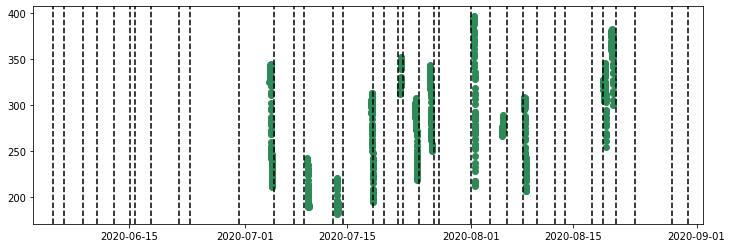

In [54]:
pt = '4i7679py'
iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
ema_pt = ema[ema['ID'] == pt]
fig,ax = plt.subplots(figsize=(12,4))
ax.scatter(iaq_pt.index,iaq_pt['CO2'],color='seagreen')
for i in range(len(ema_pt)):
    ax.axvline(ema_pt.index[i],color='black',linestyle='dashed')

4i7679py


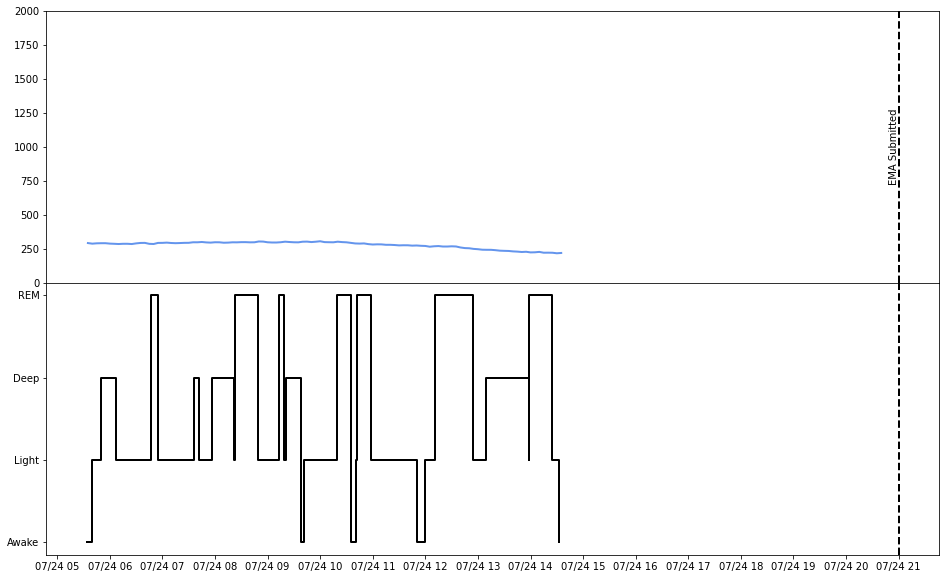

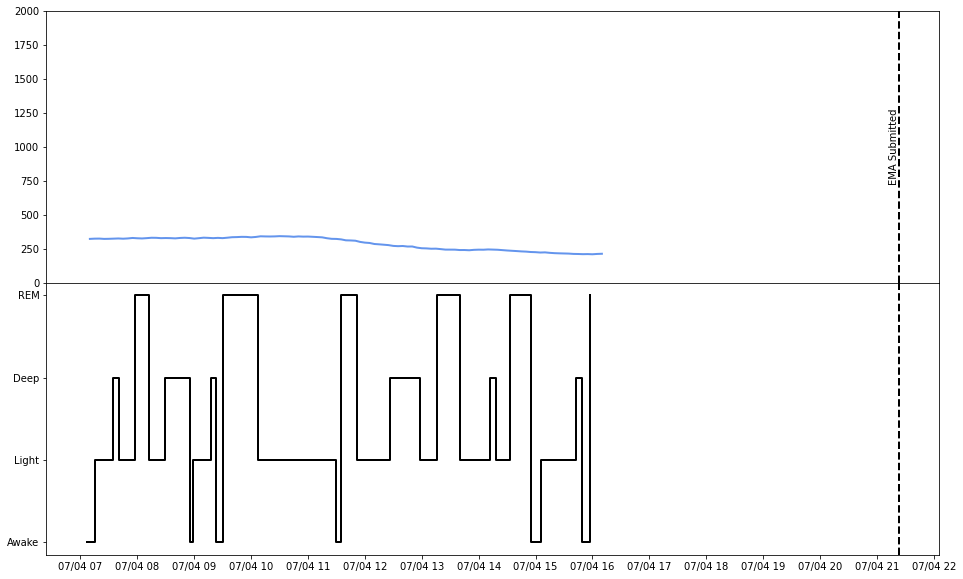

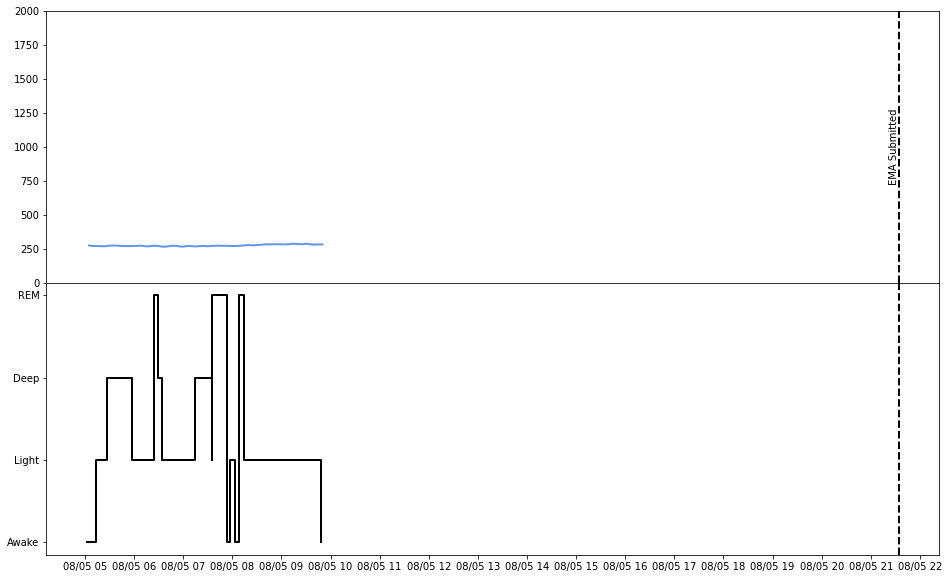

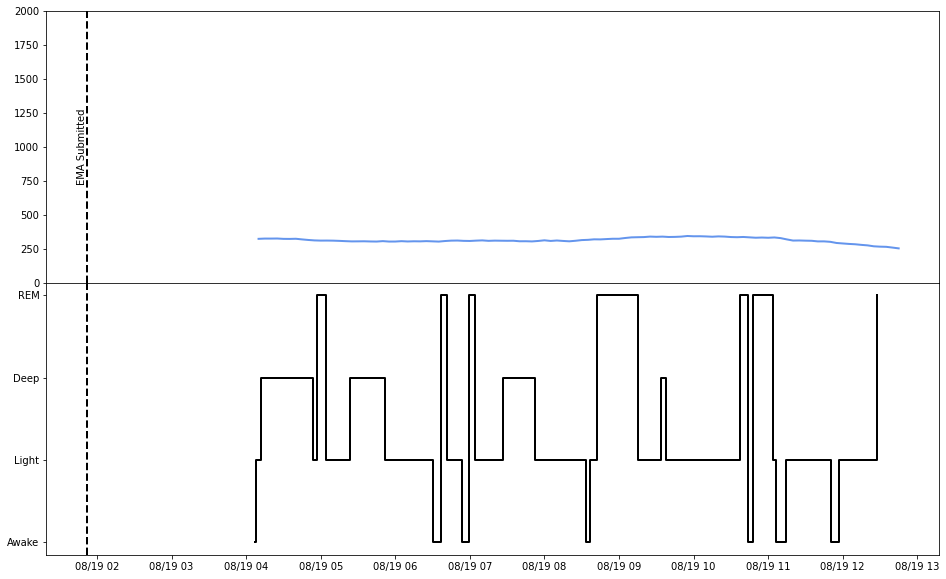

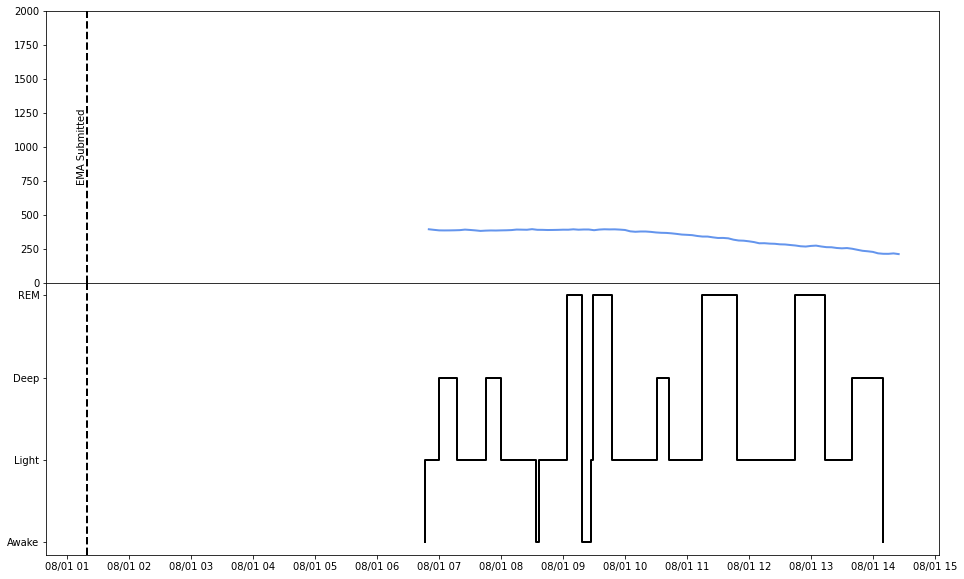

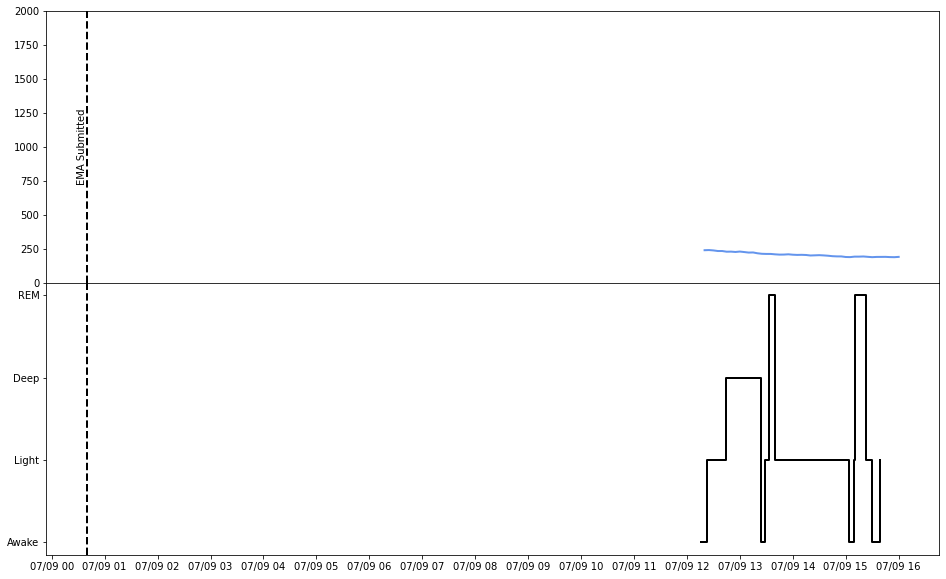

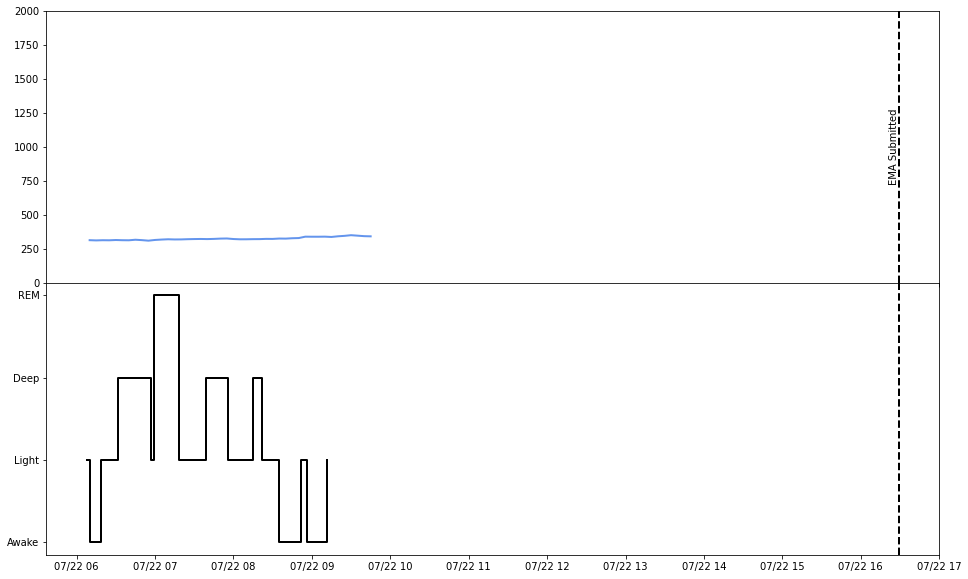

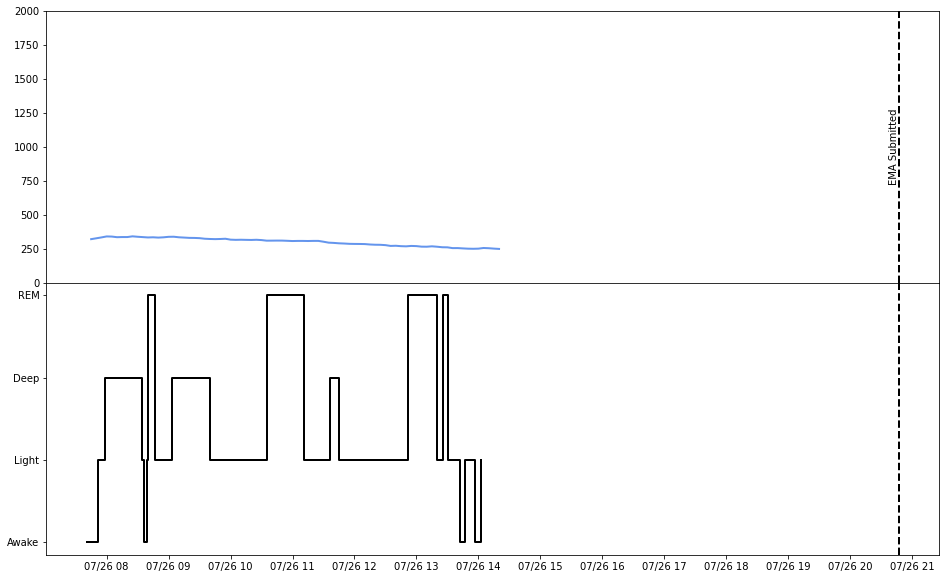

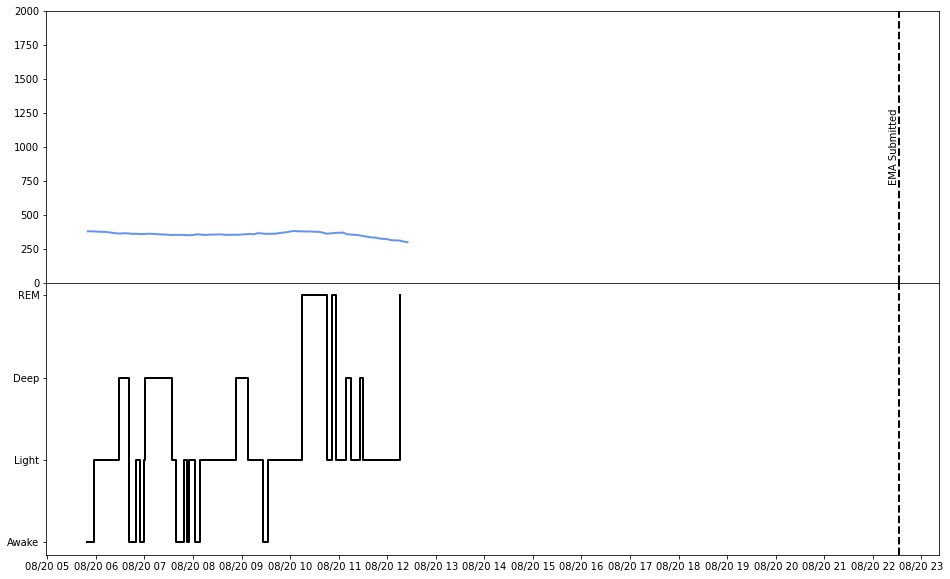

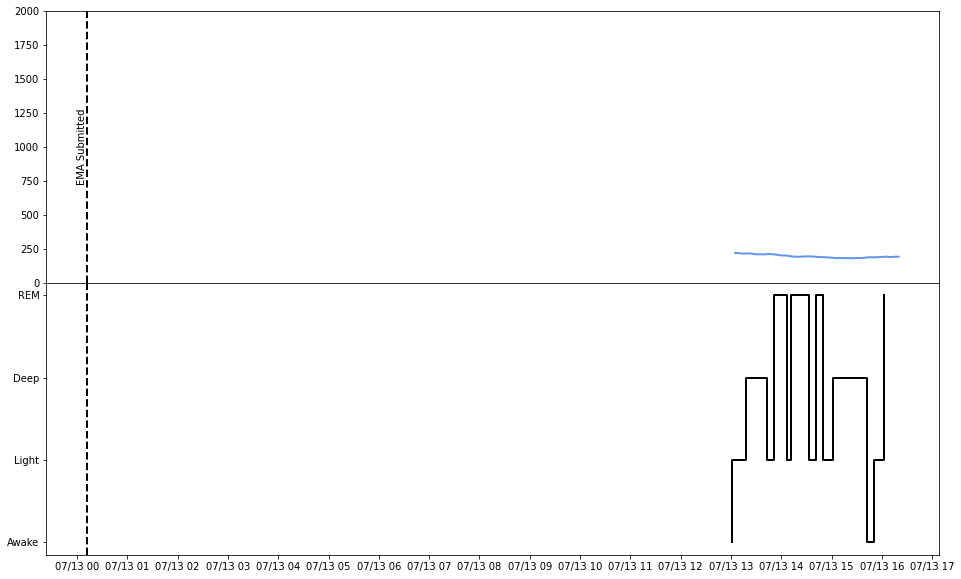

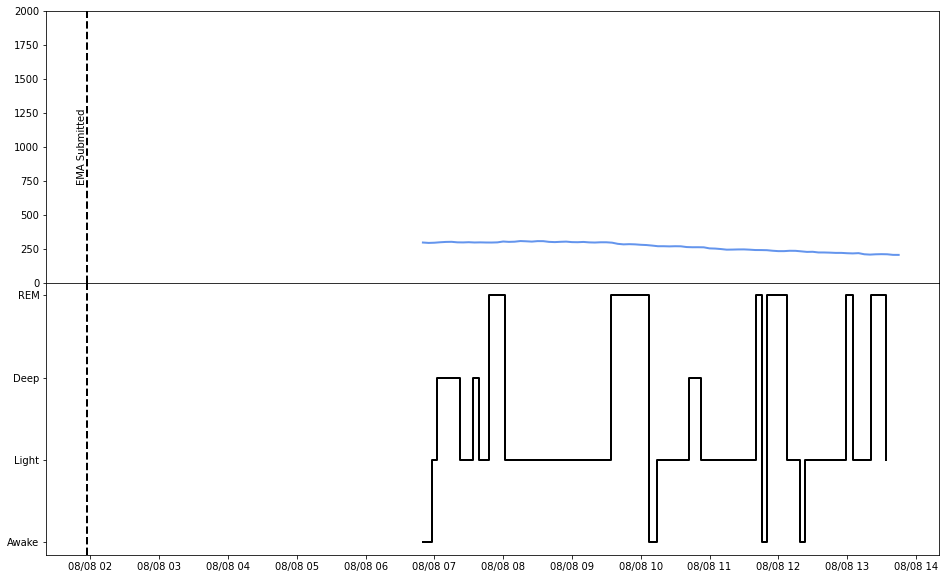

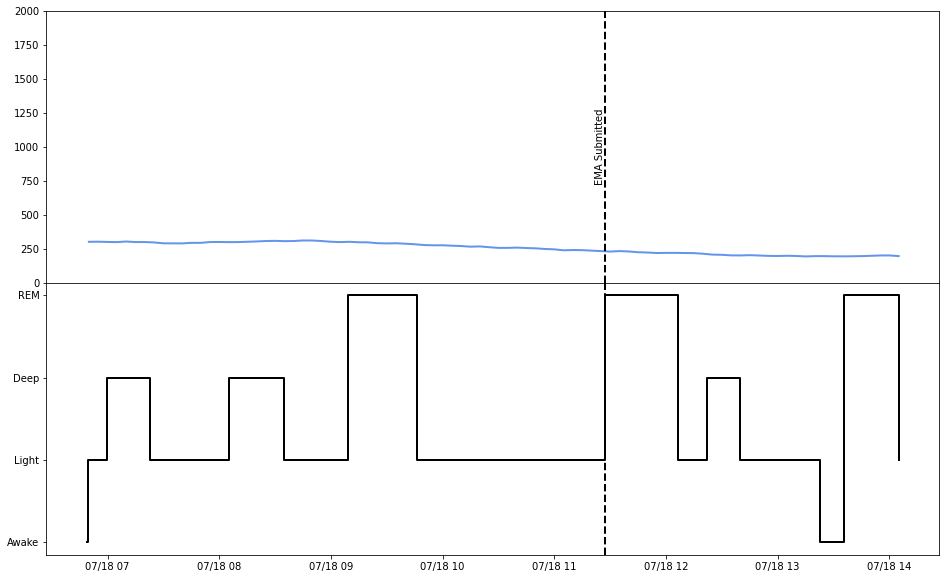

5fvmg226


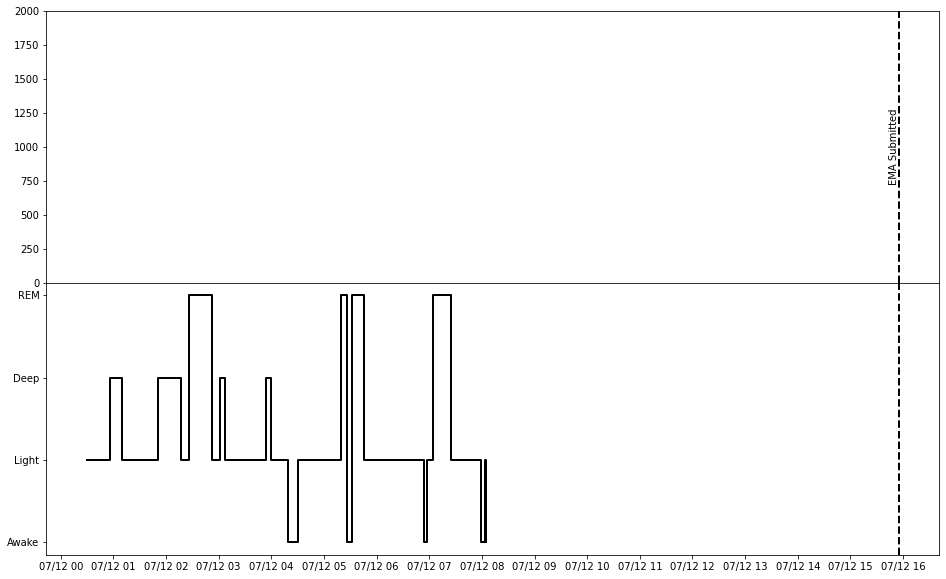

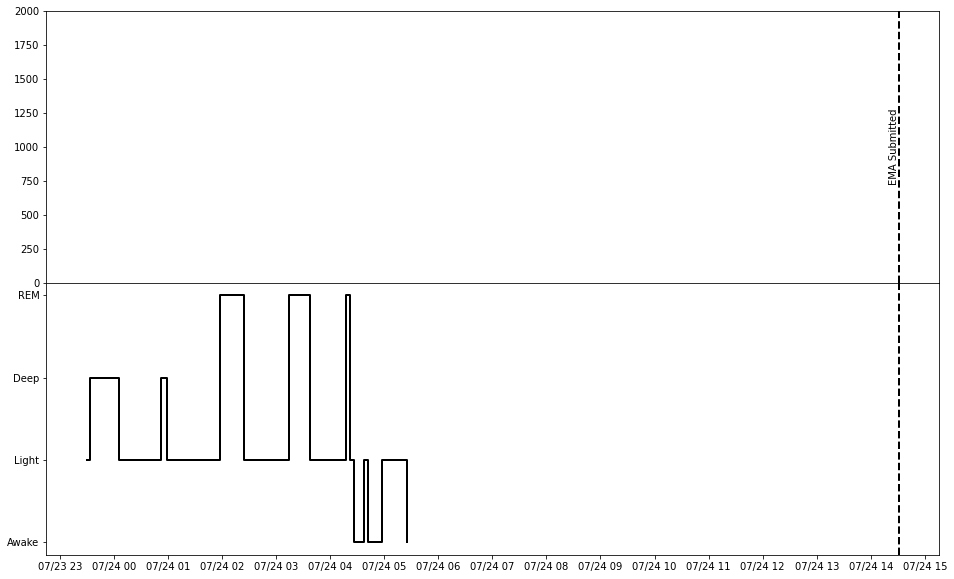

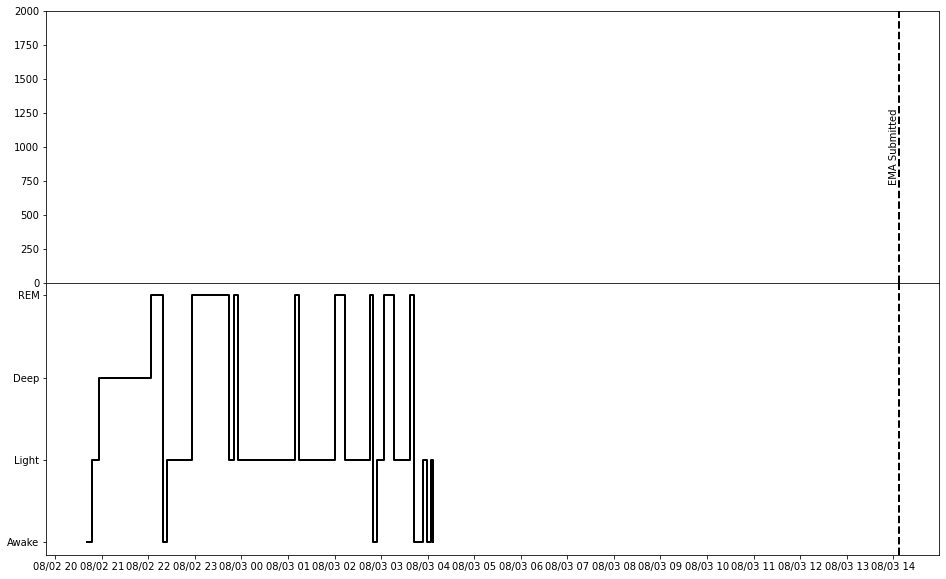

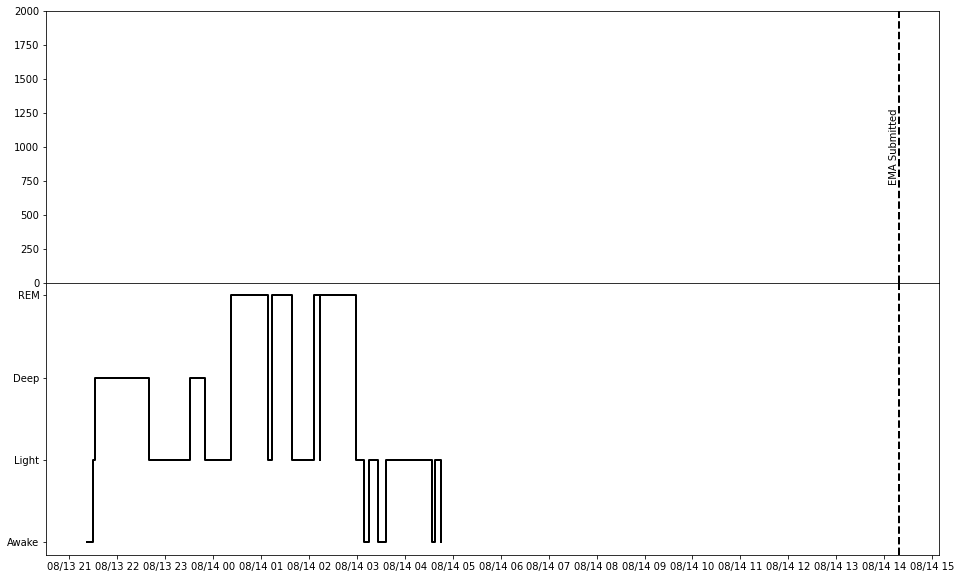

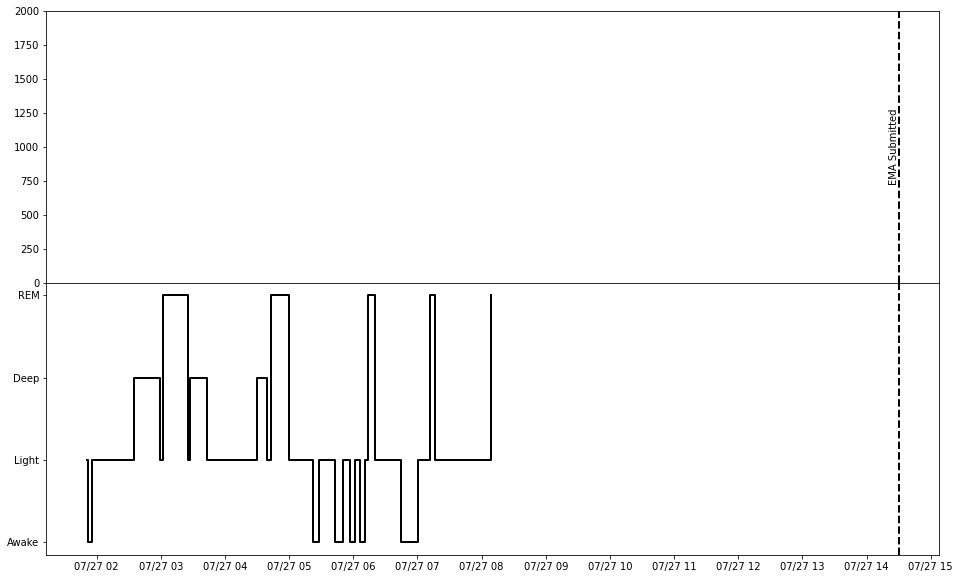

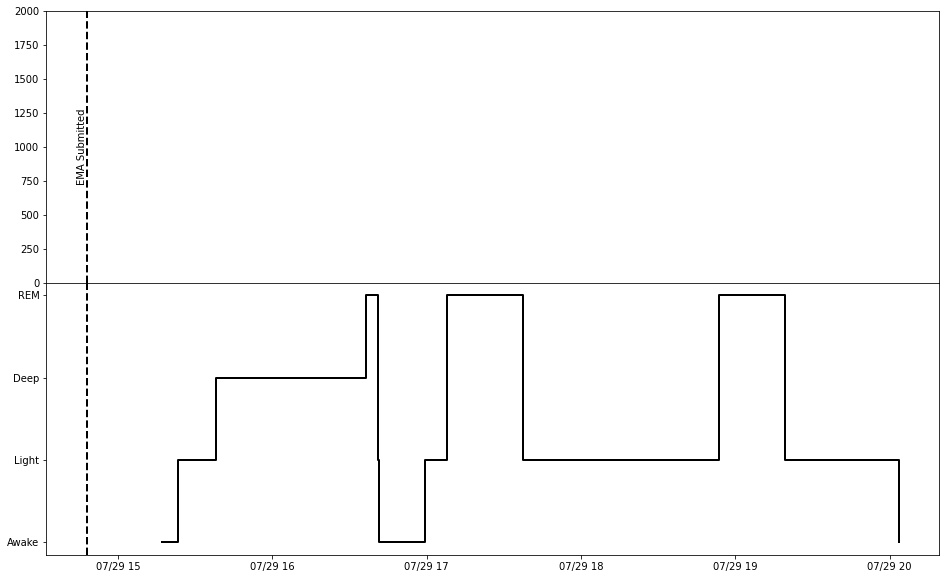

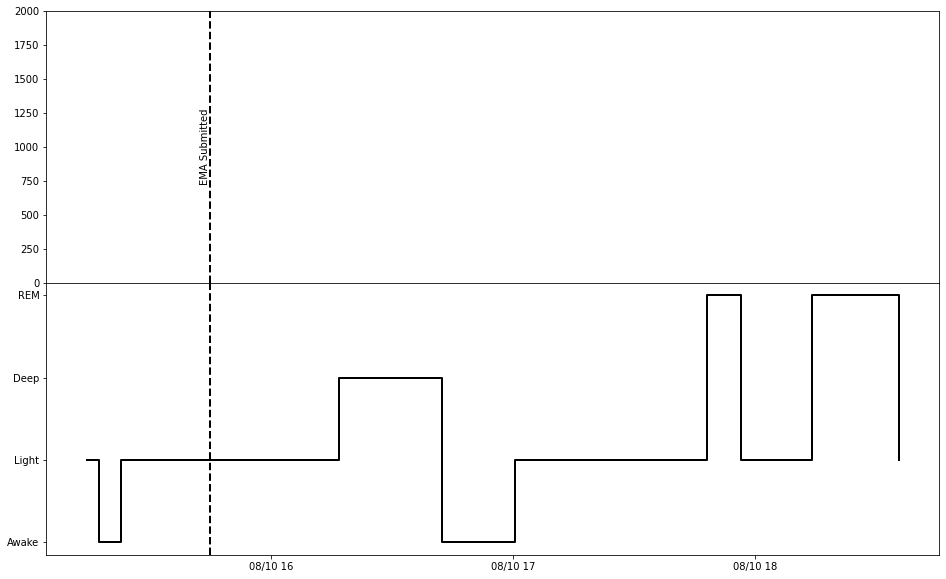

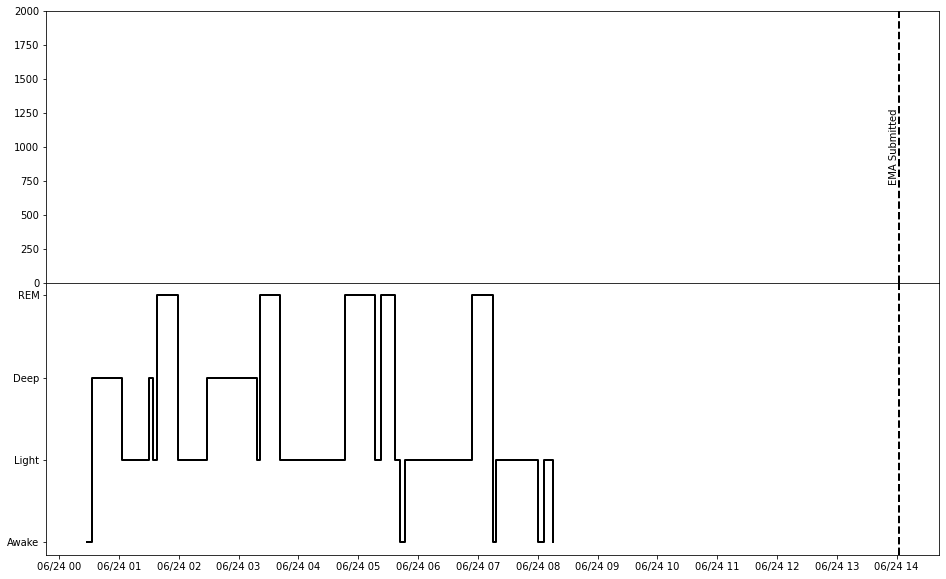

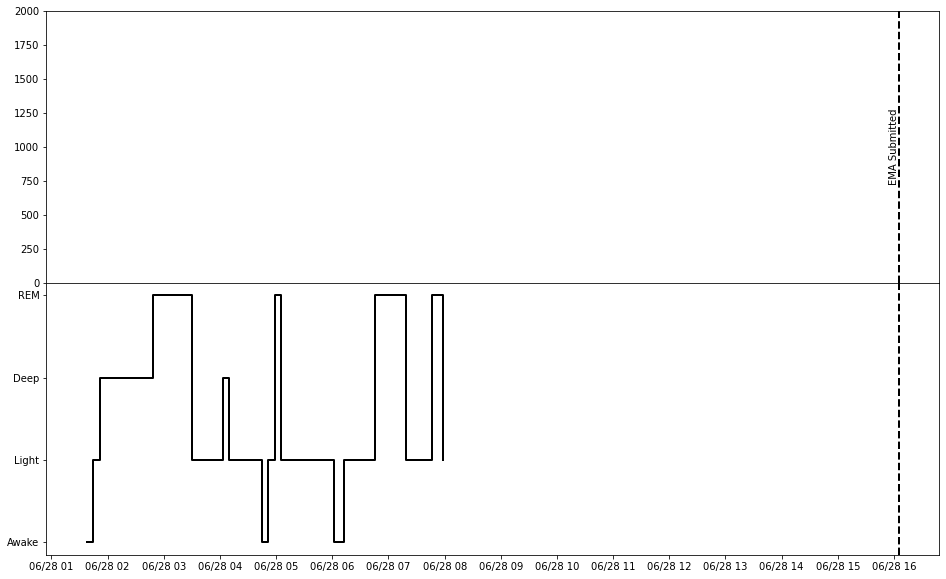

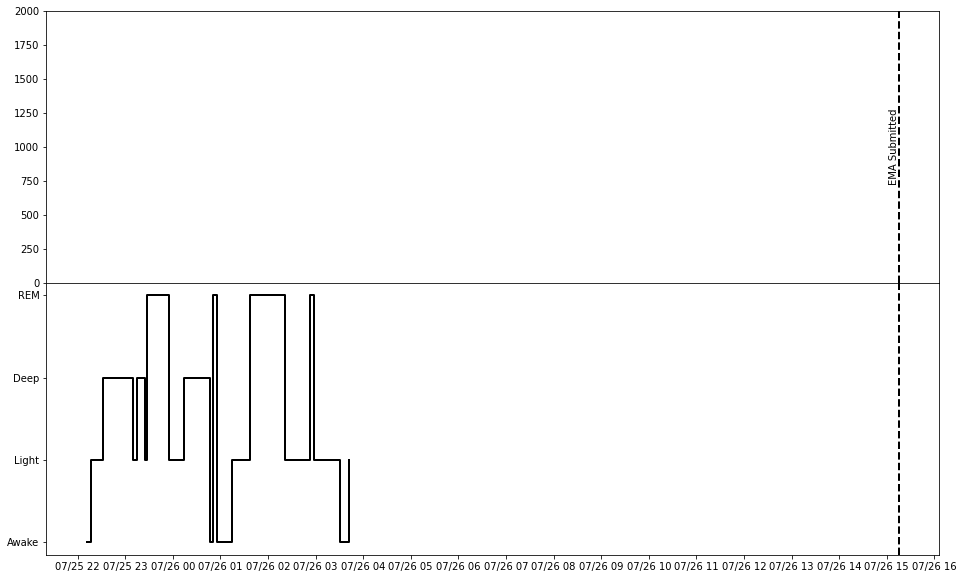

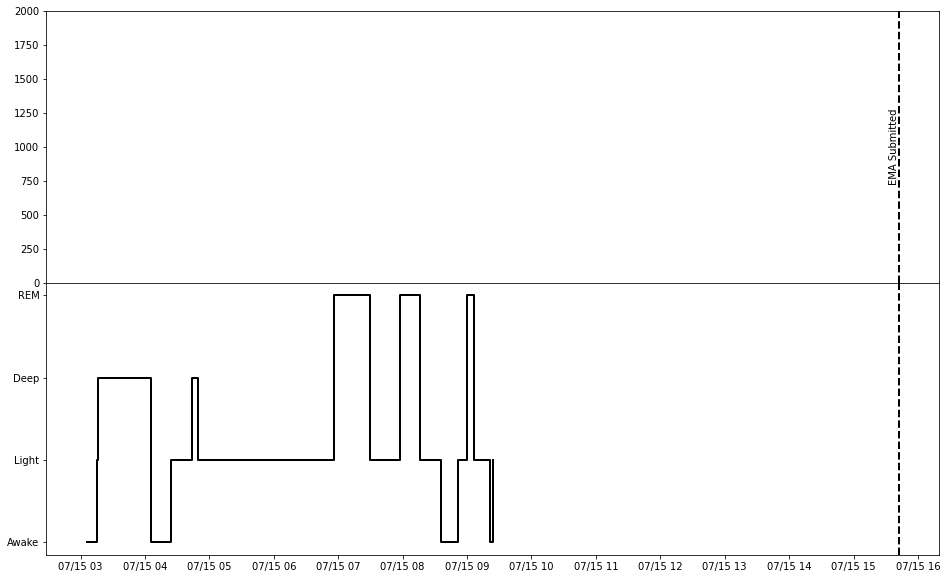

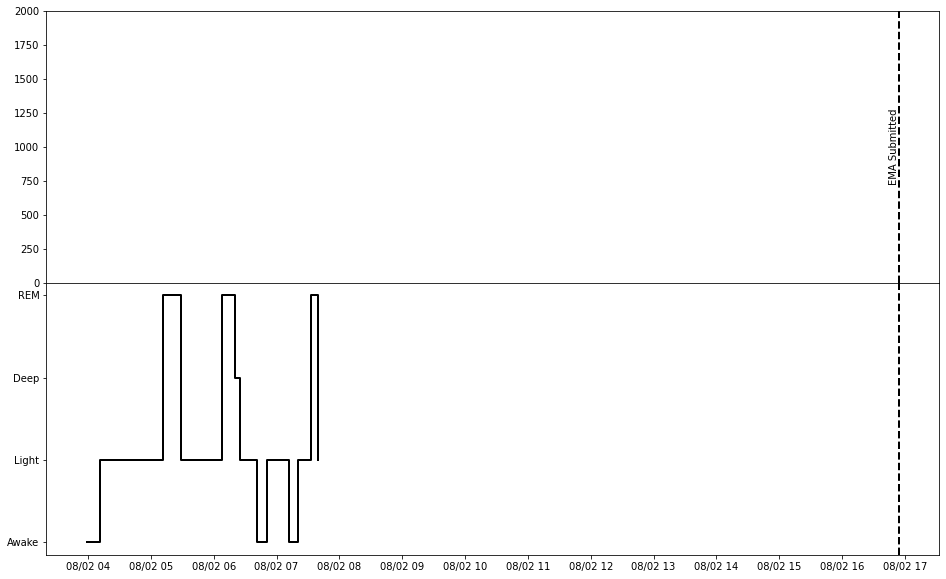

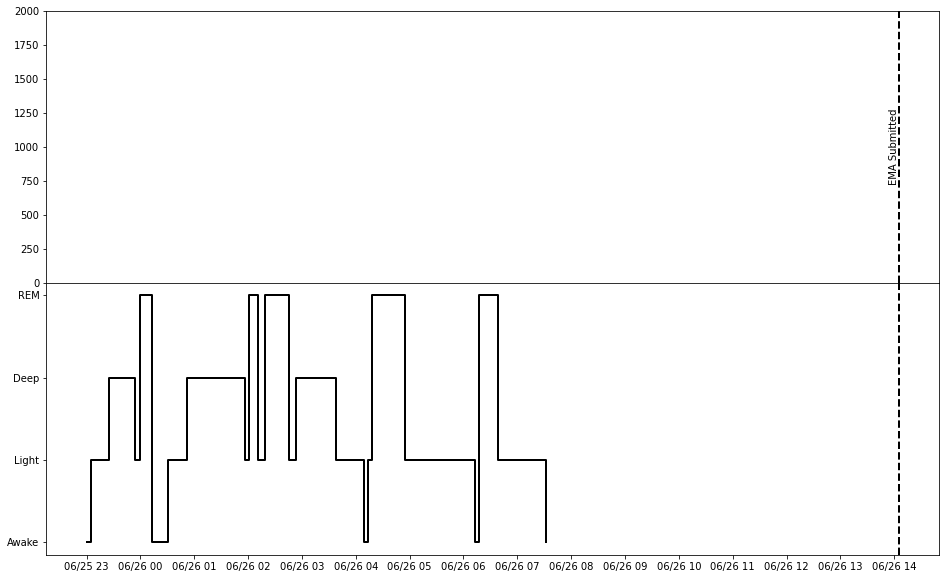

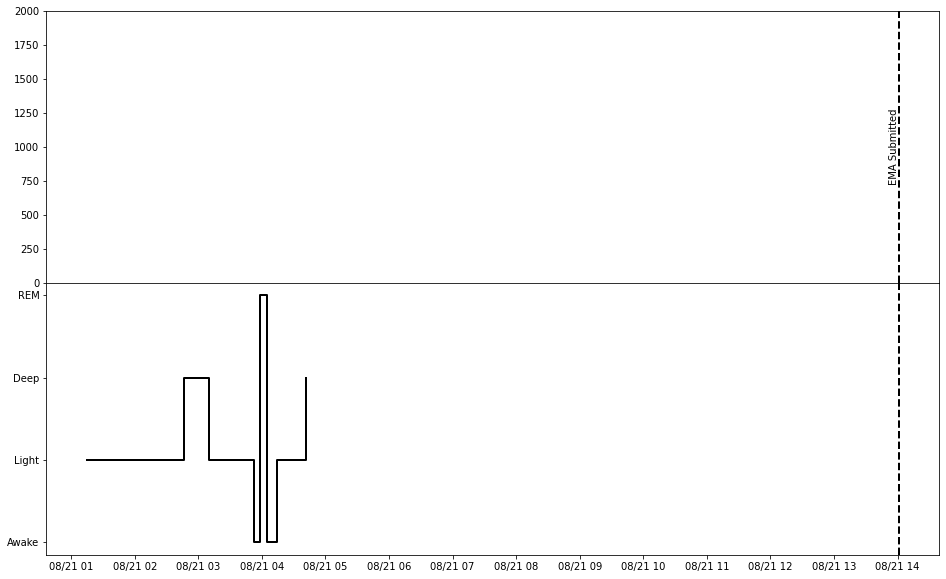

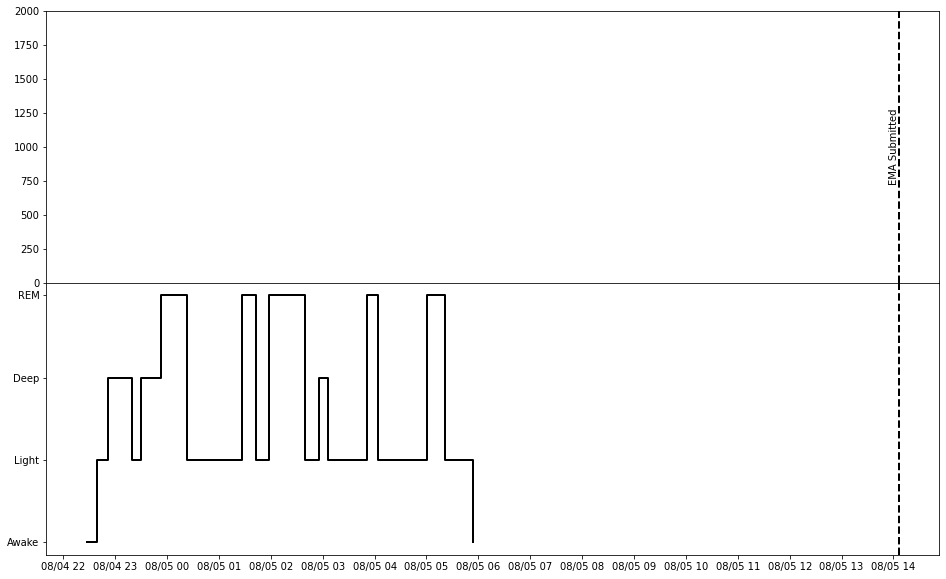

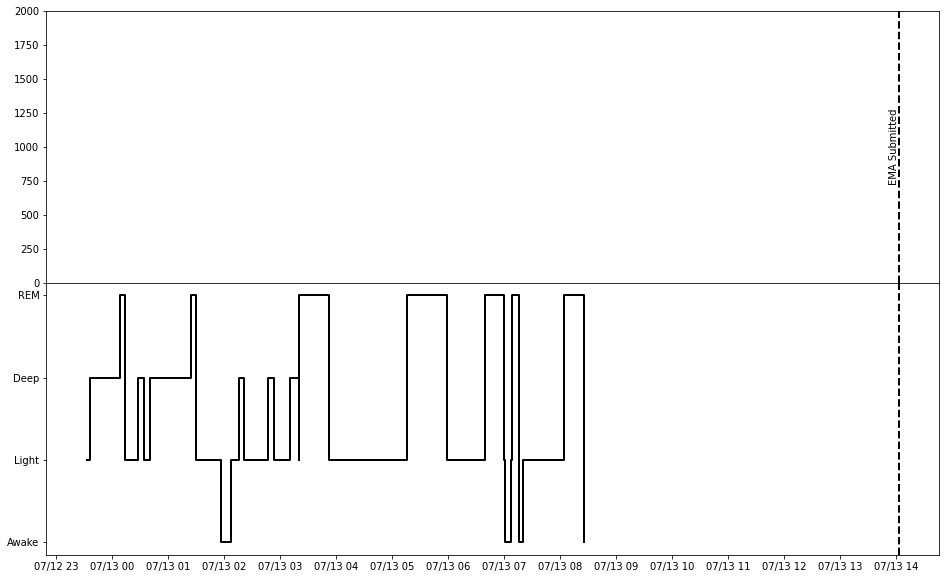

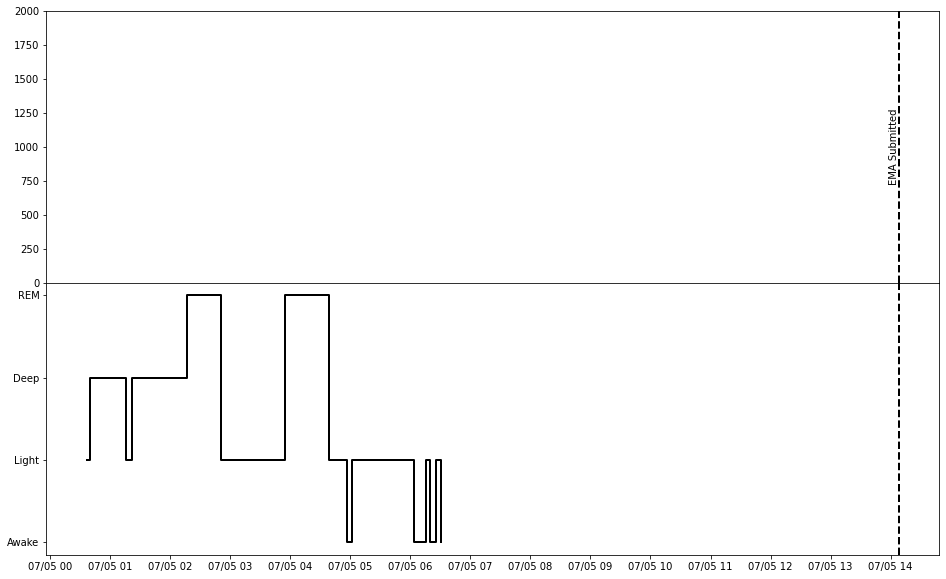

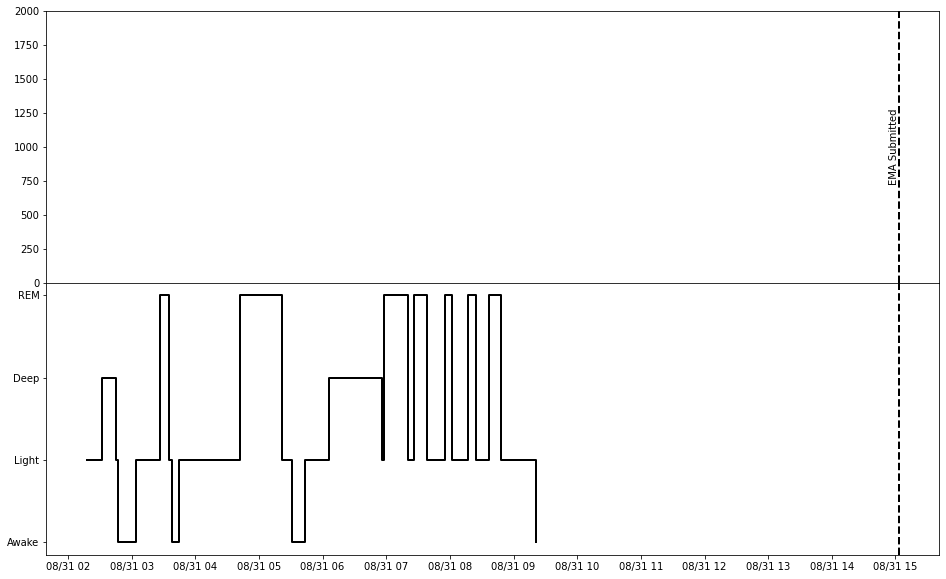

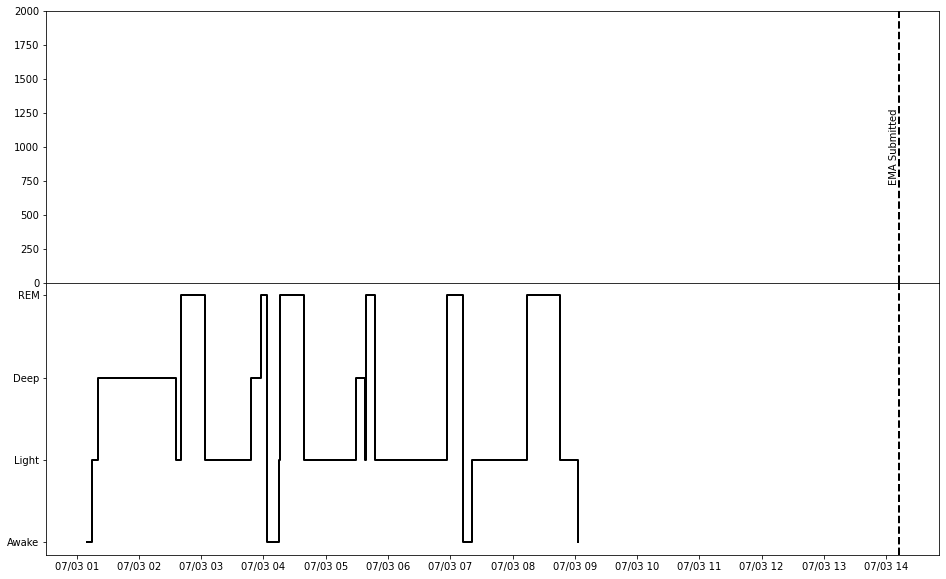

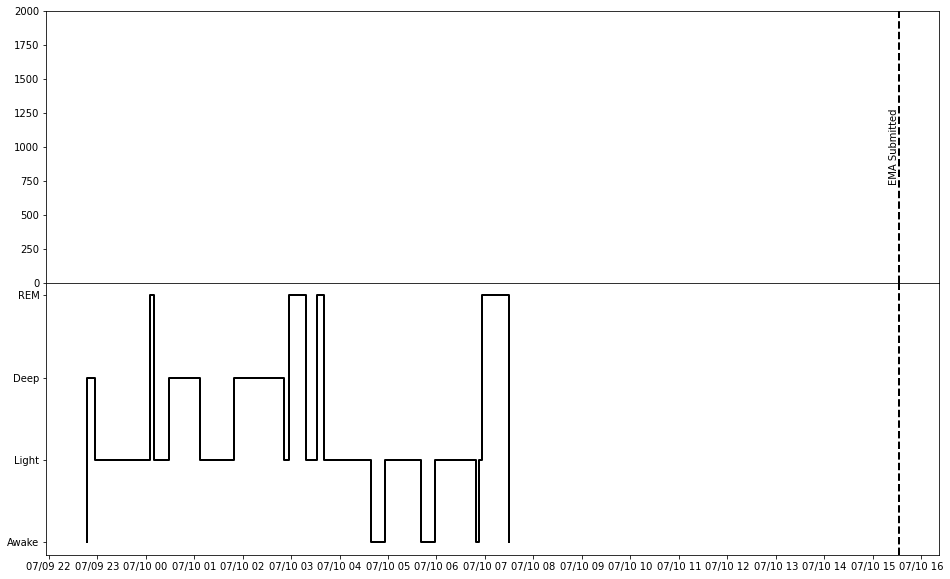

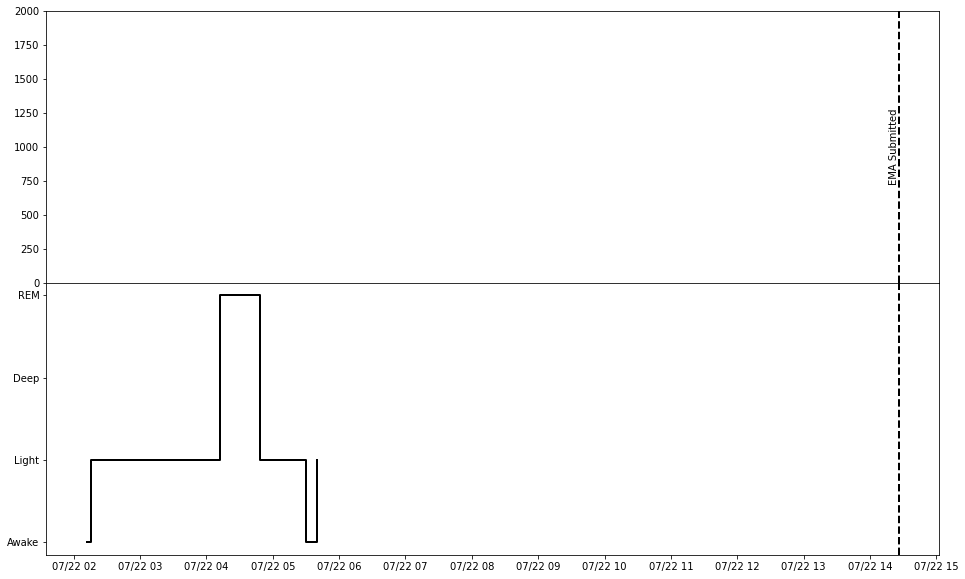

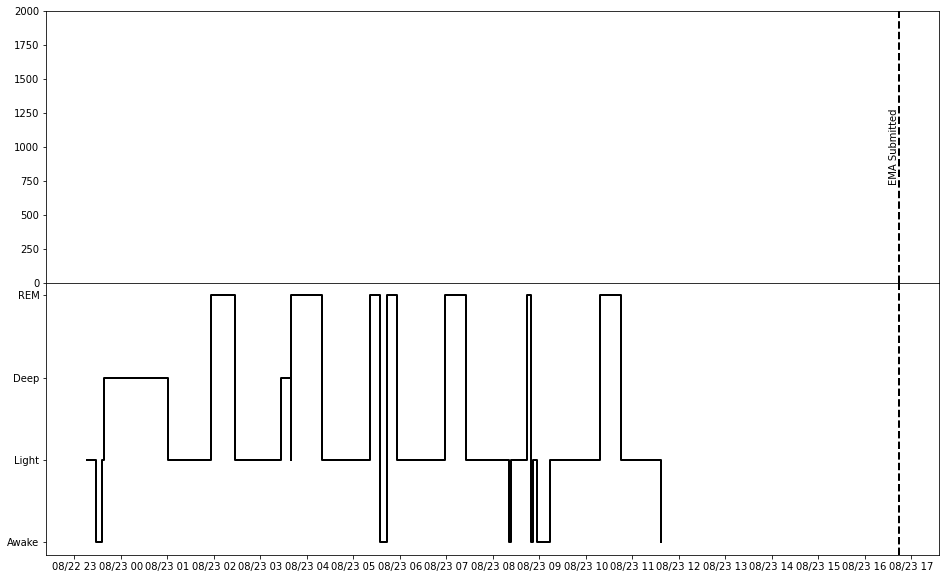

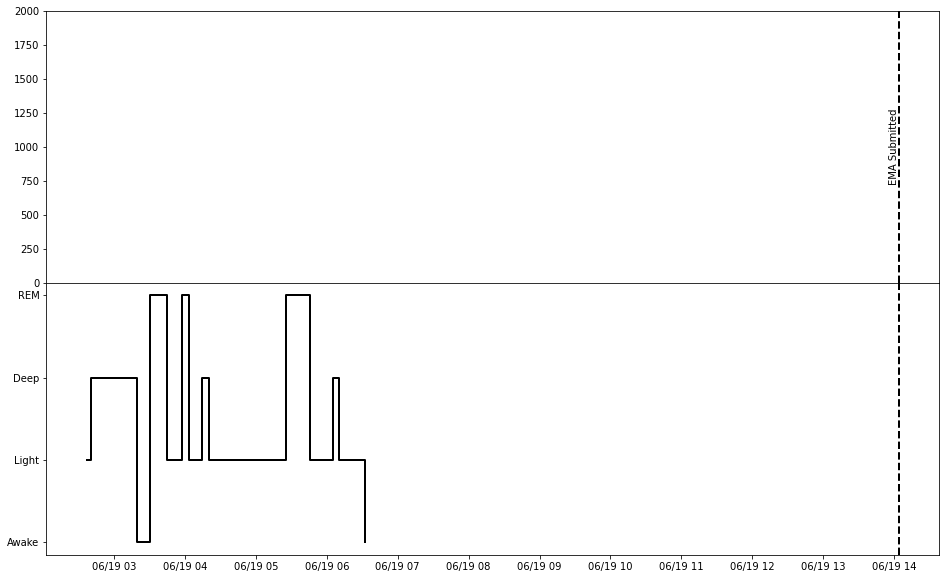

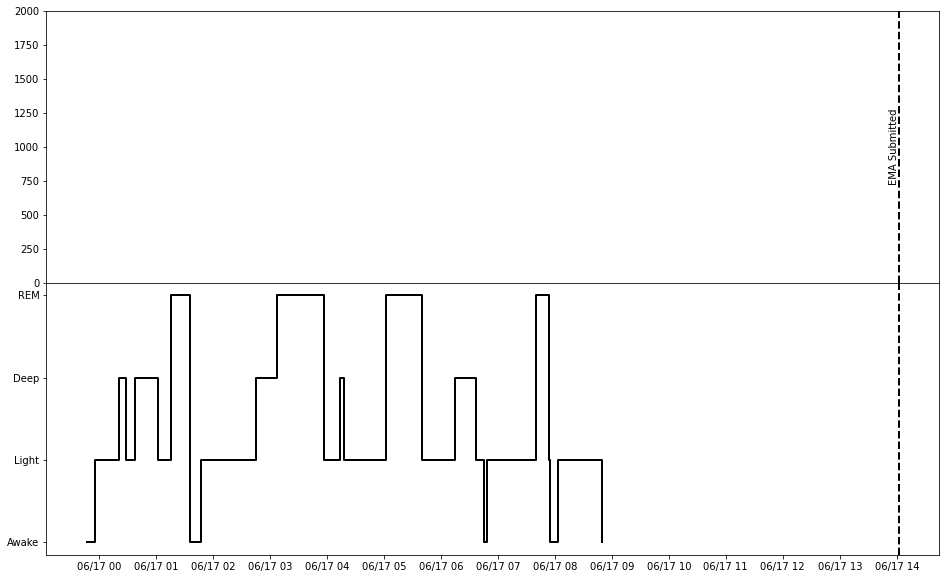

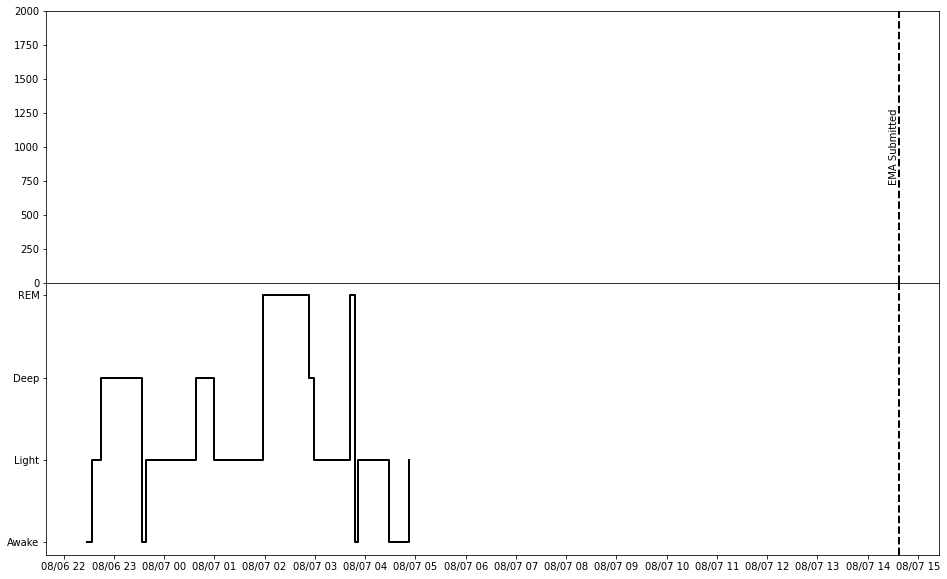

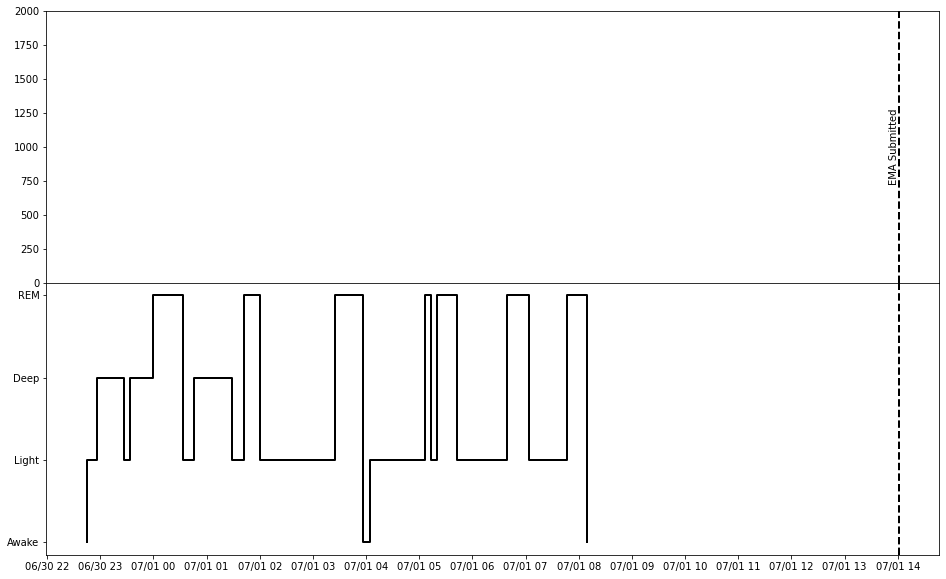

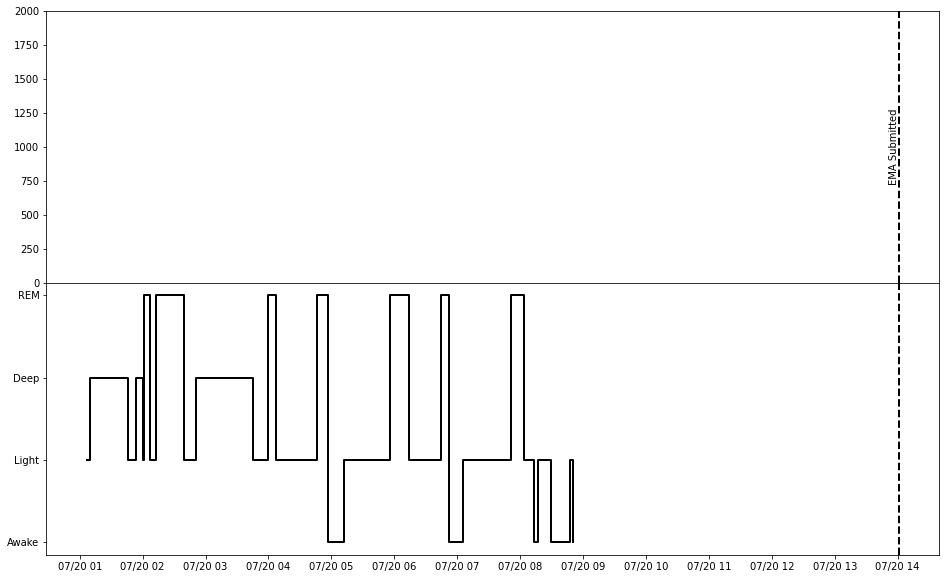

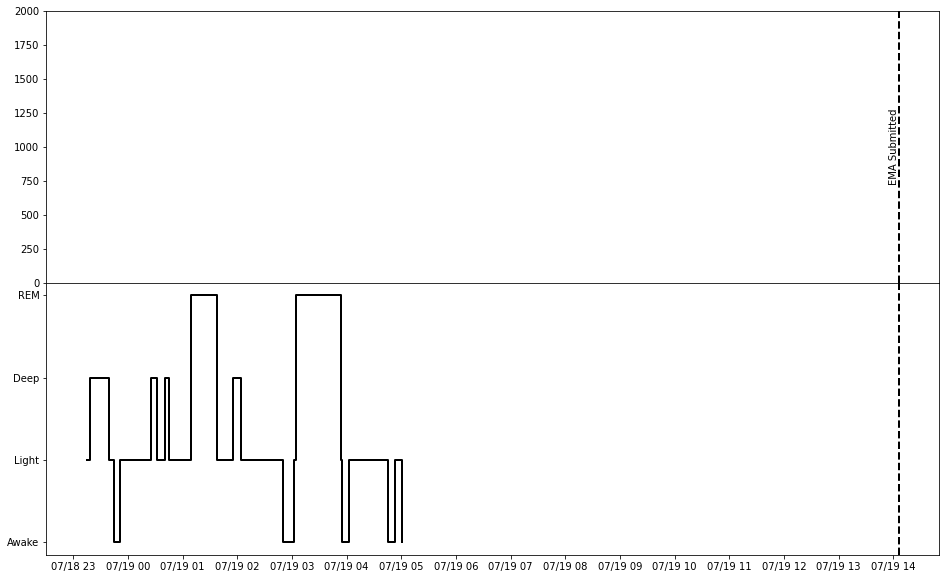

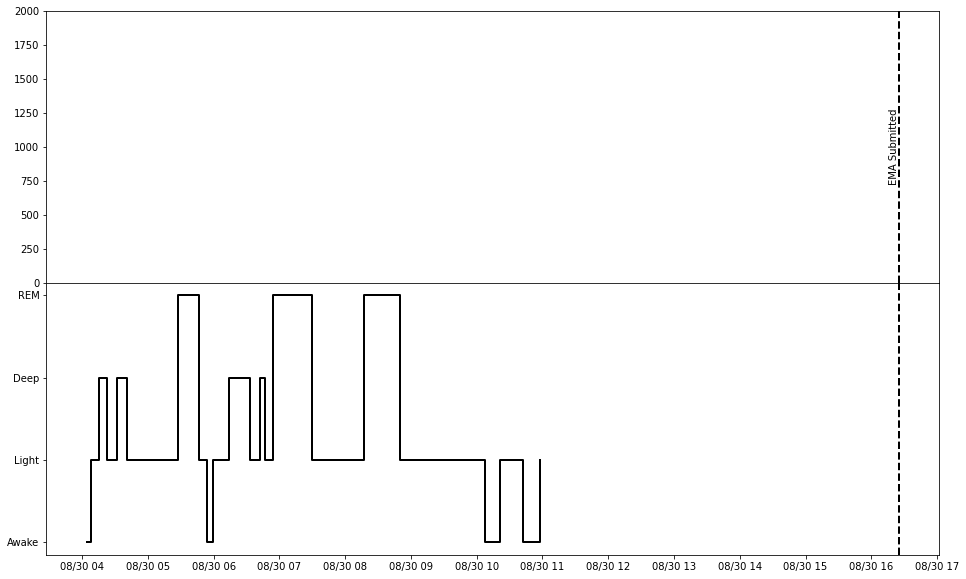

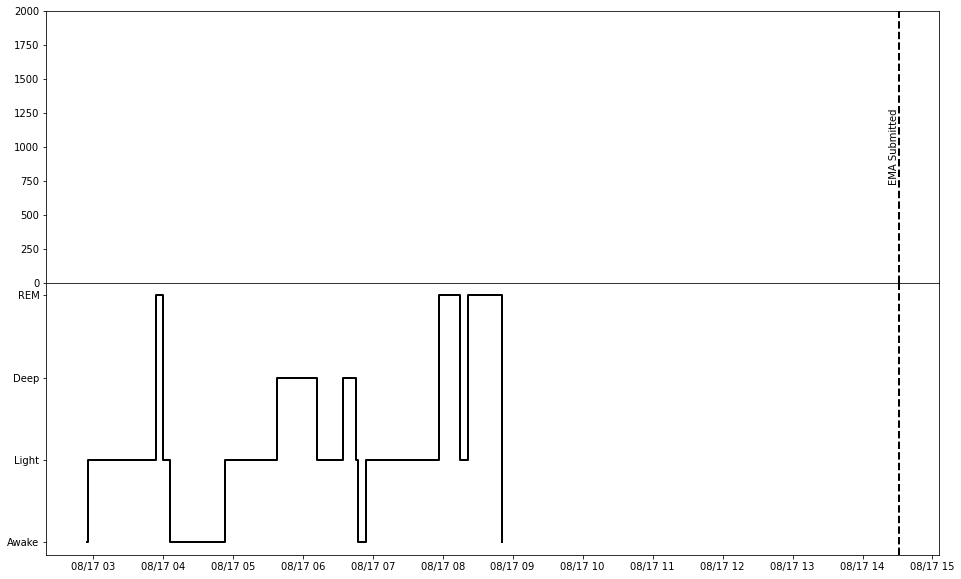

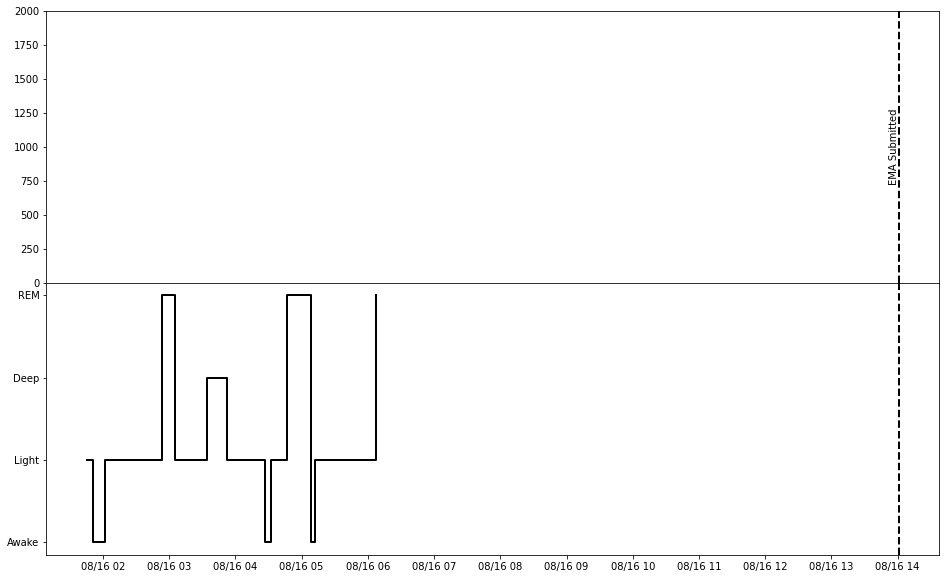

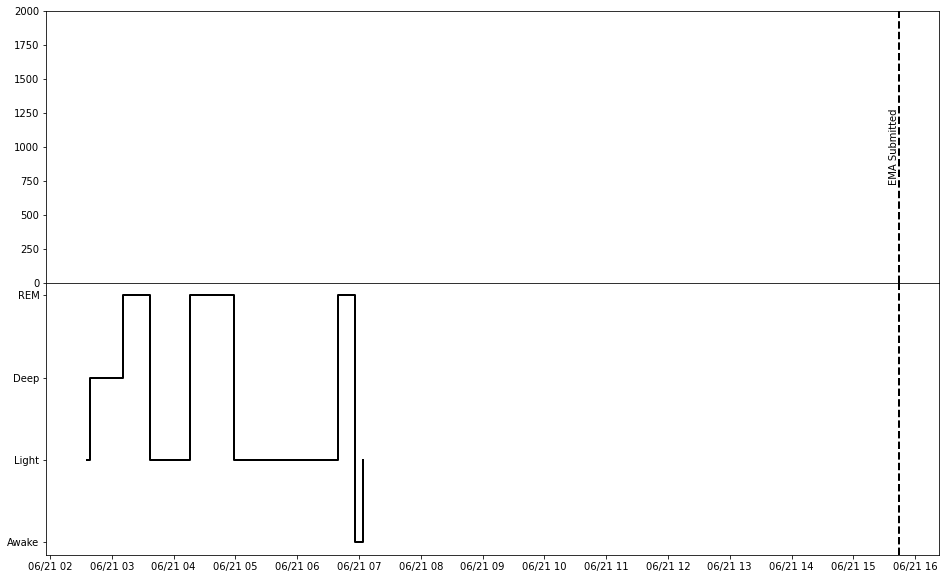

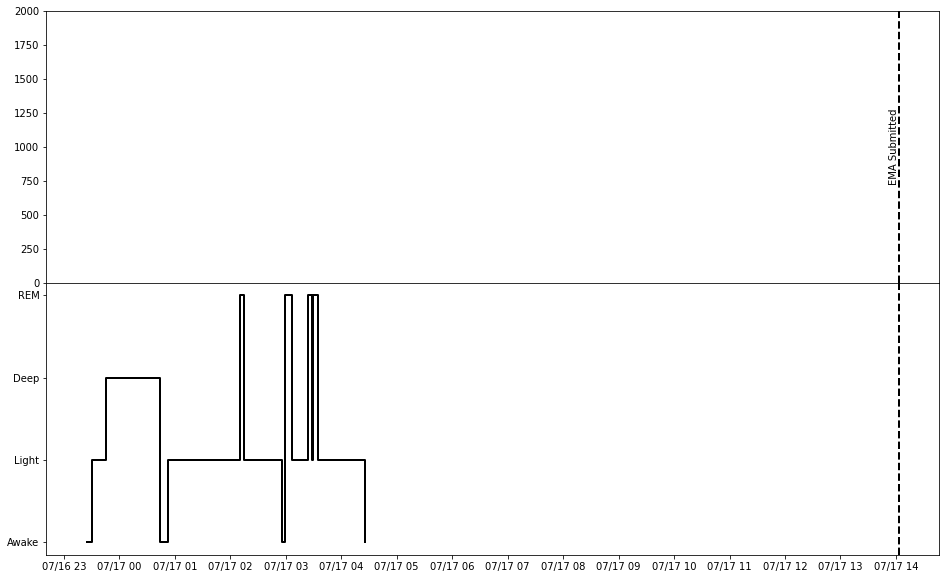

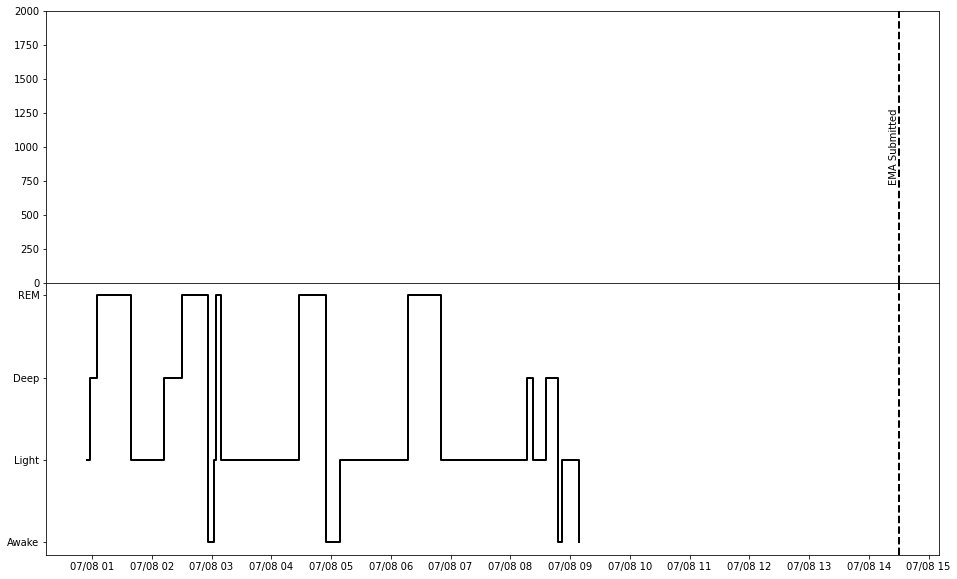

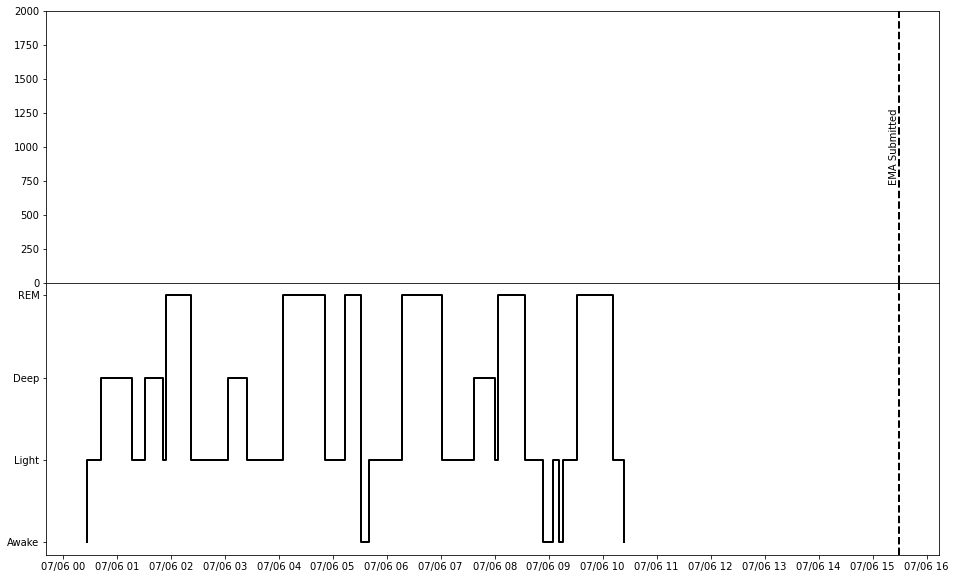

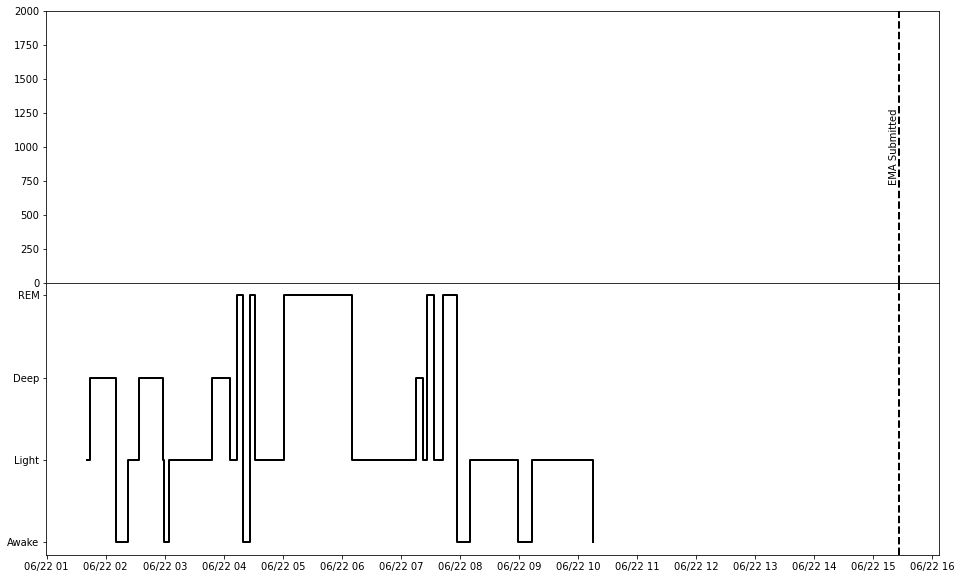

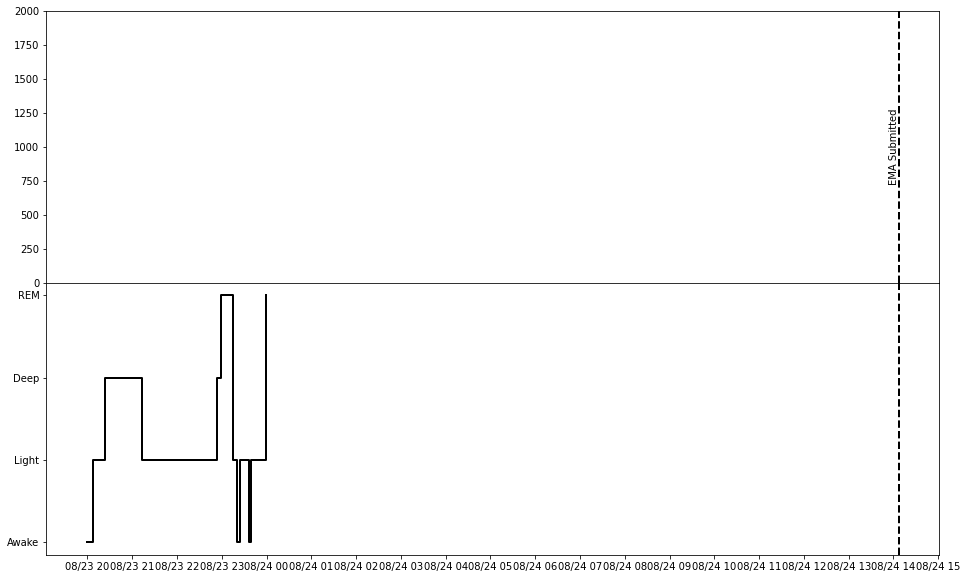

745vq78e


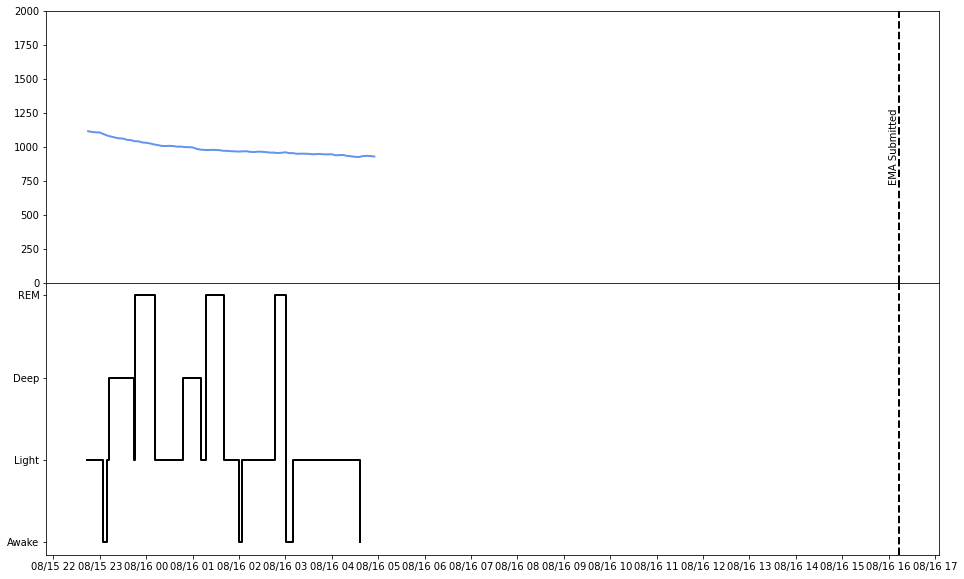

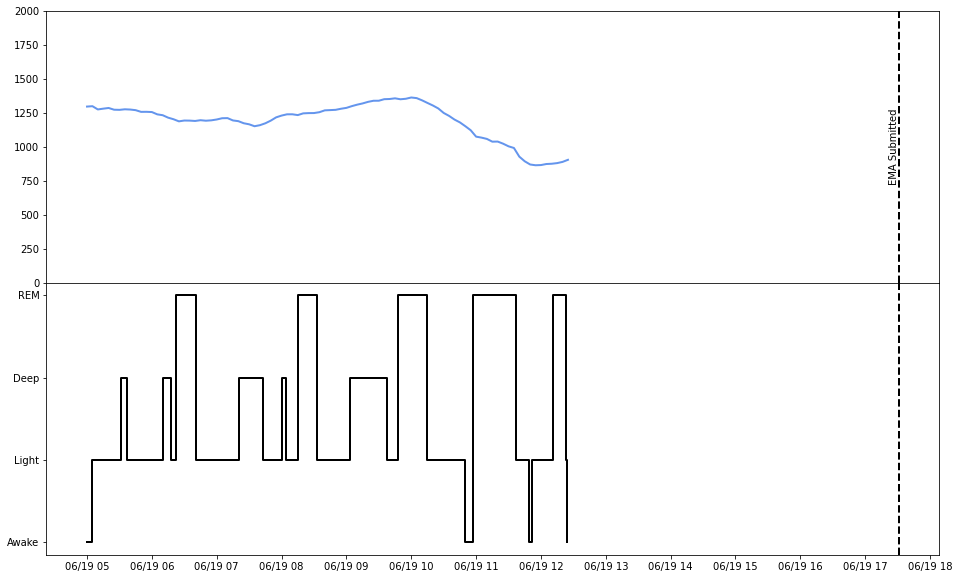

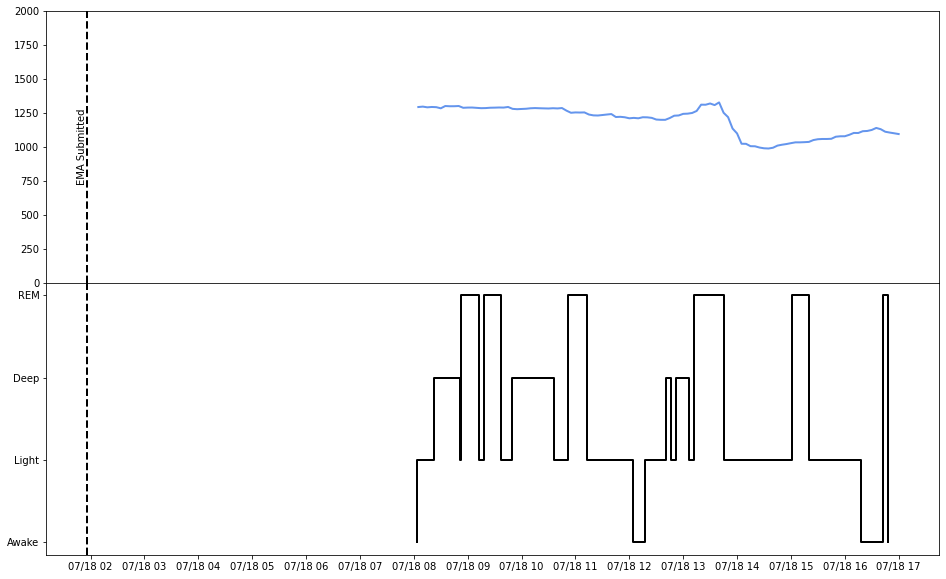

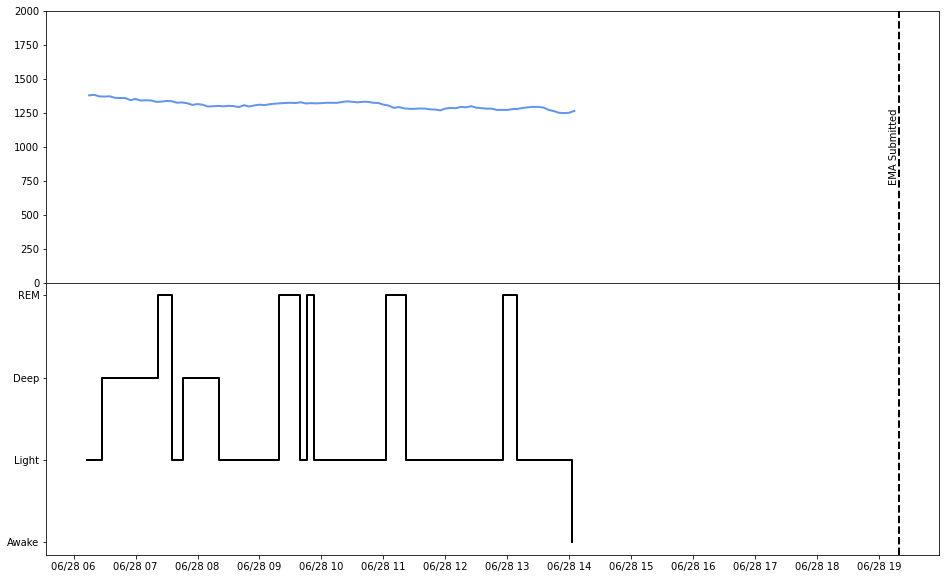

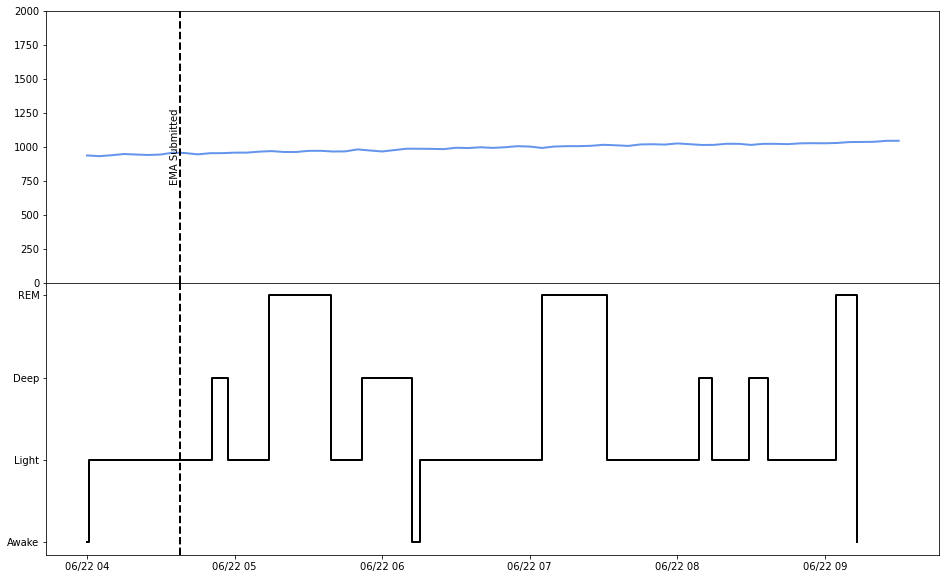

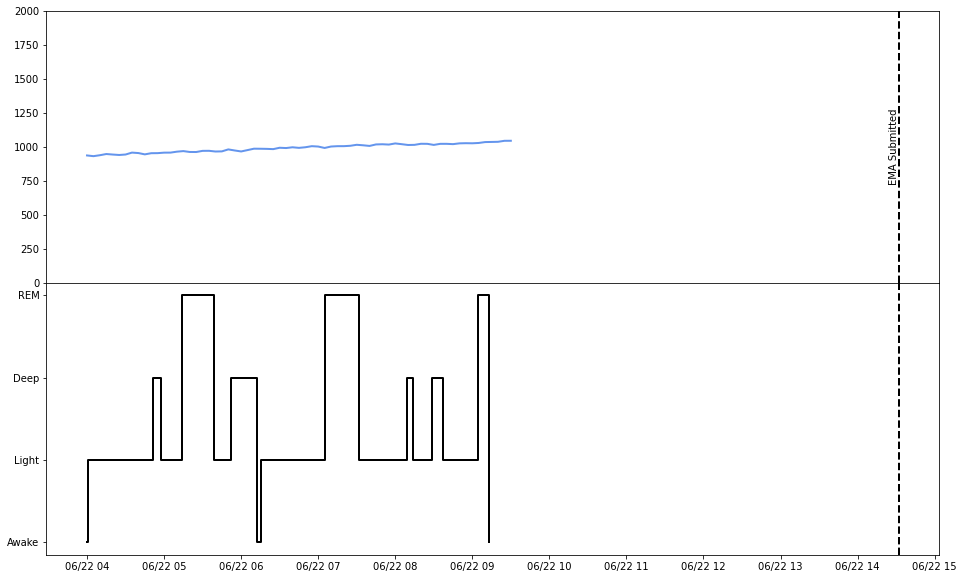

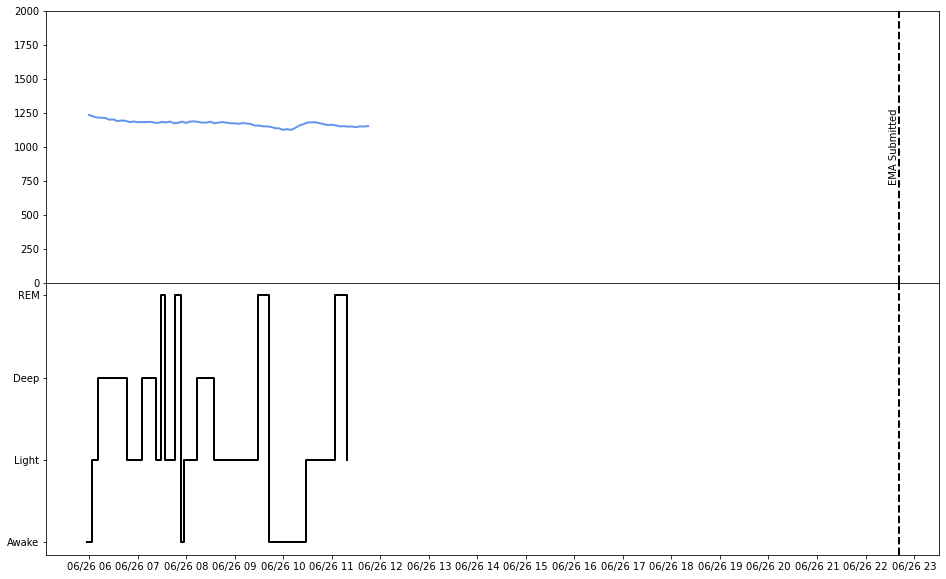

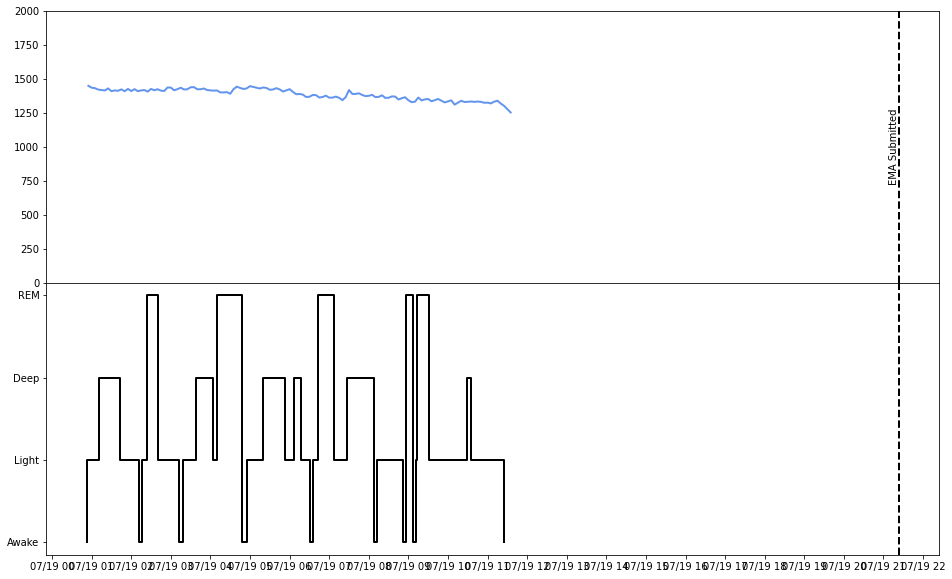

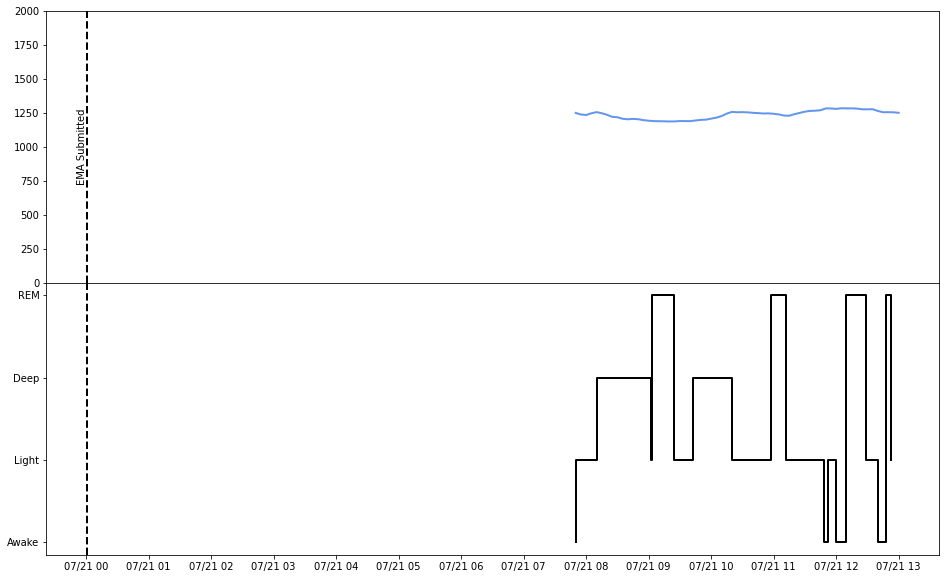

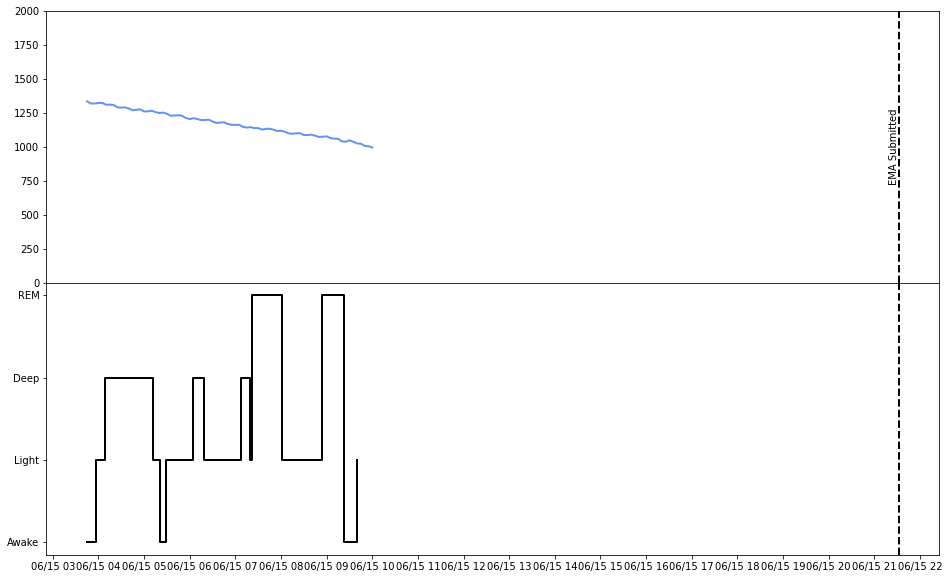

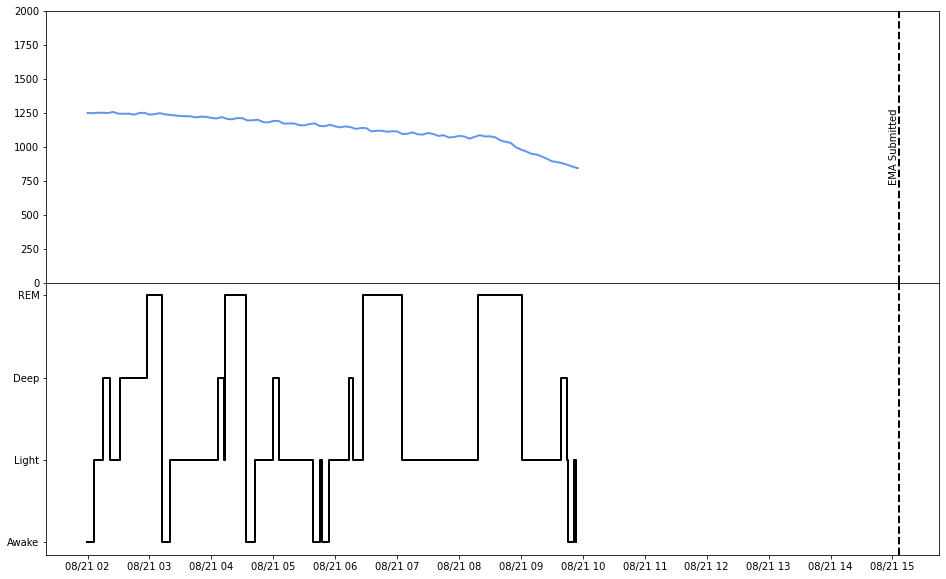

9jtzsuu8


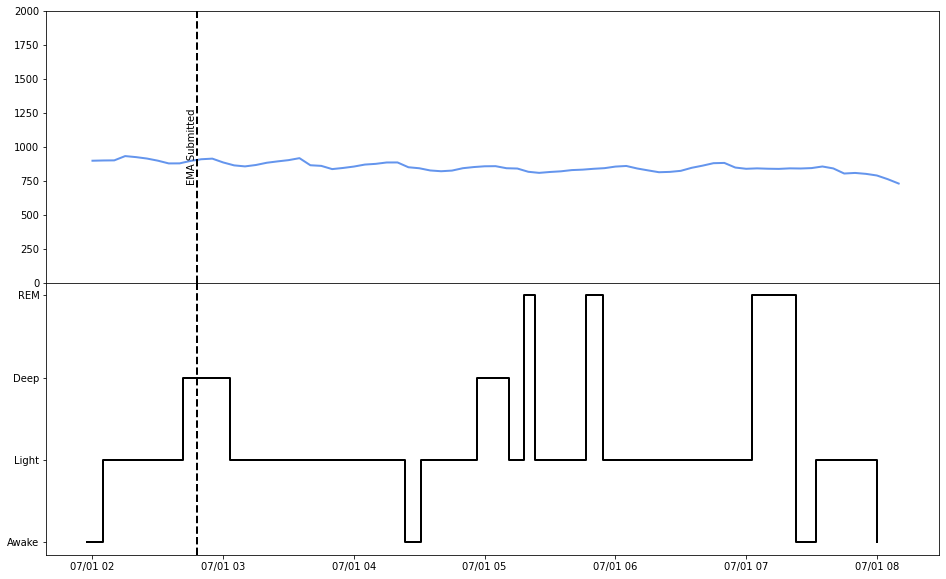

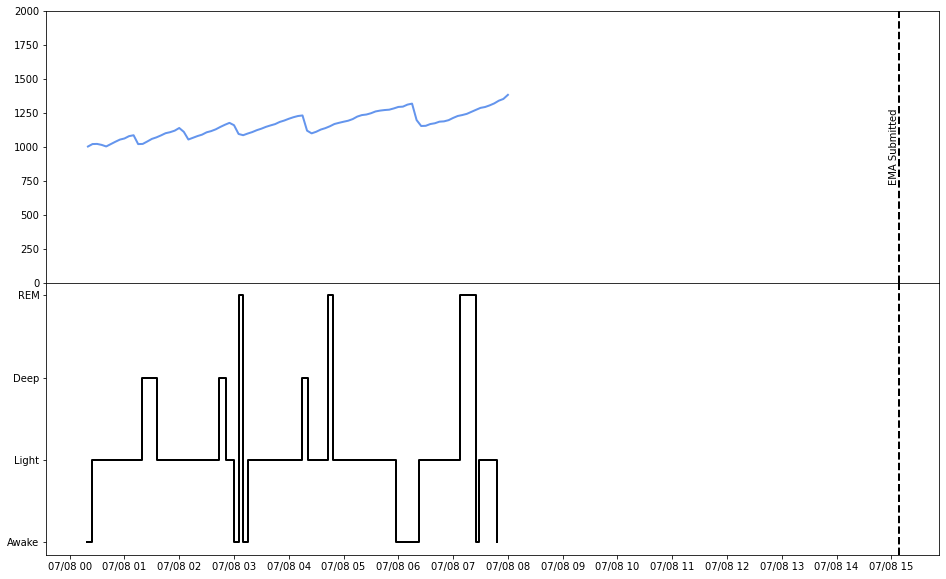

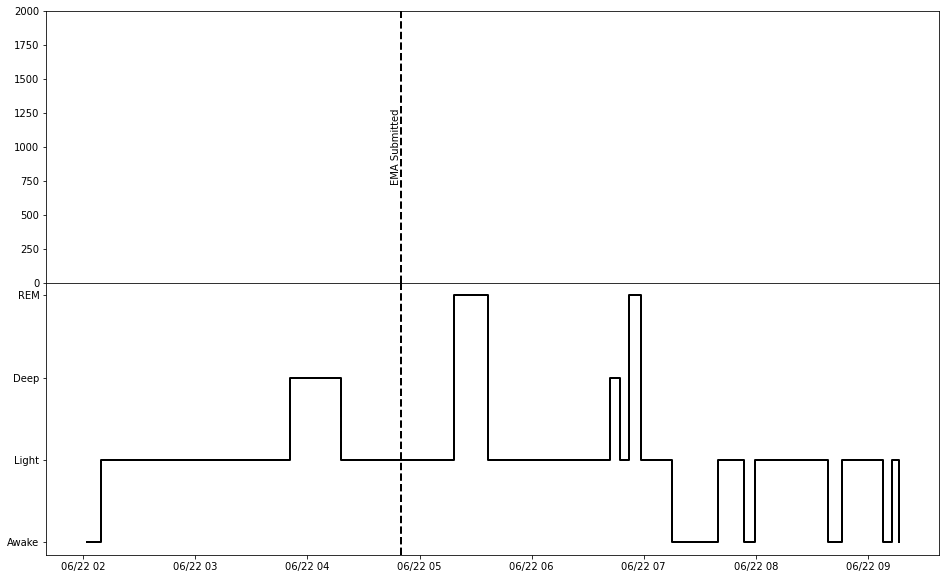

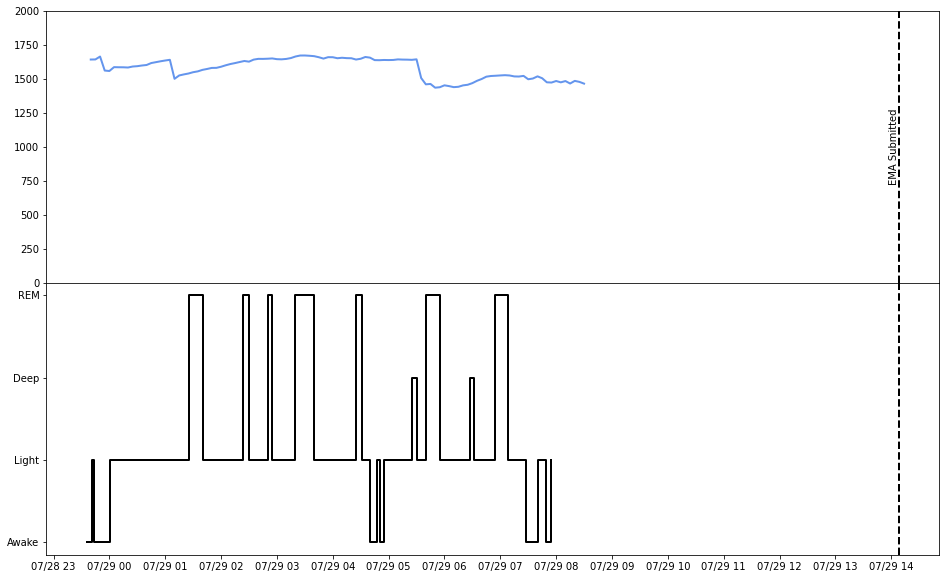

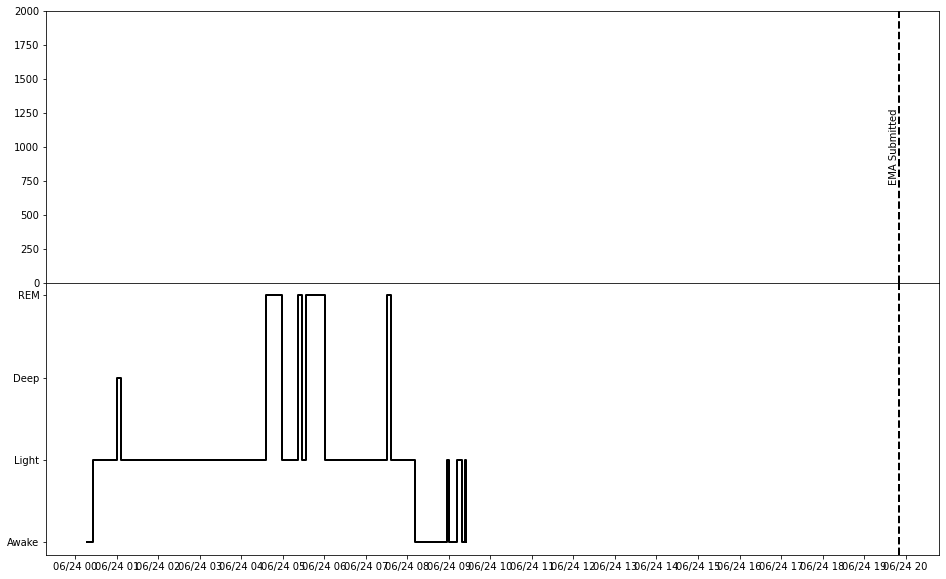

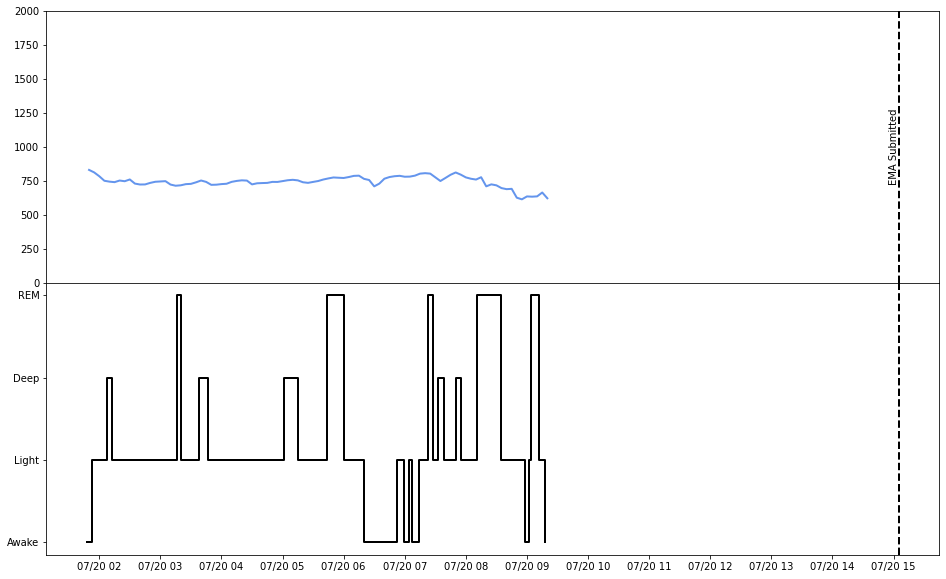

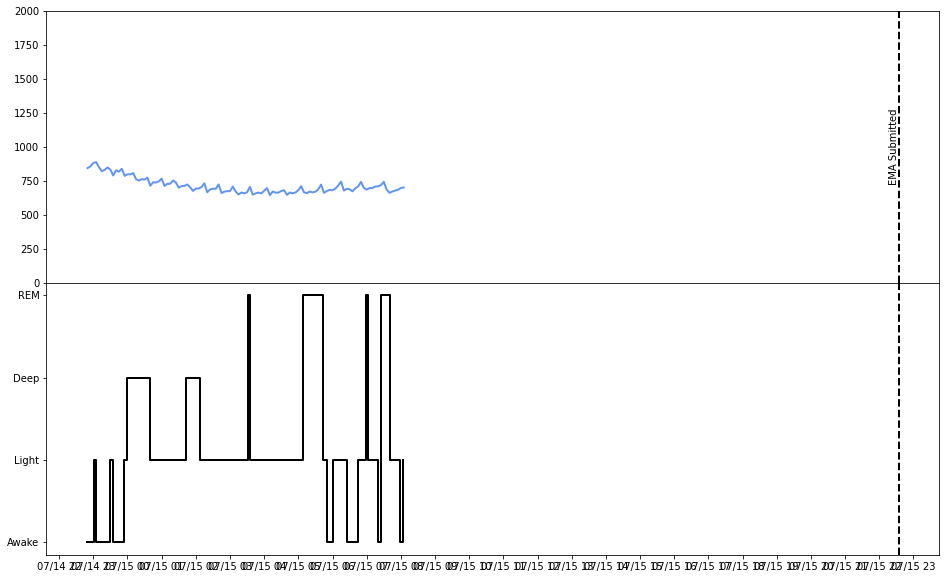

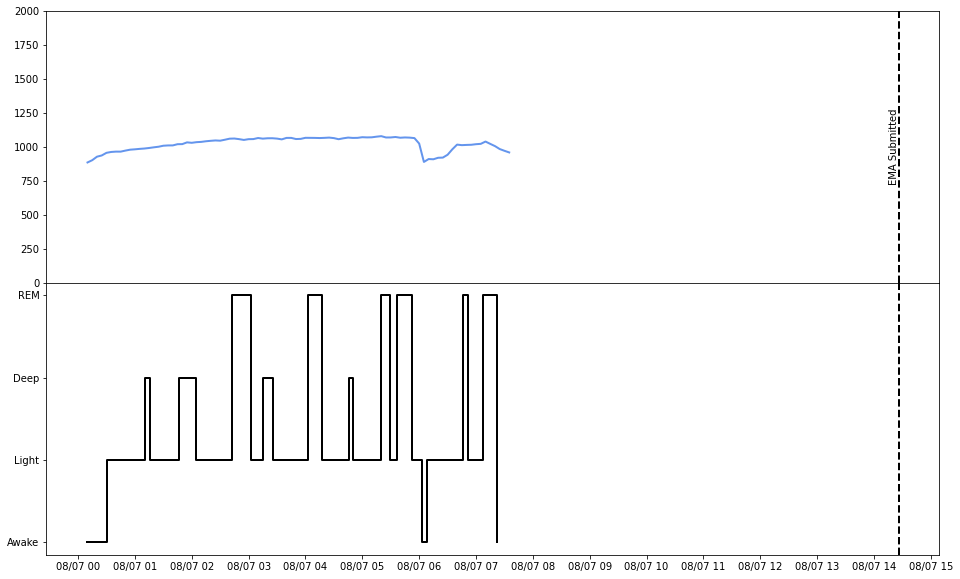

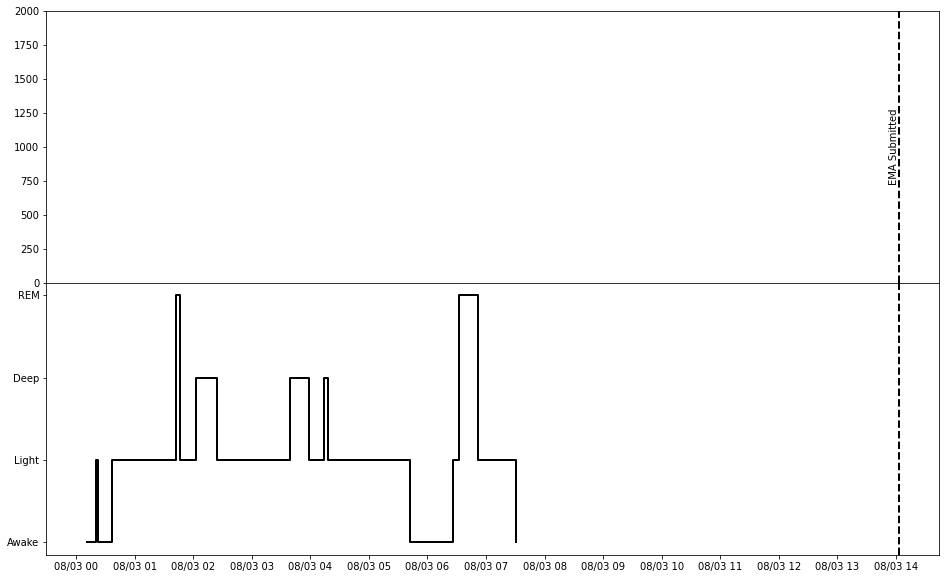

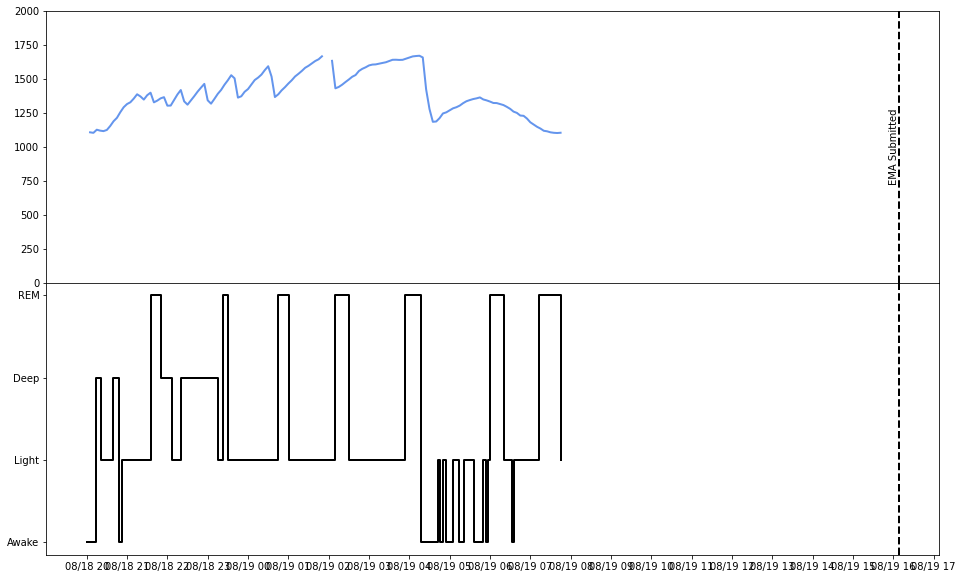

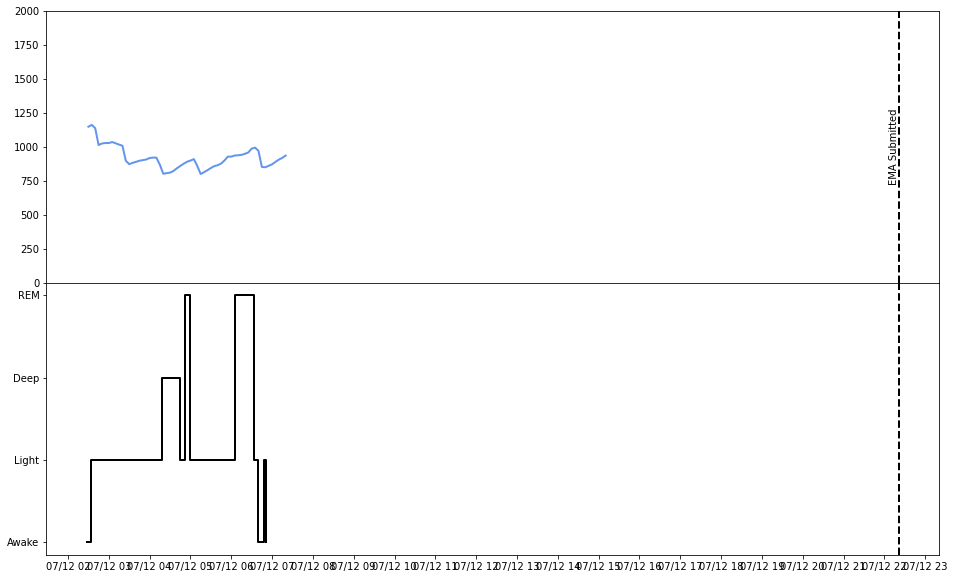

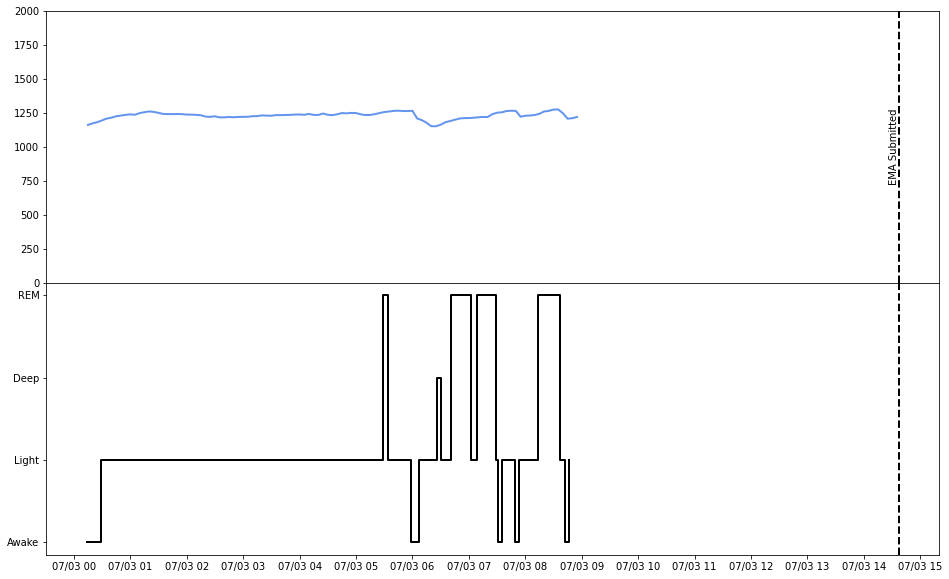

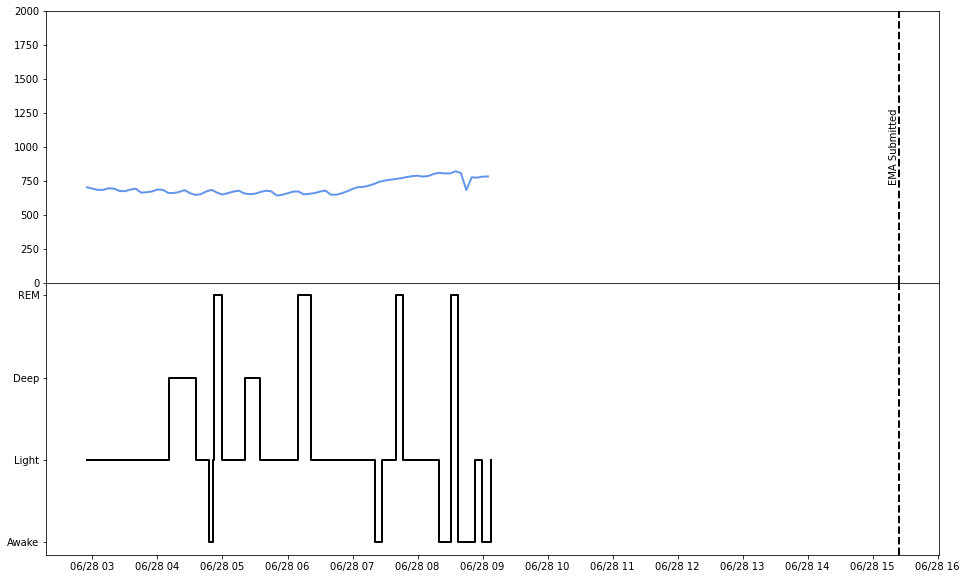

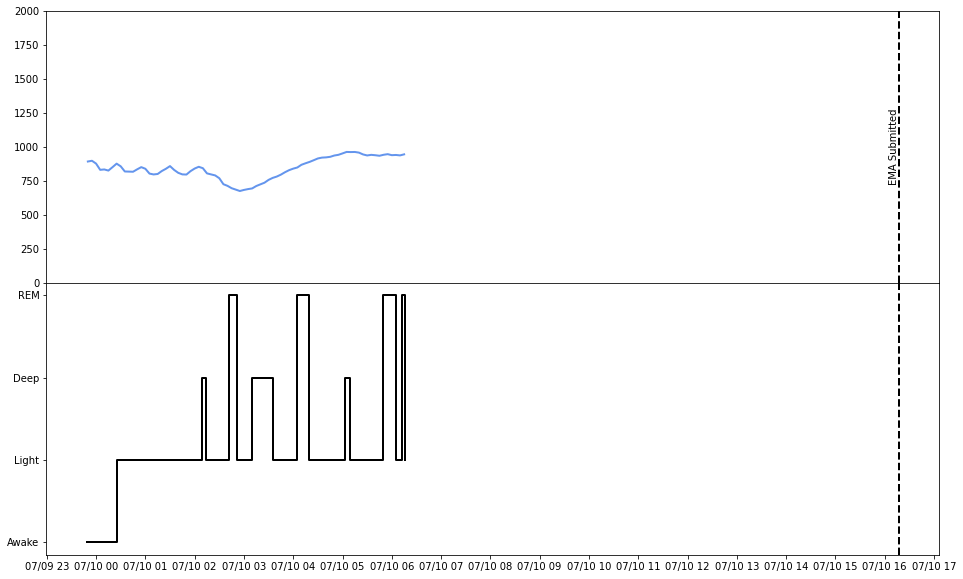

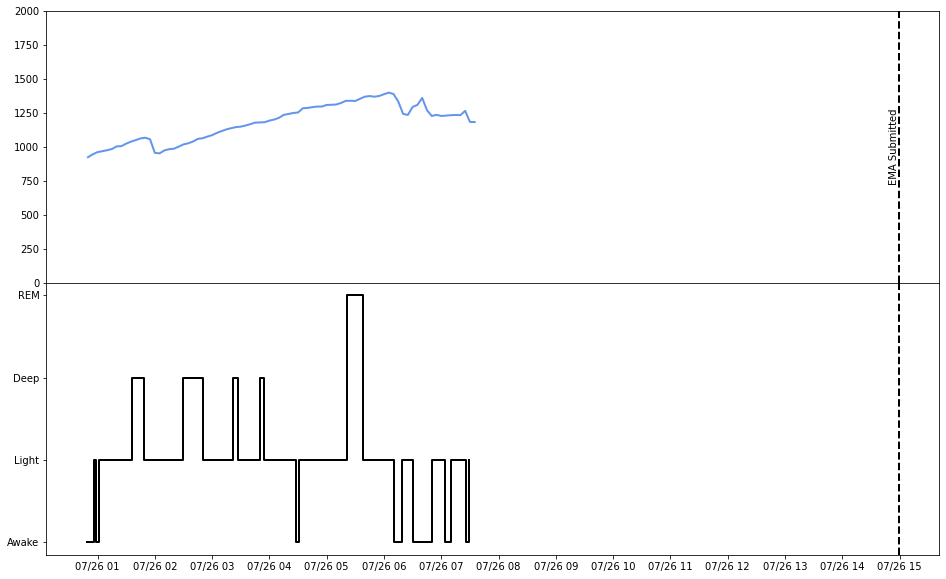

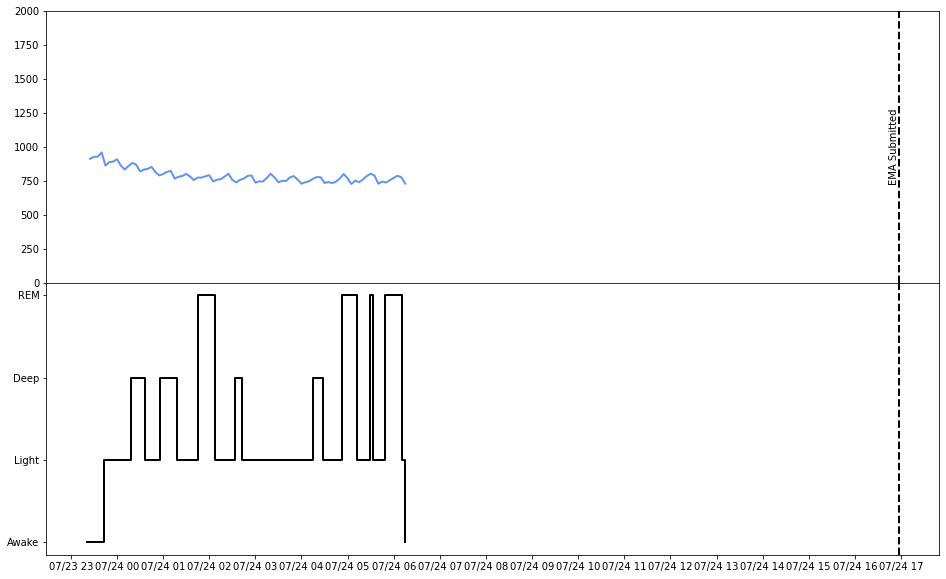

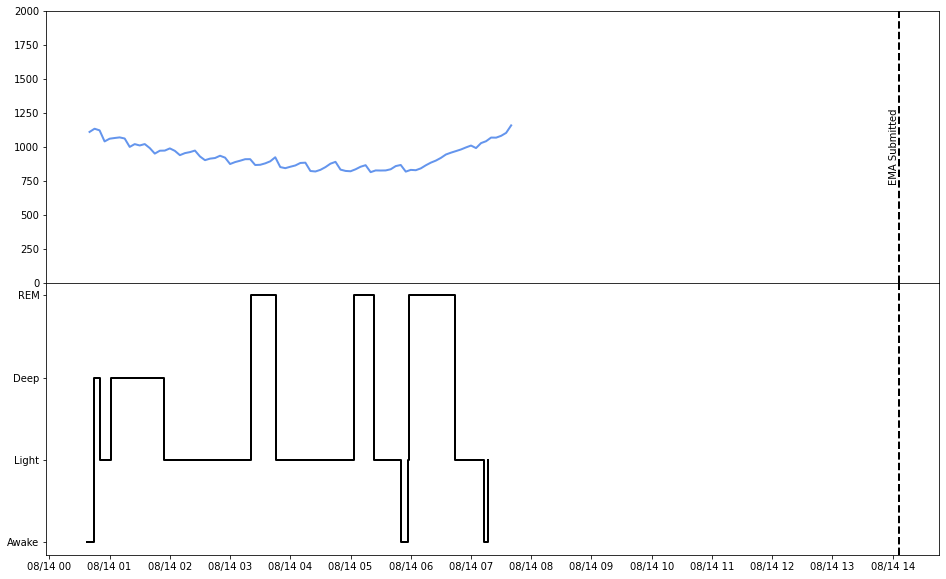

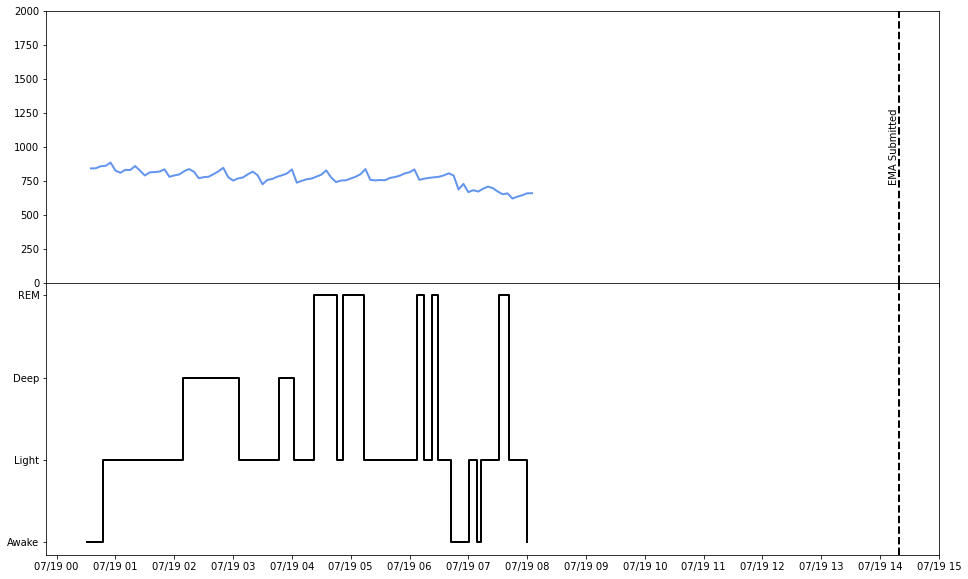

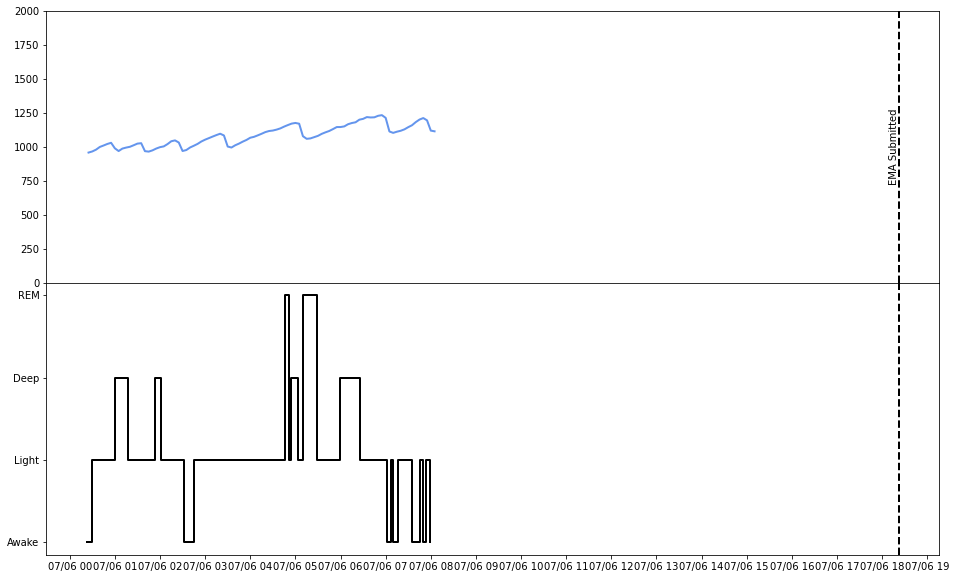

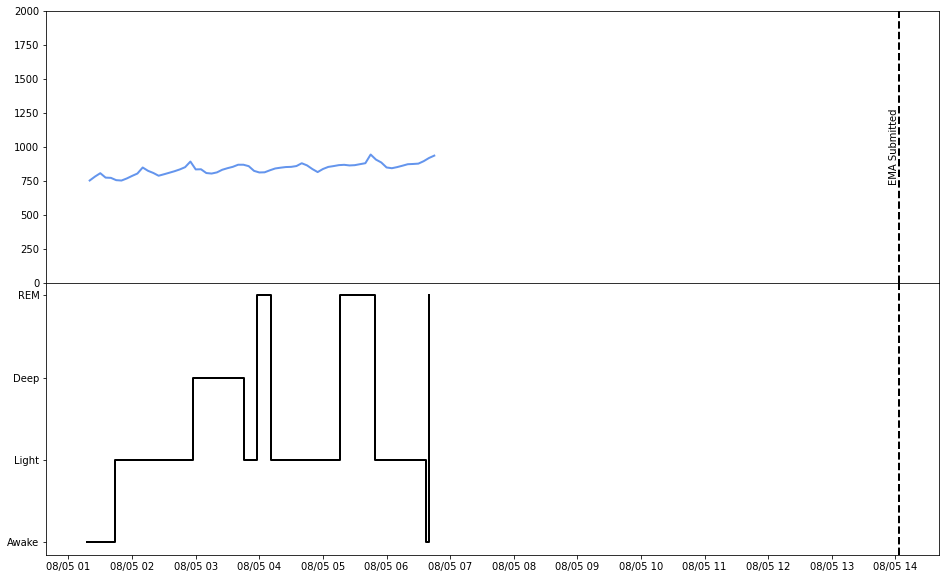

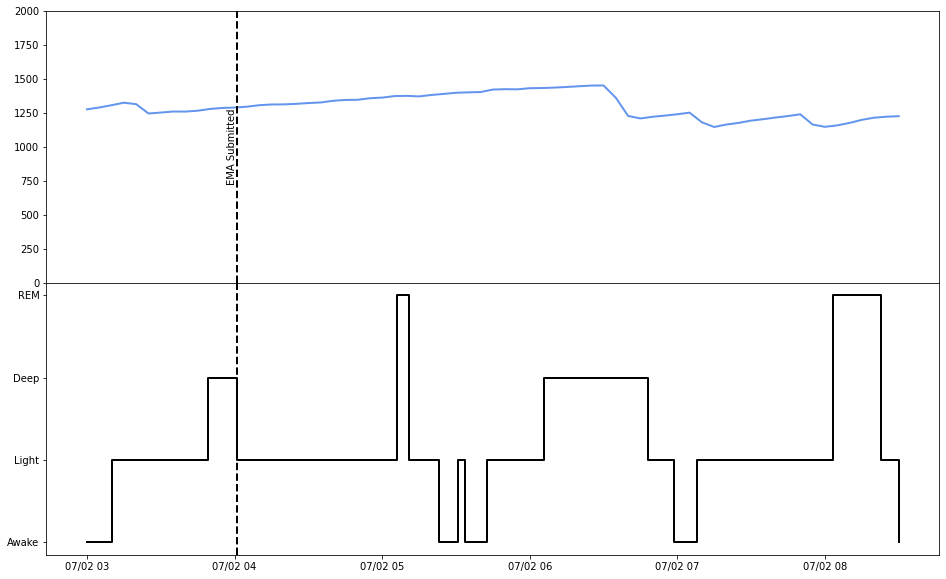

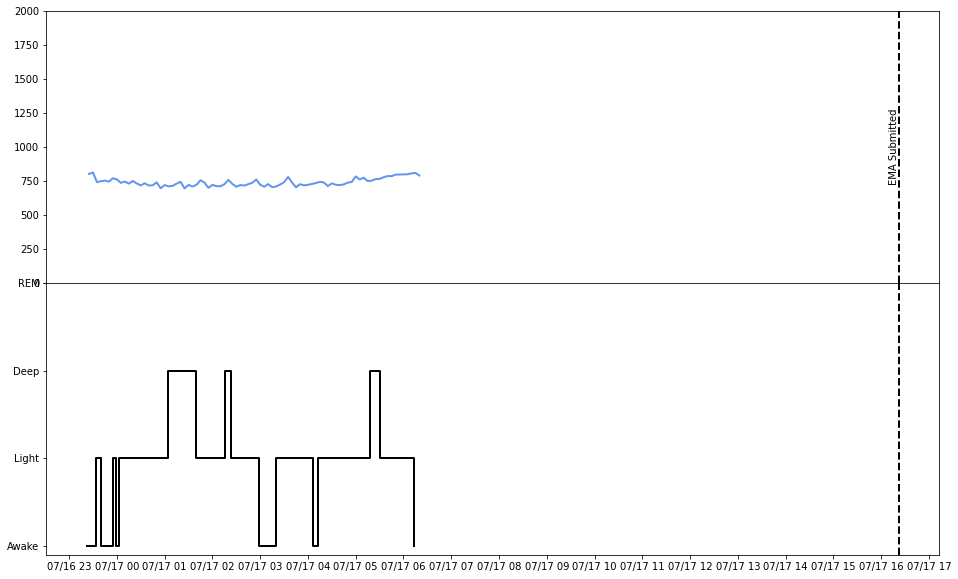

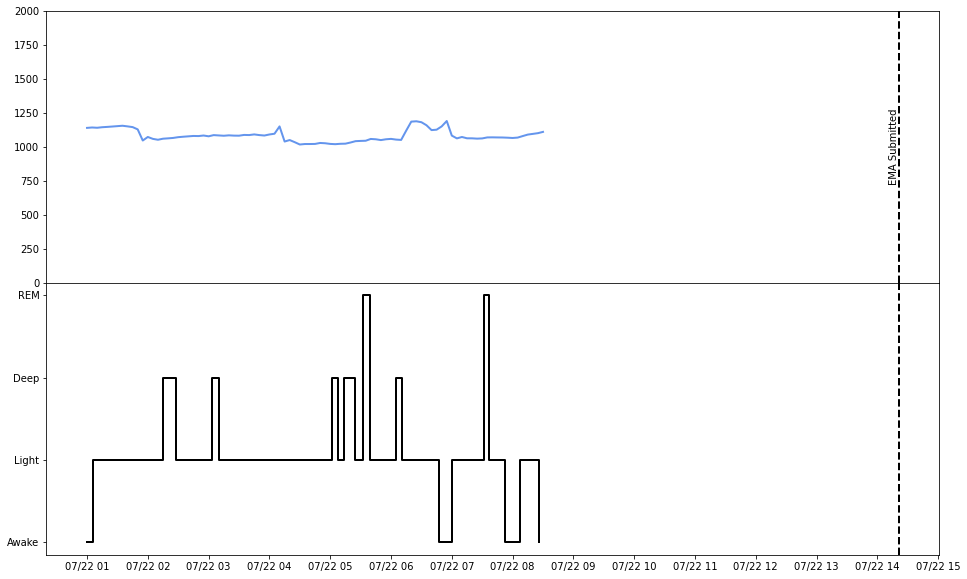

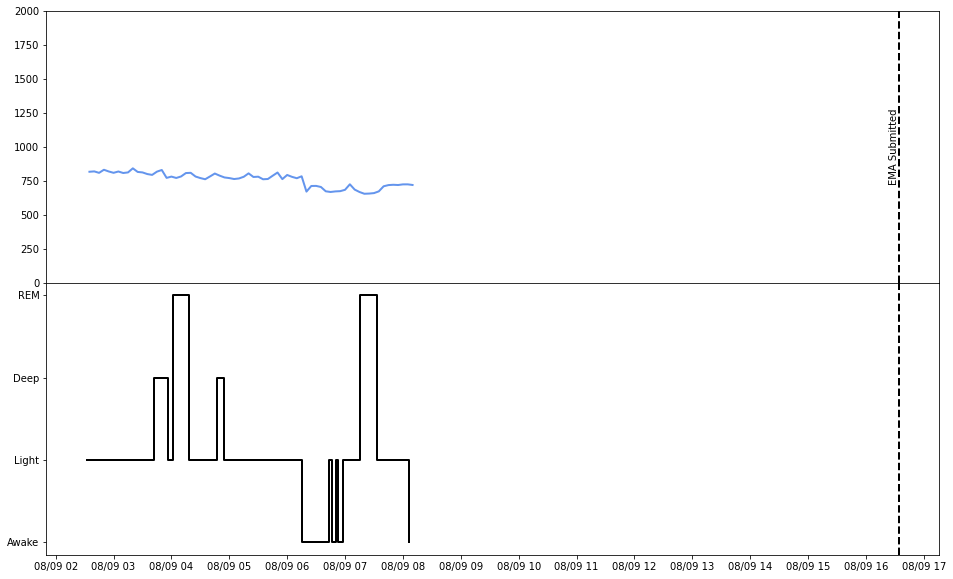

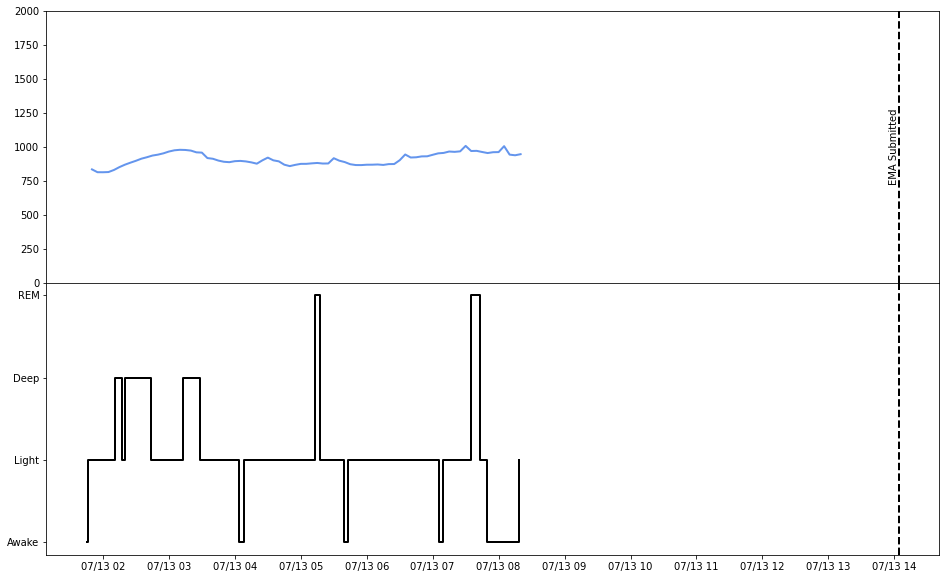

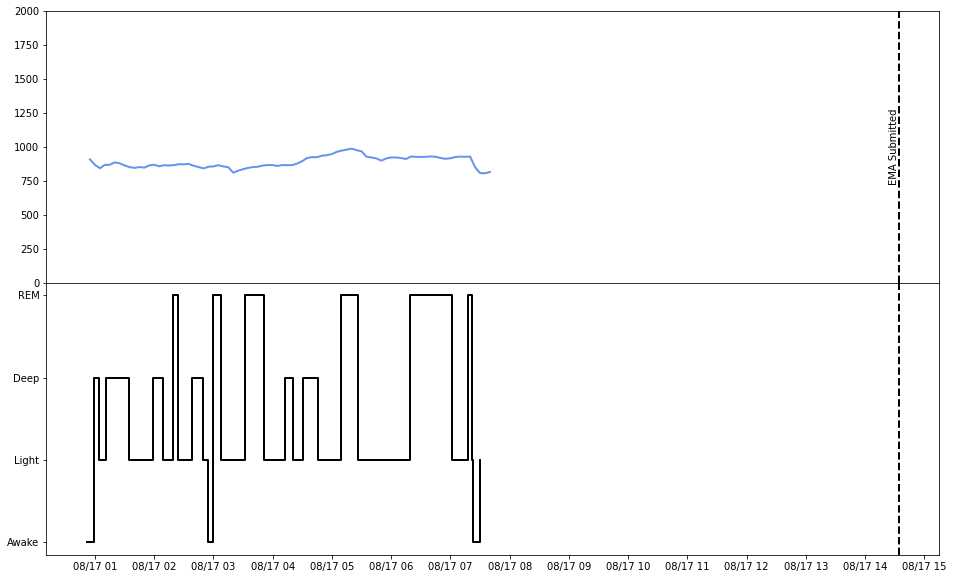

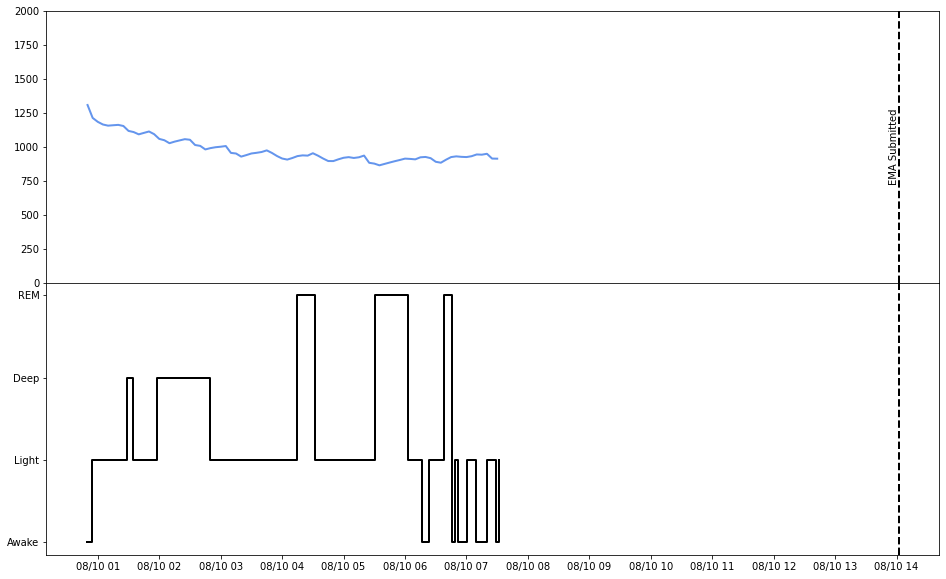

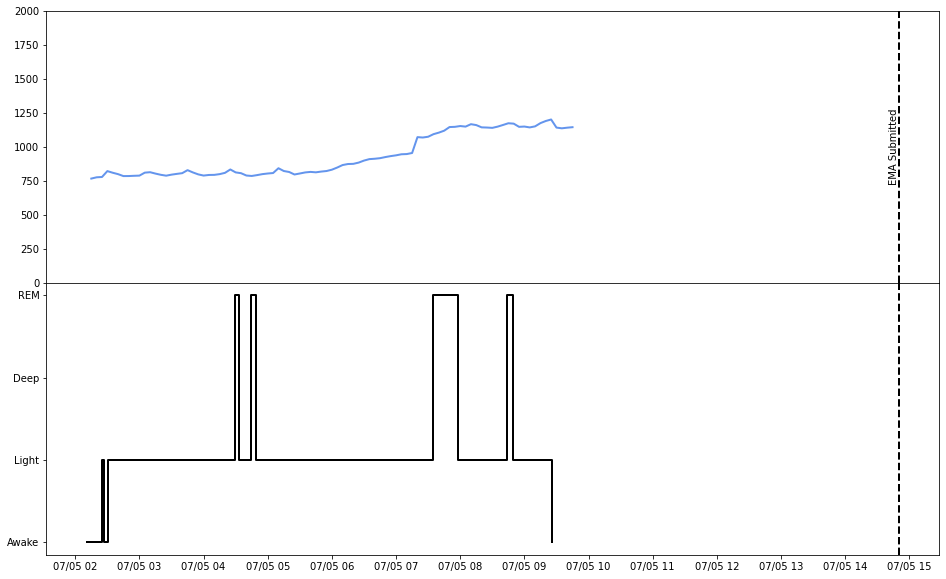

9xmhtq74


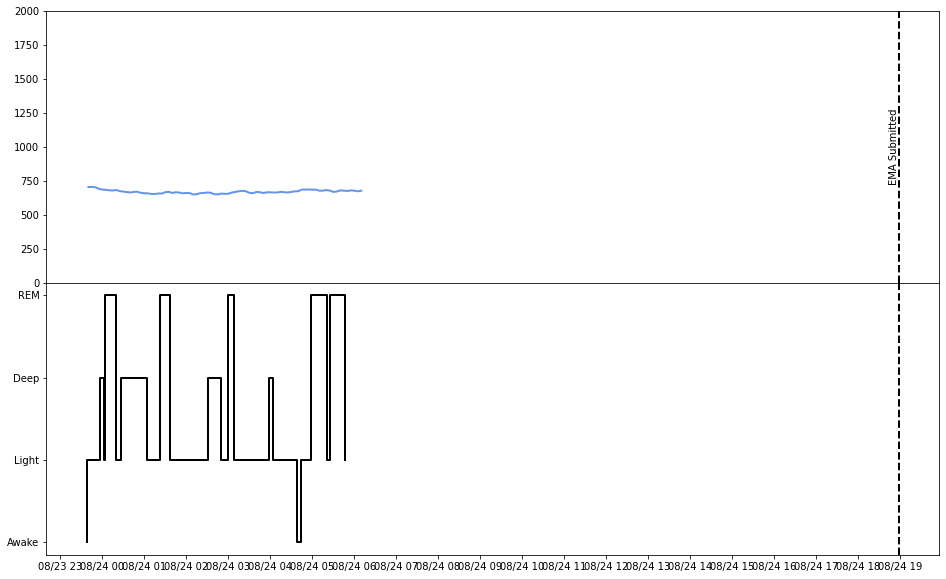

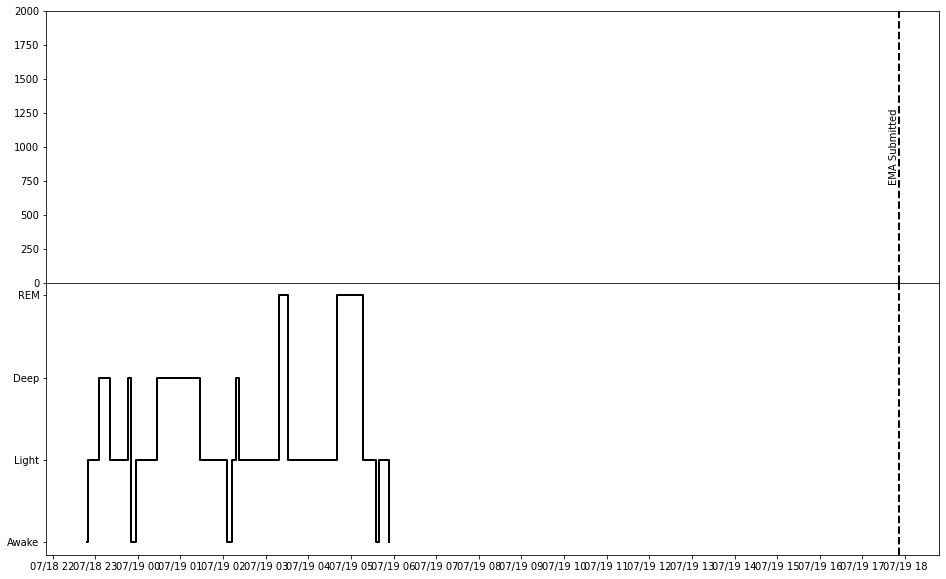

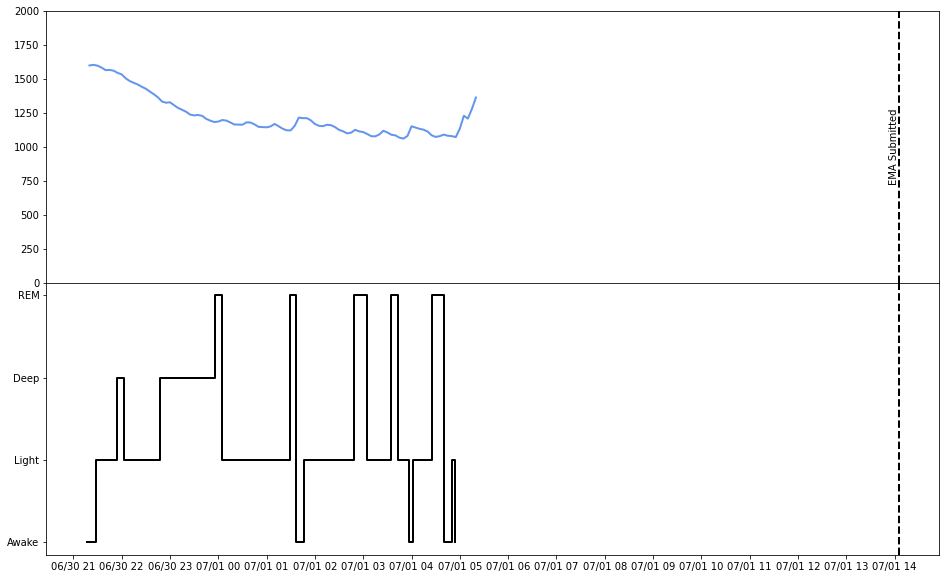

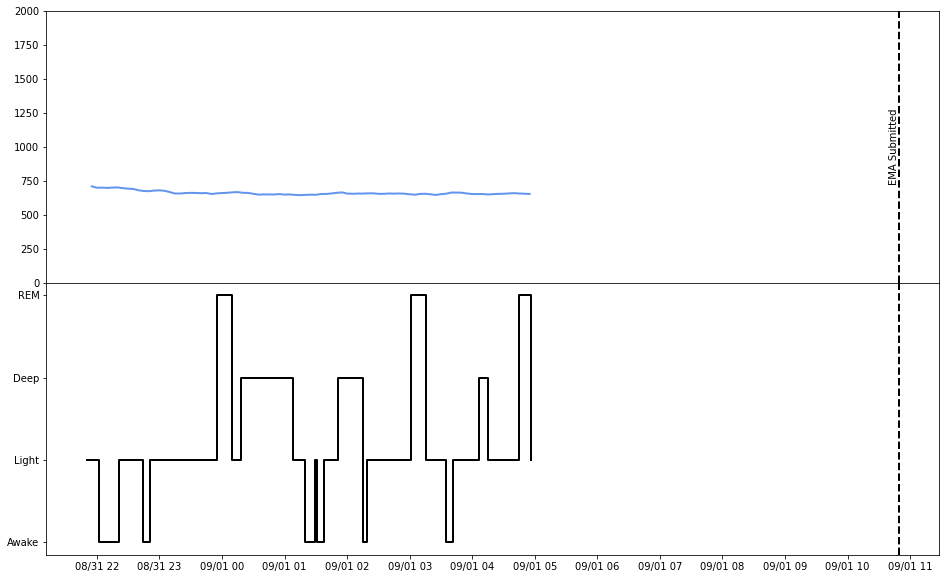

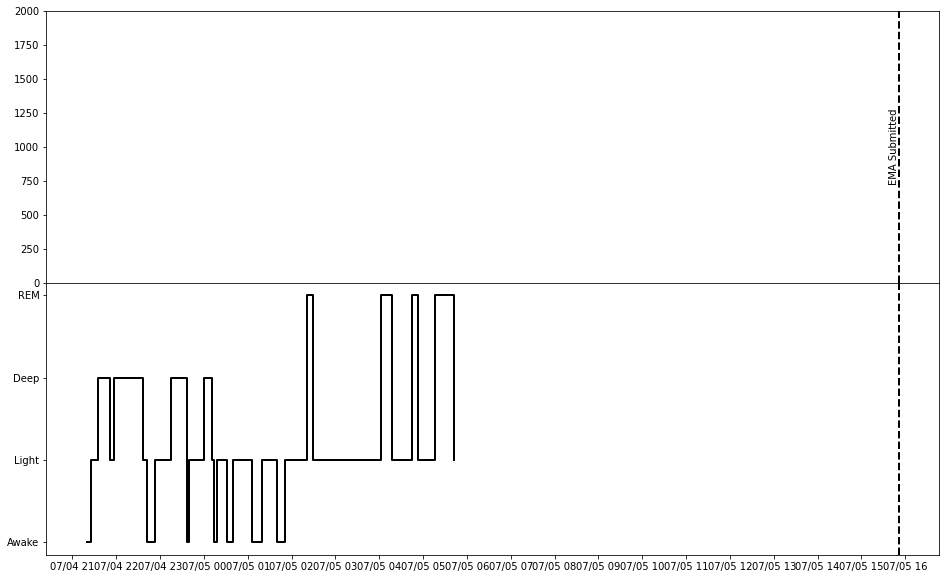

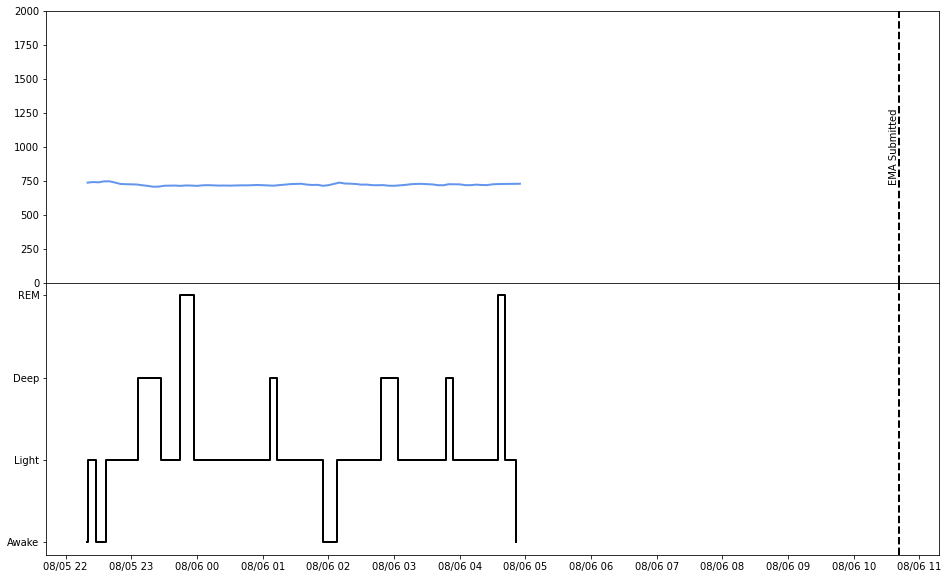

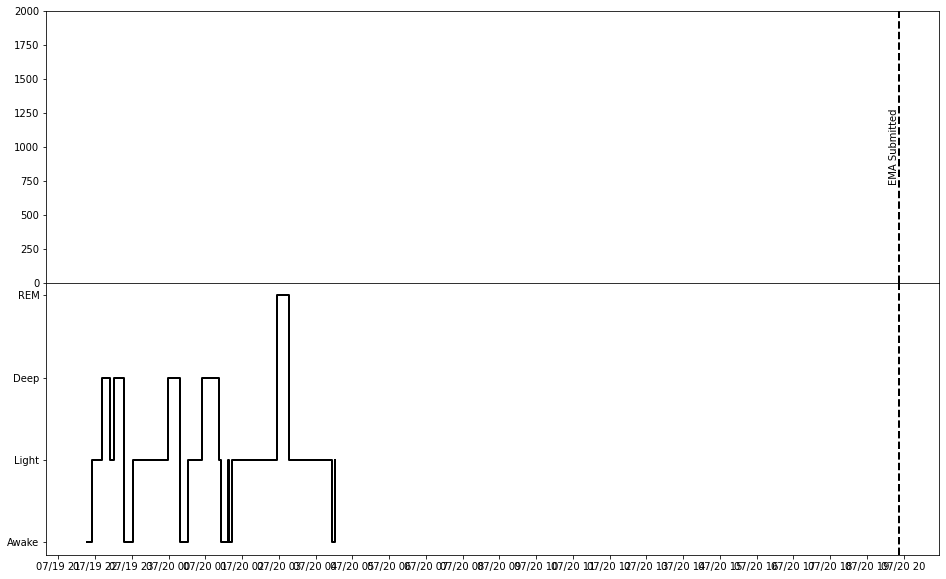

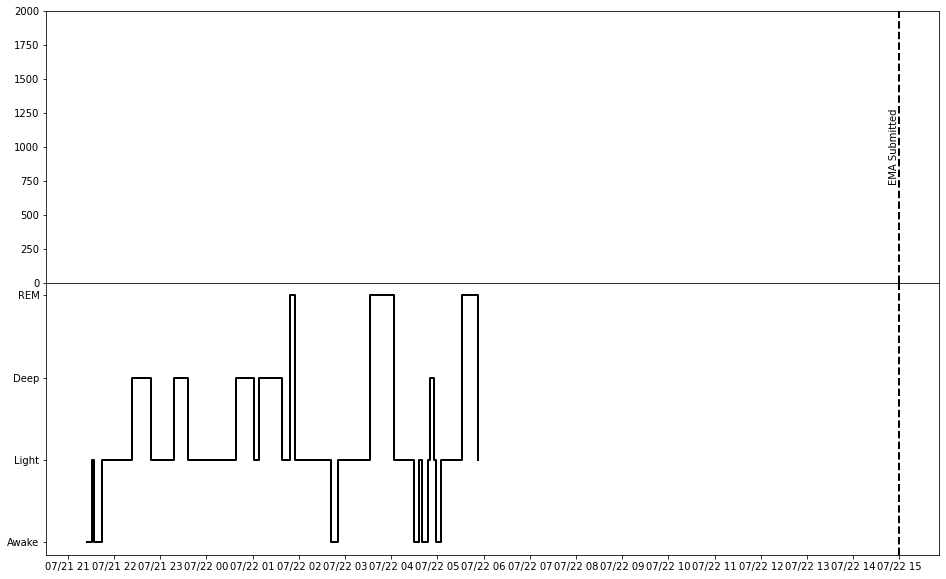

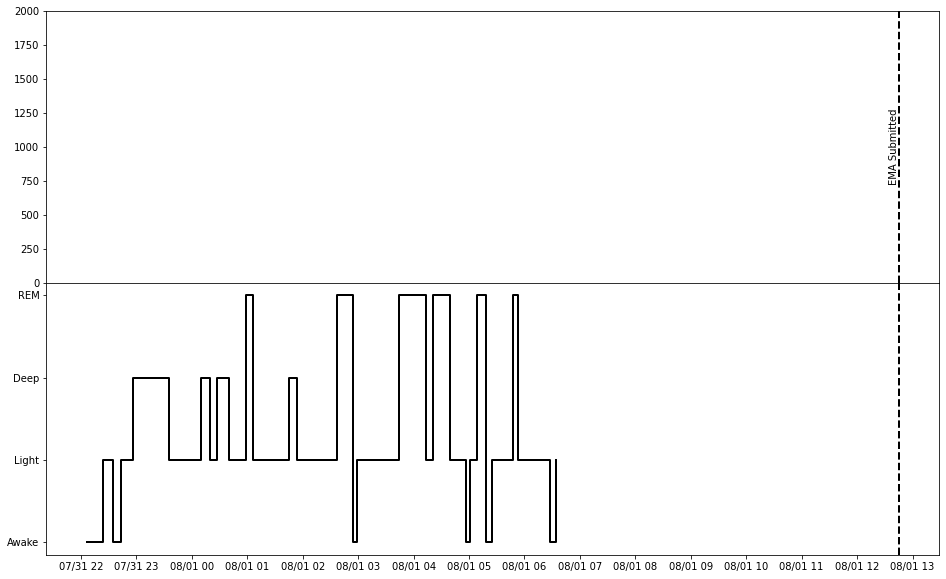

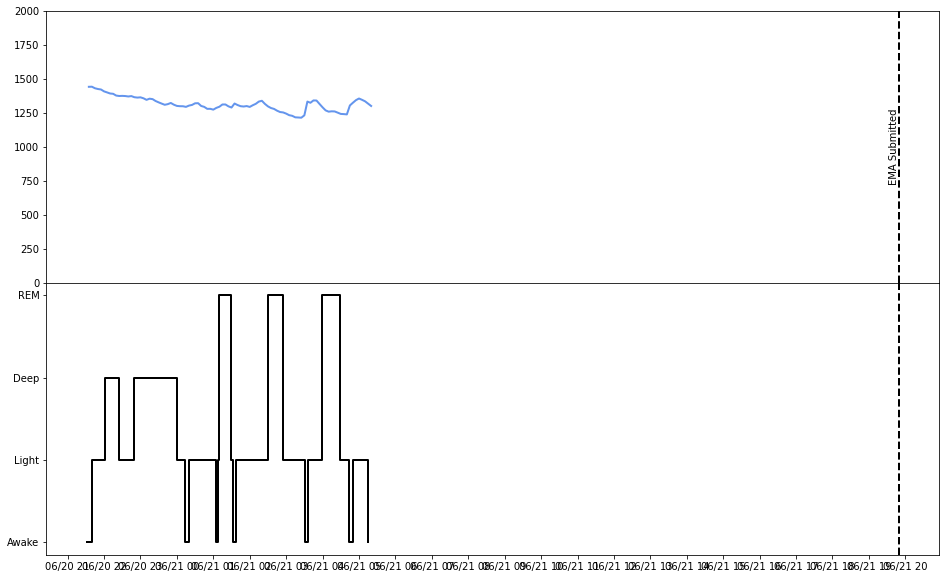

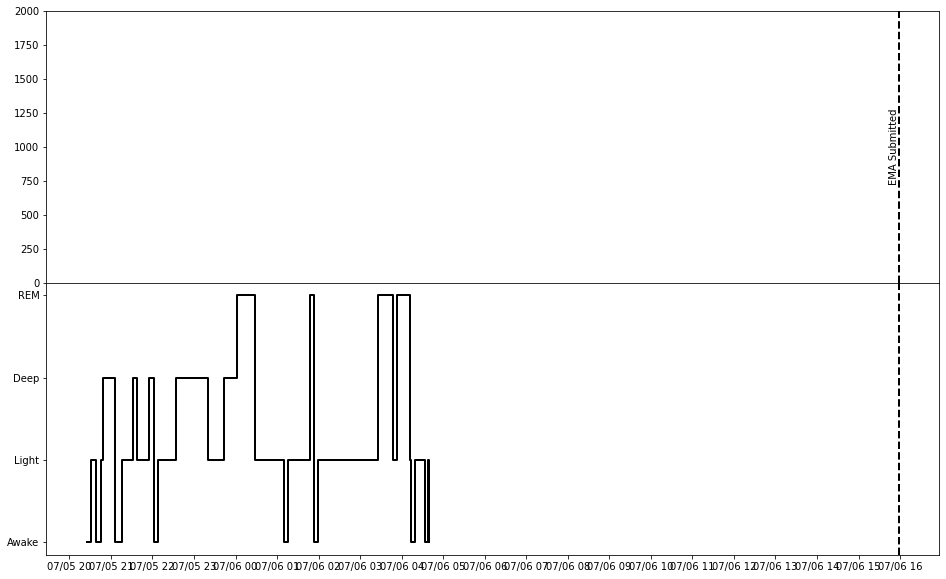

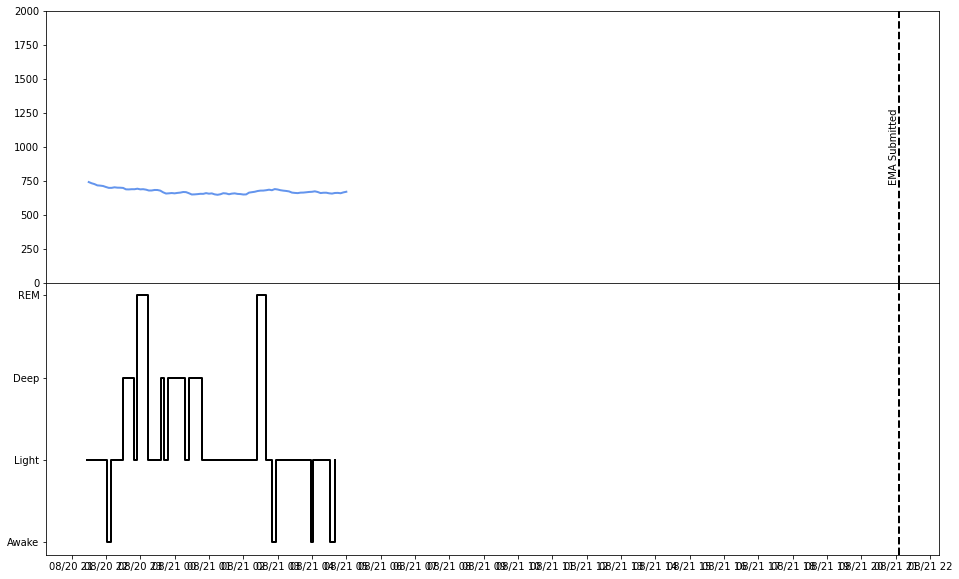

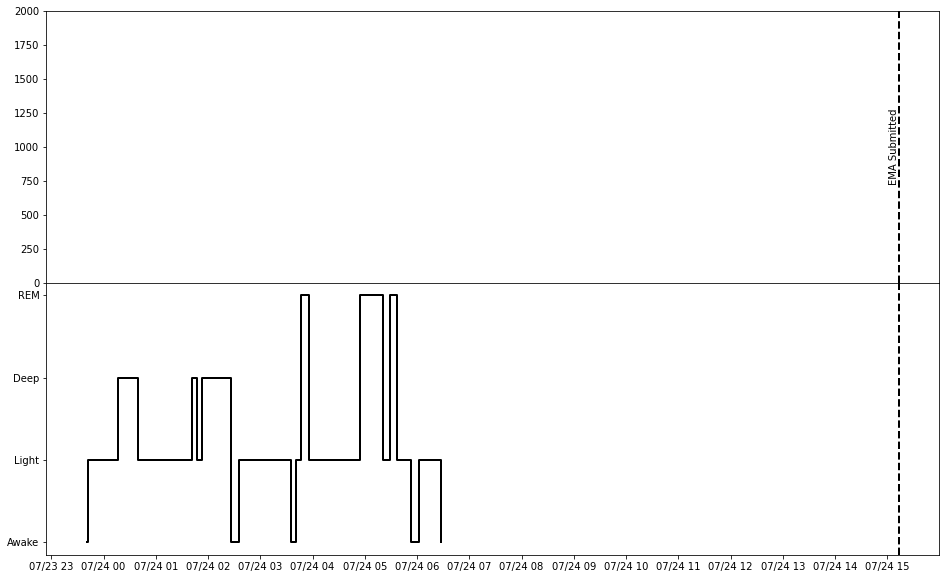

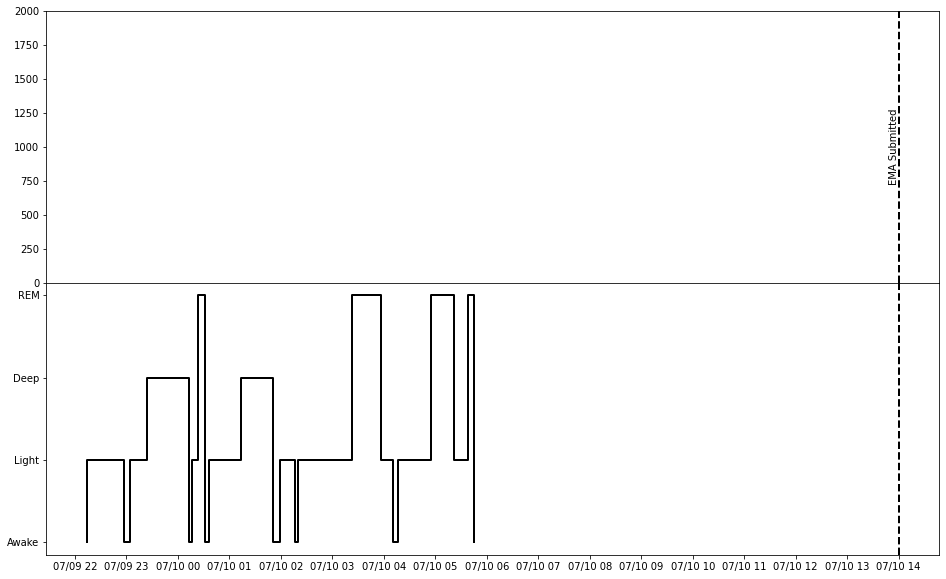

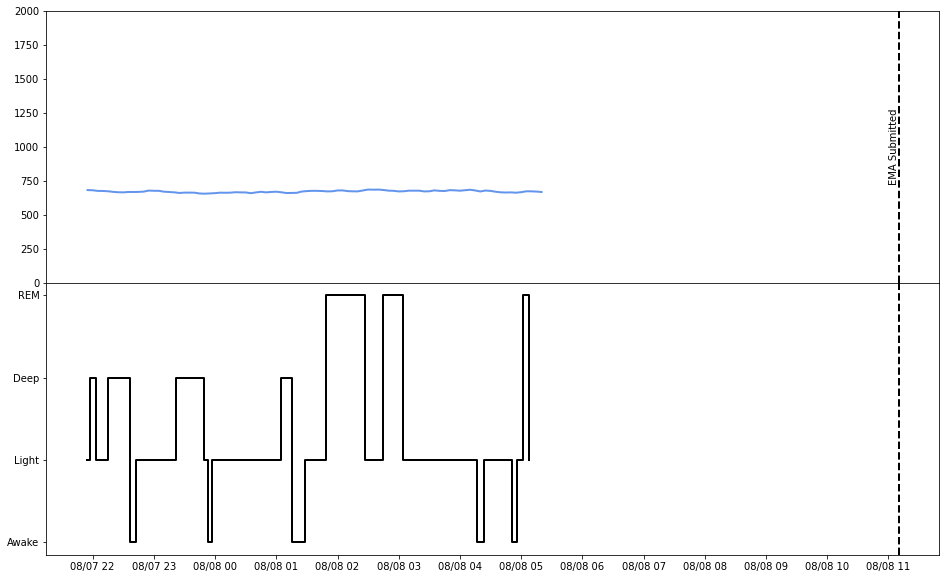

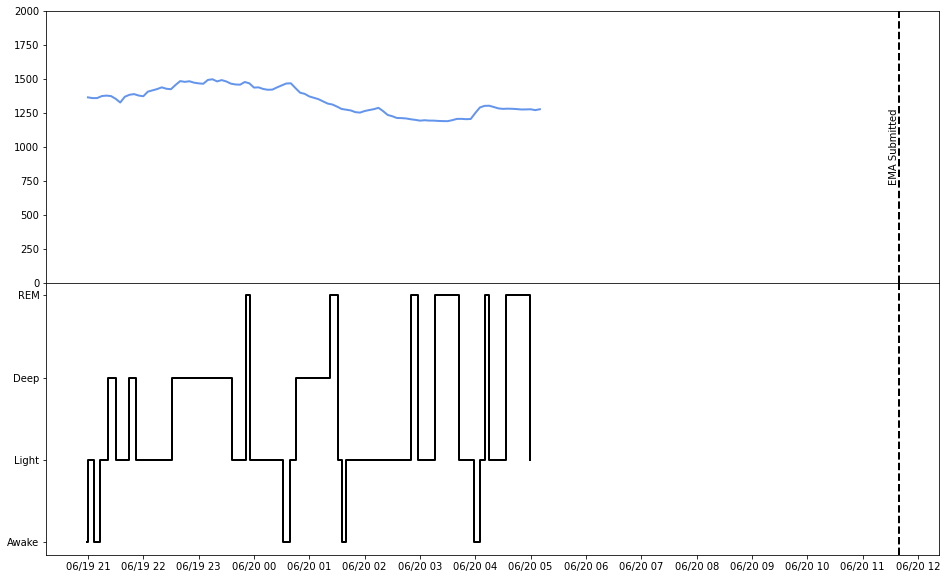

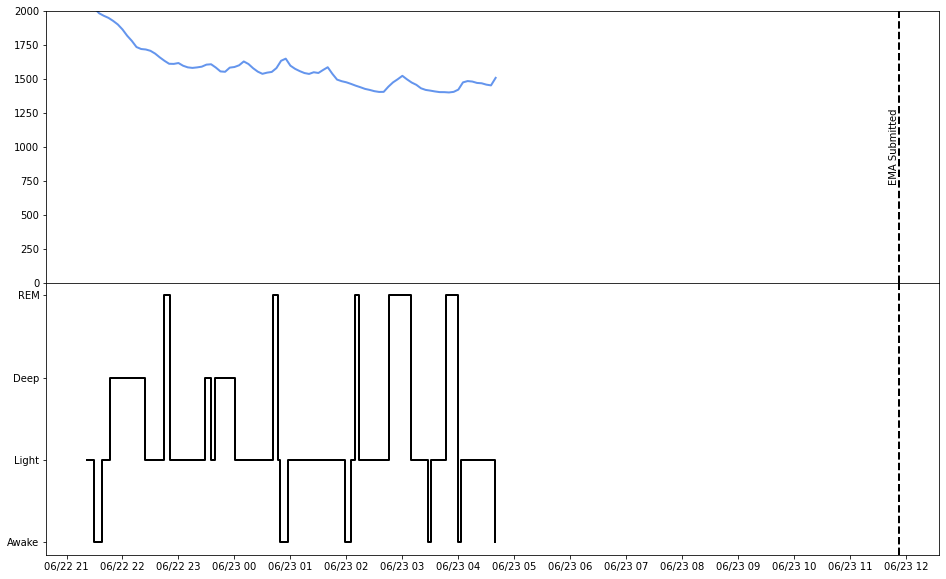

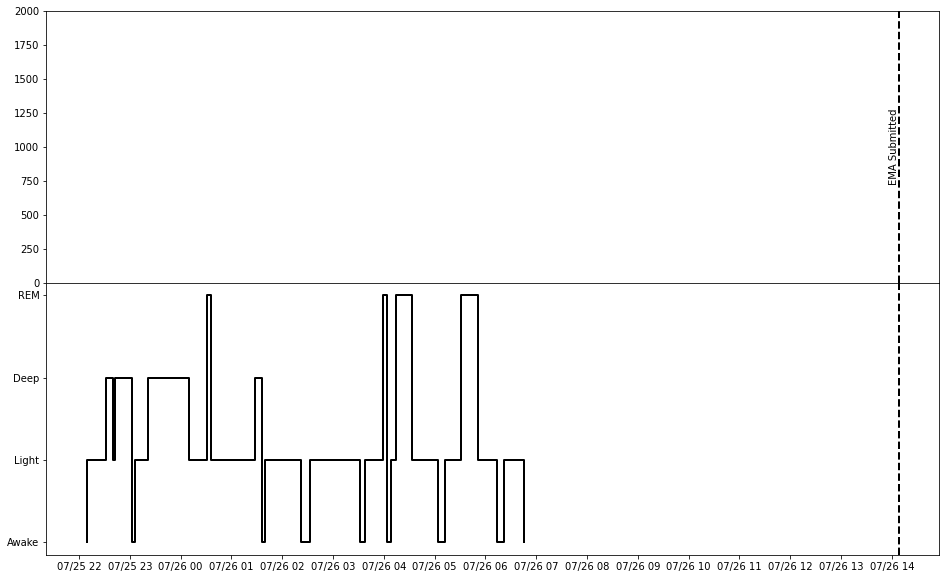

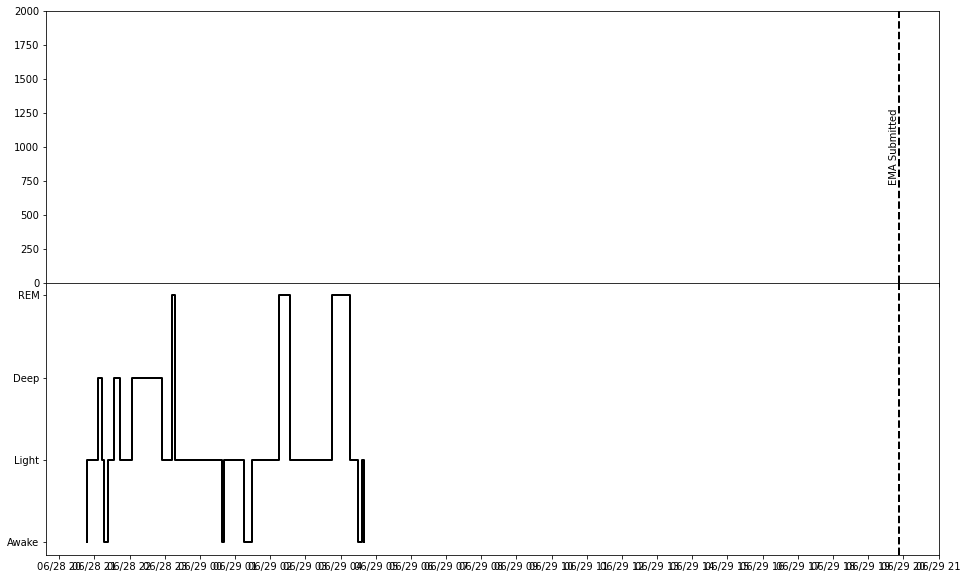

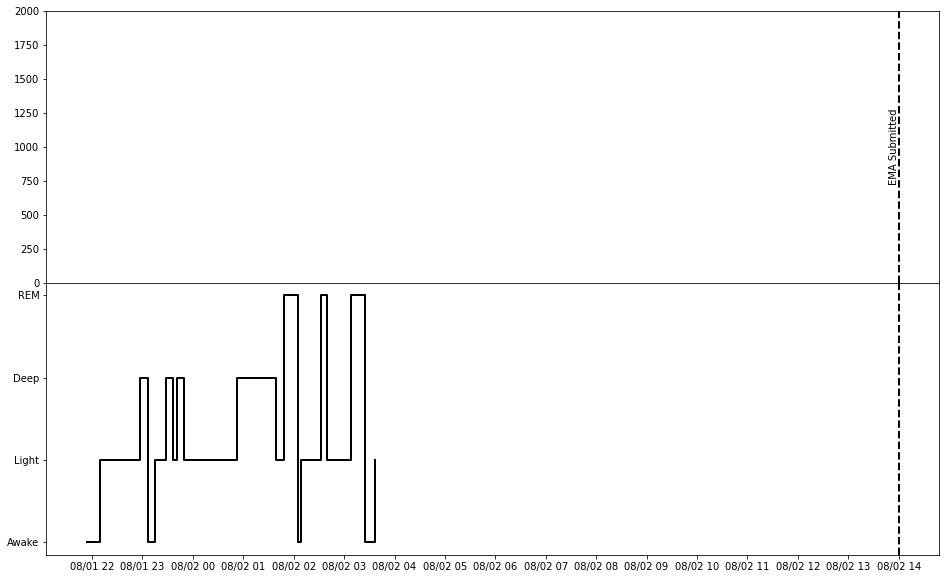

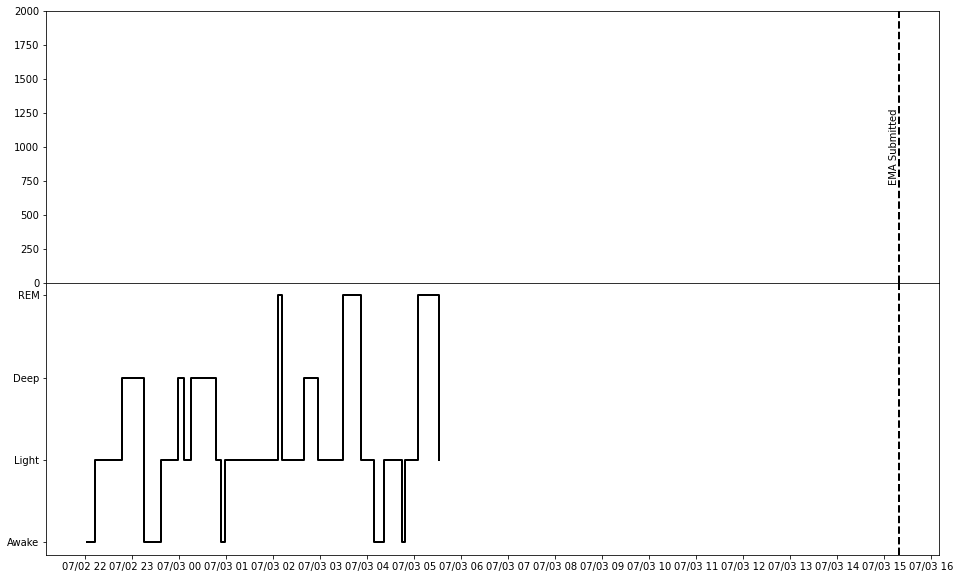

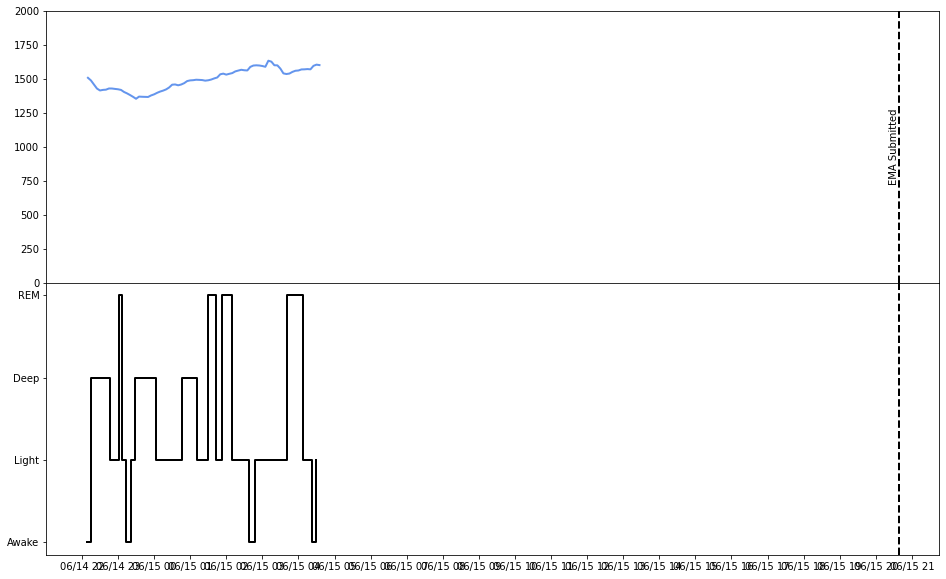

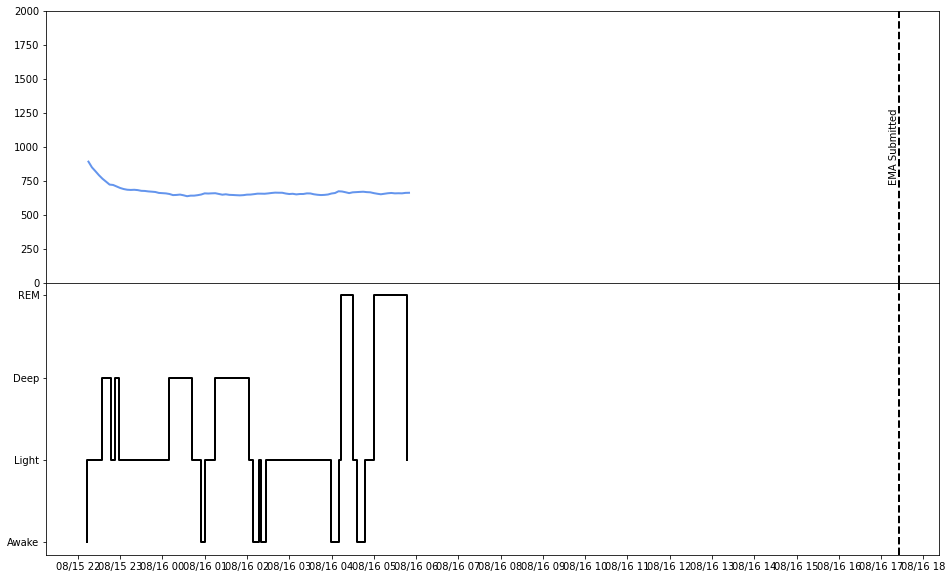

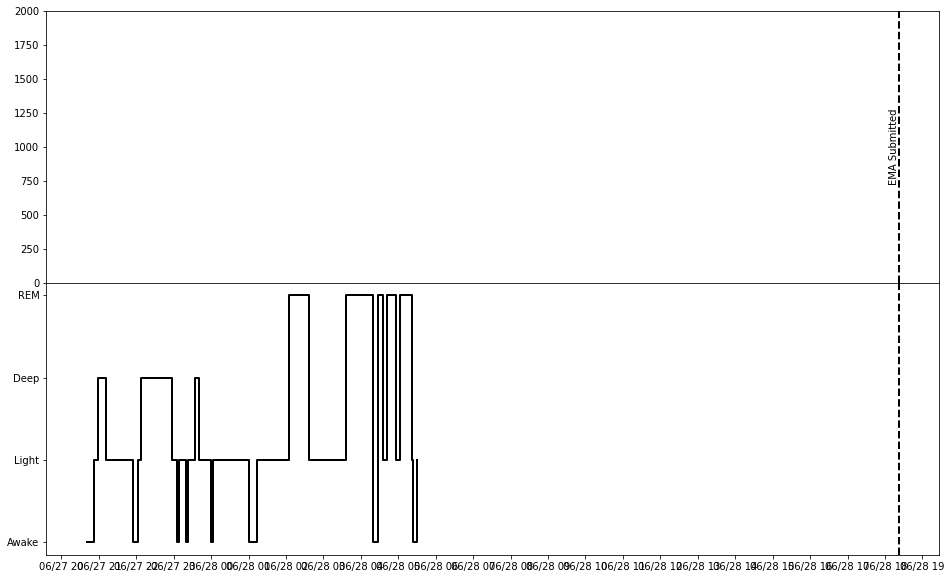

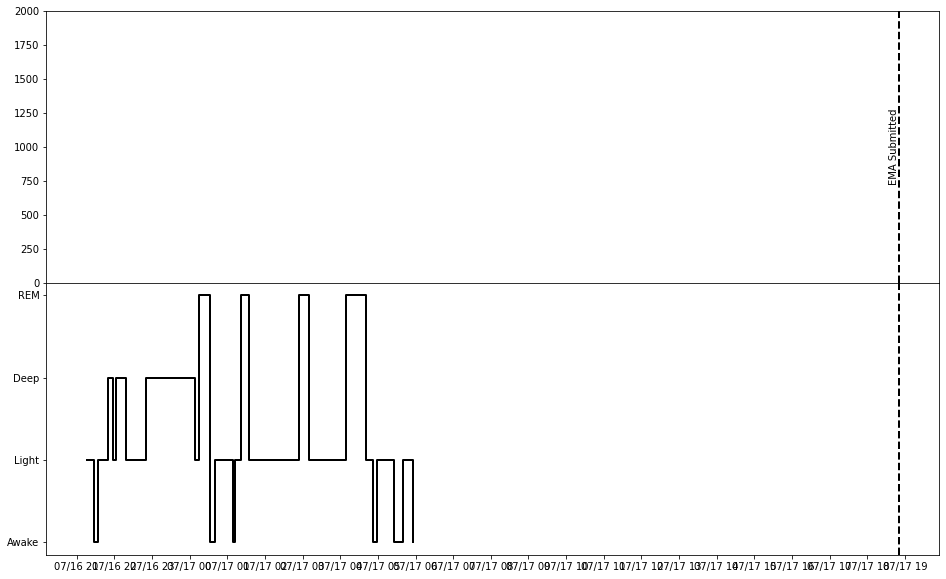

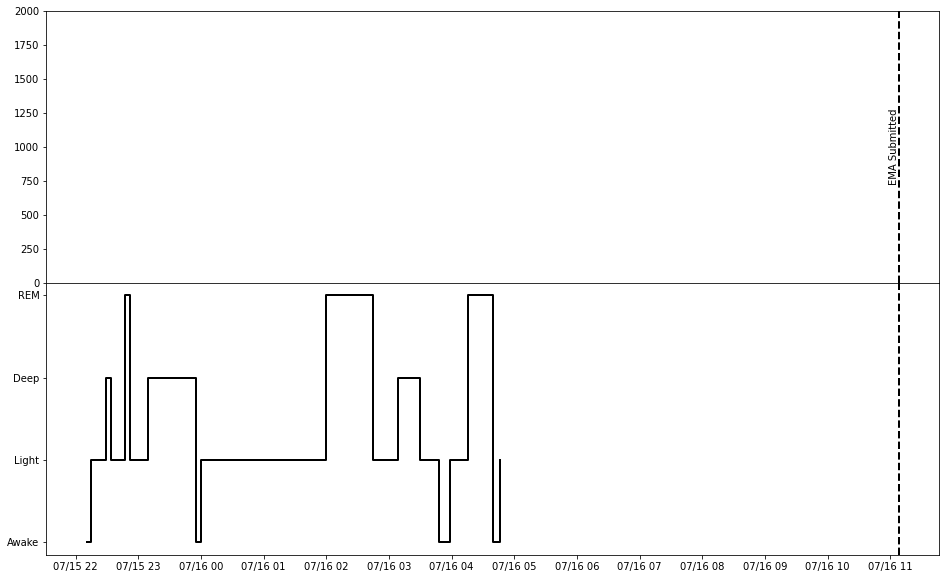

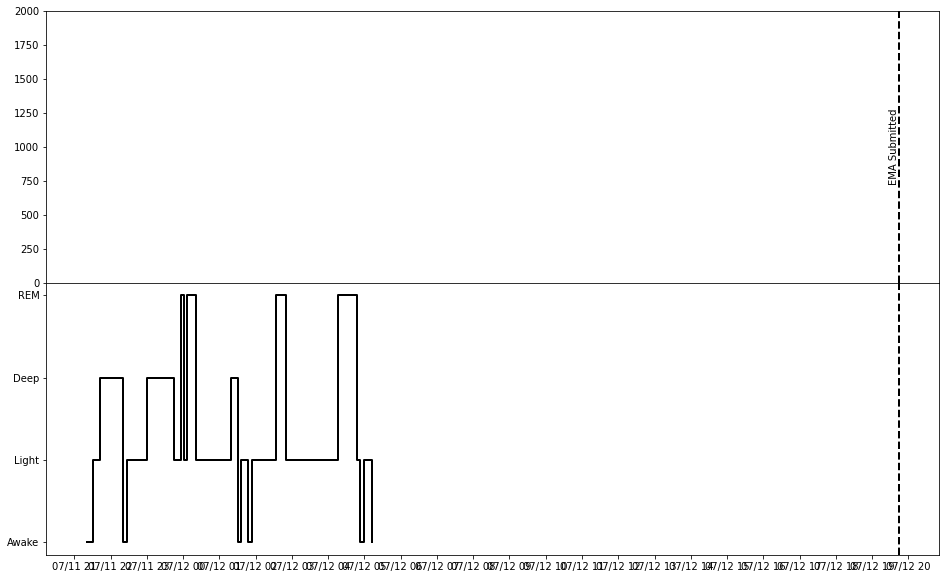

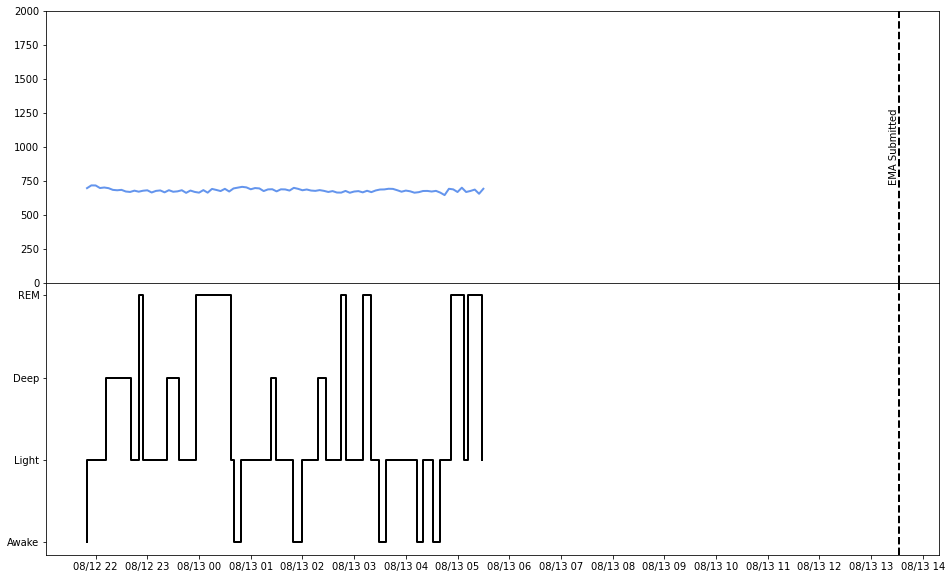

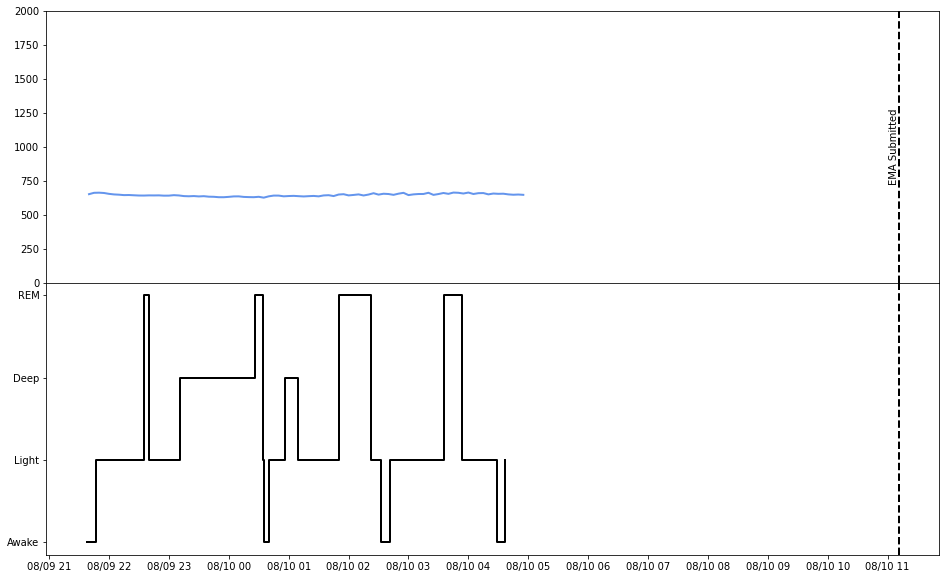

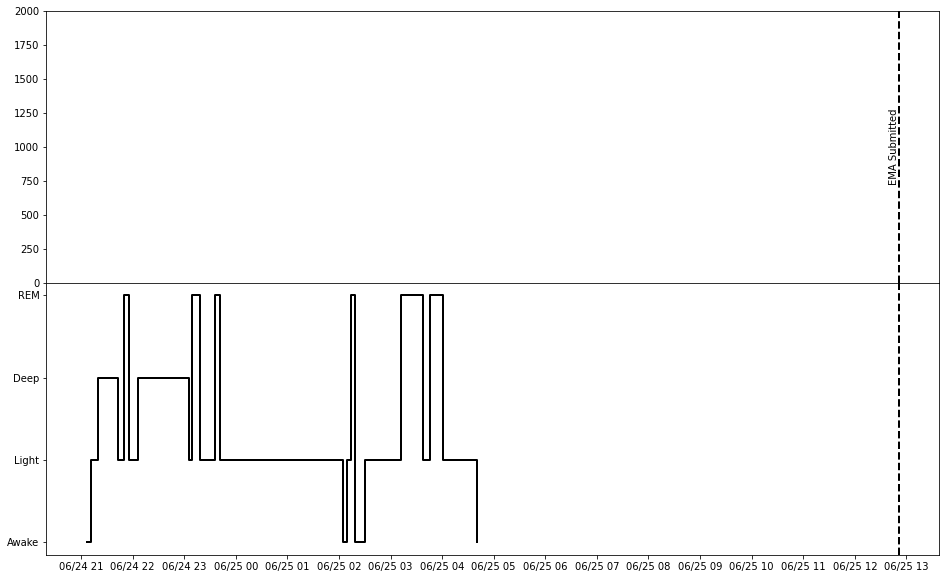

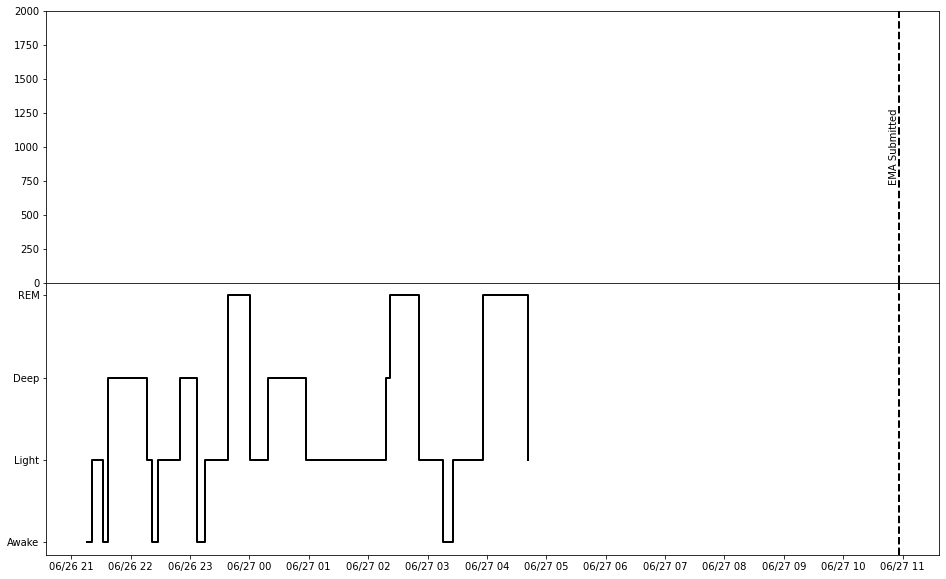

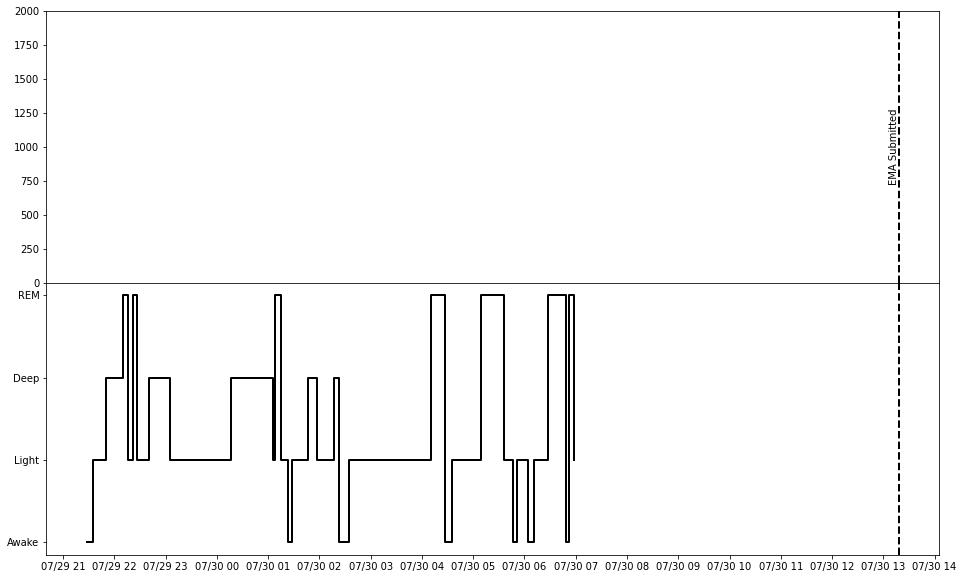

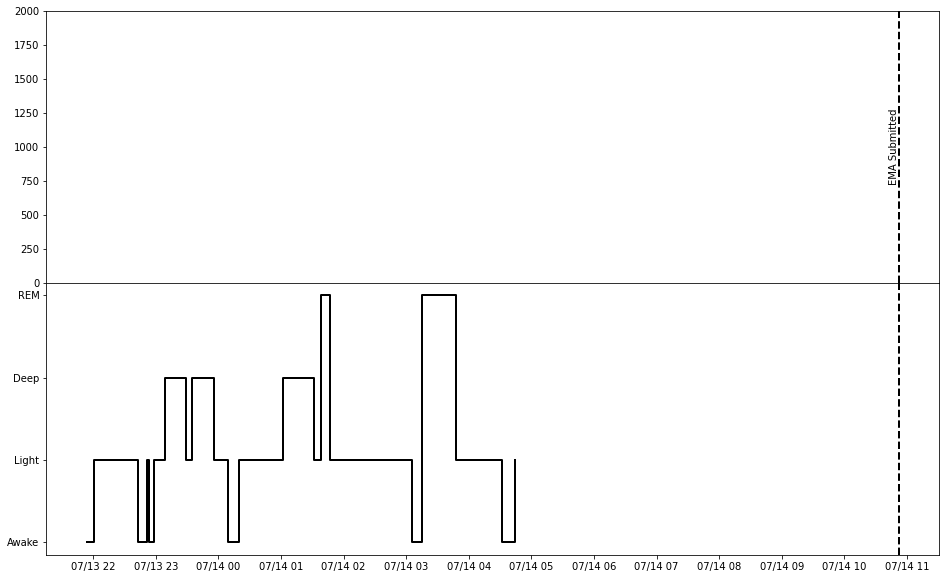

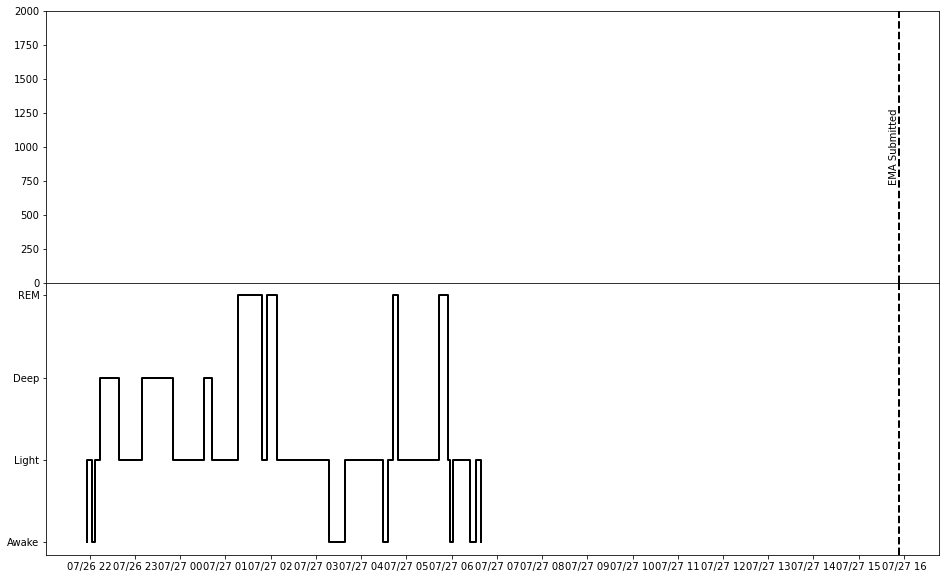

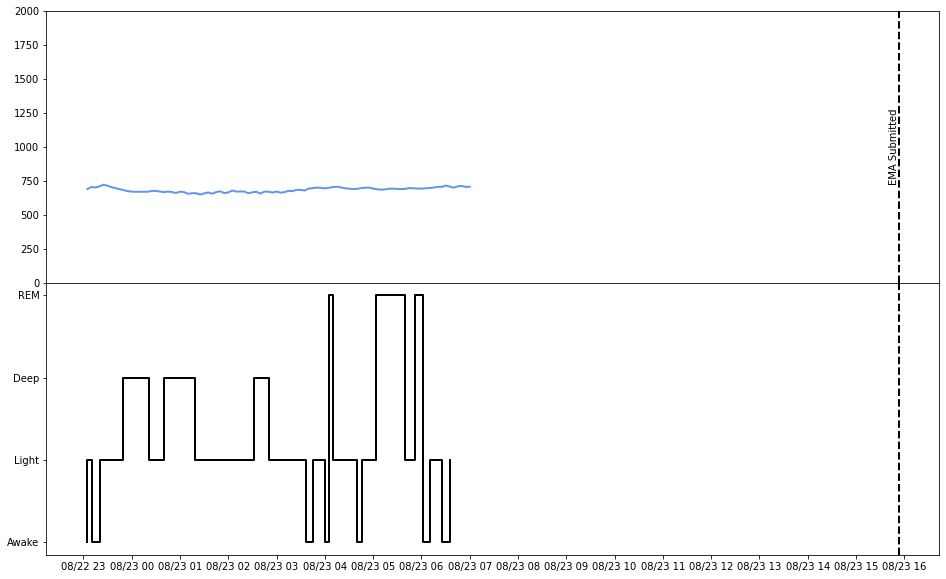

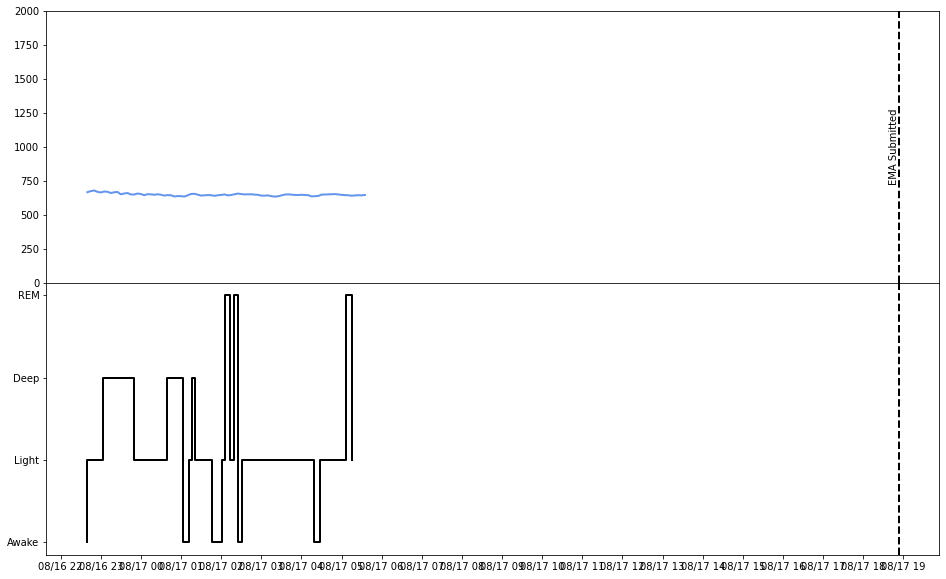

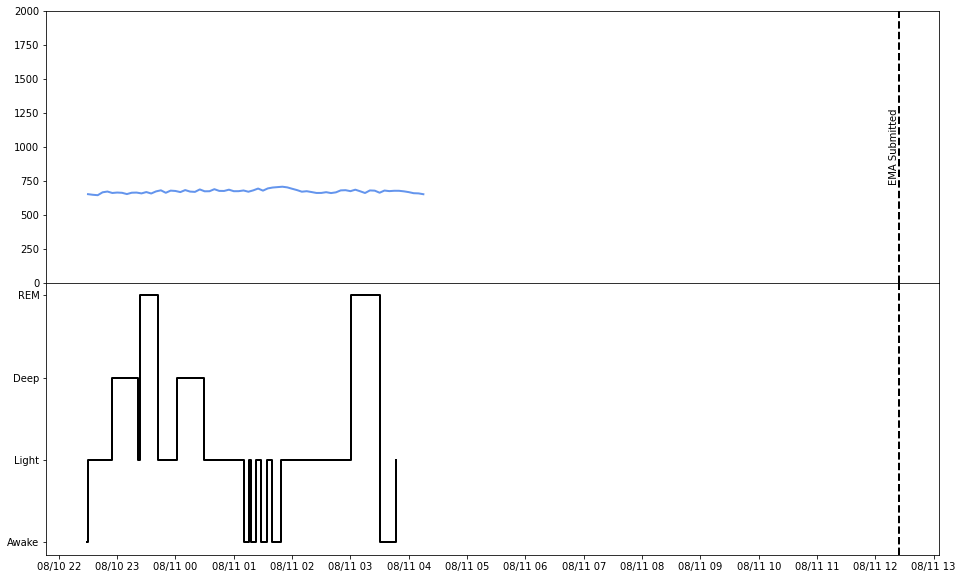

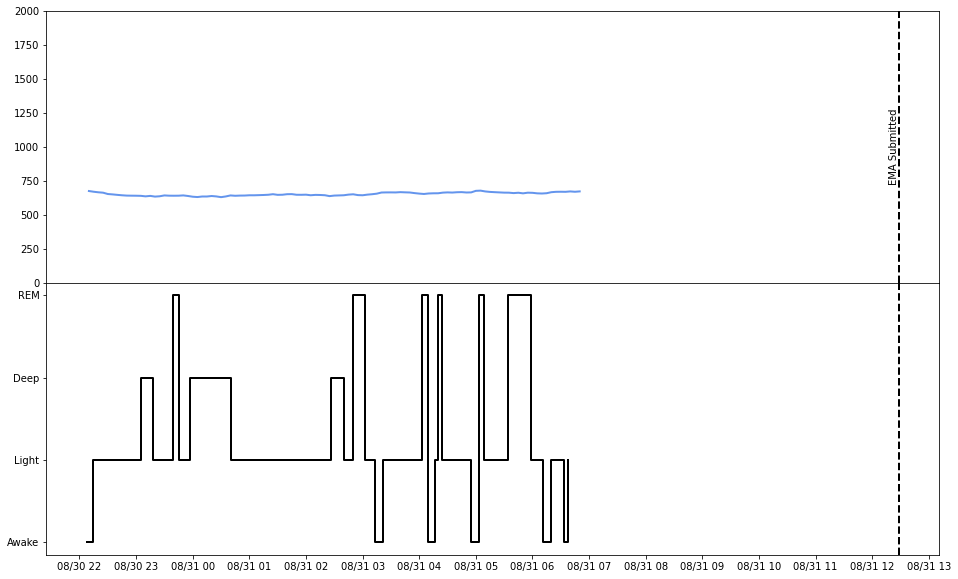

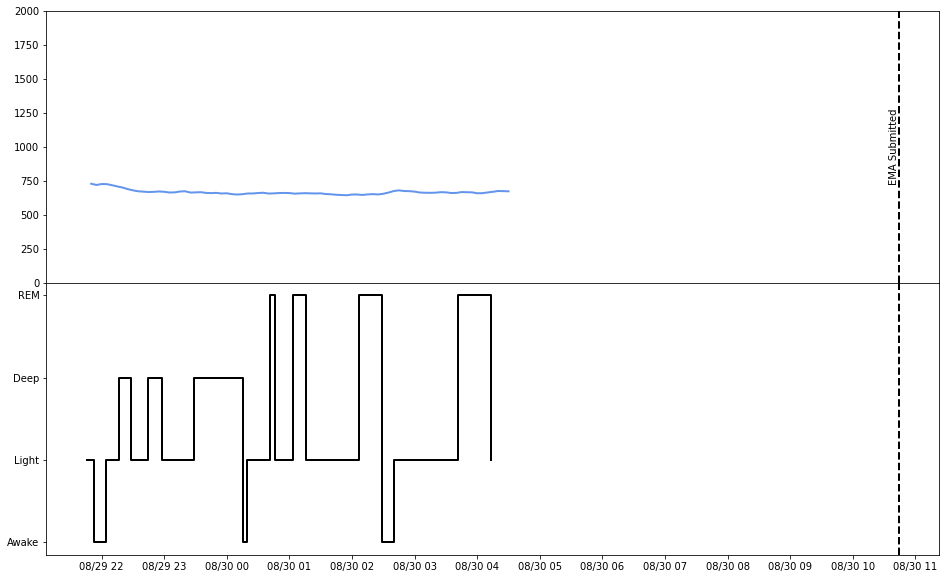

hxj6brwj


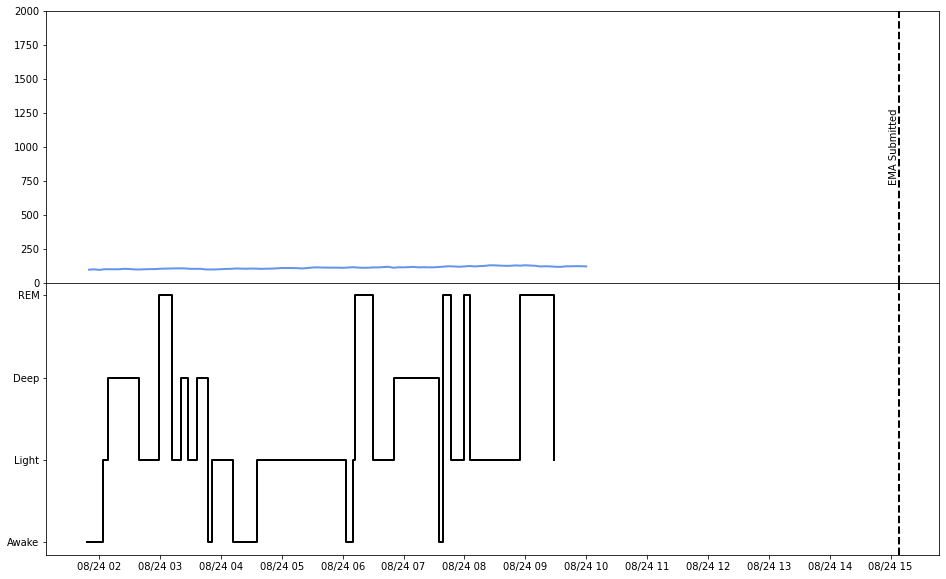

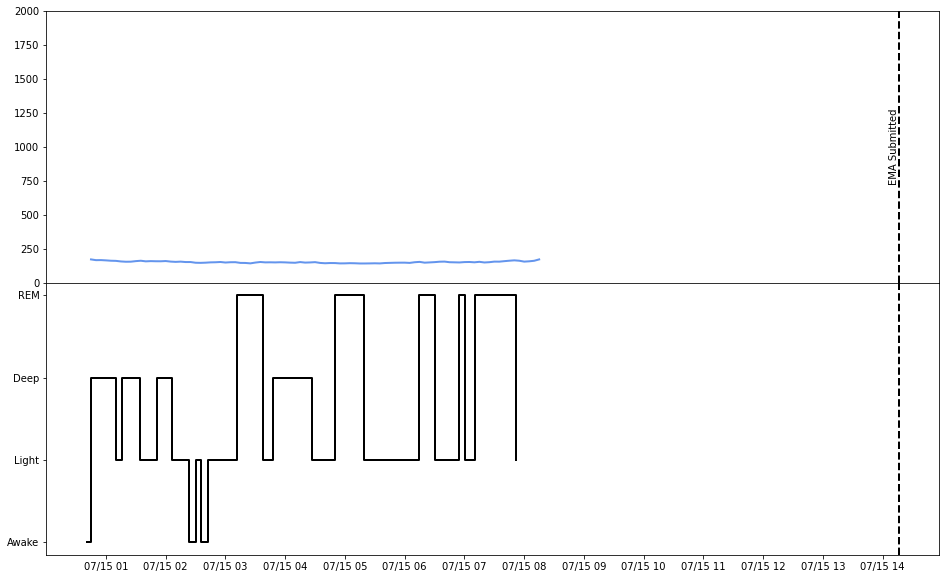

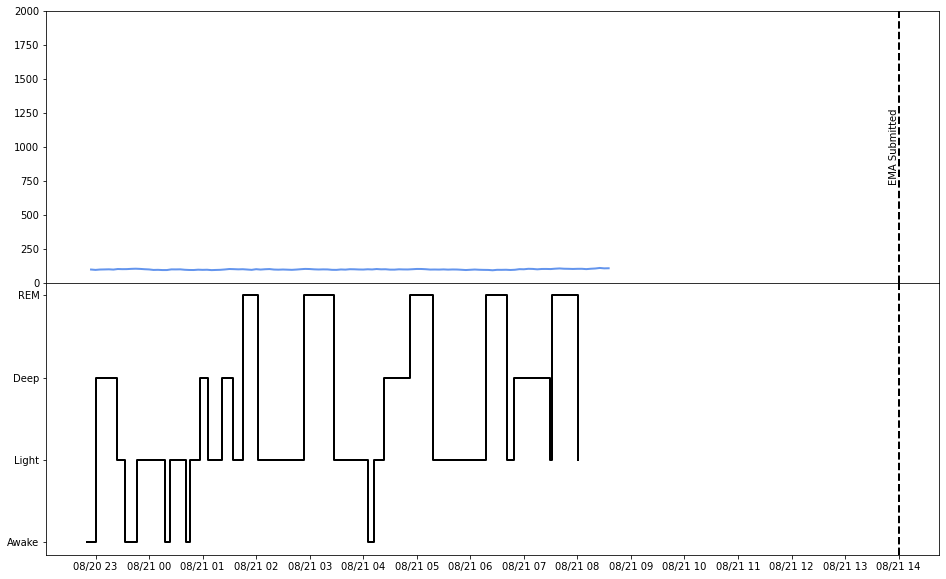

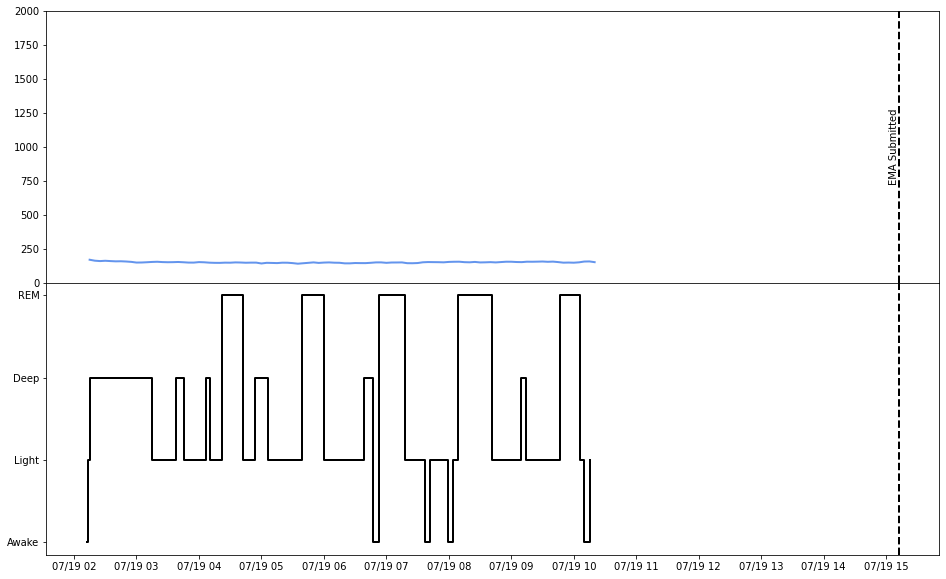

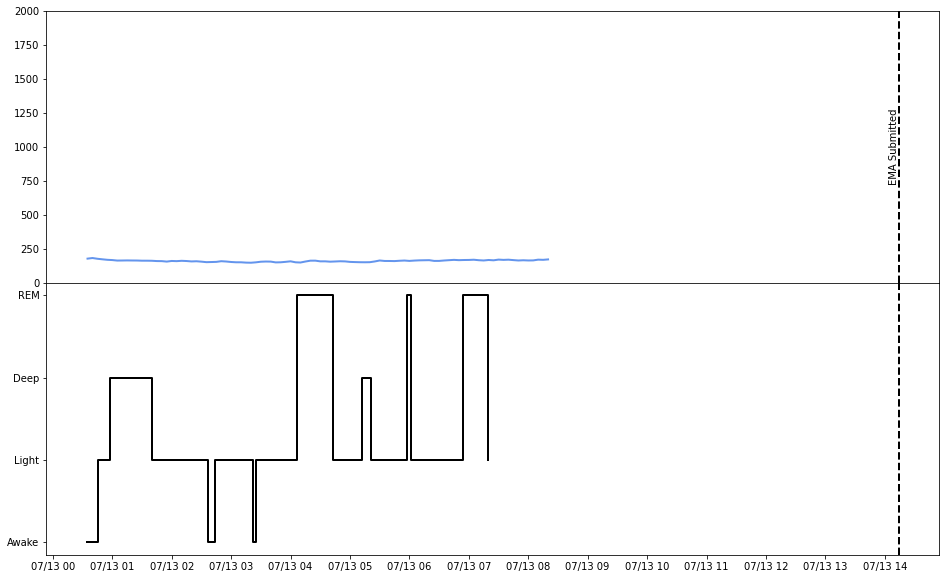

i4w8dx6l


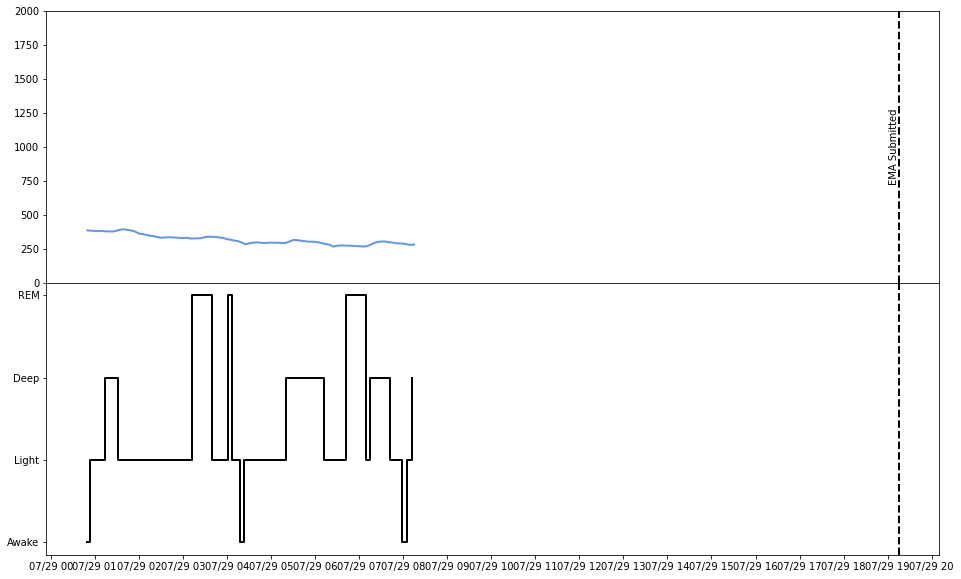

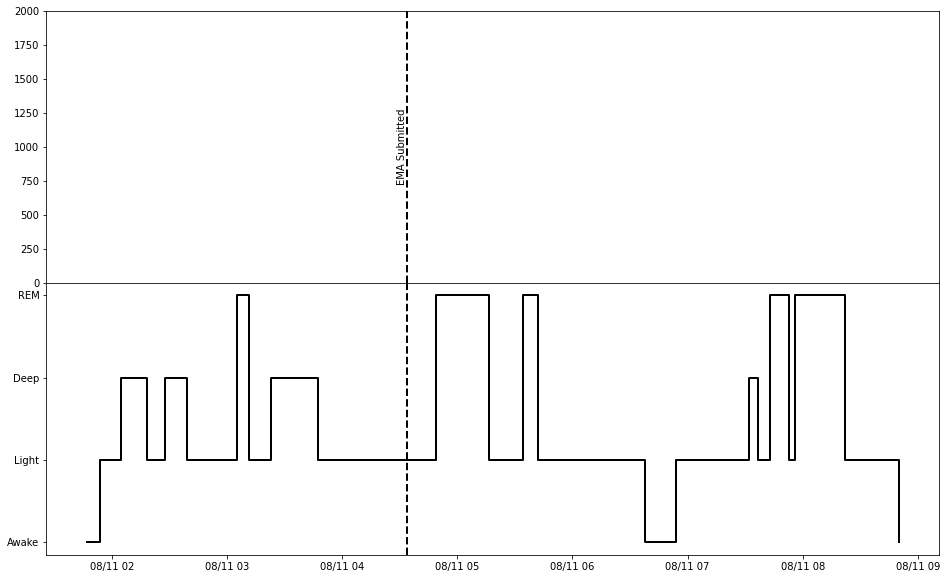

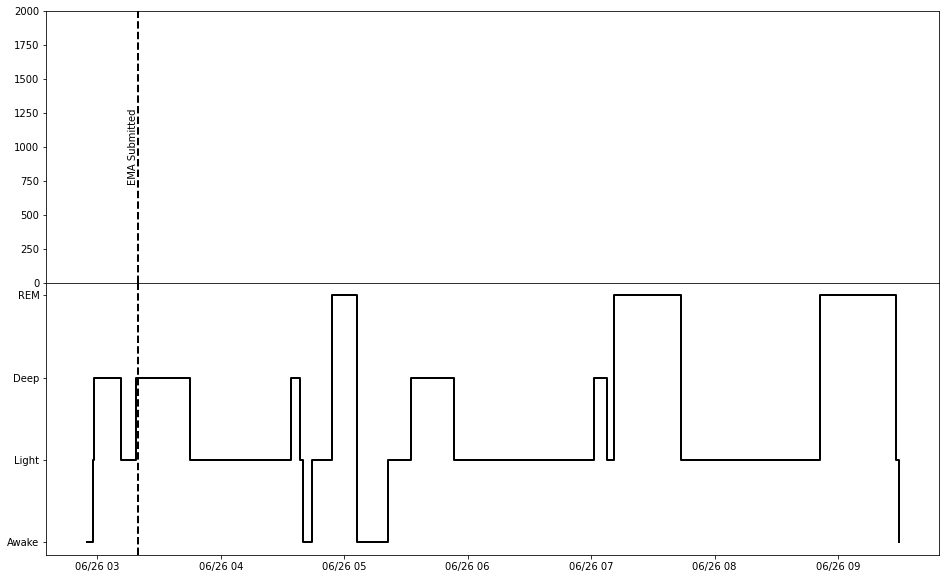

idbkjh8u


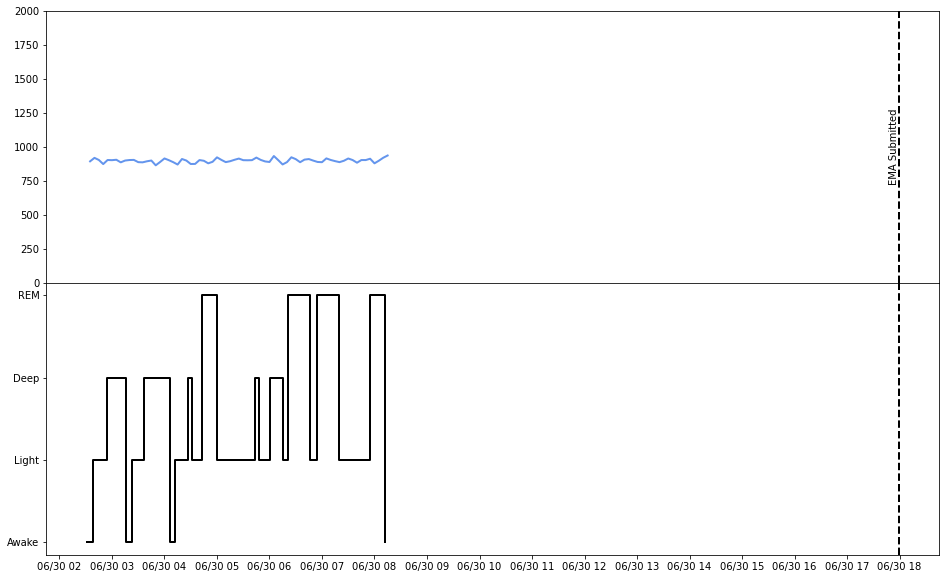

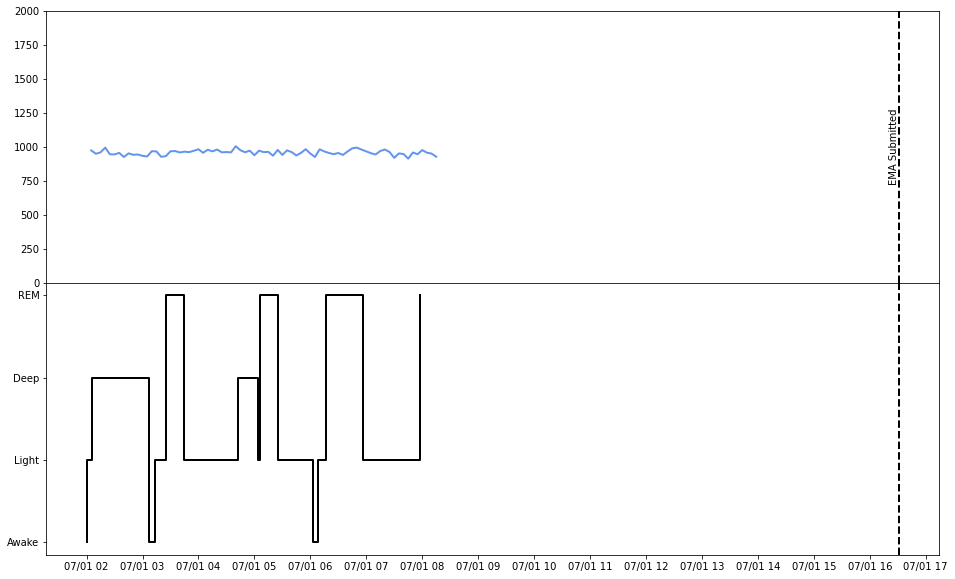

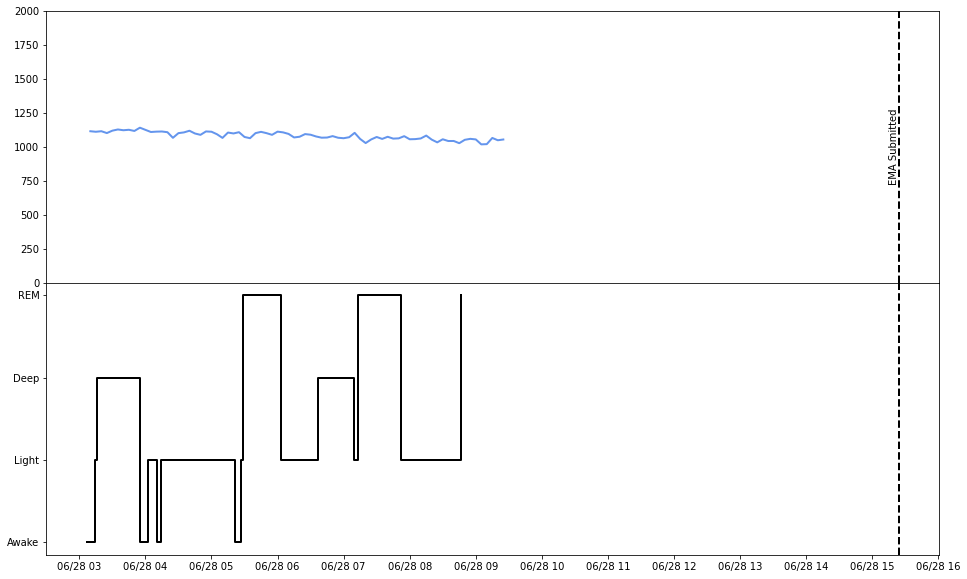

lkkjddam


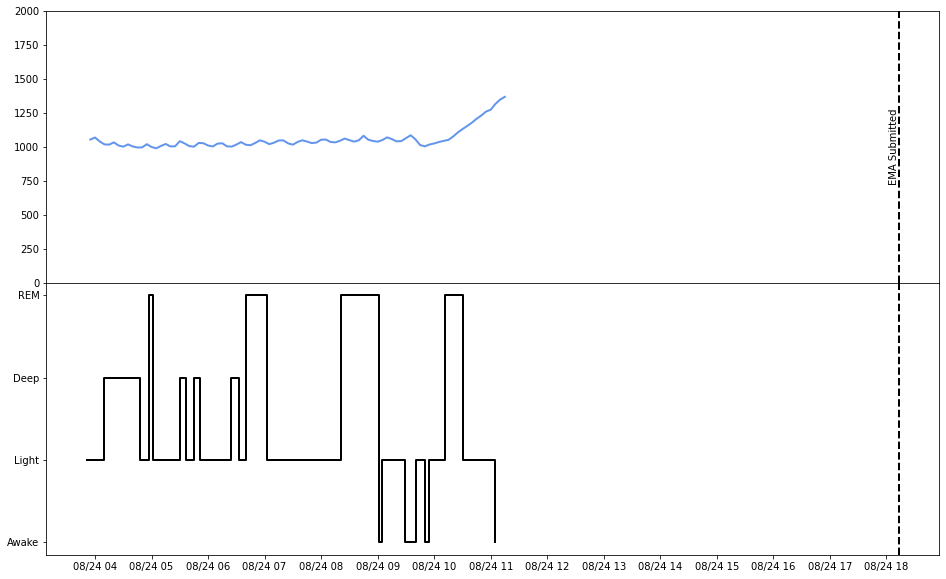

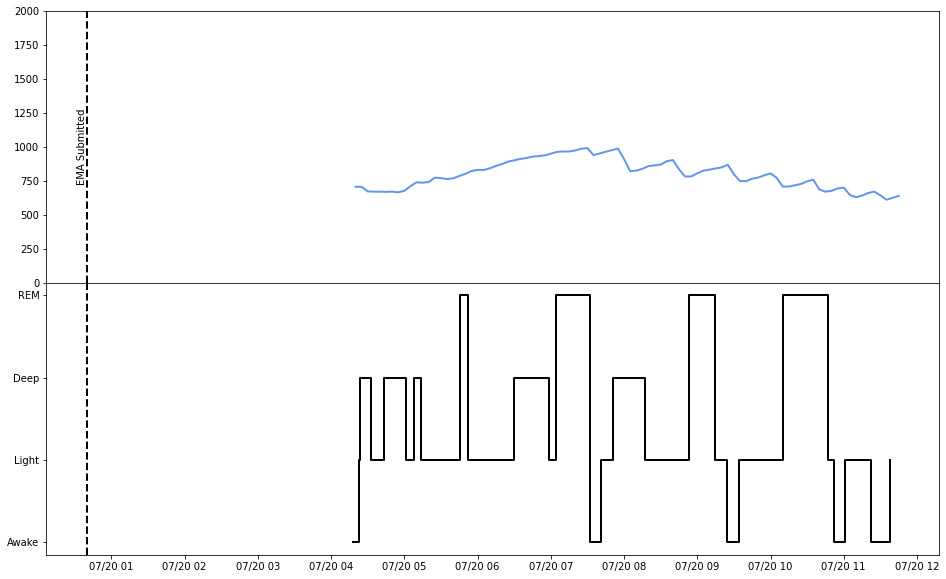

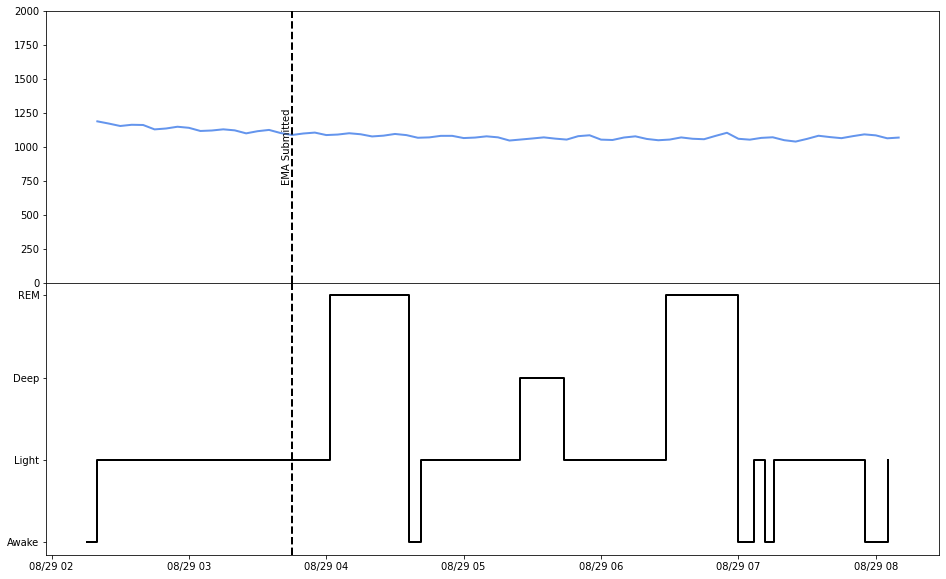

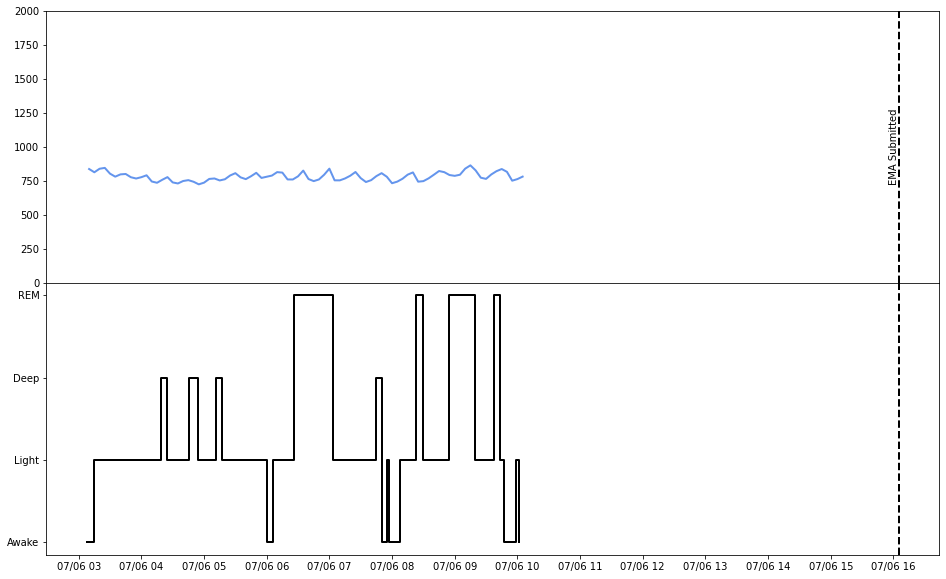

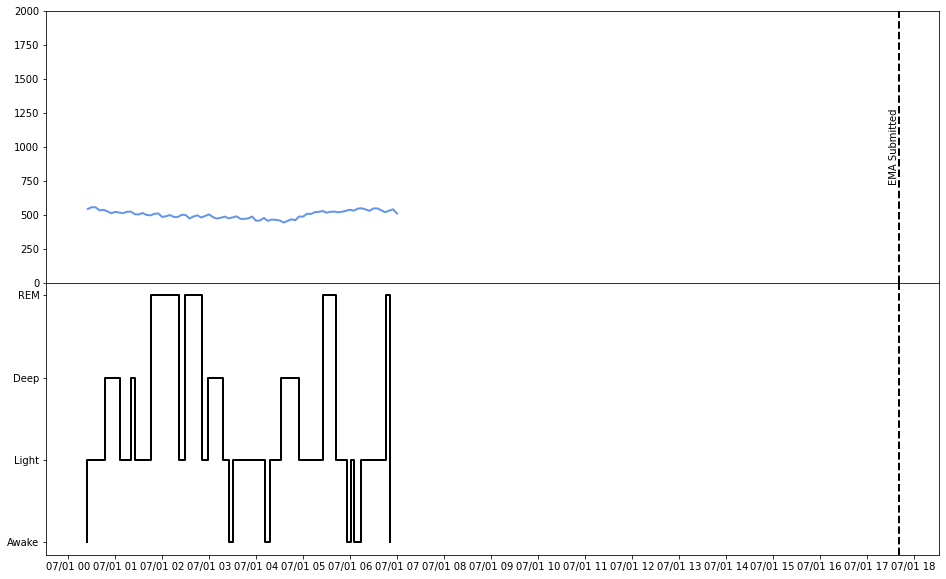

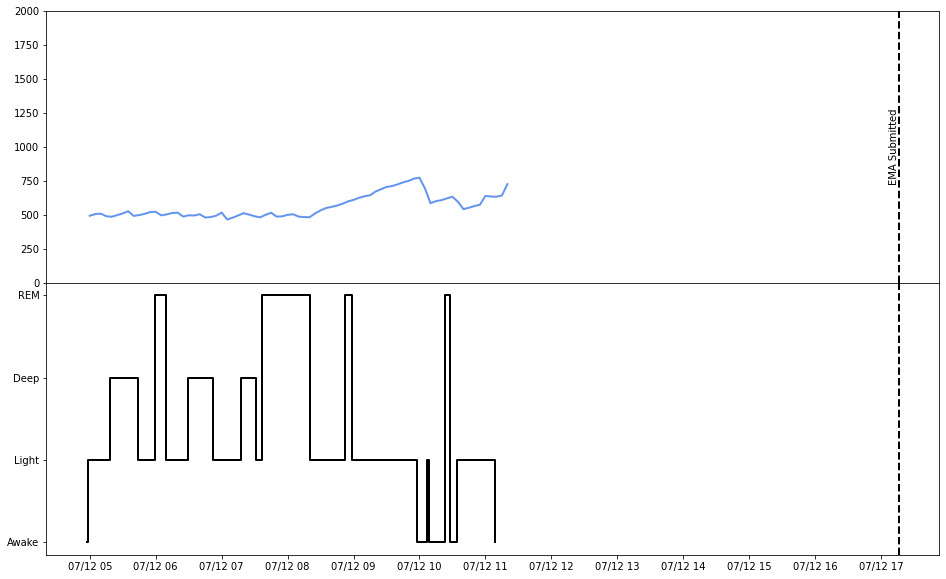

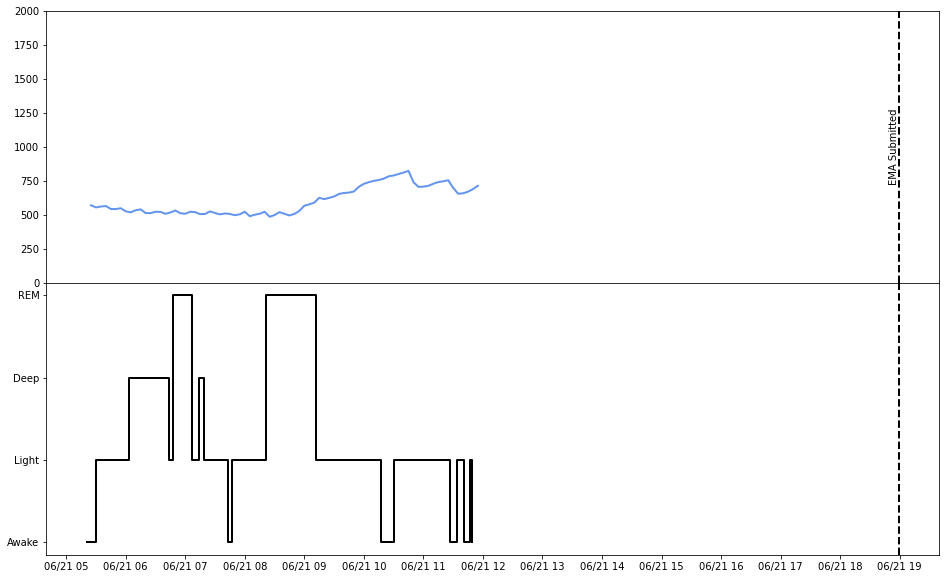

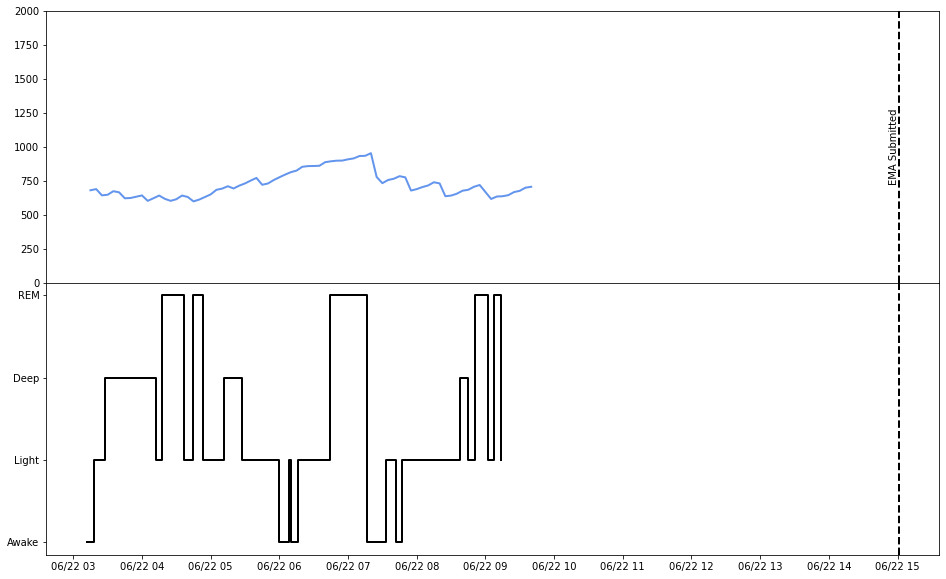

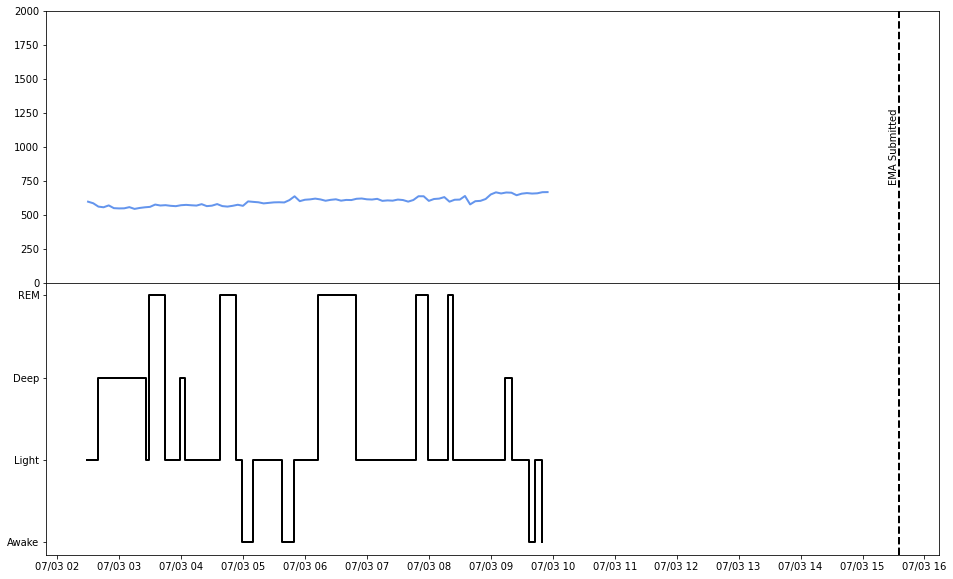

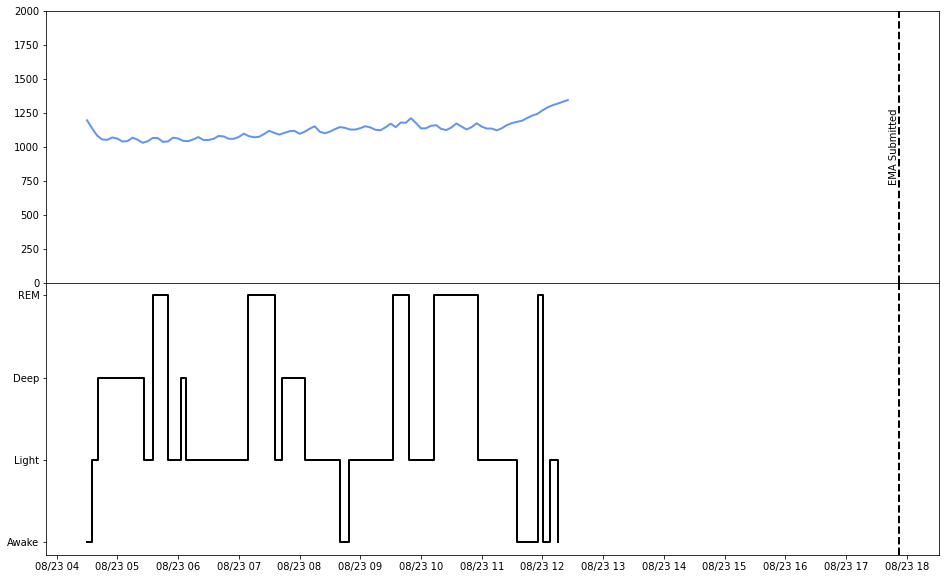

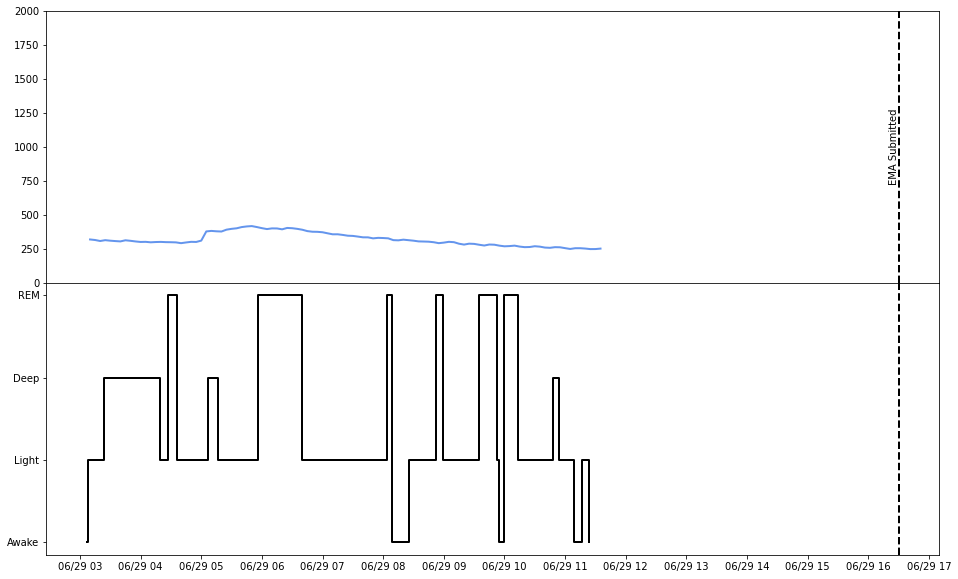

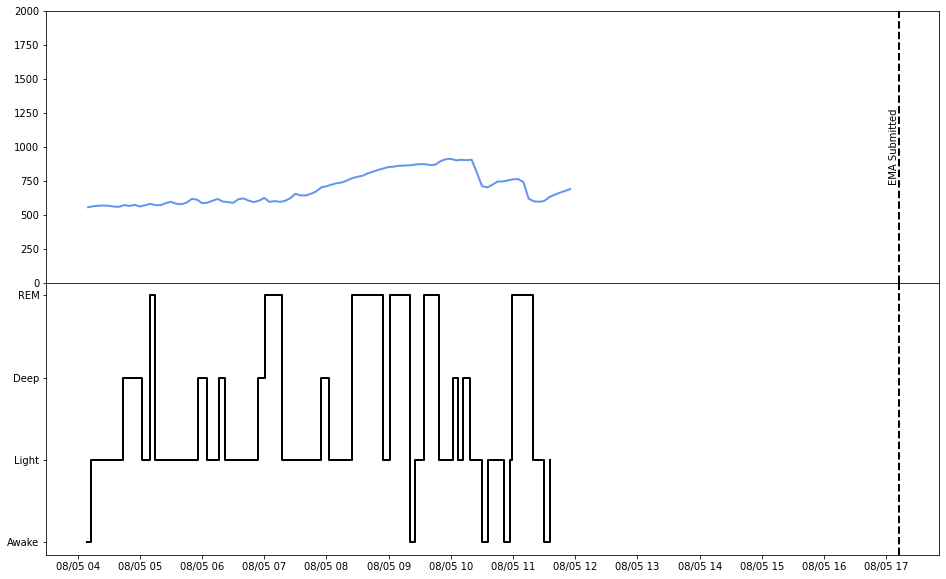

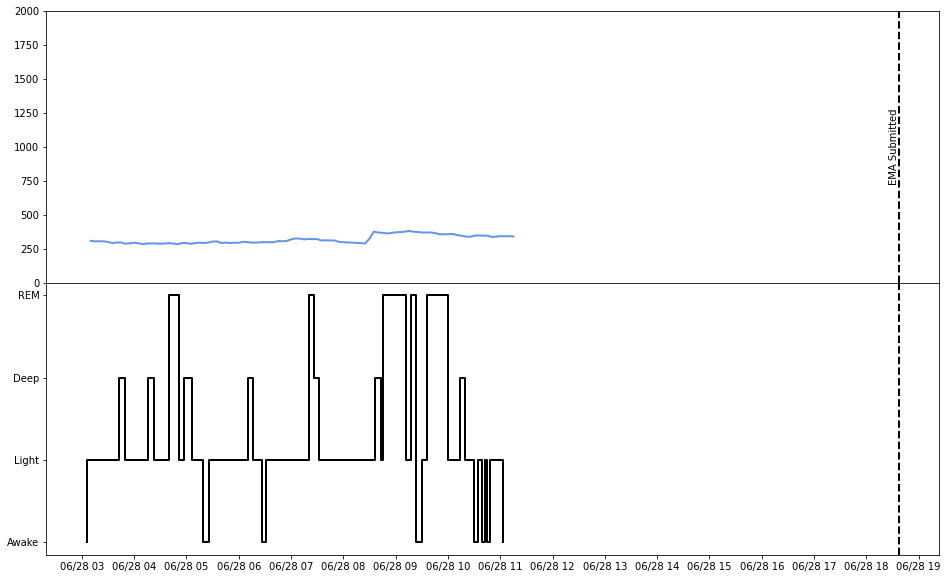

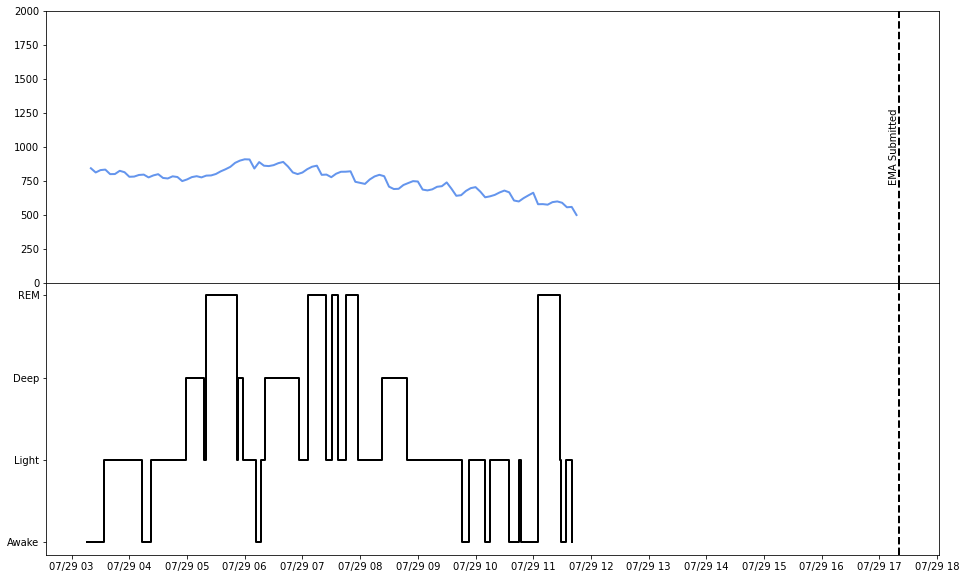

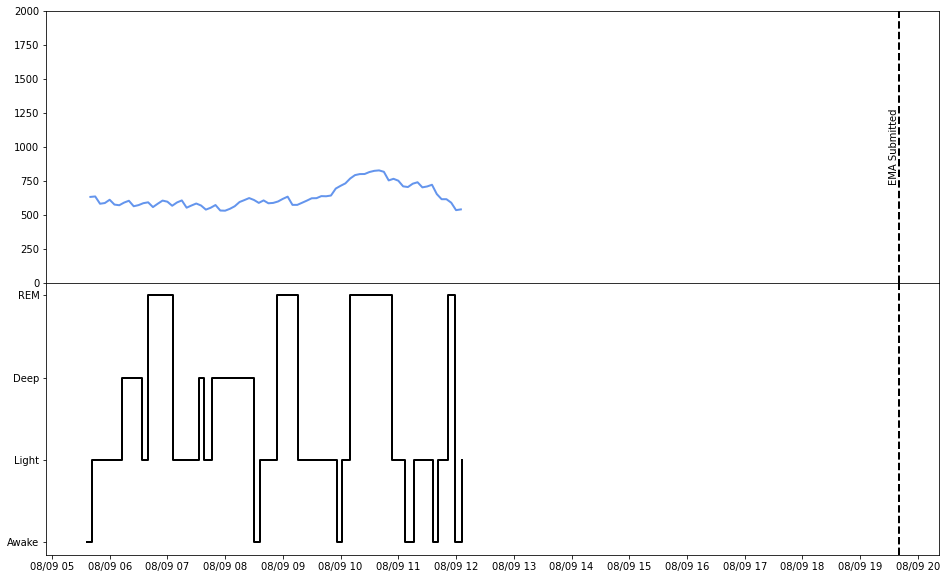

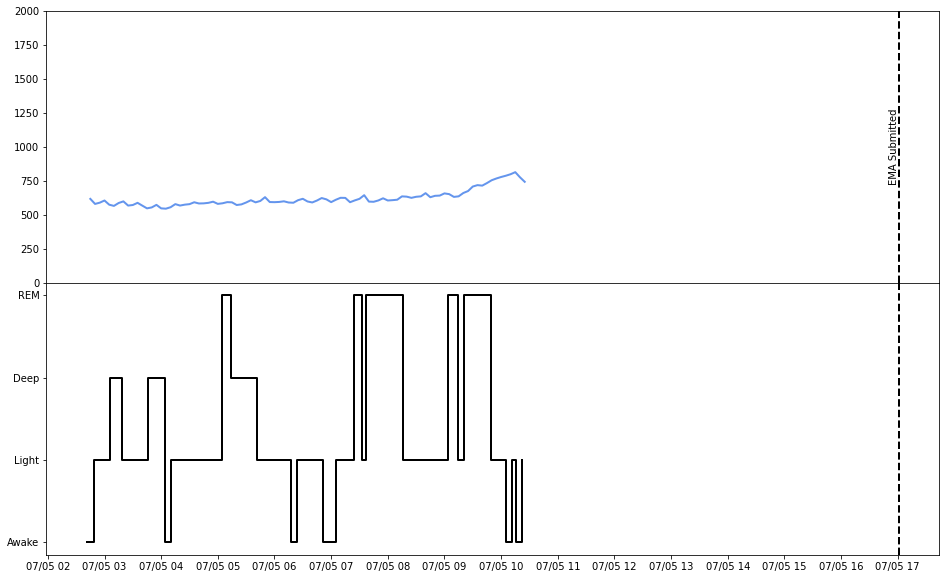

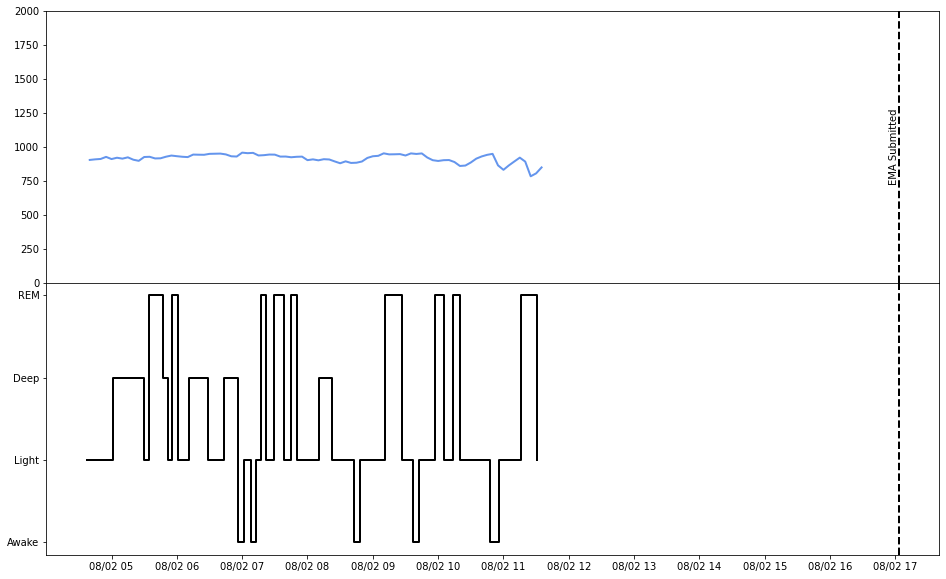

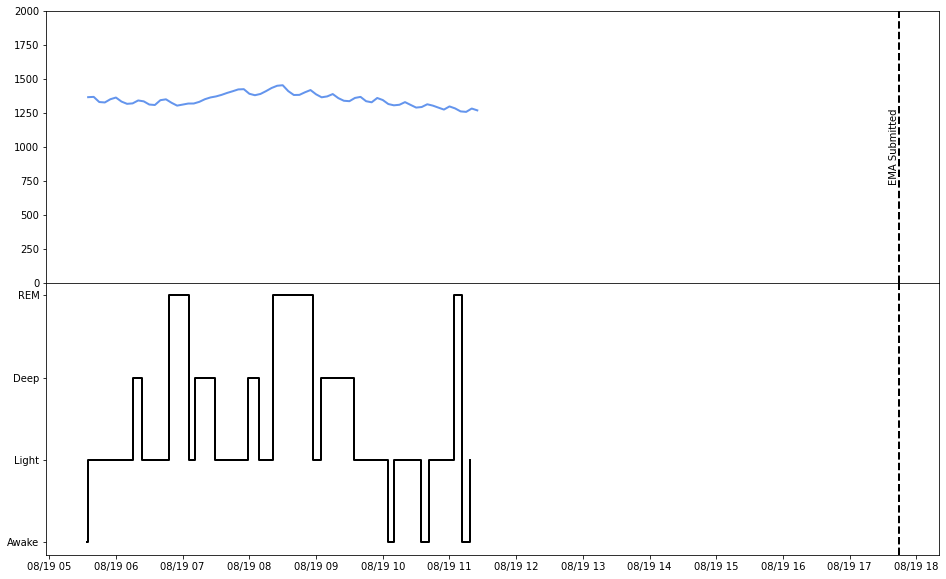

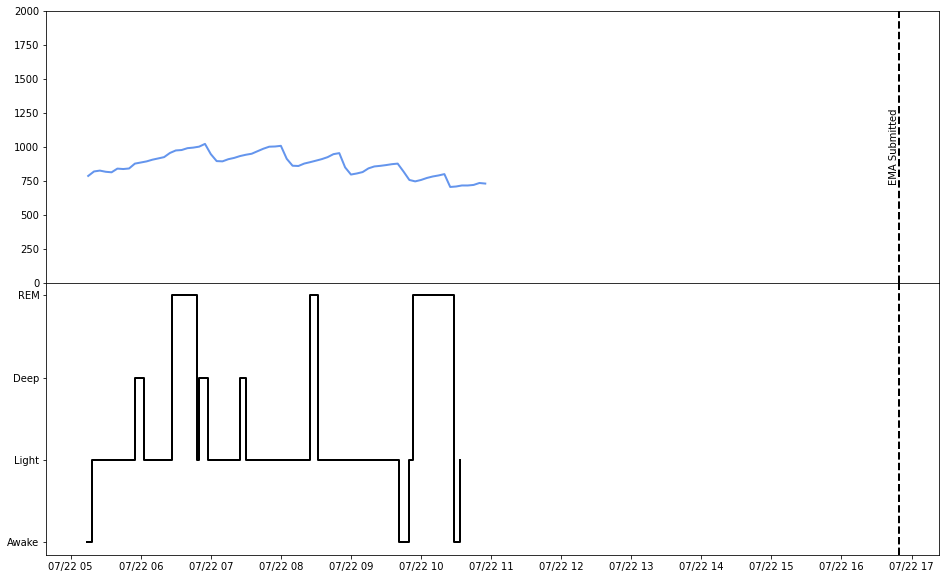

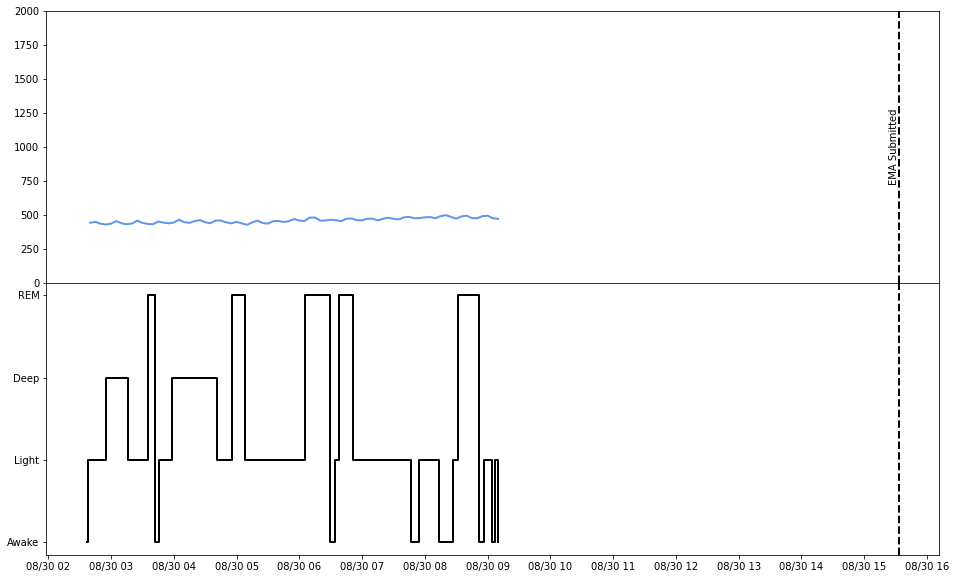

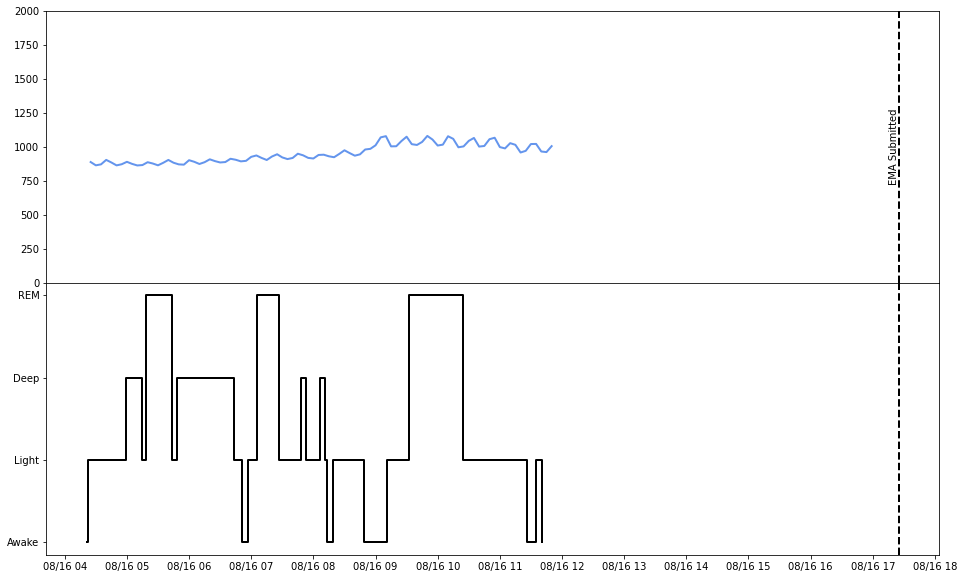

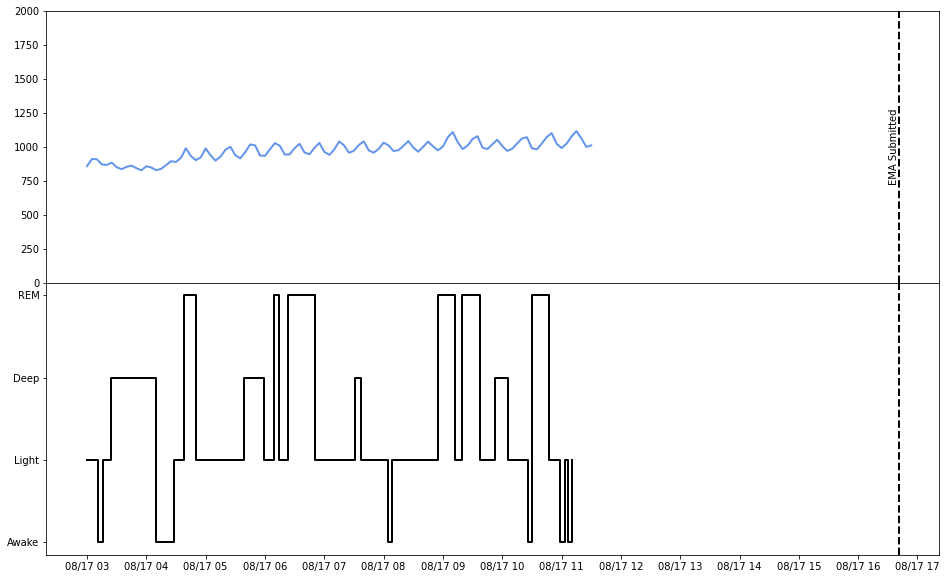

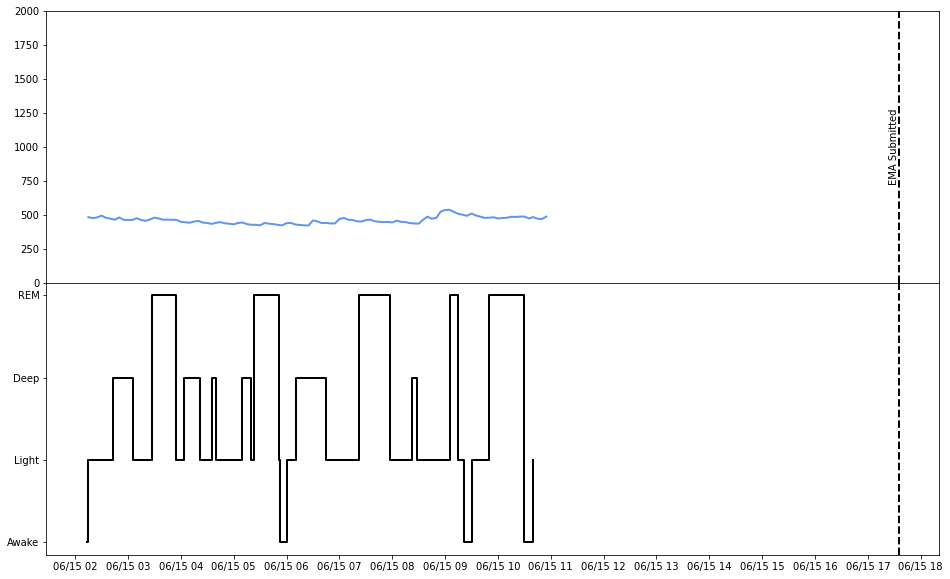

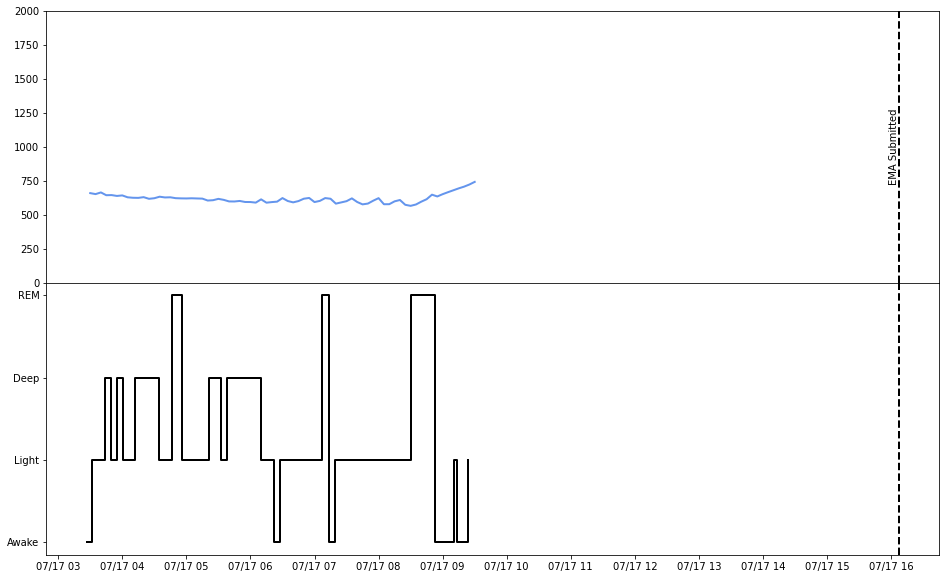

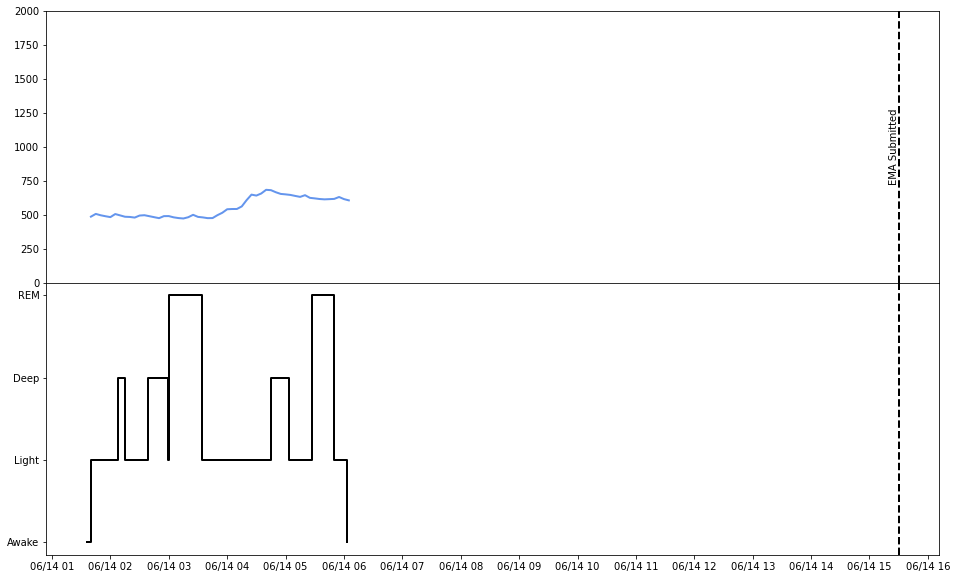

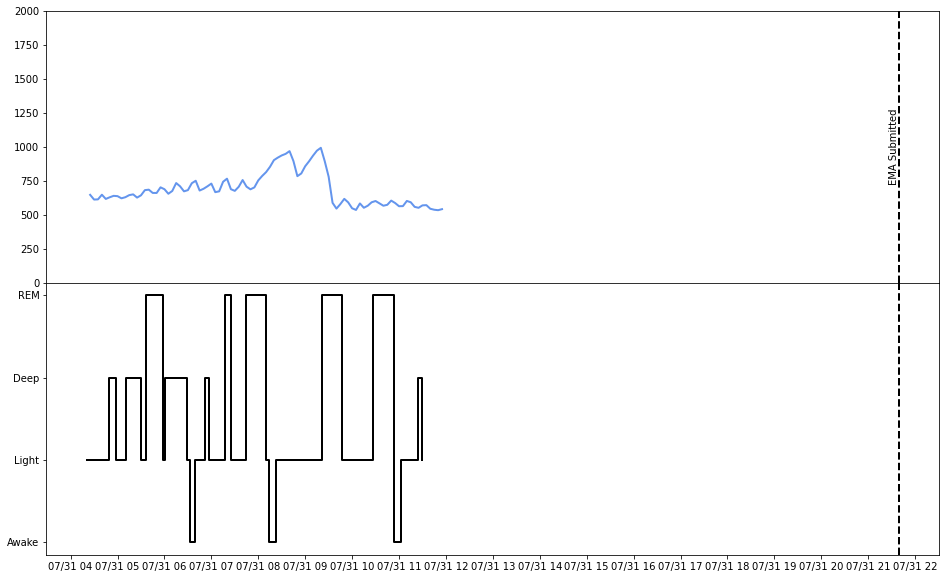

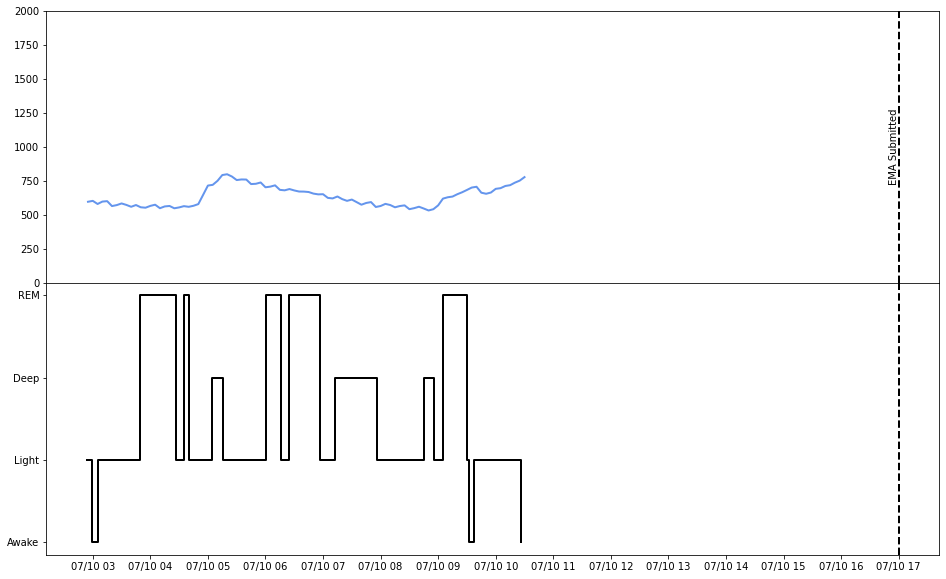

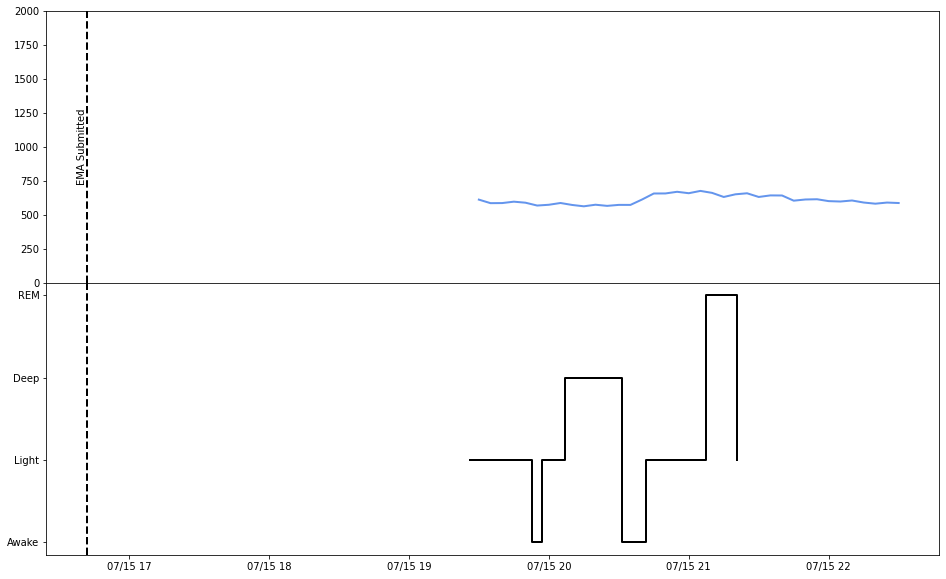

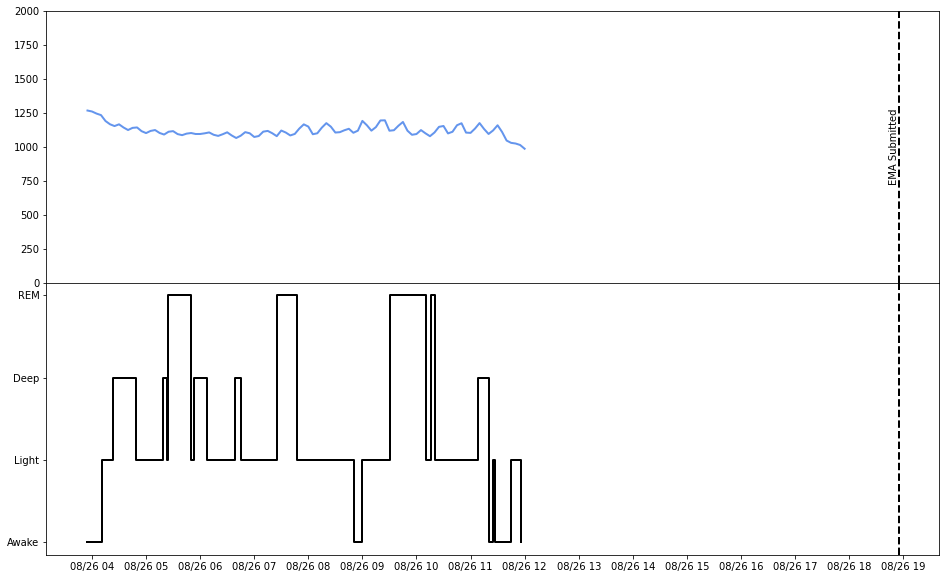

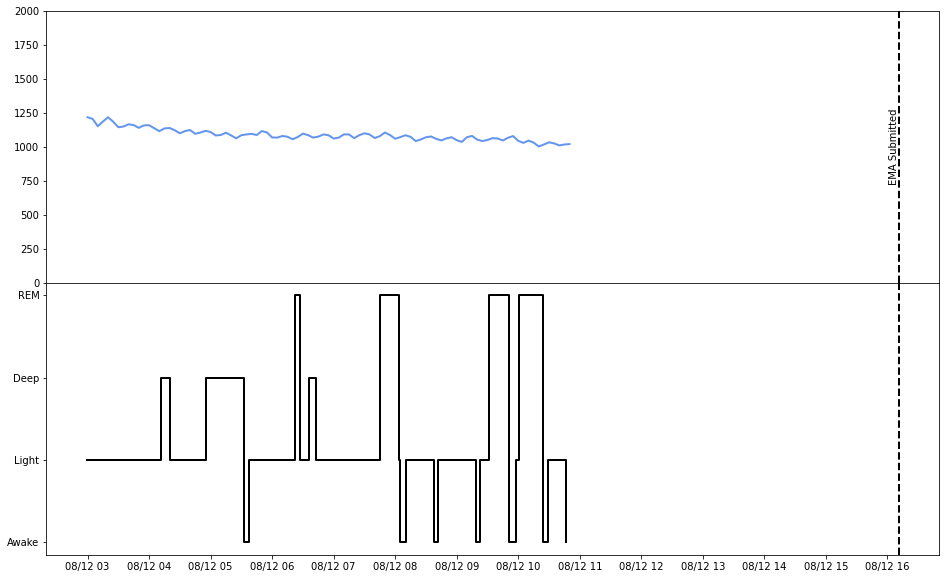

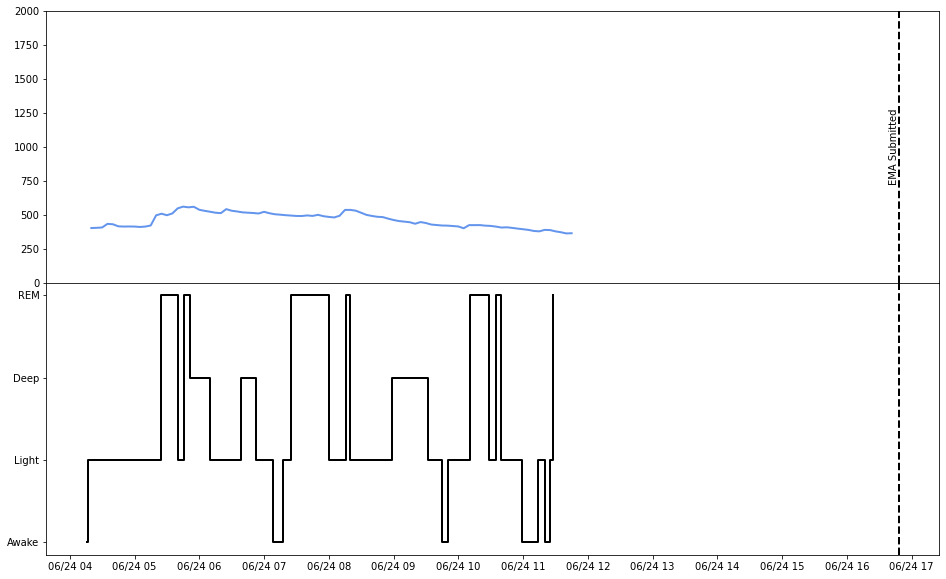

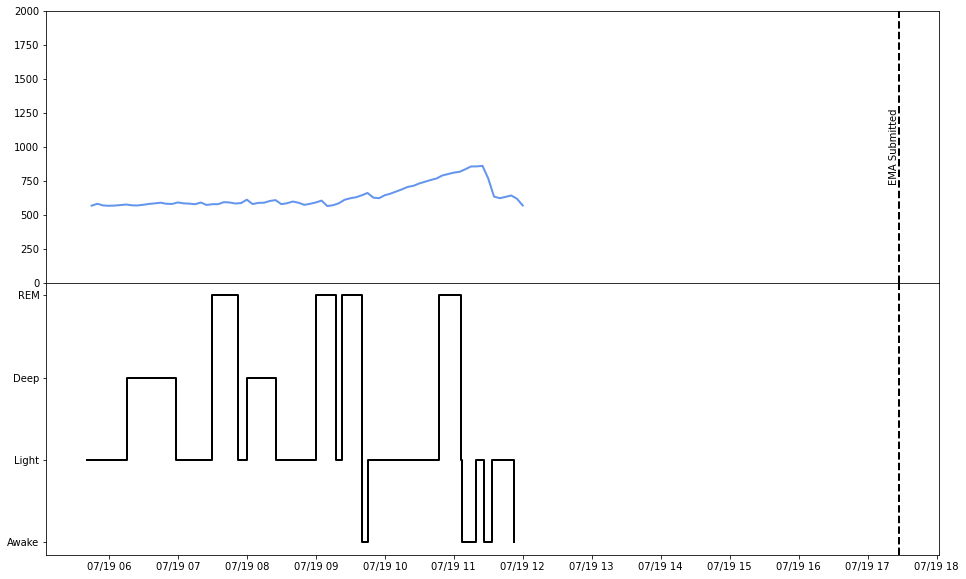

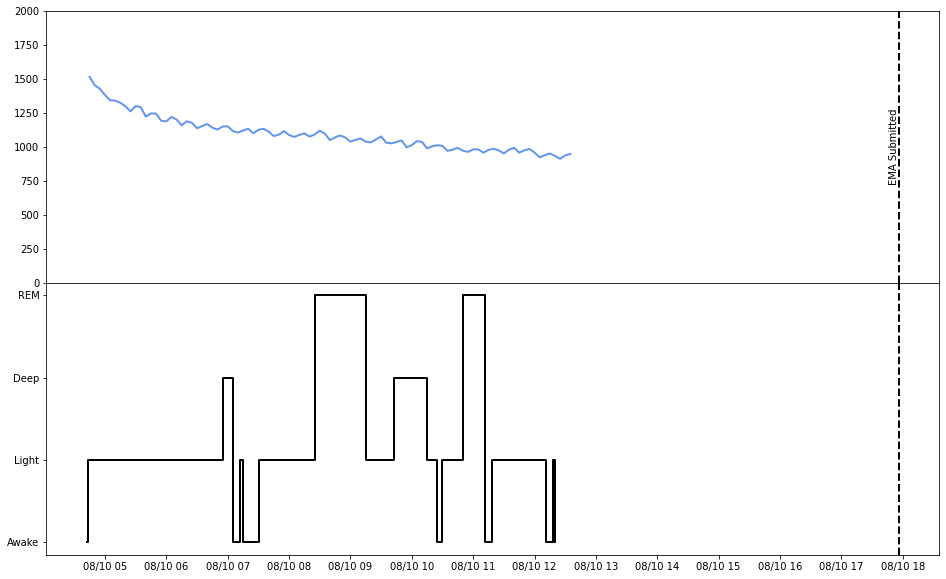

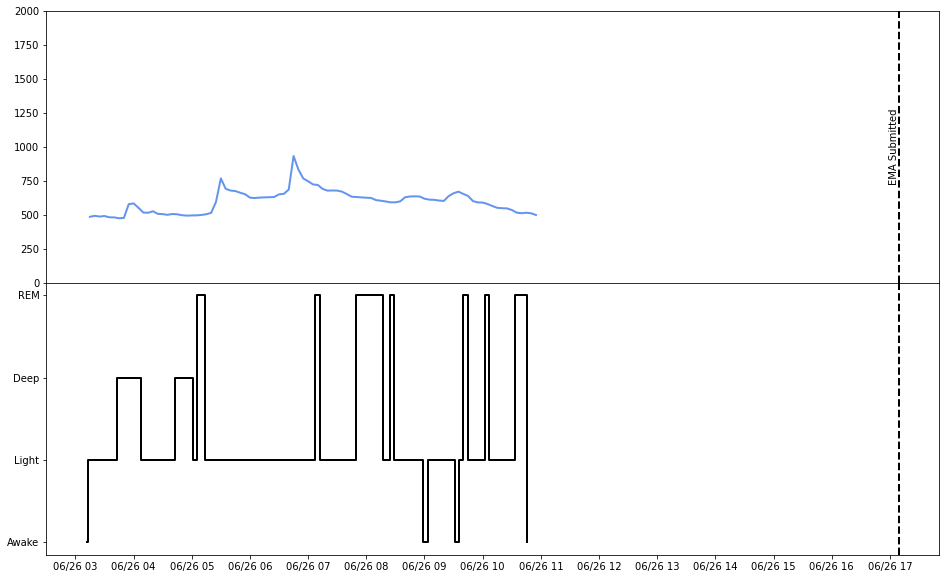

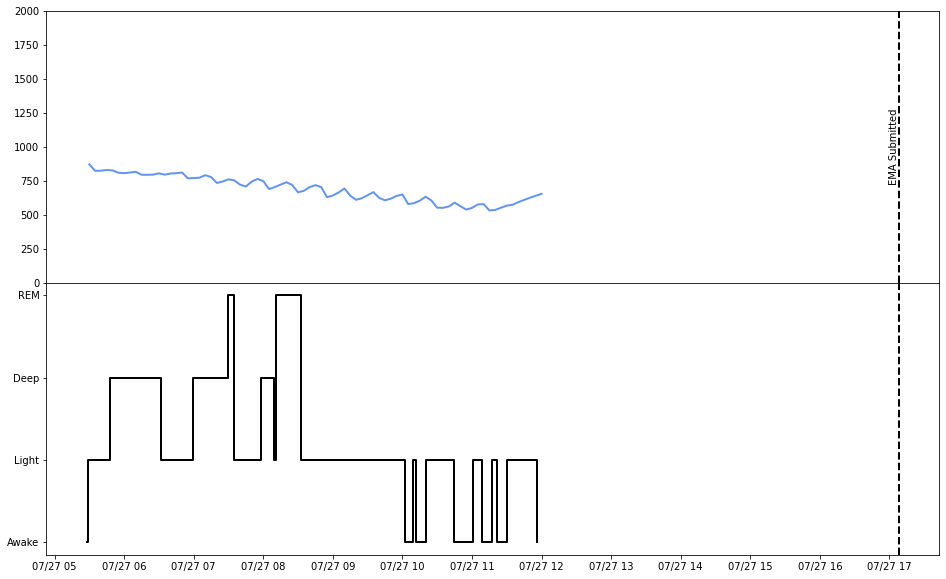

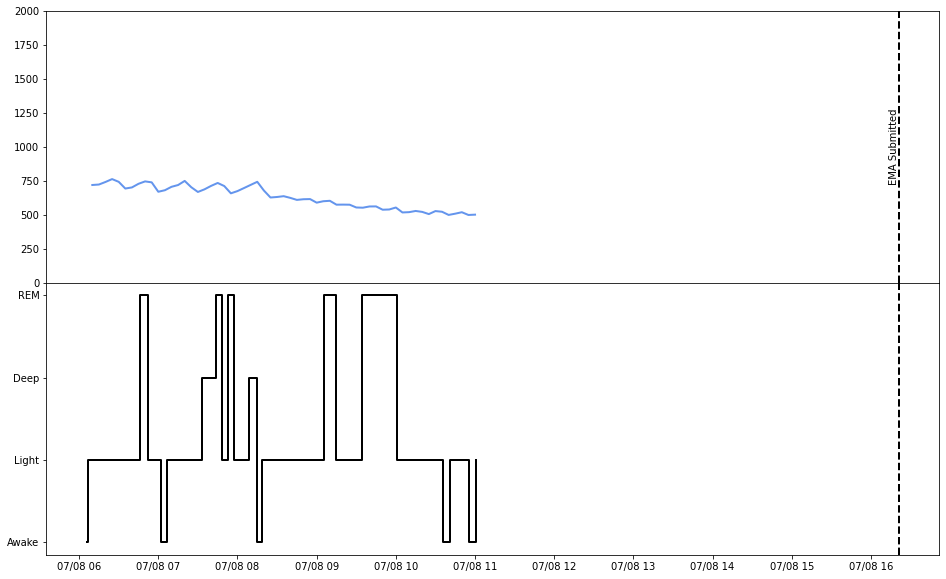

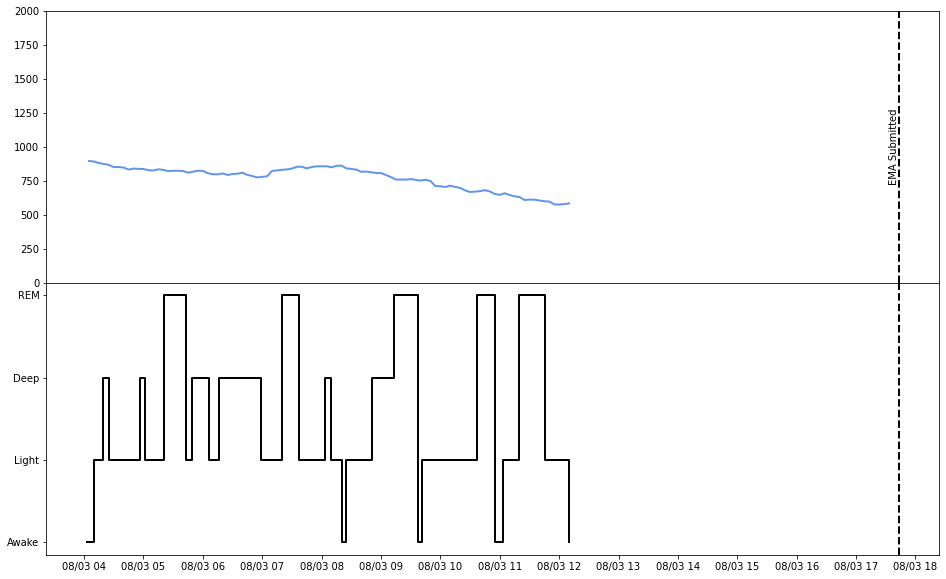

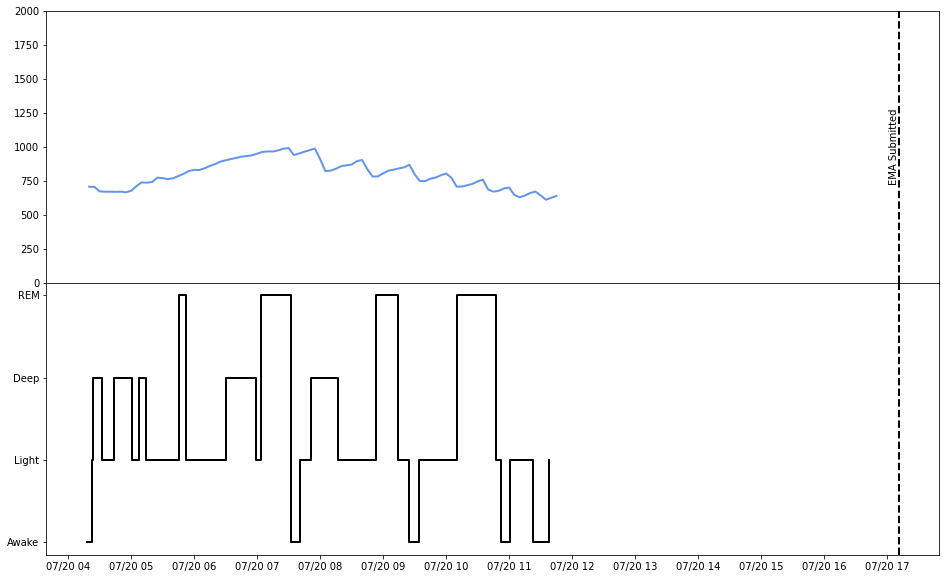

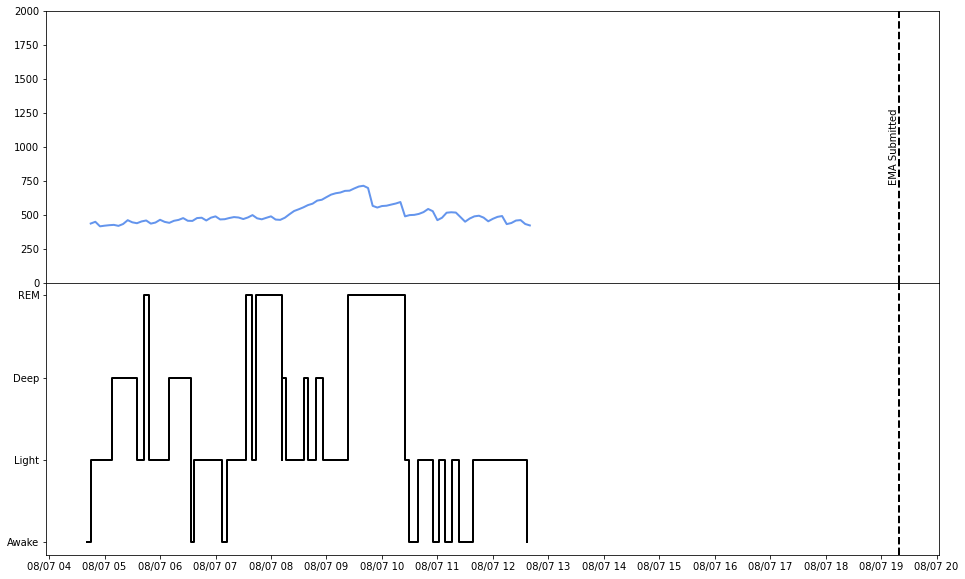

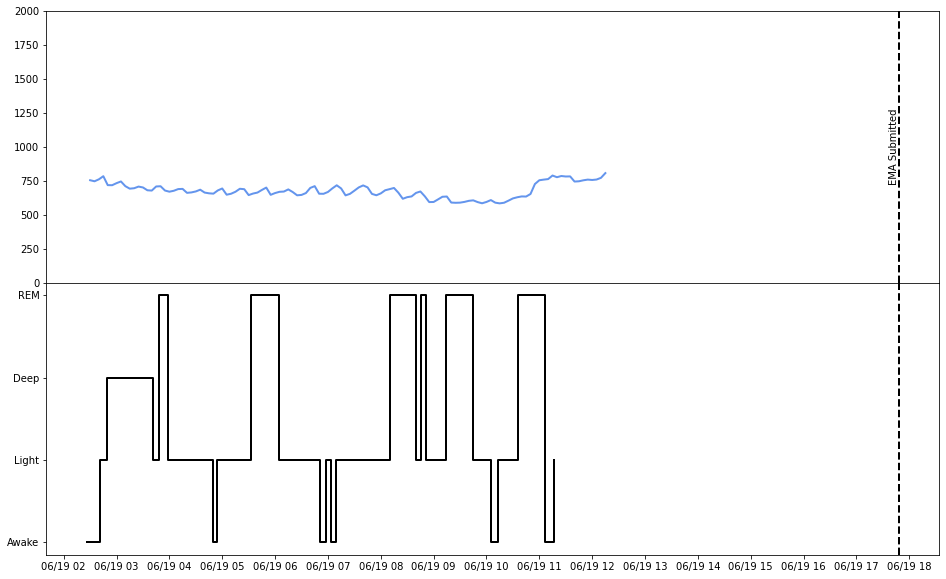

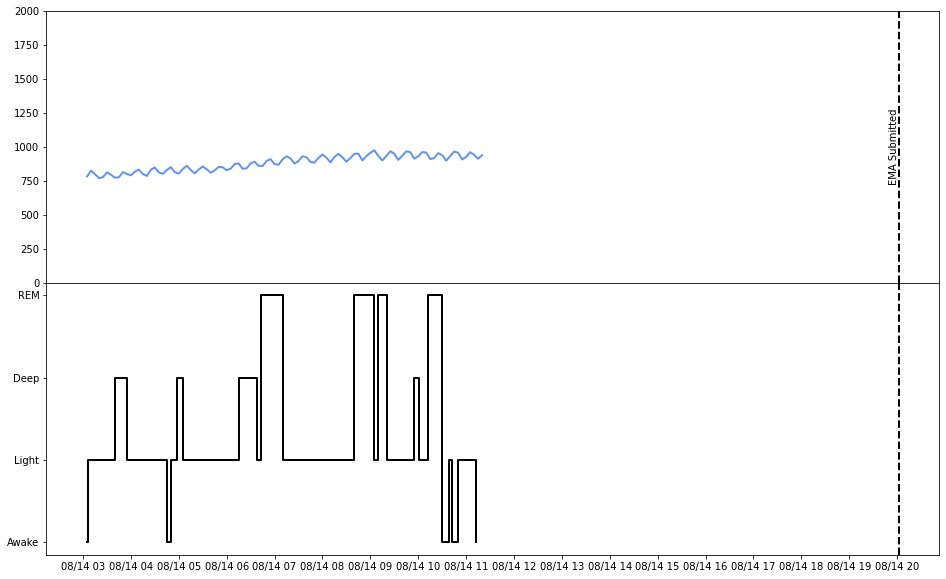

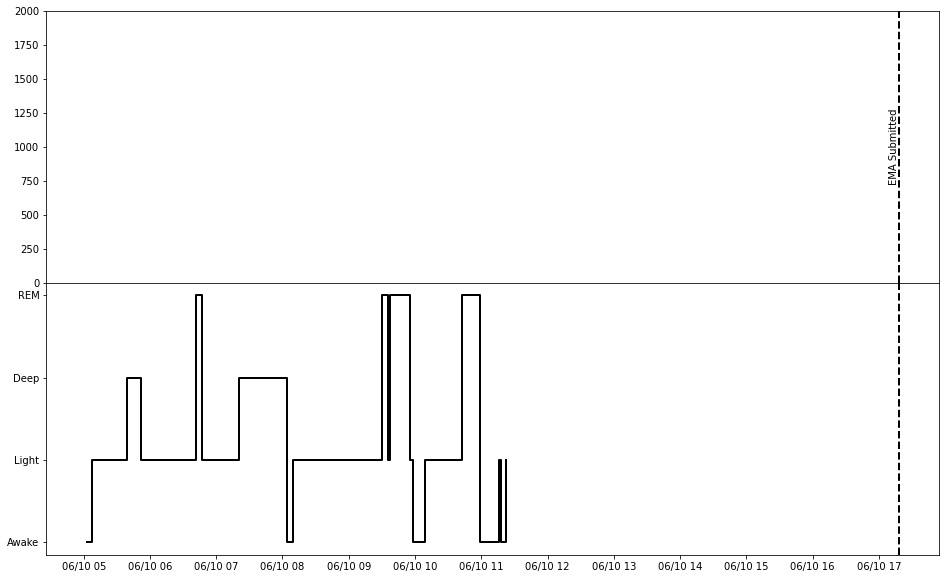

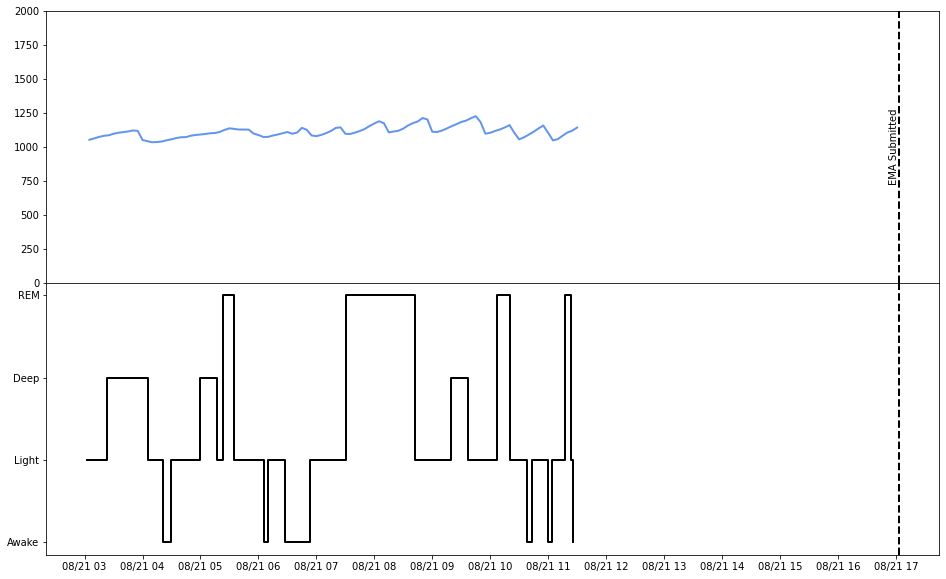

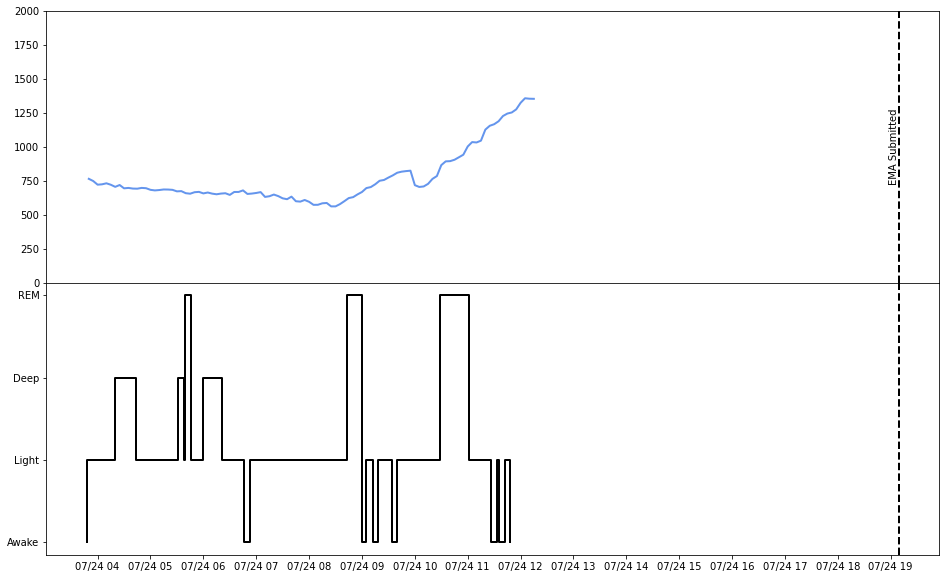

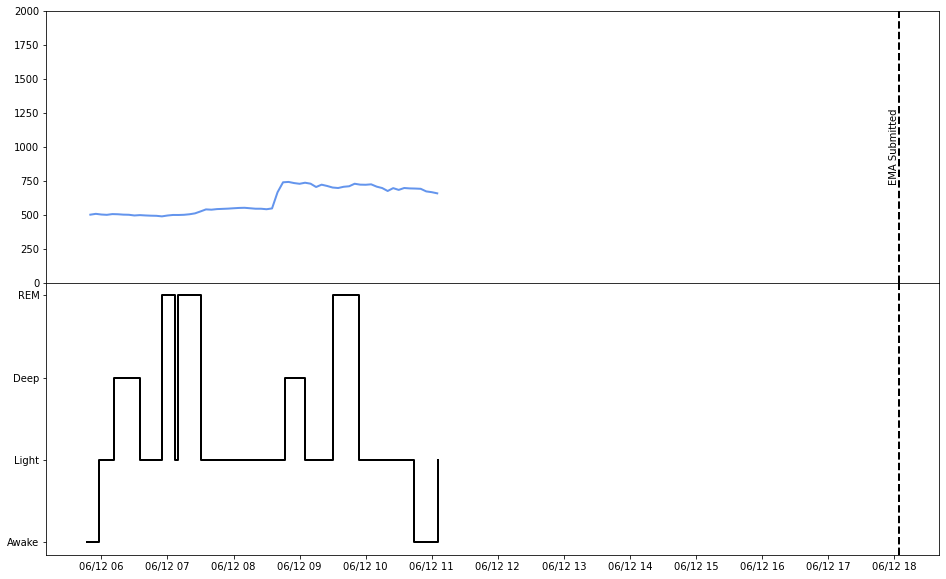

rnse61g4


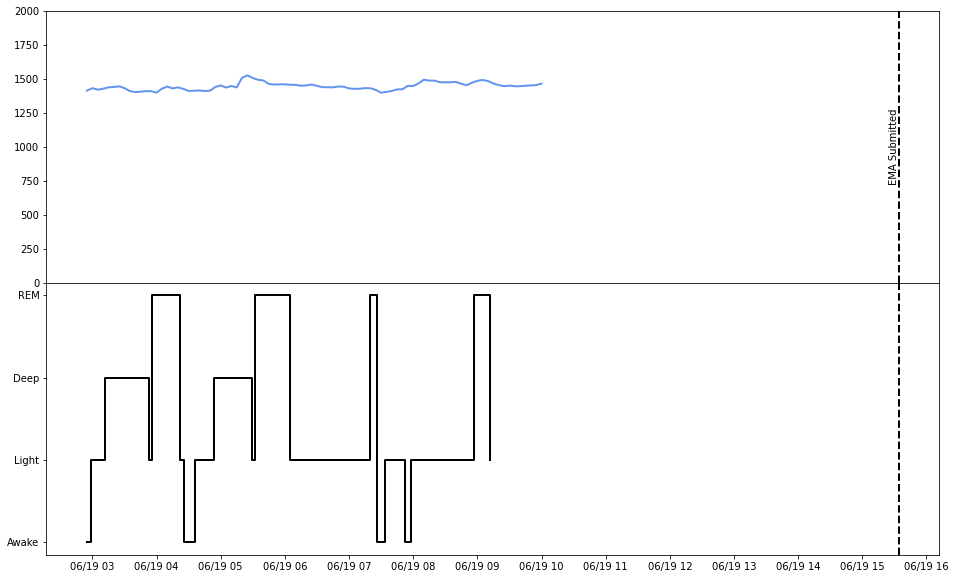

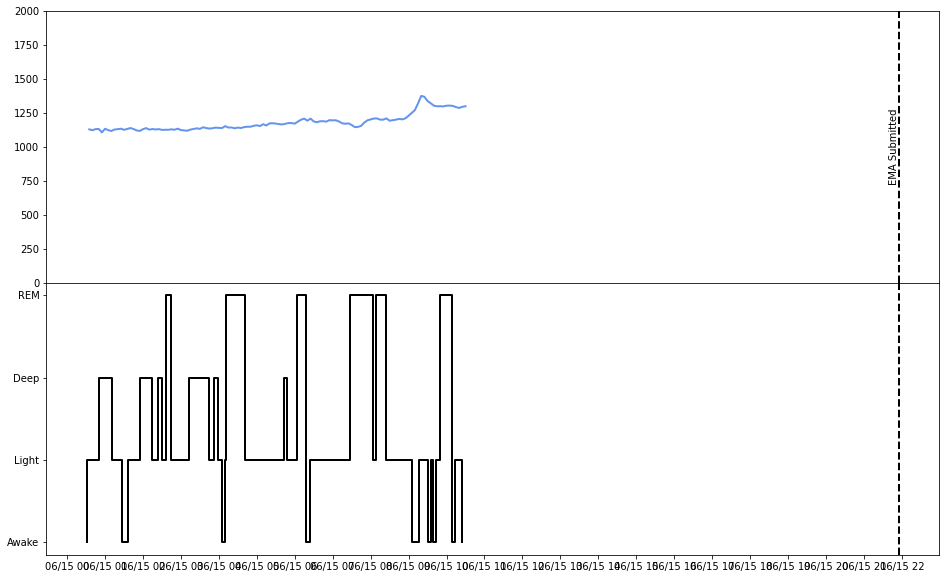

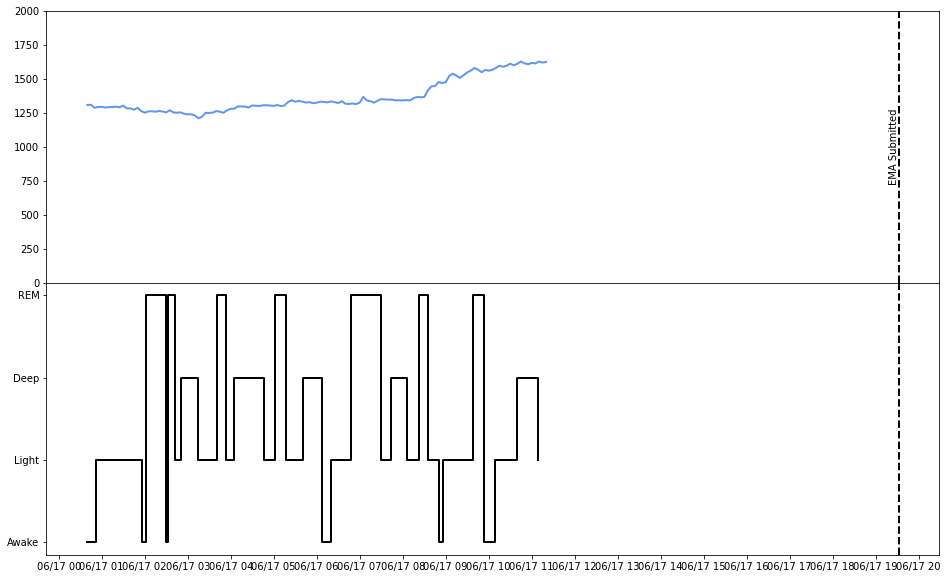

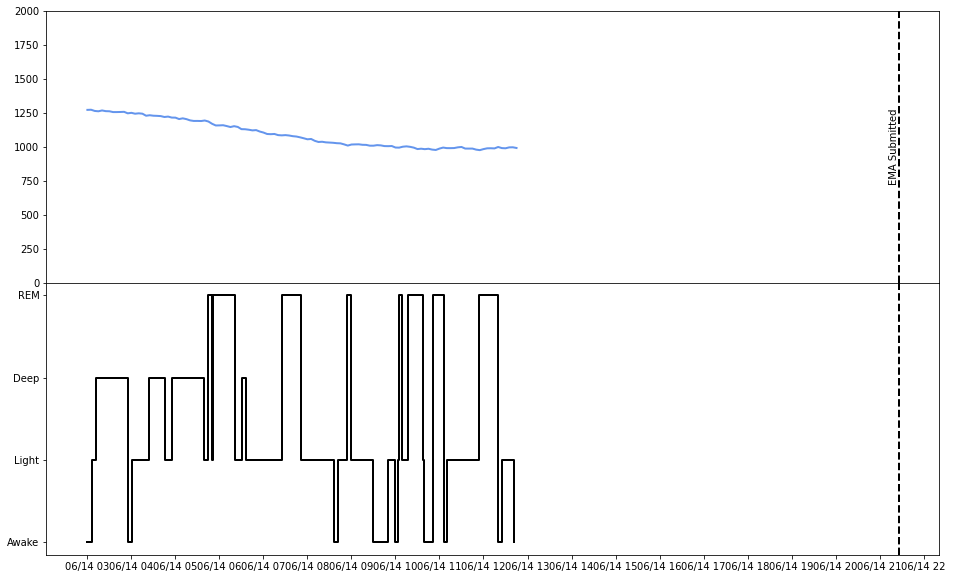

tlmlq19s


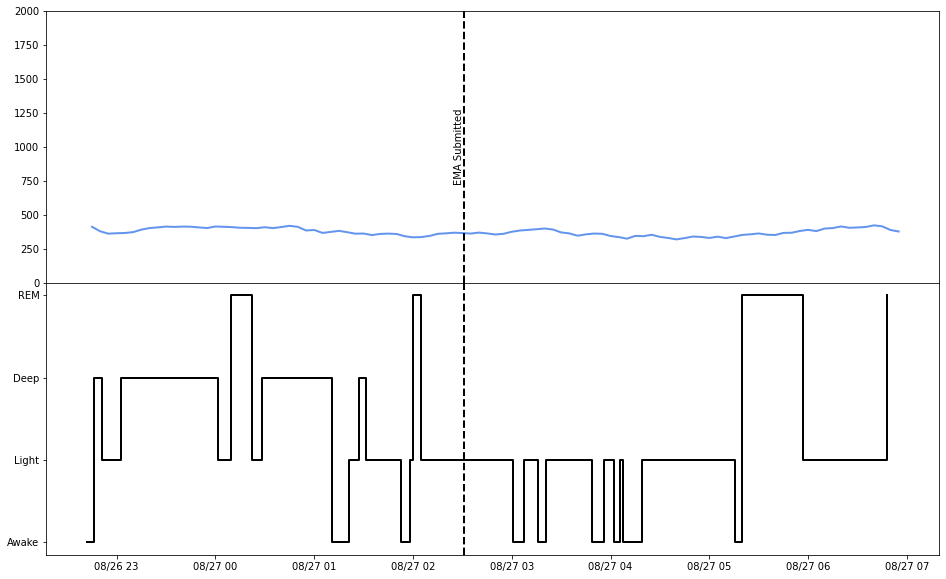

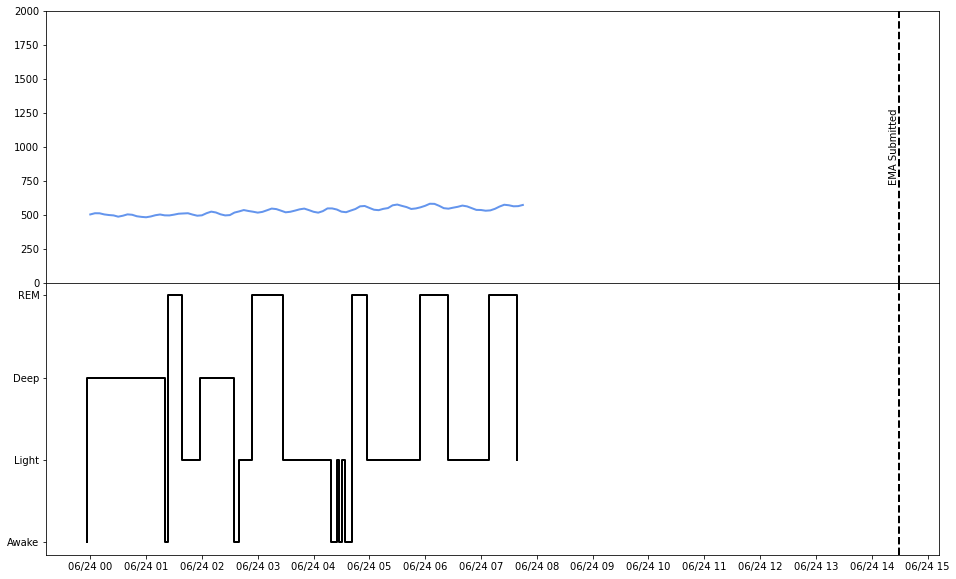

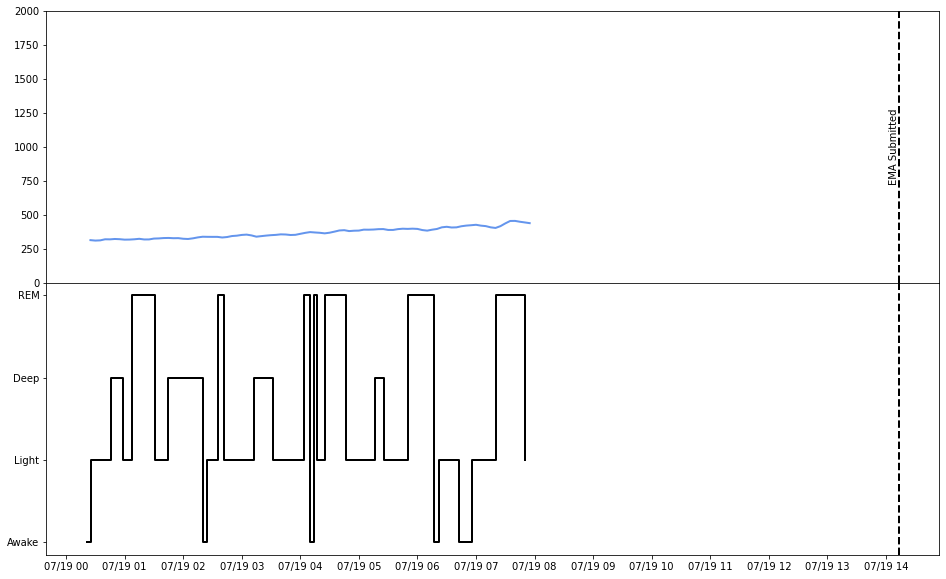

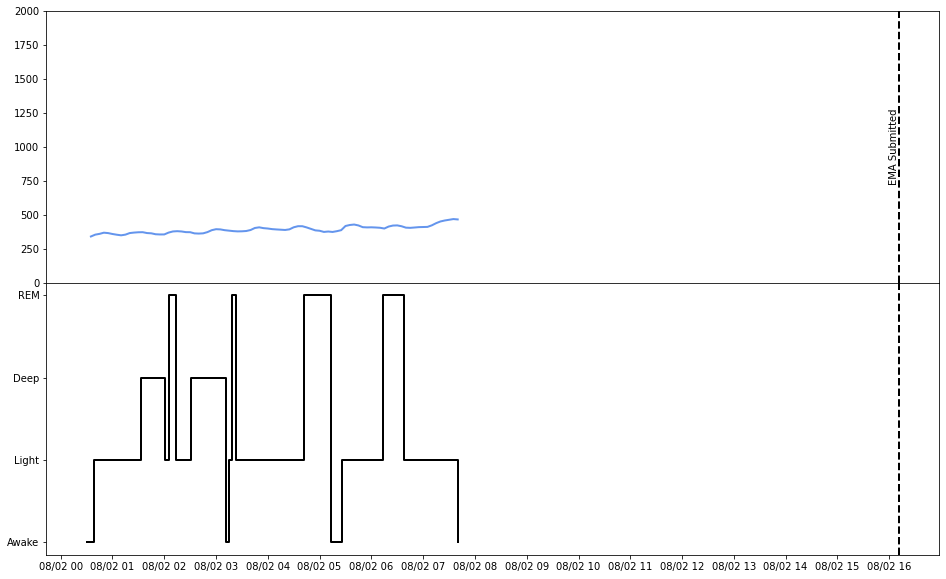

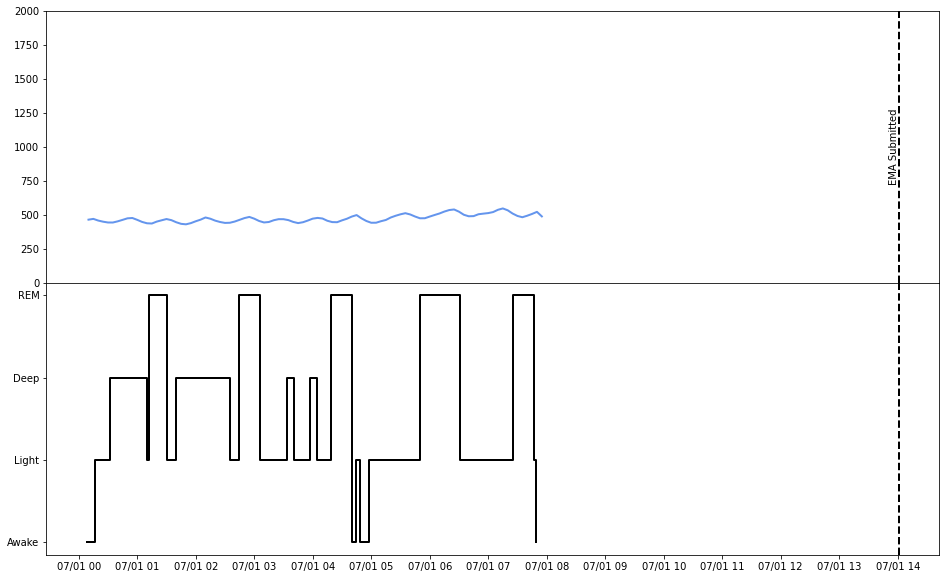

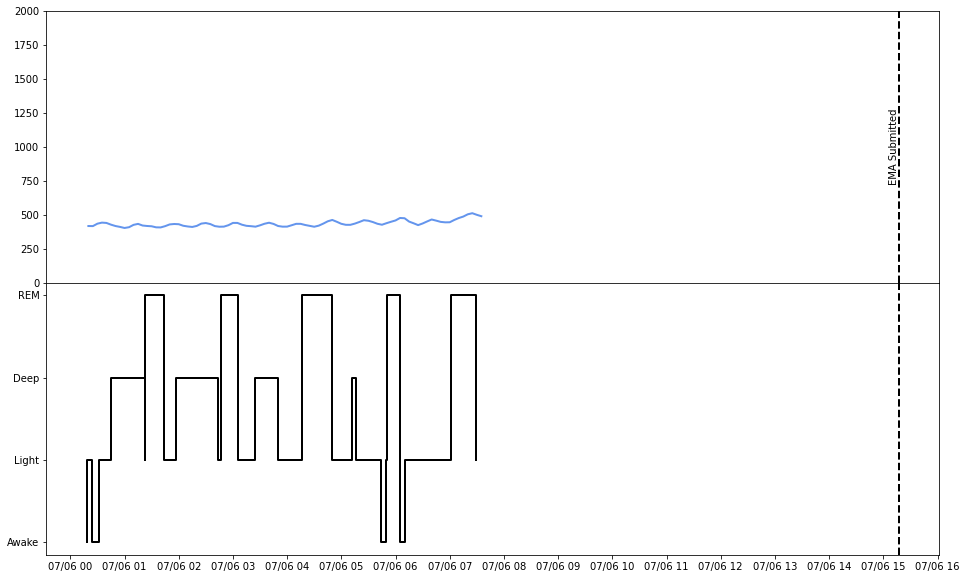

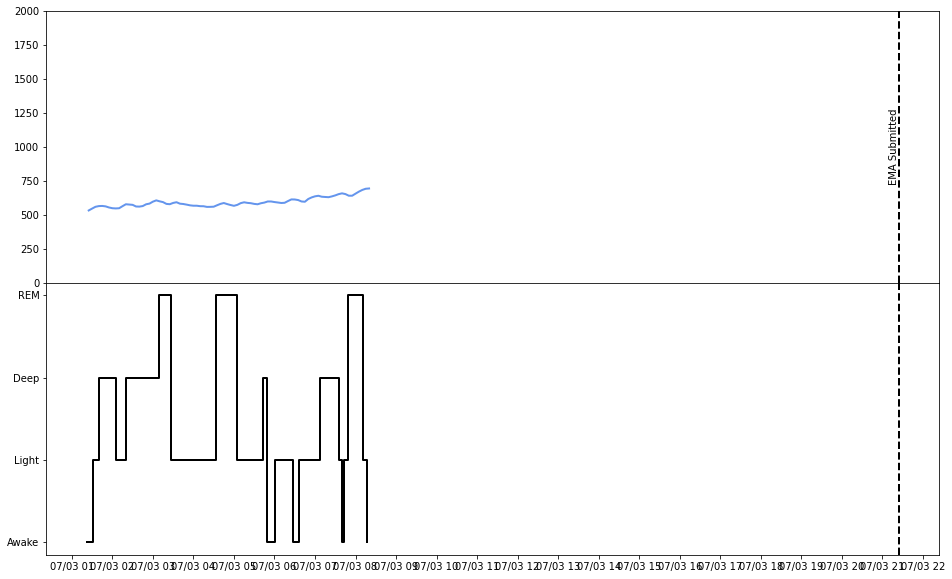

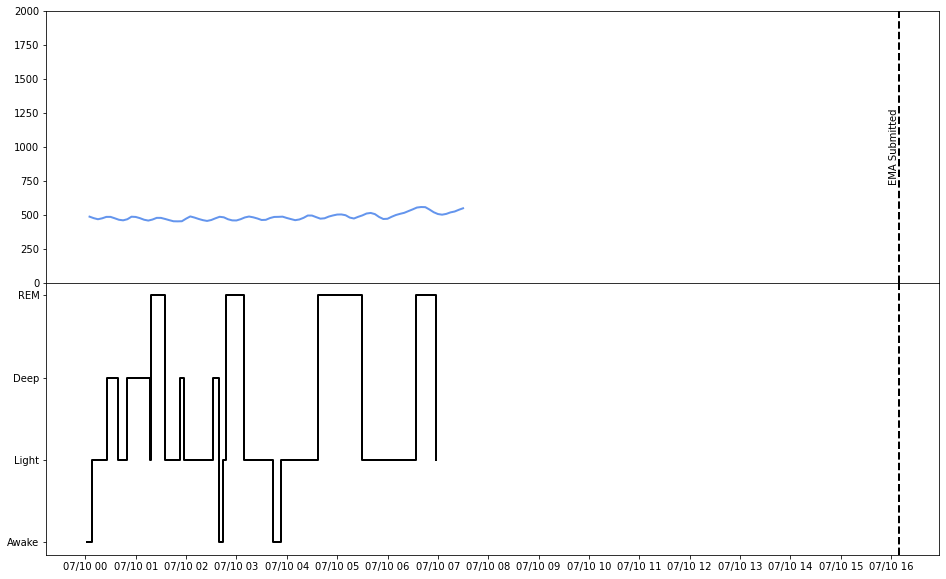

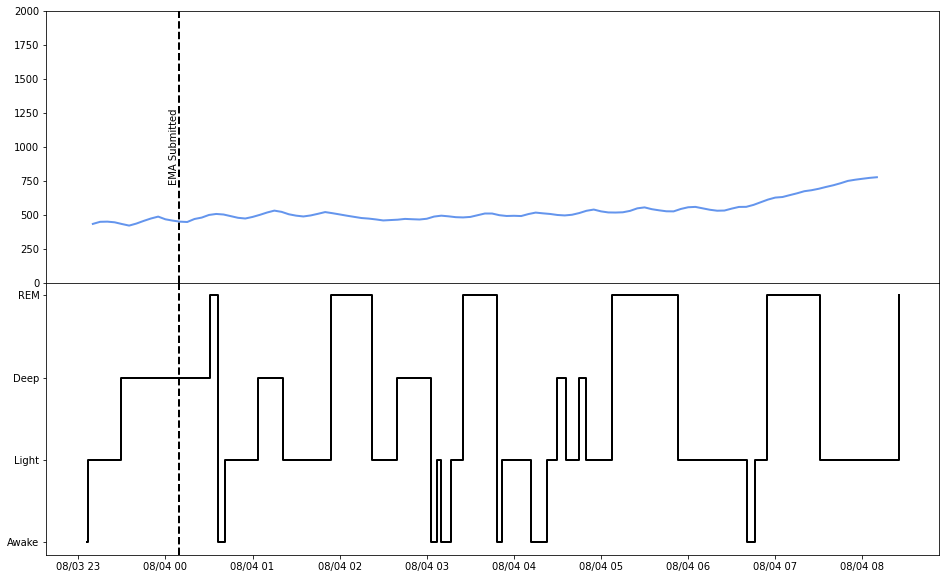

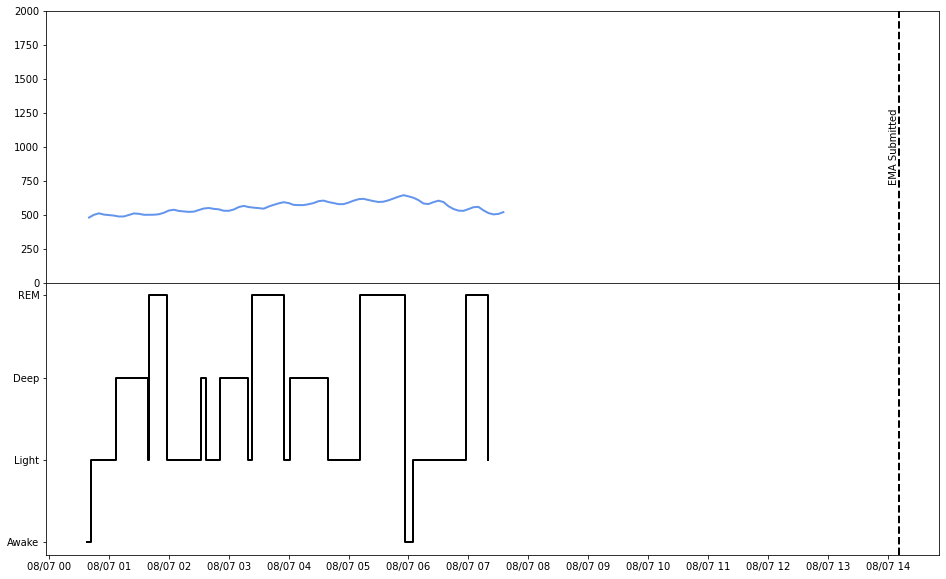

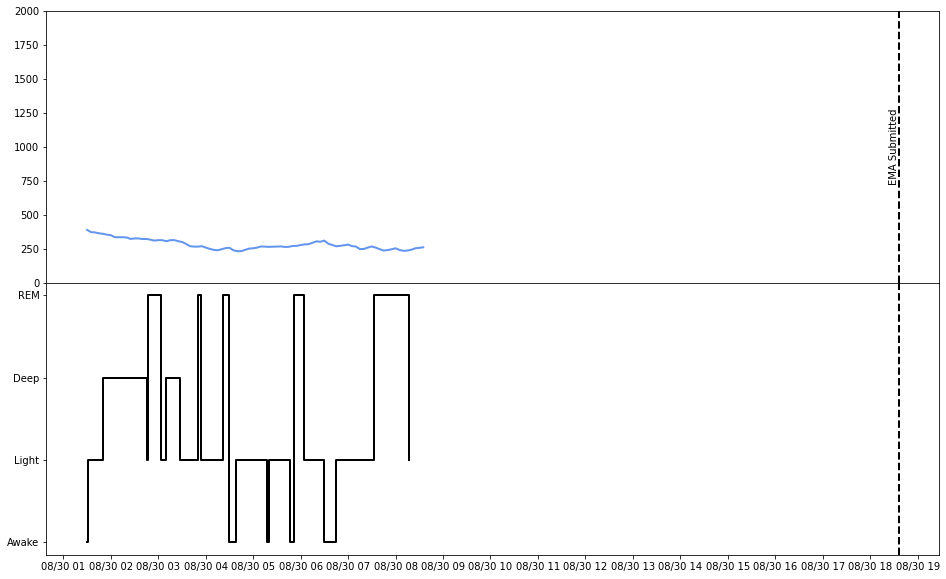

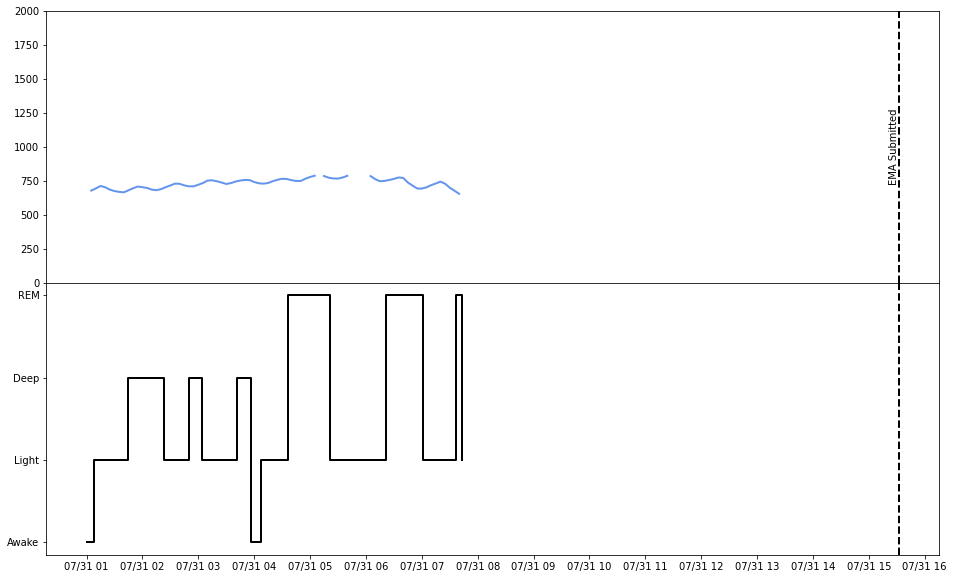

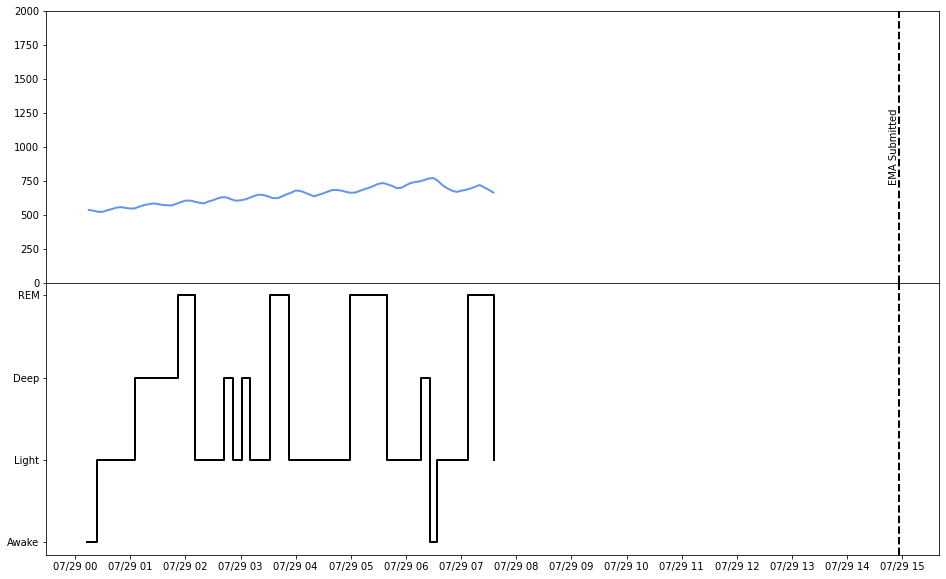

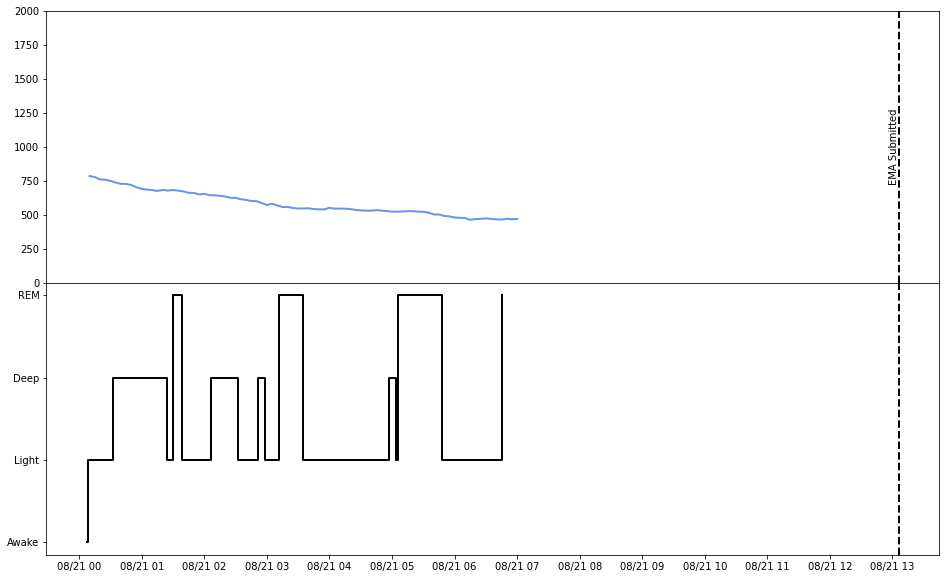

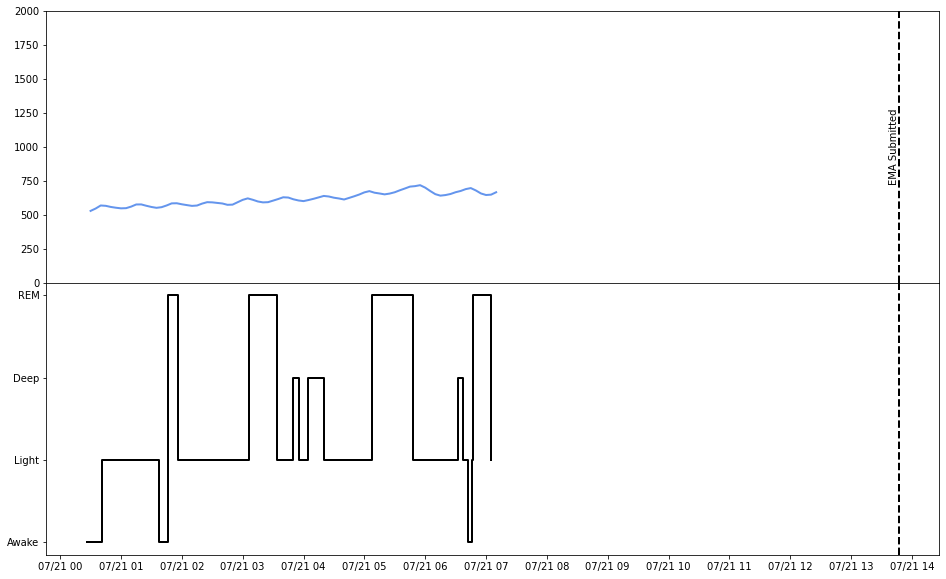

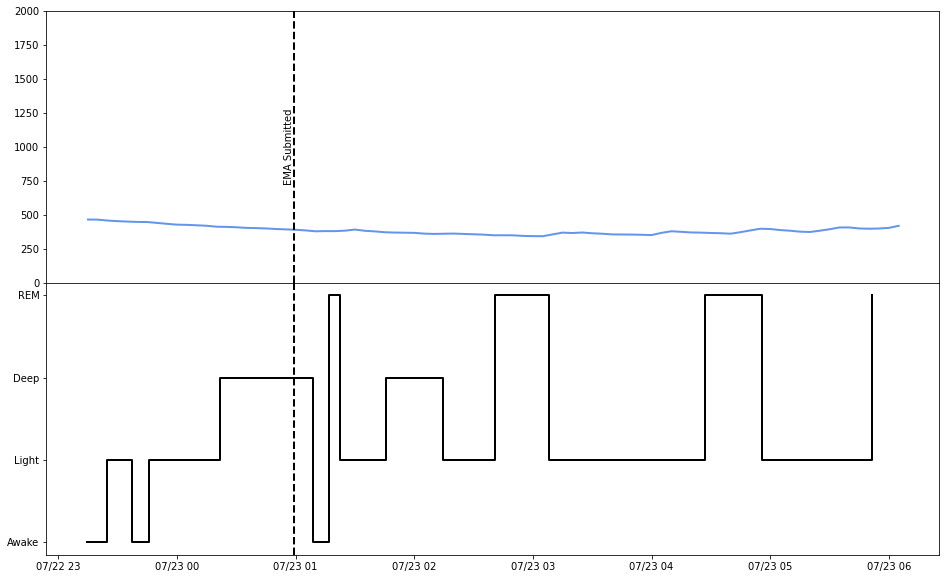

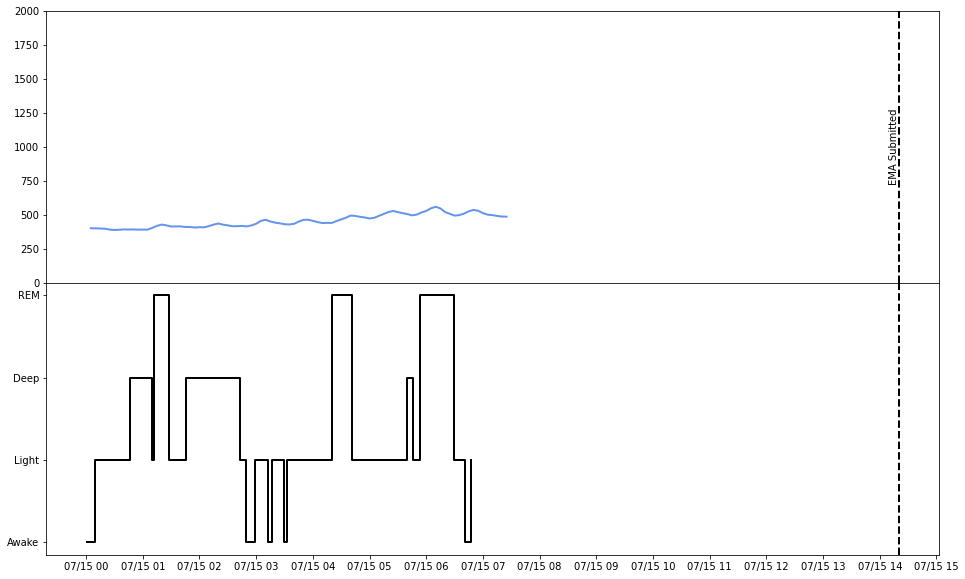

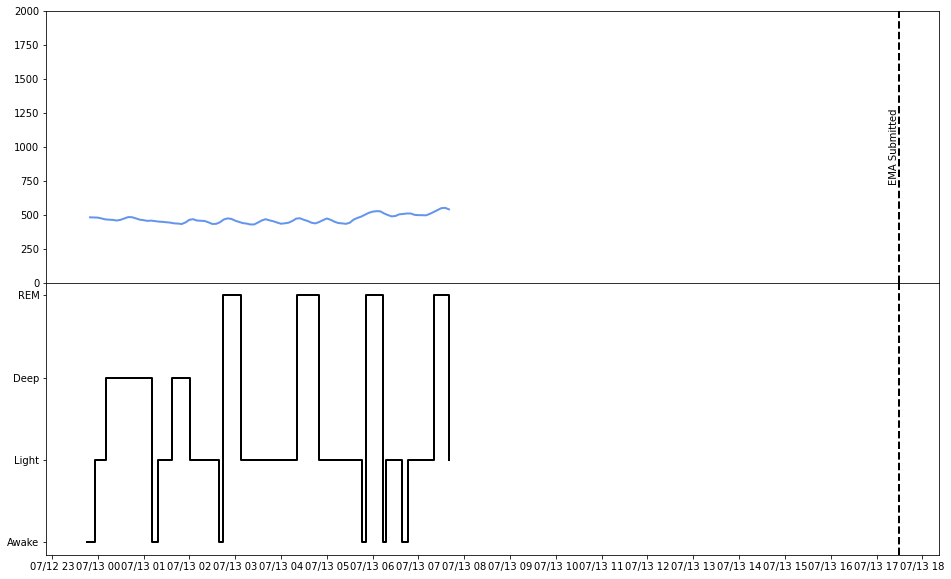

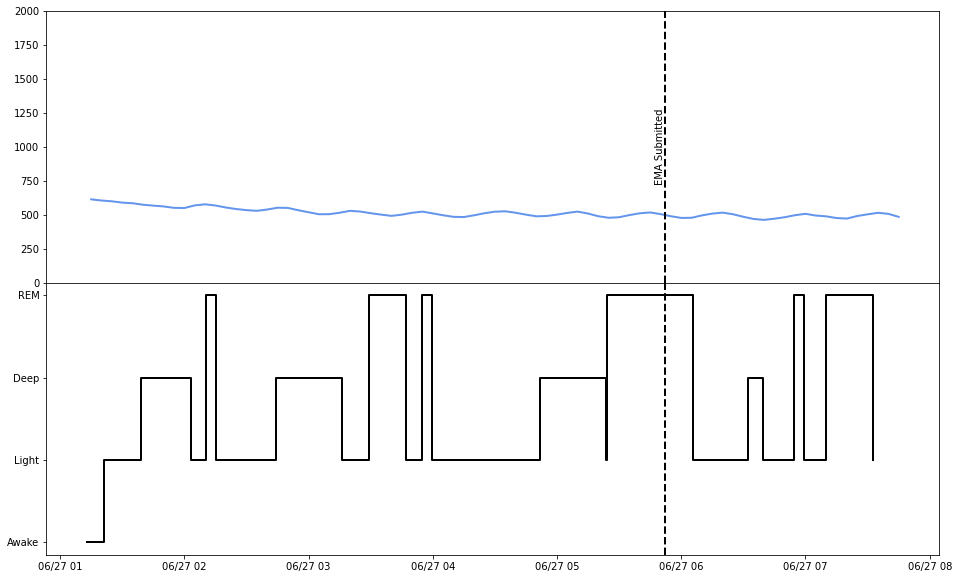

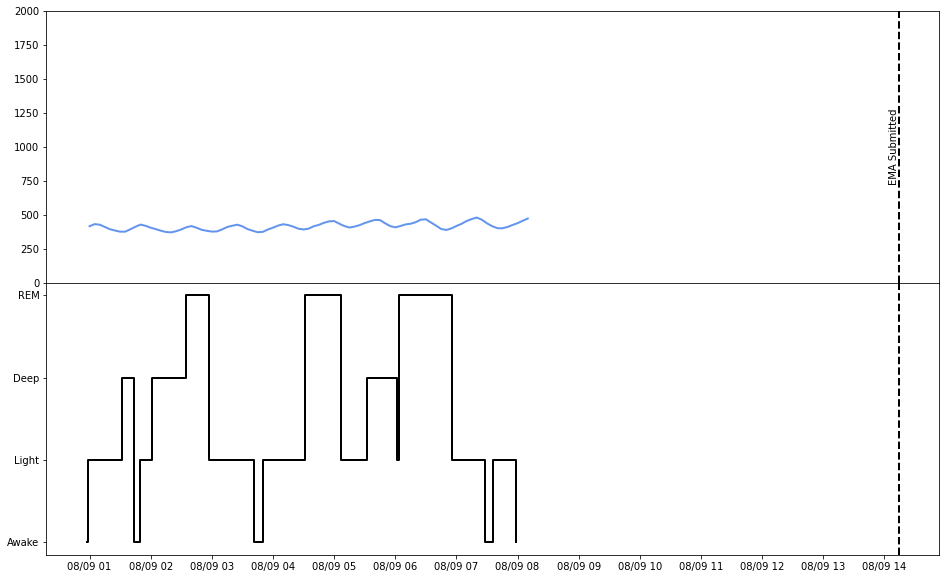

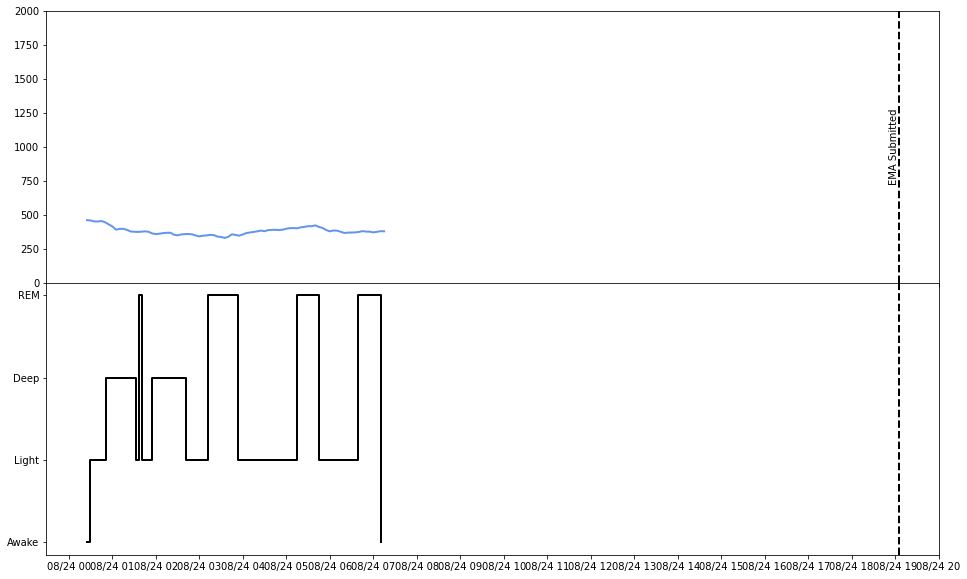

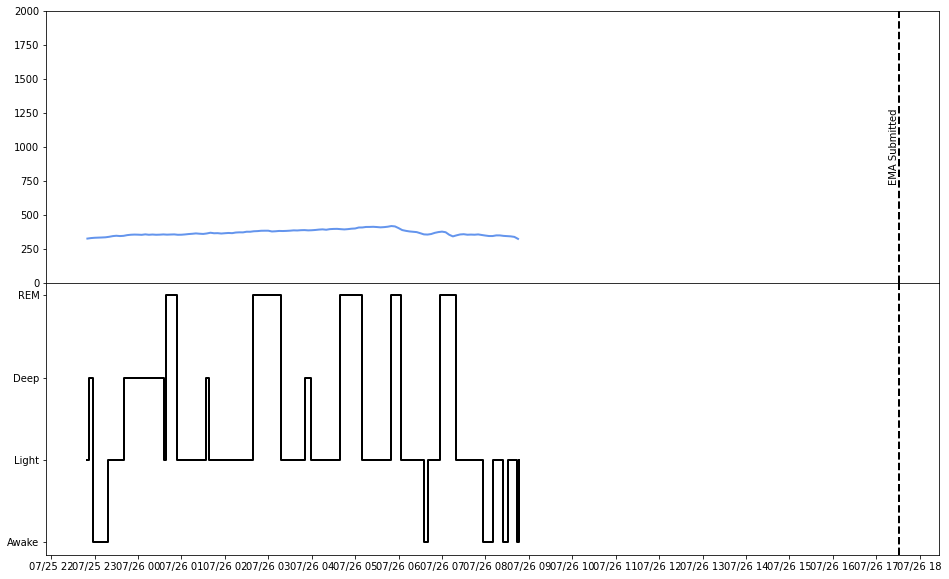

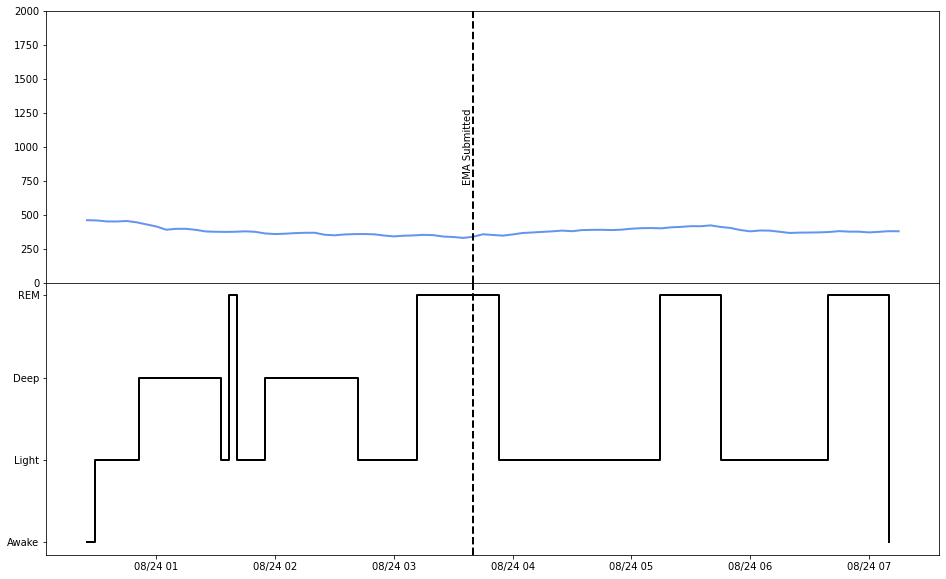

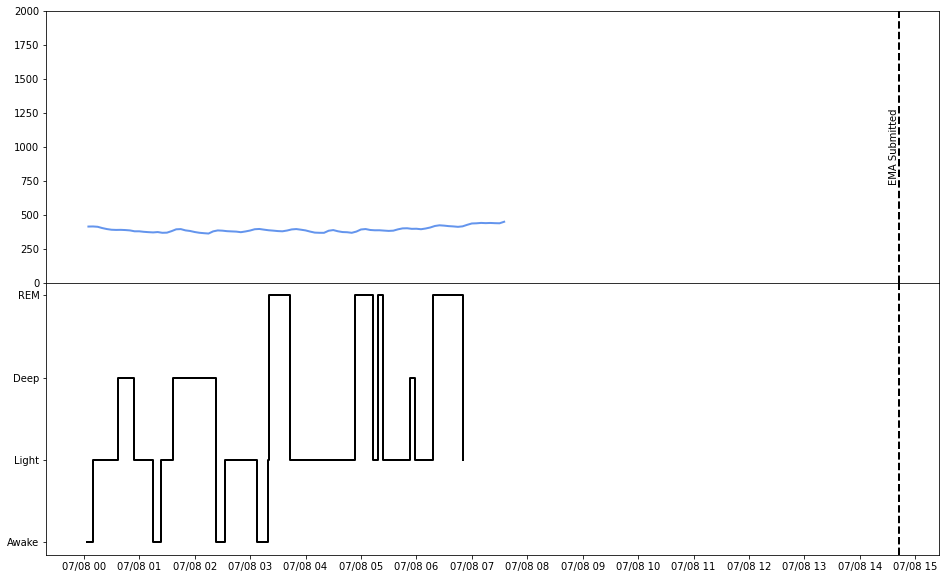

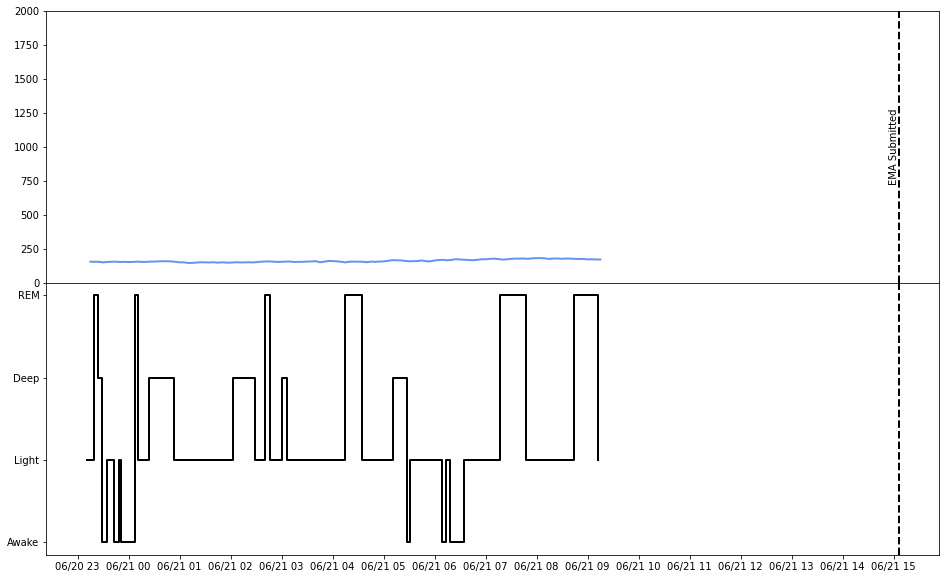

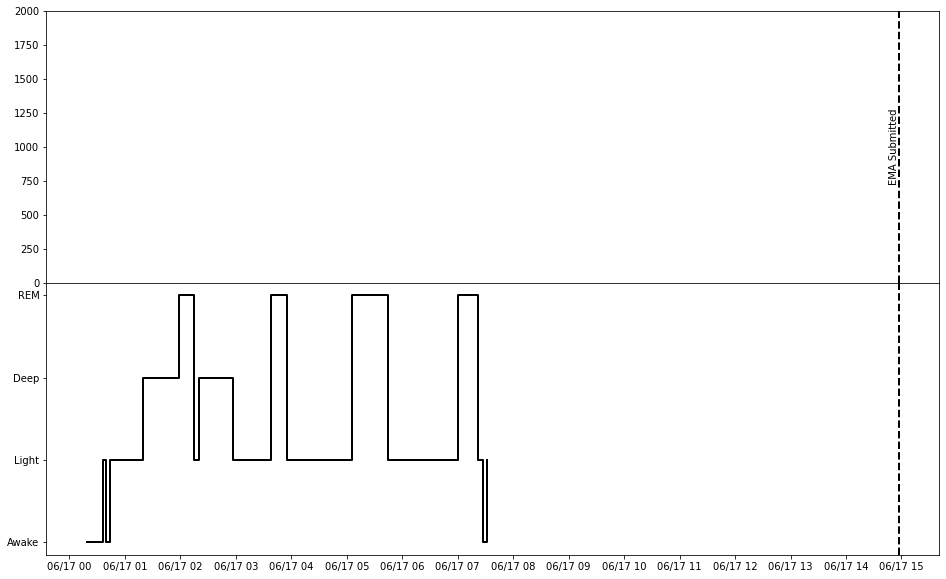

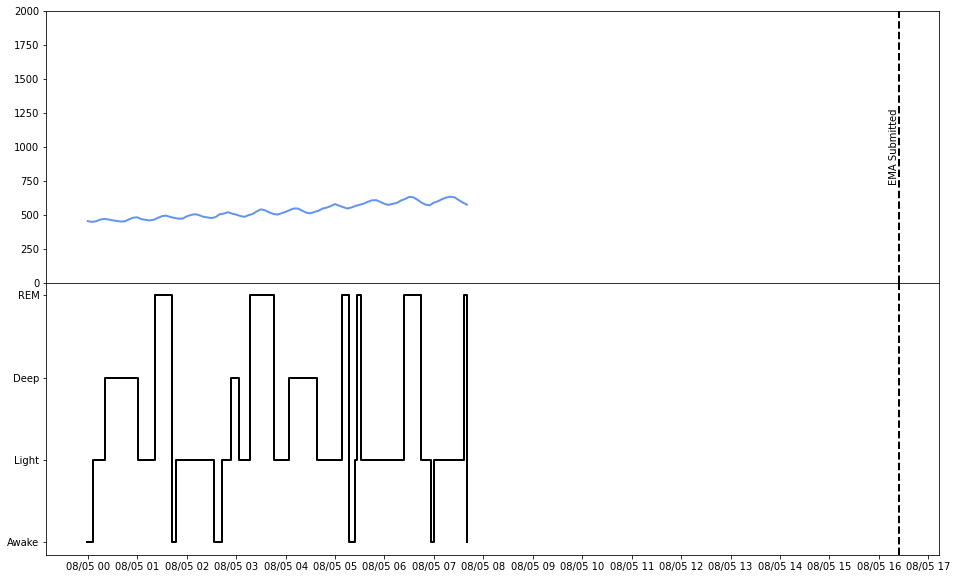

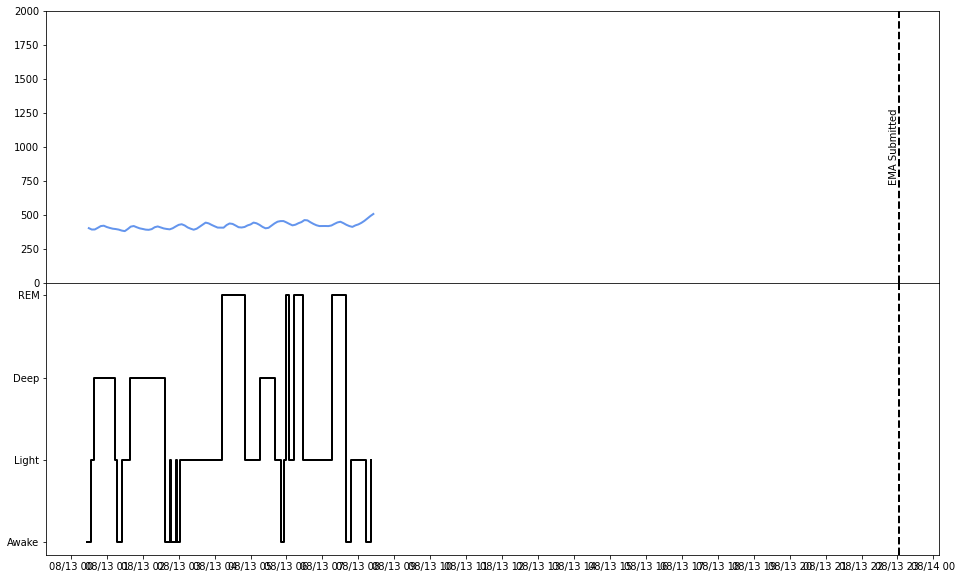

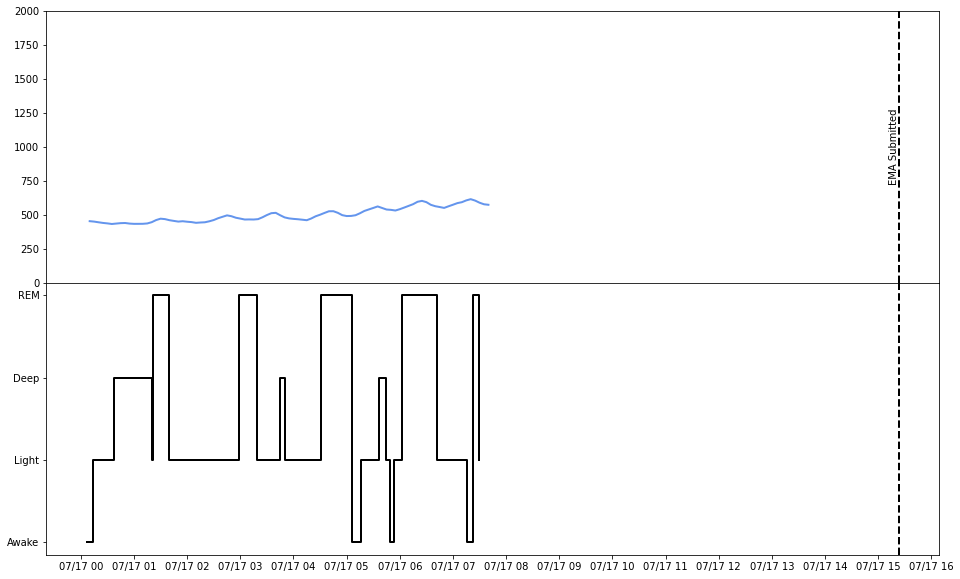

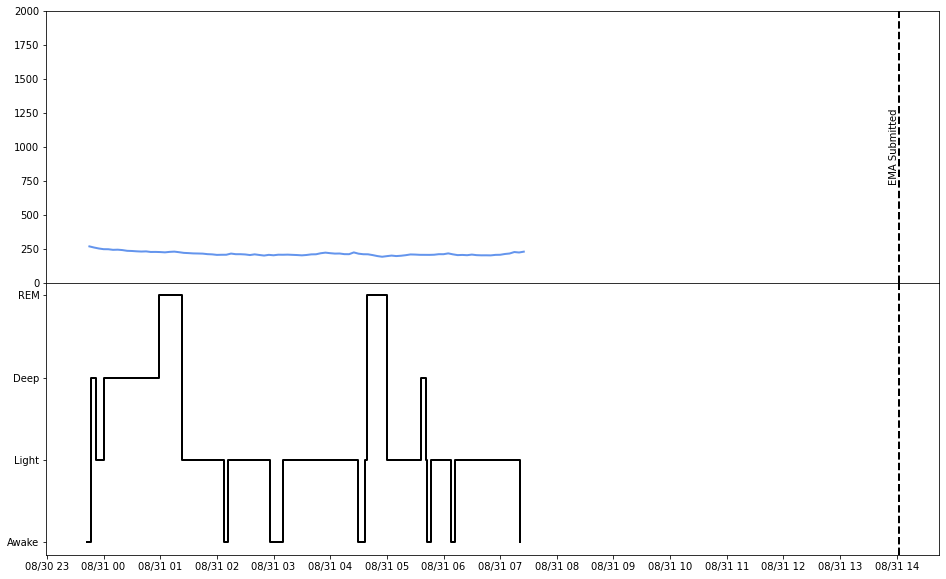

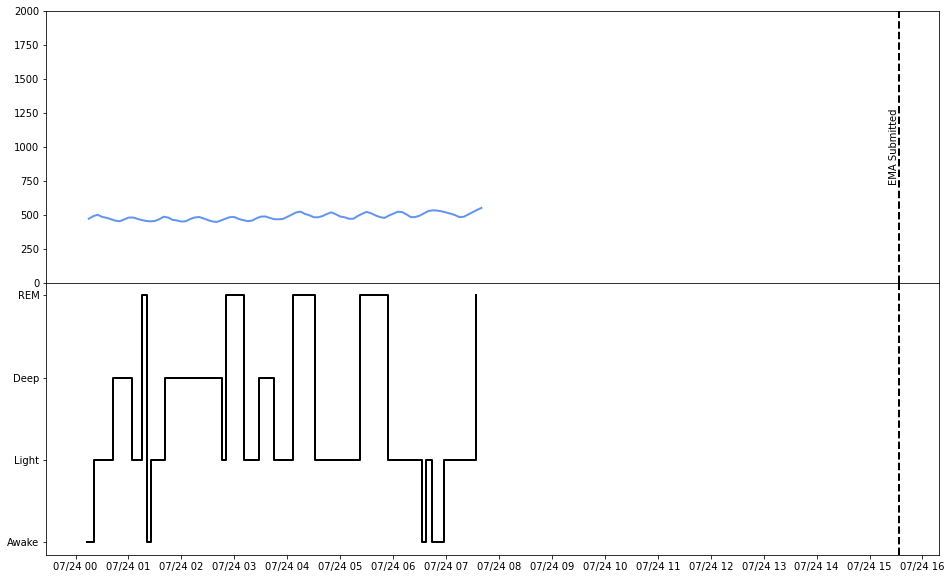

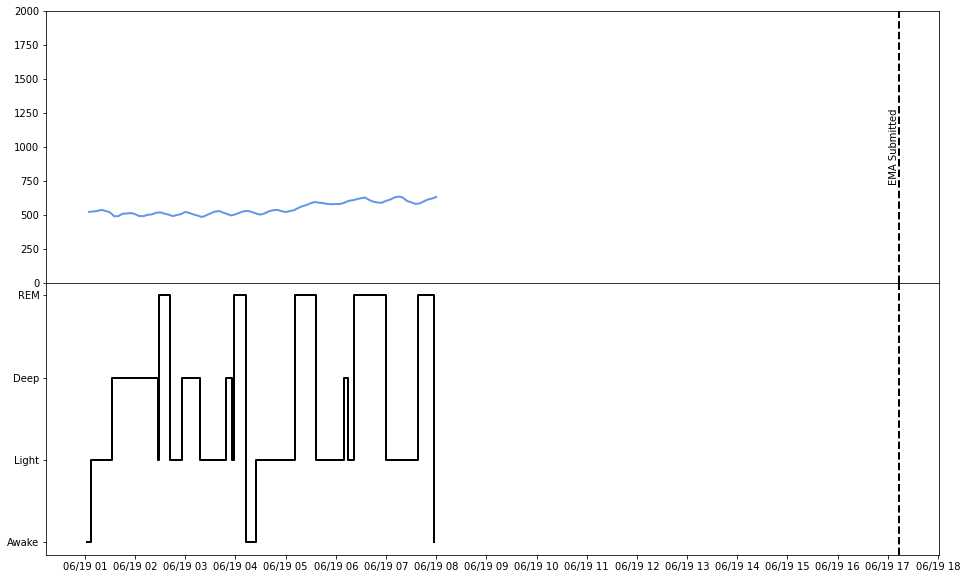

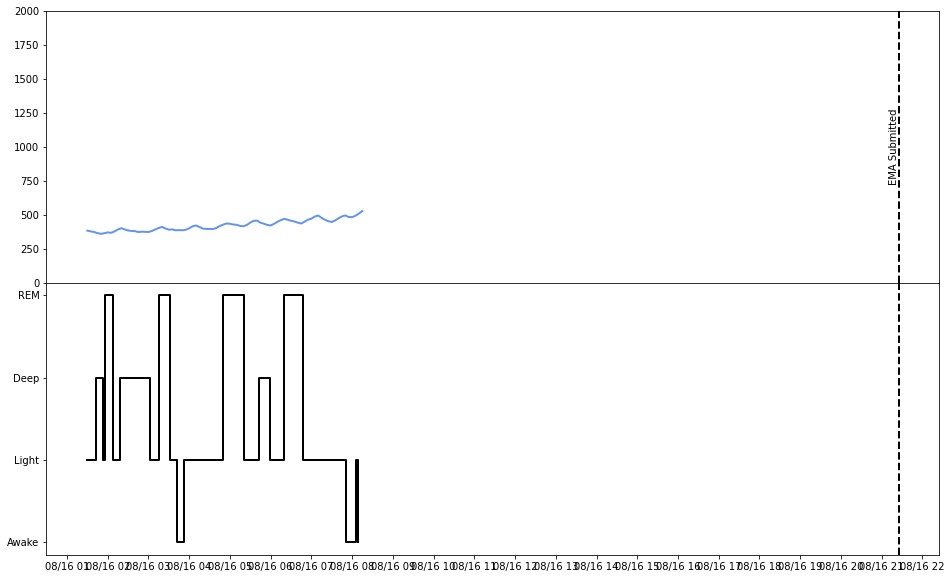

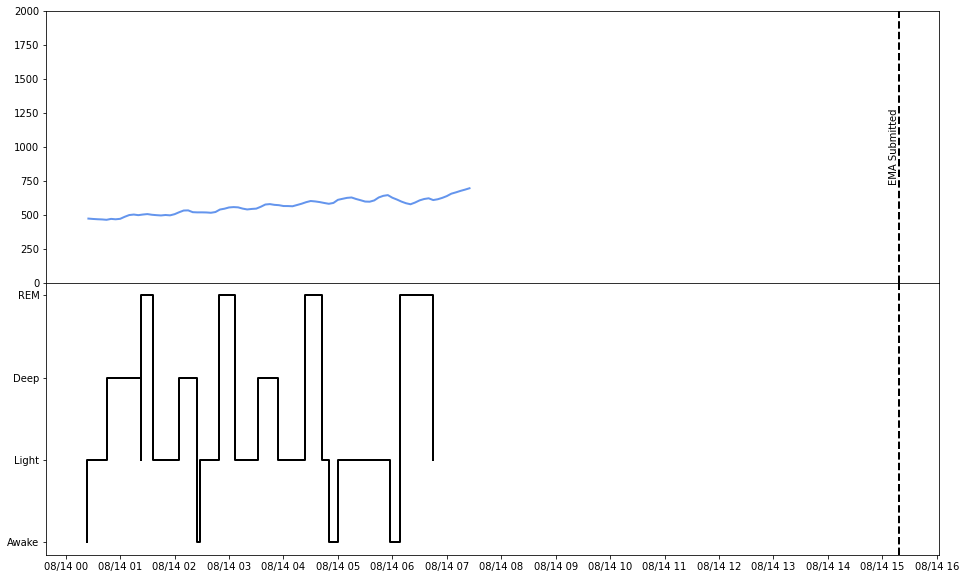

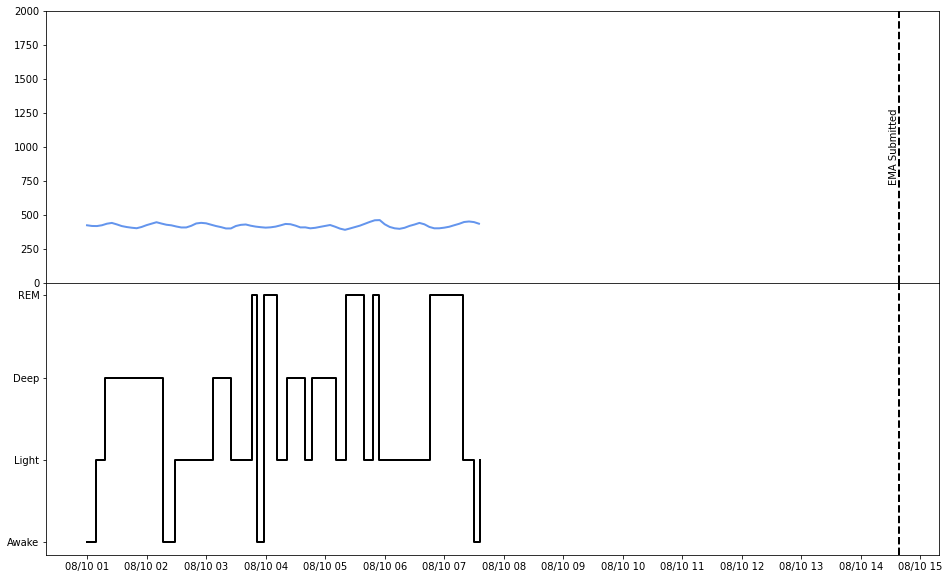

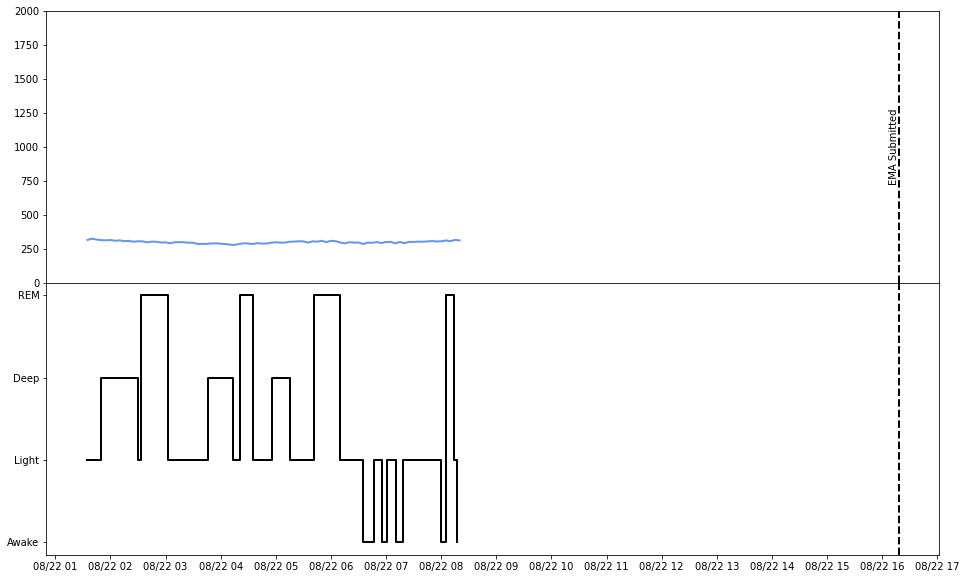

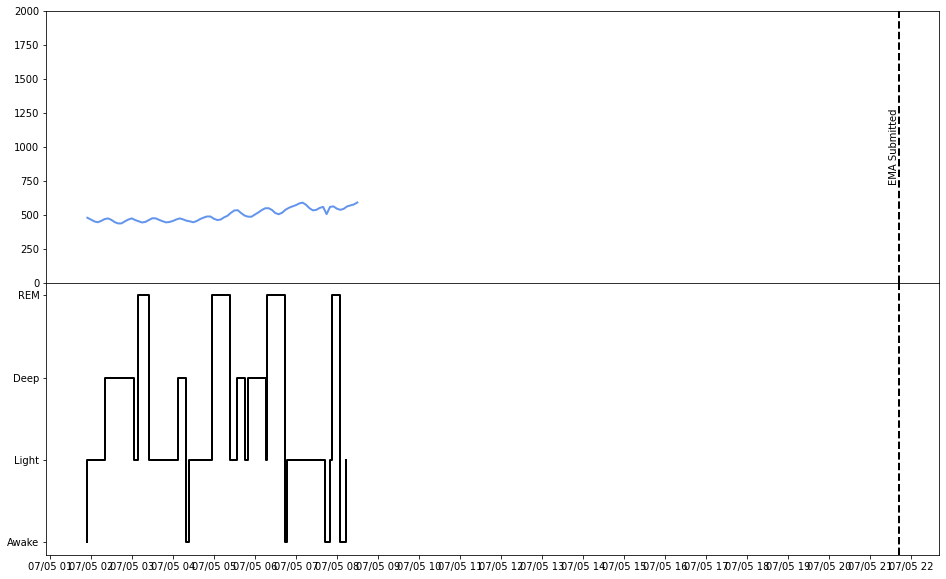

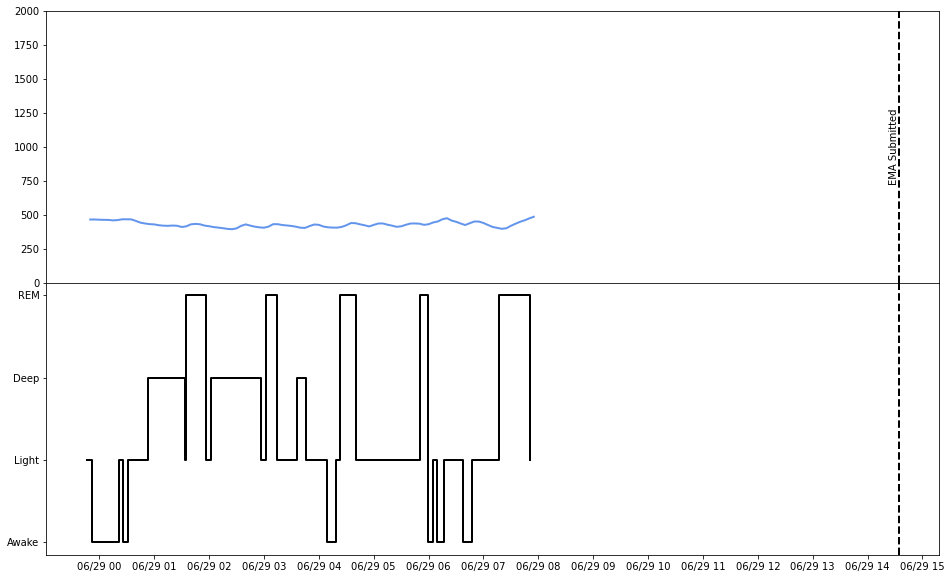

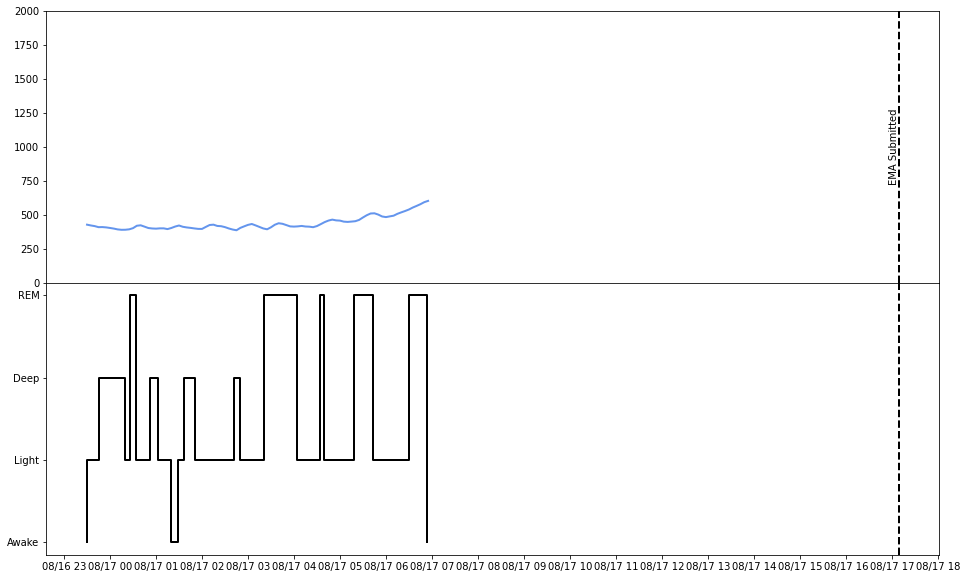

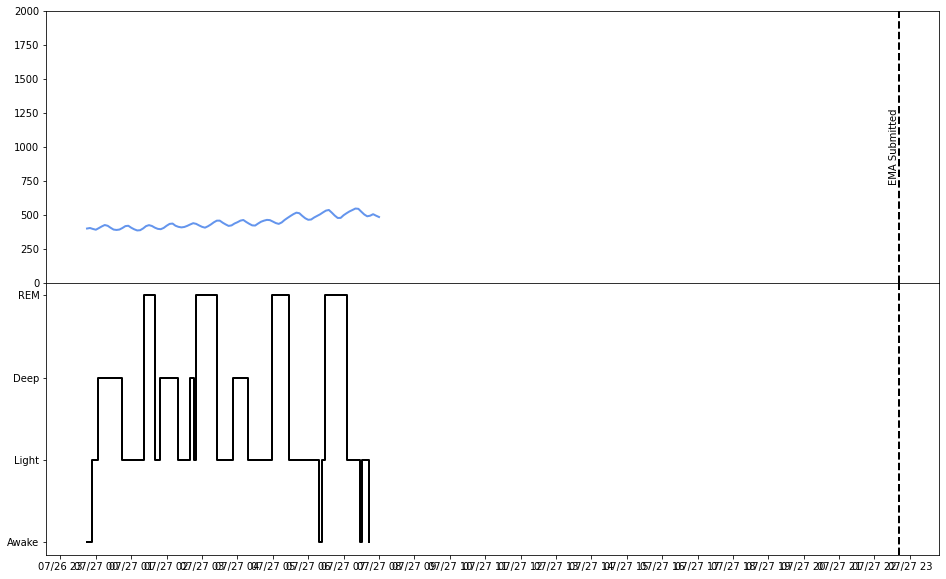

tmexej5v


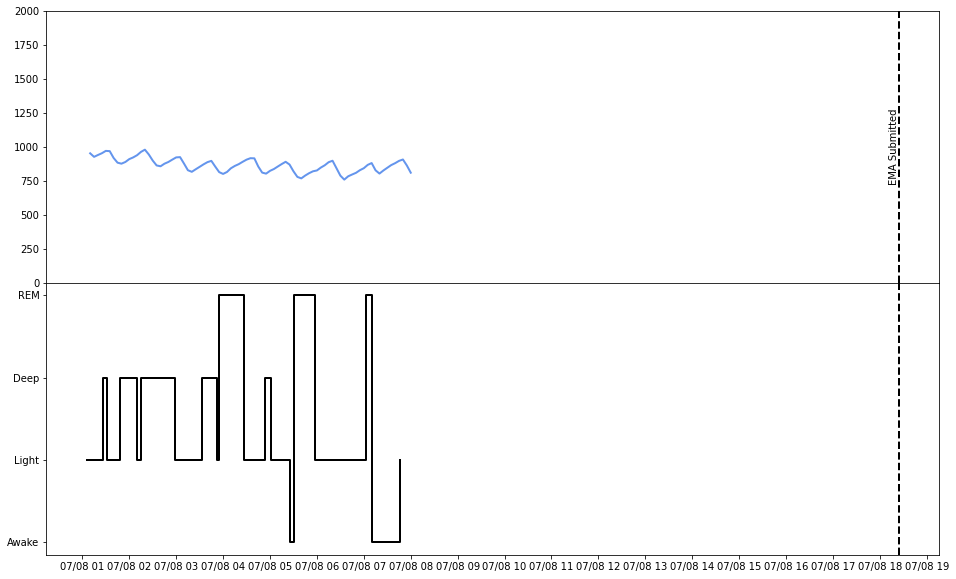

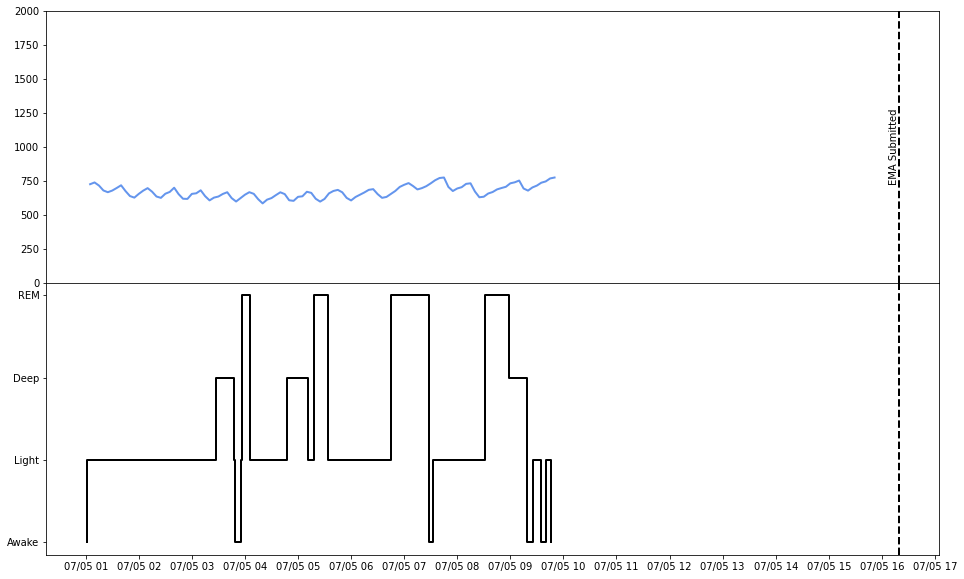

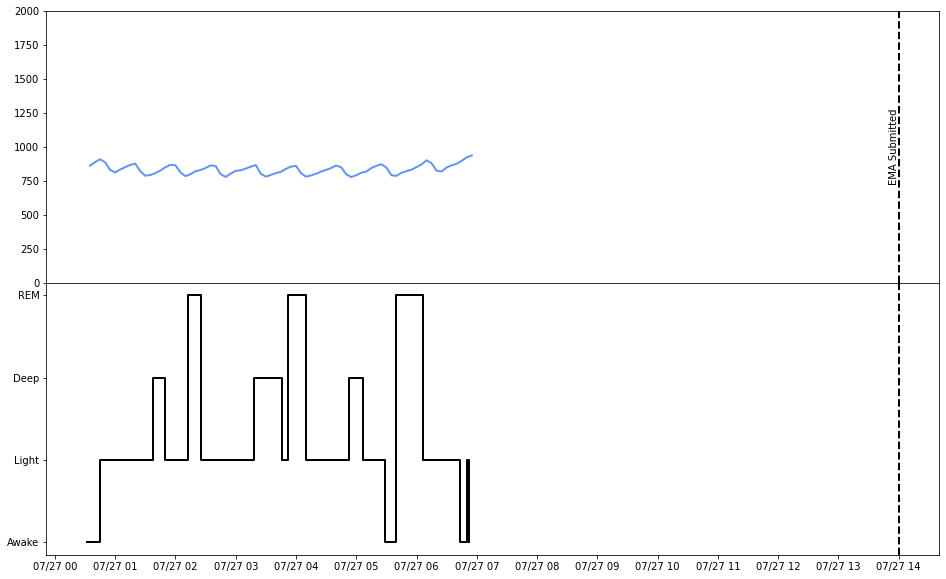

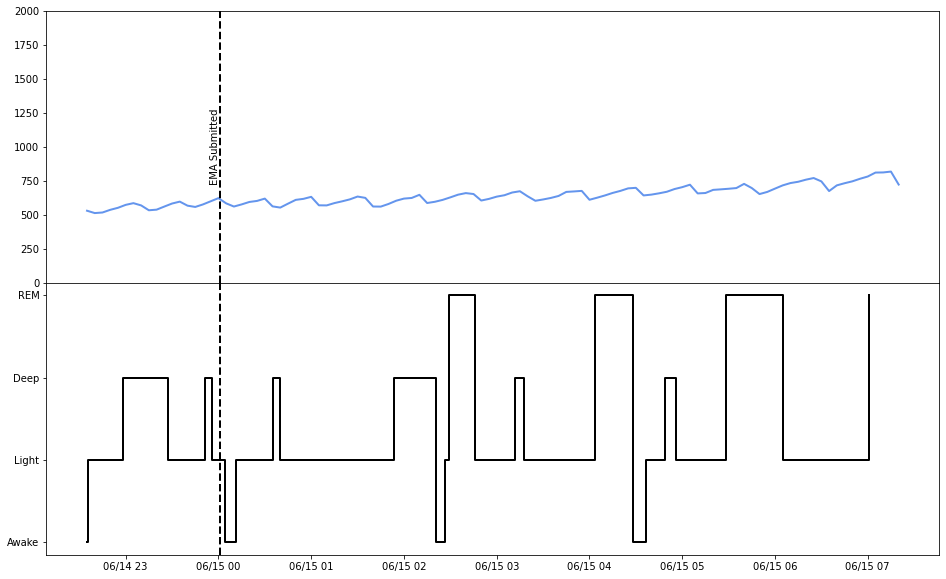

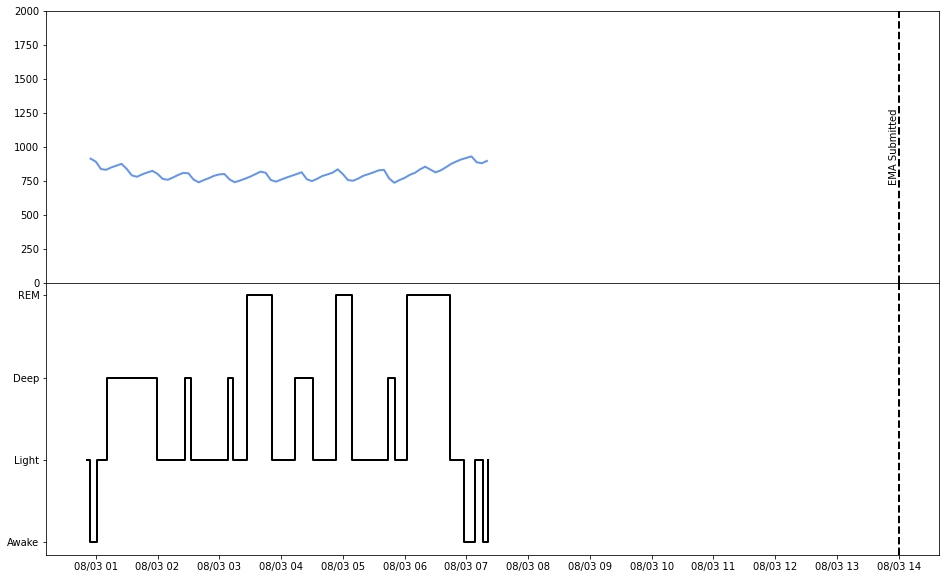

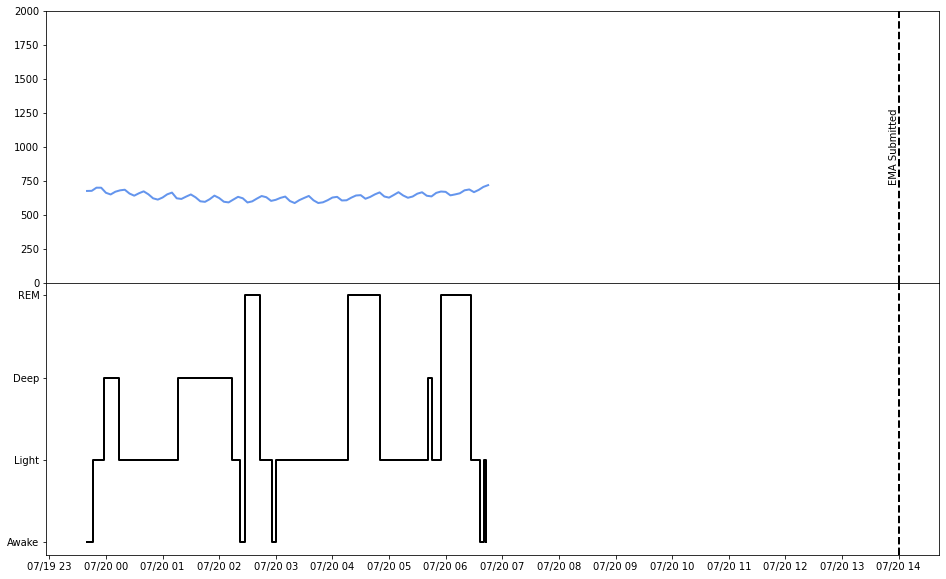

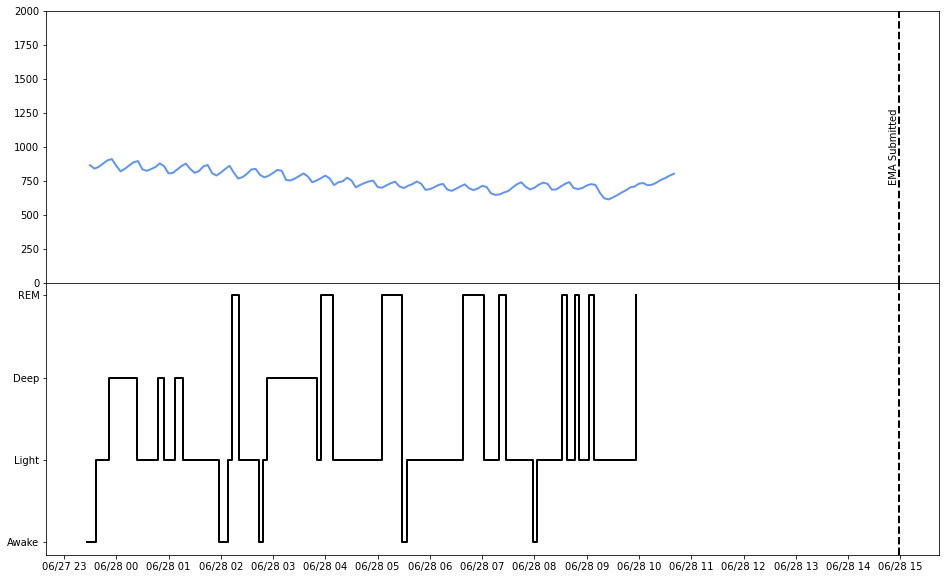

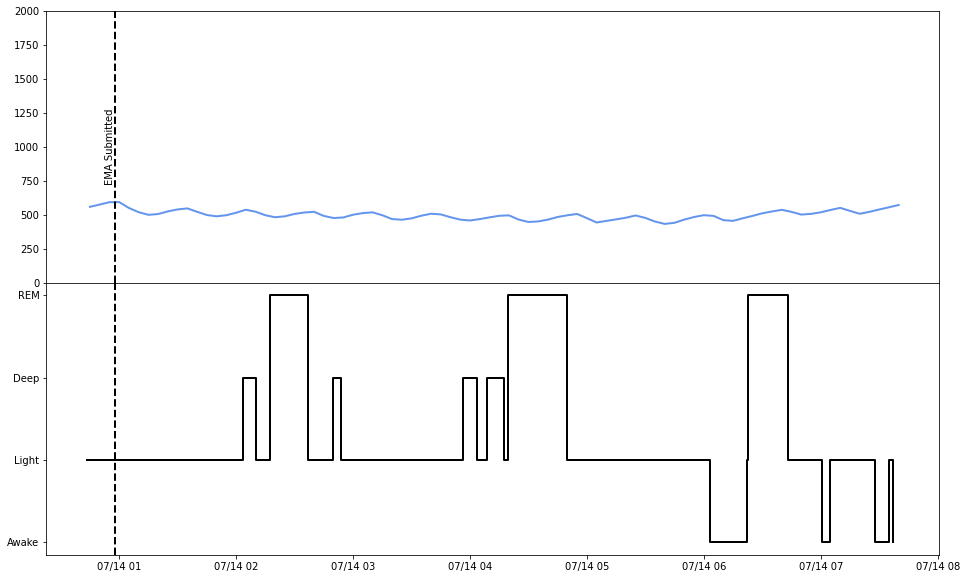

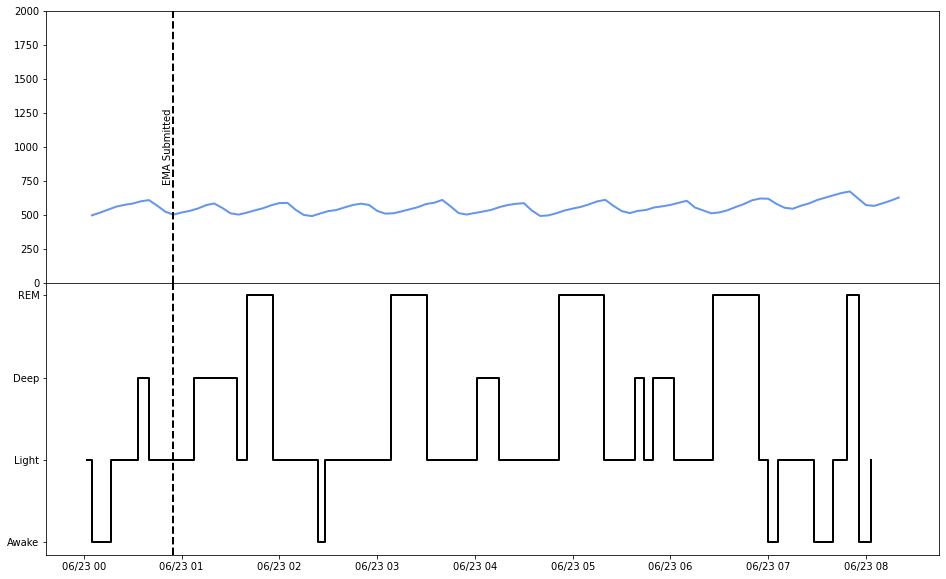

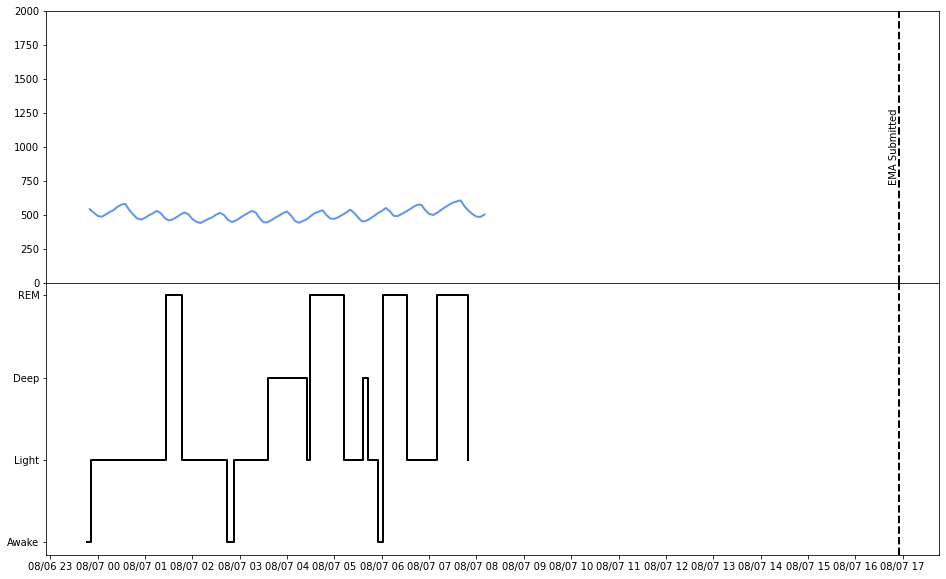

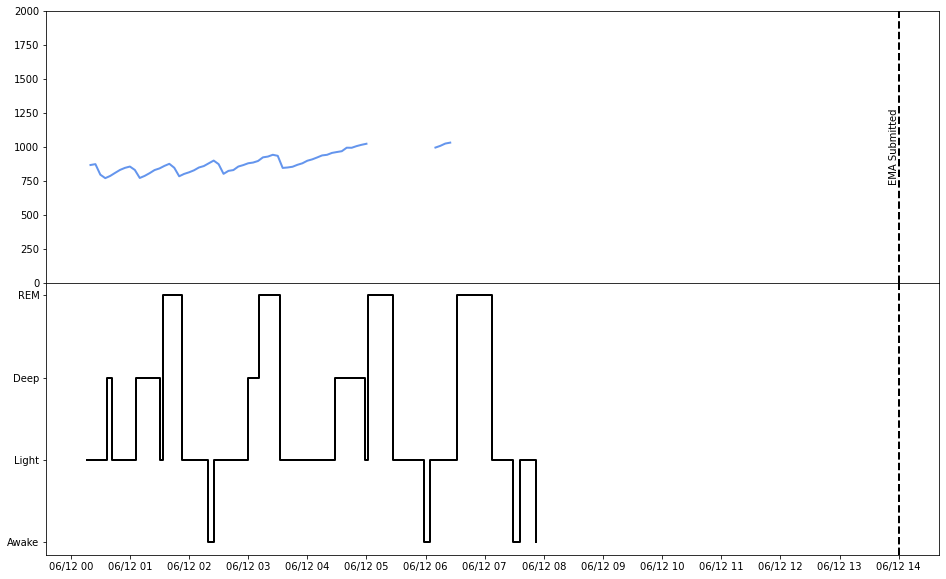

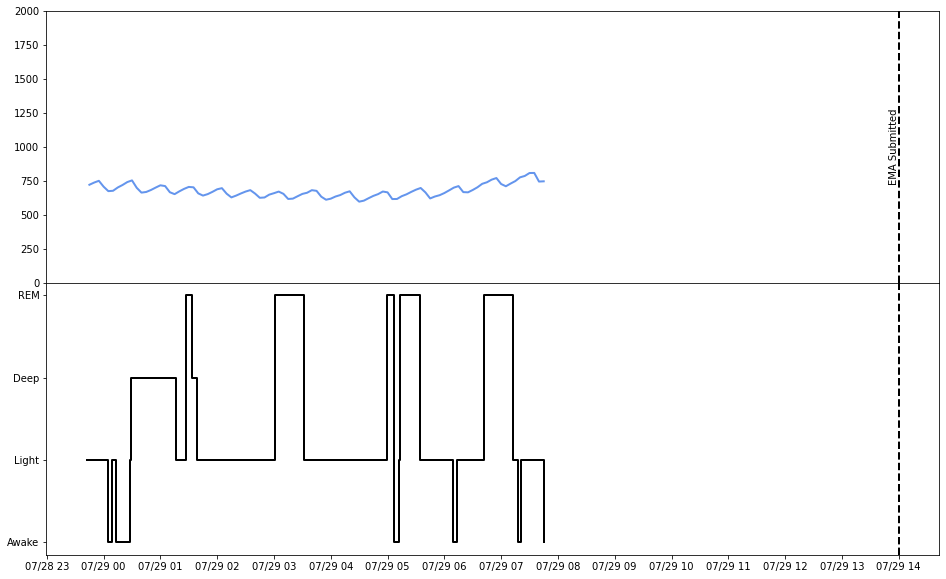

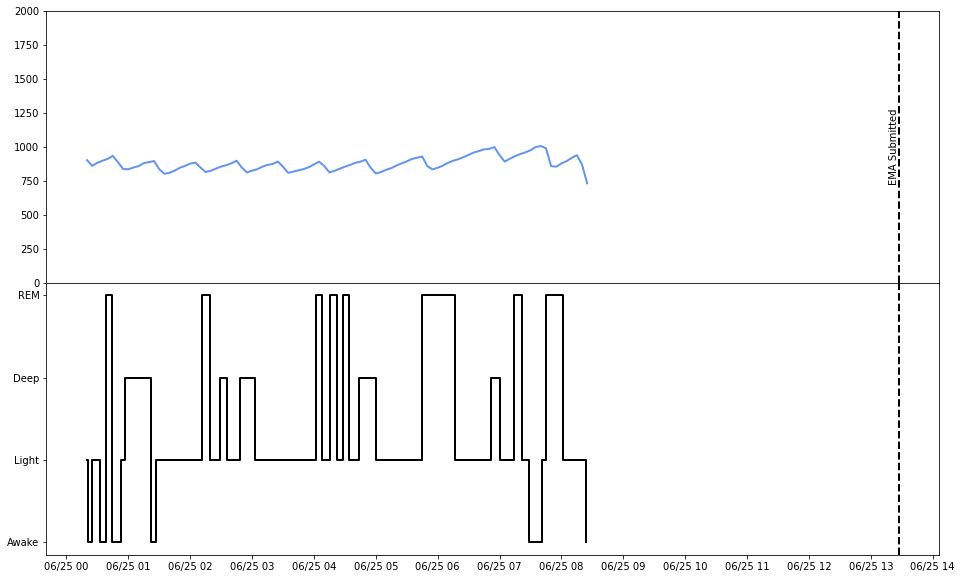

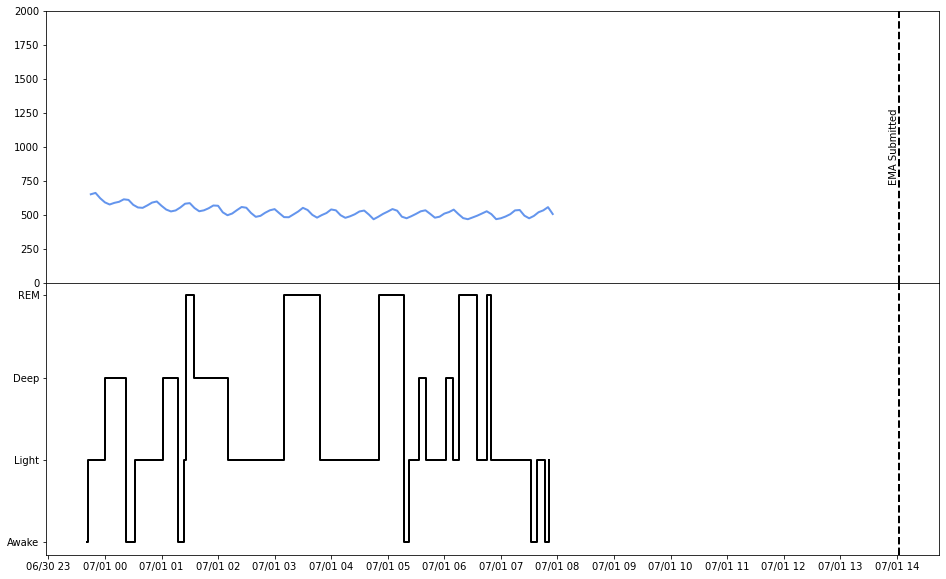

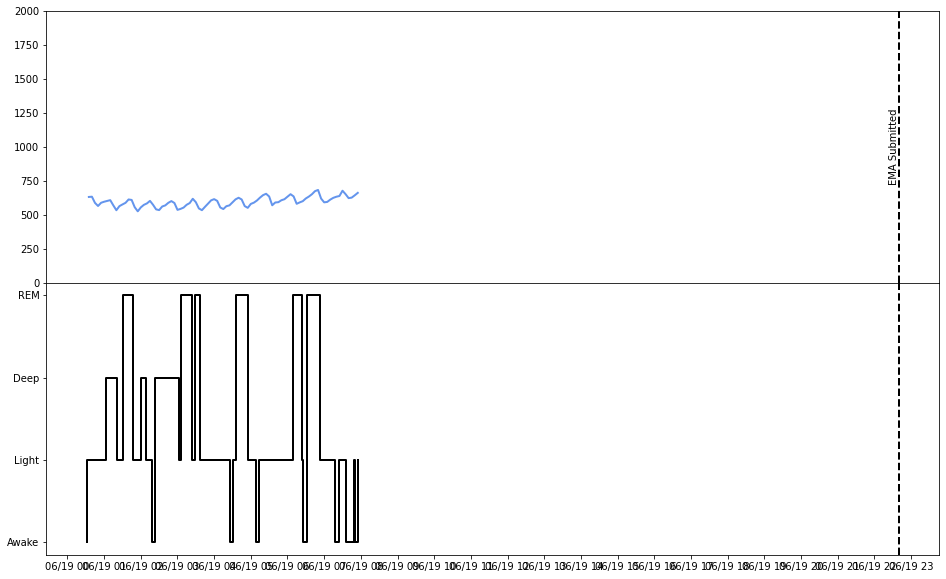

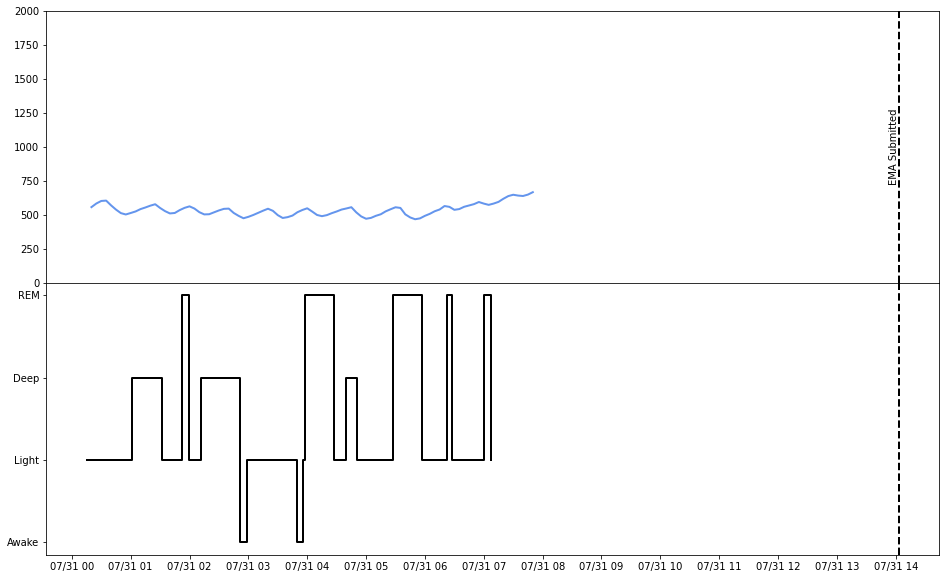

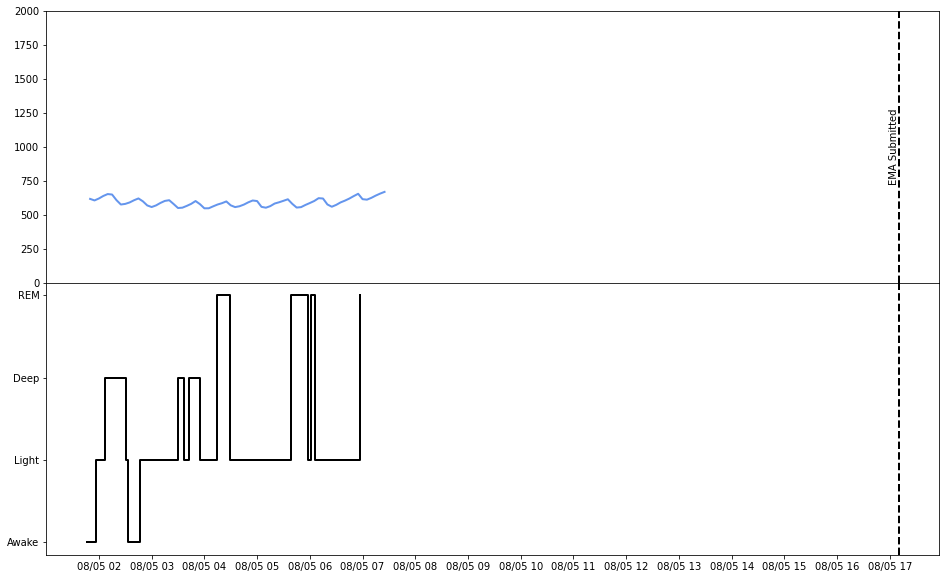

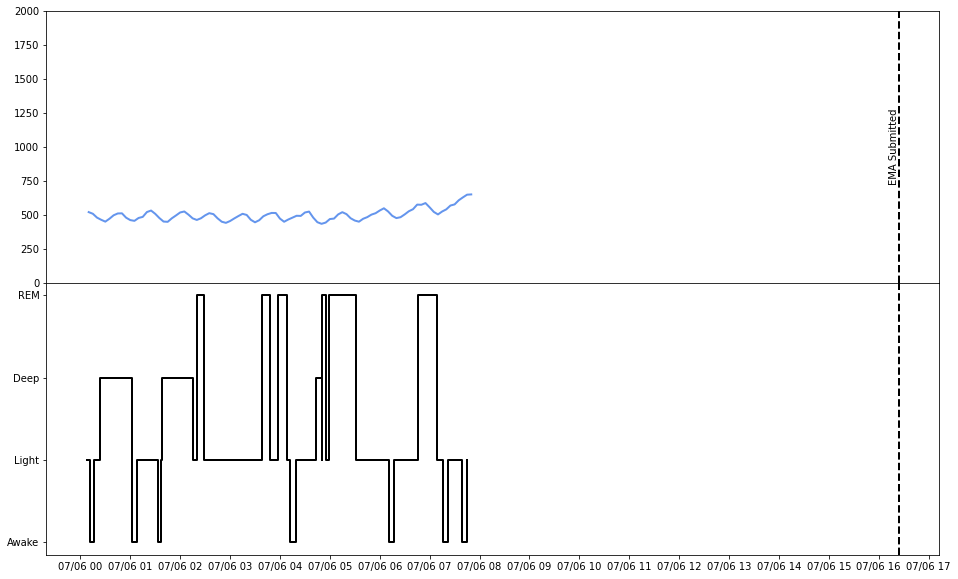

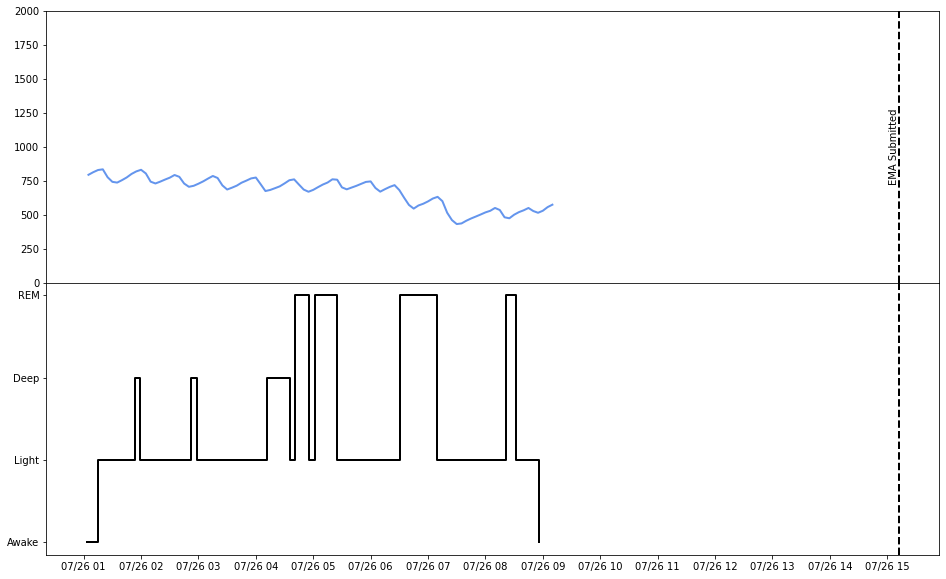

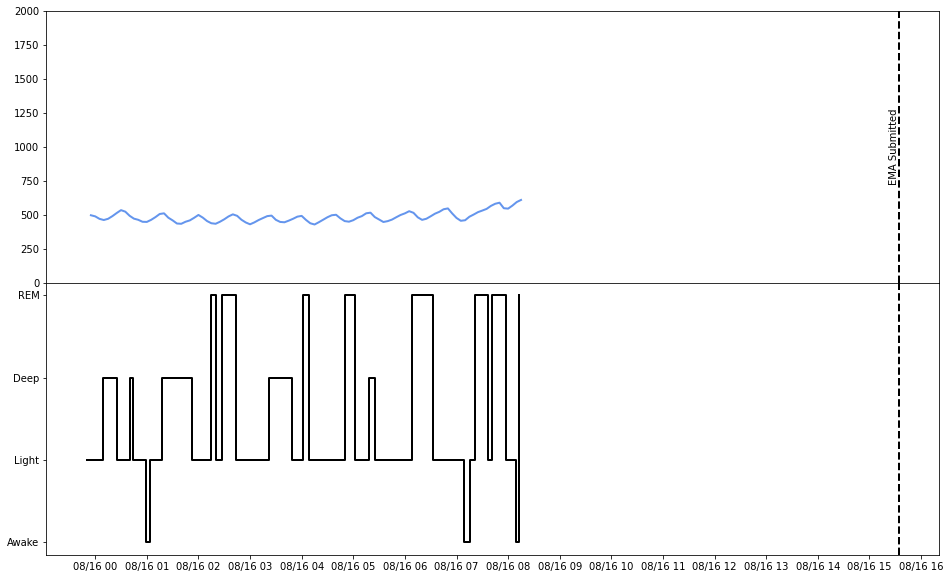

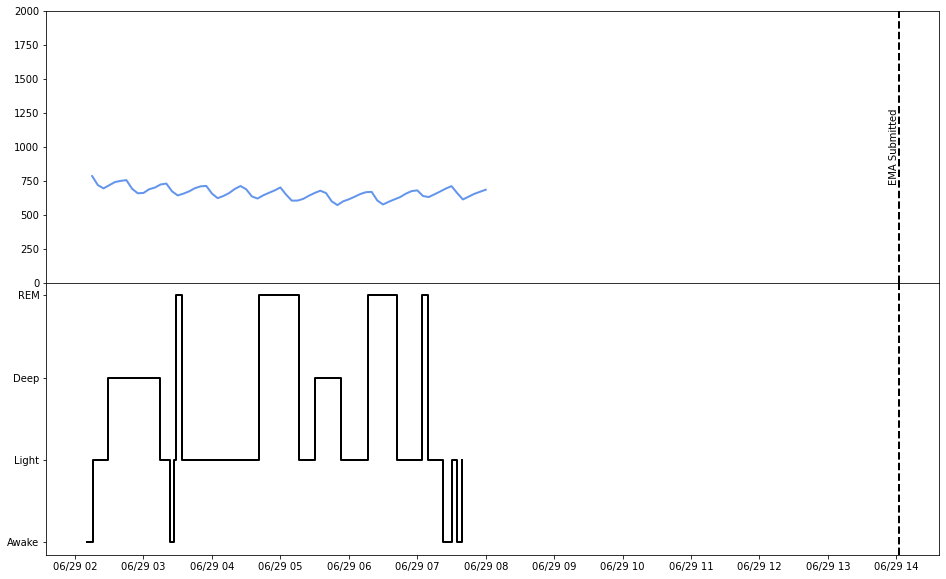

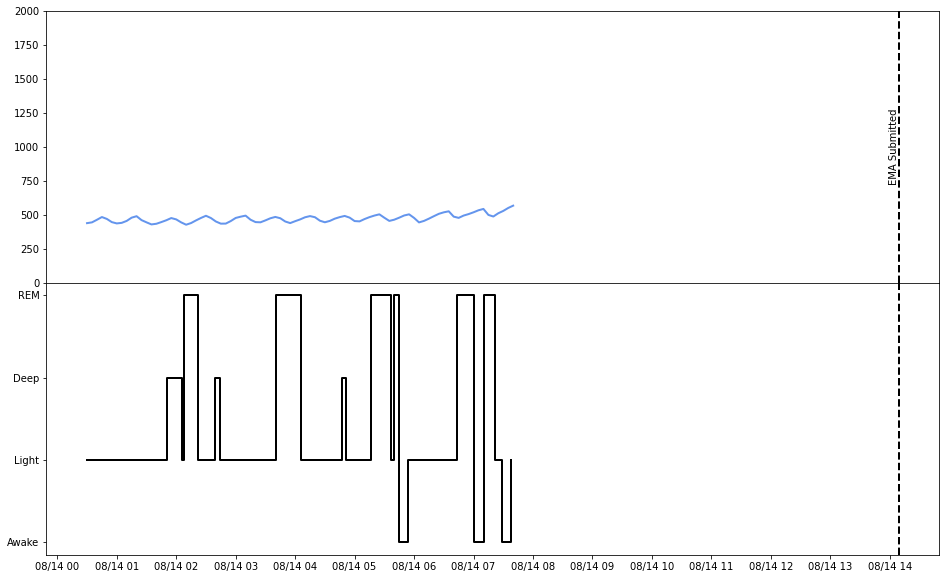

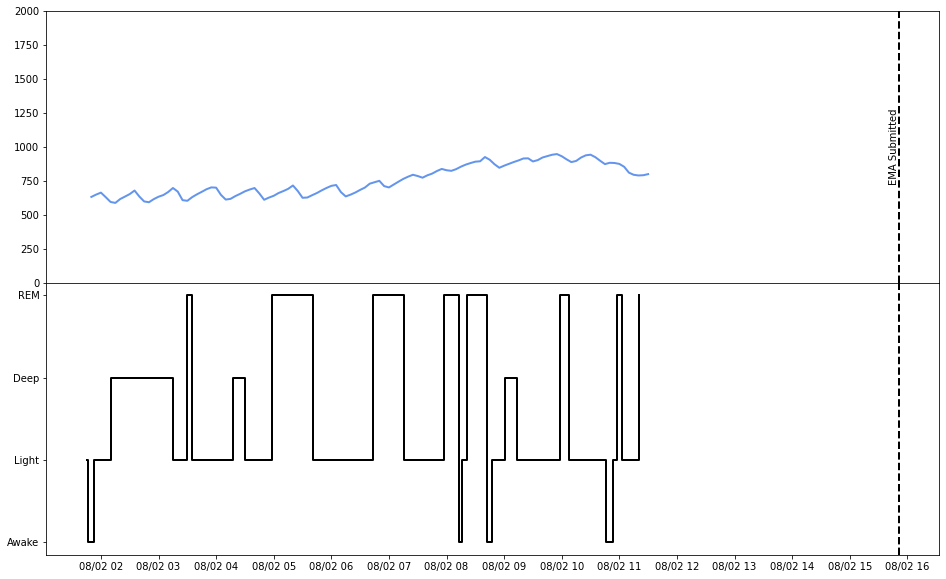

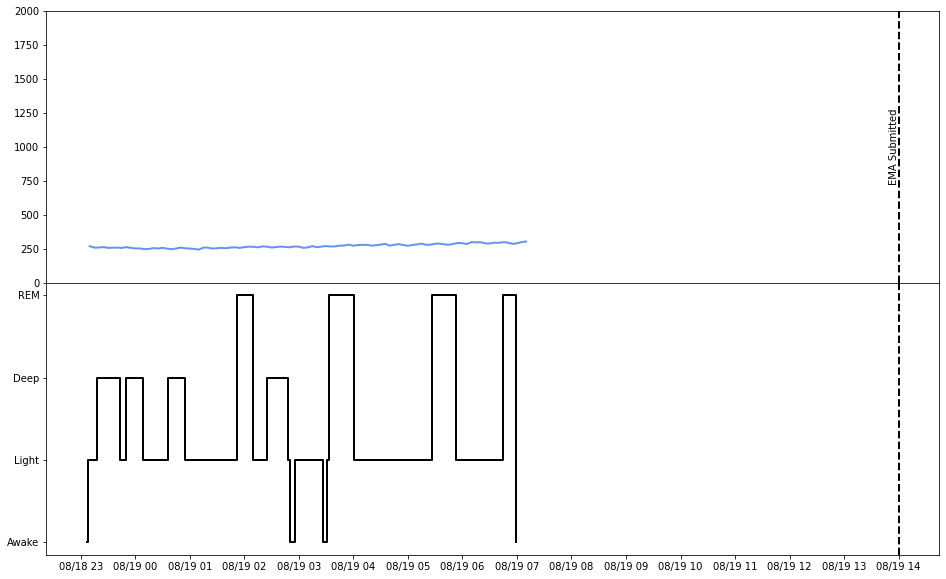

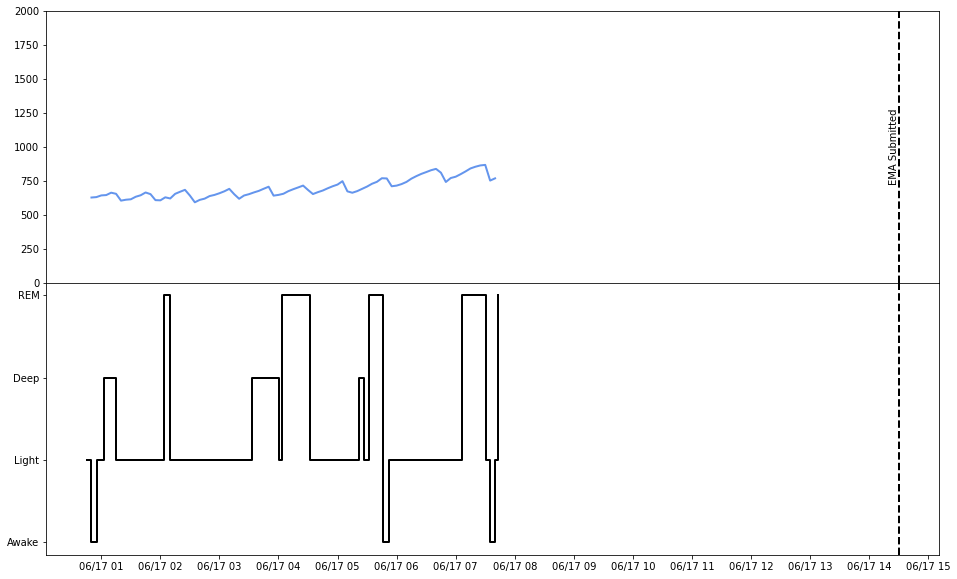

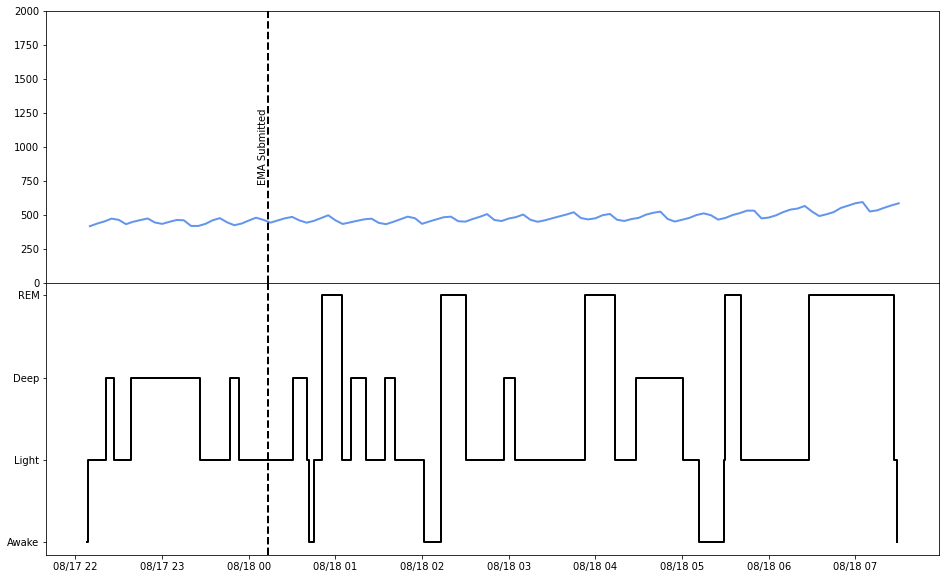

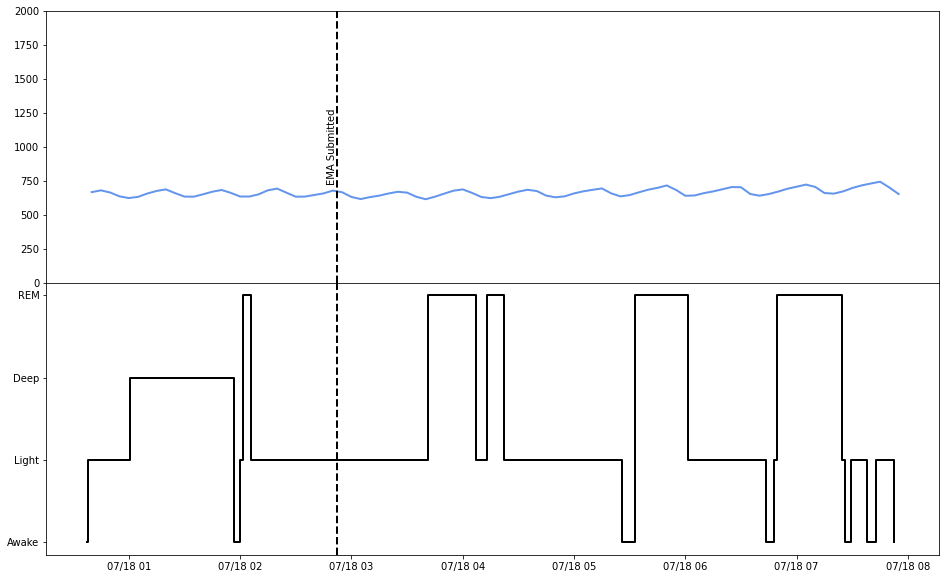

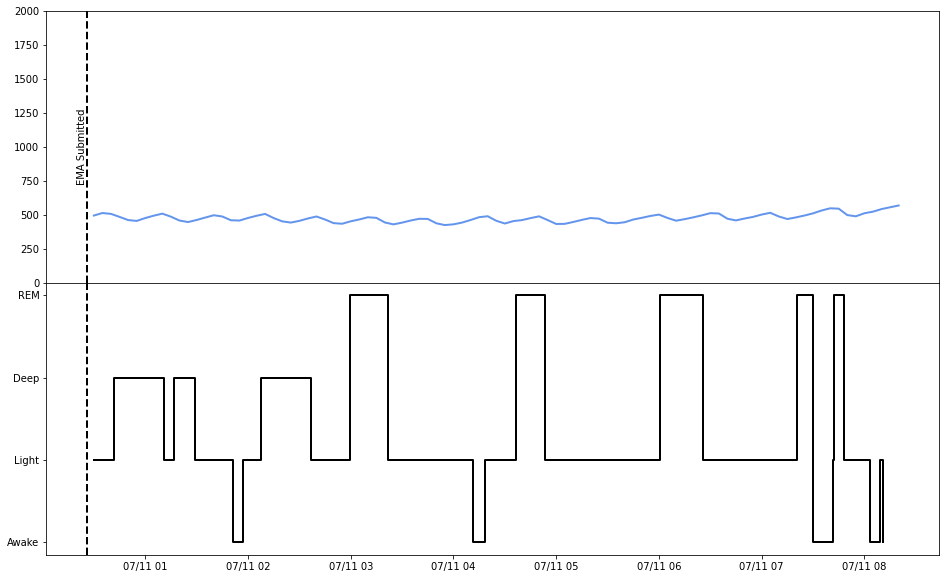

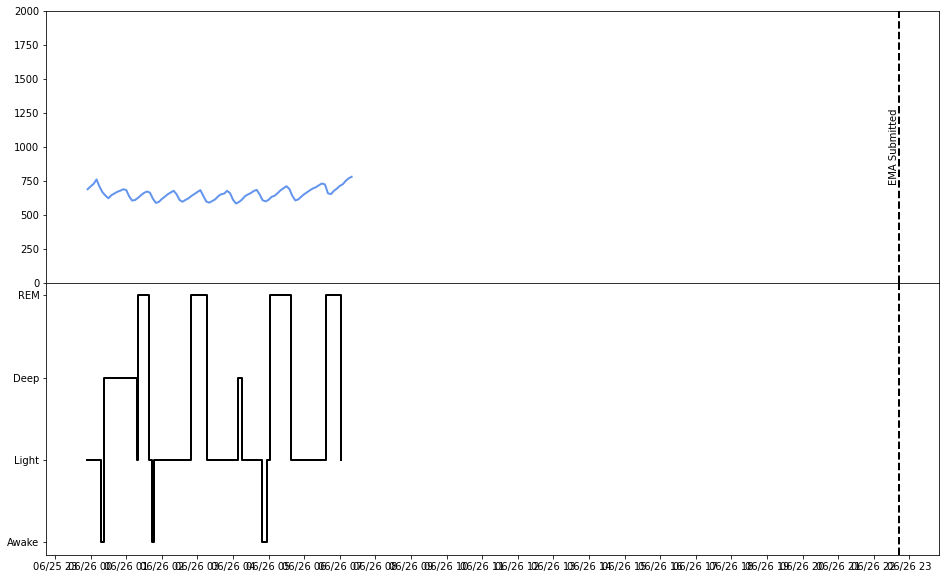

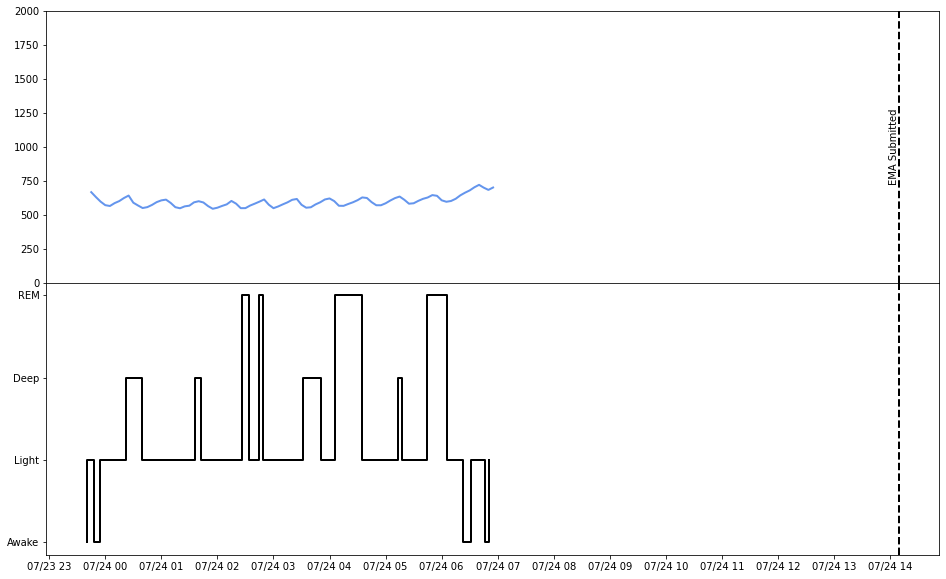

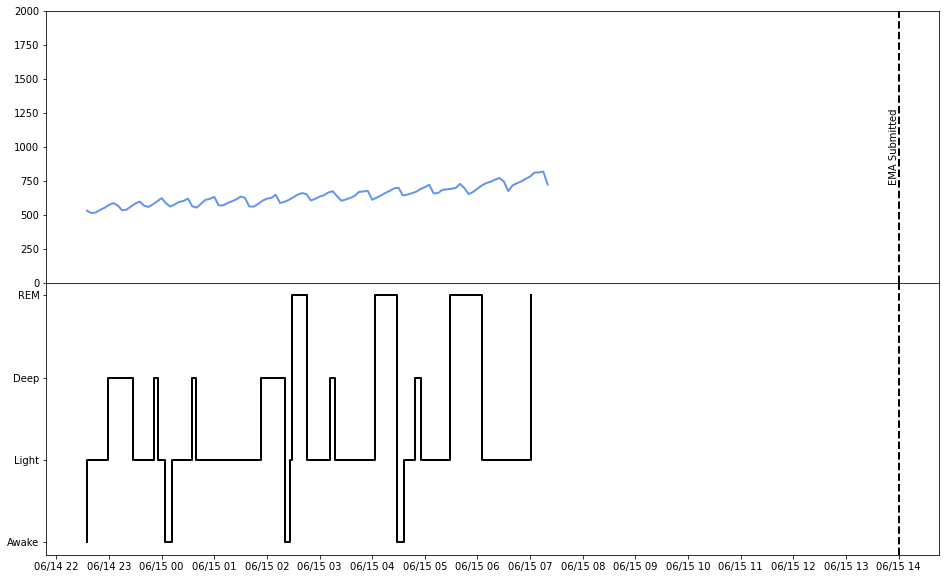

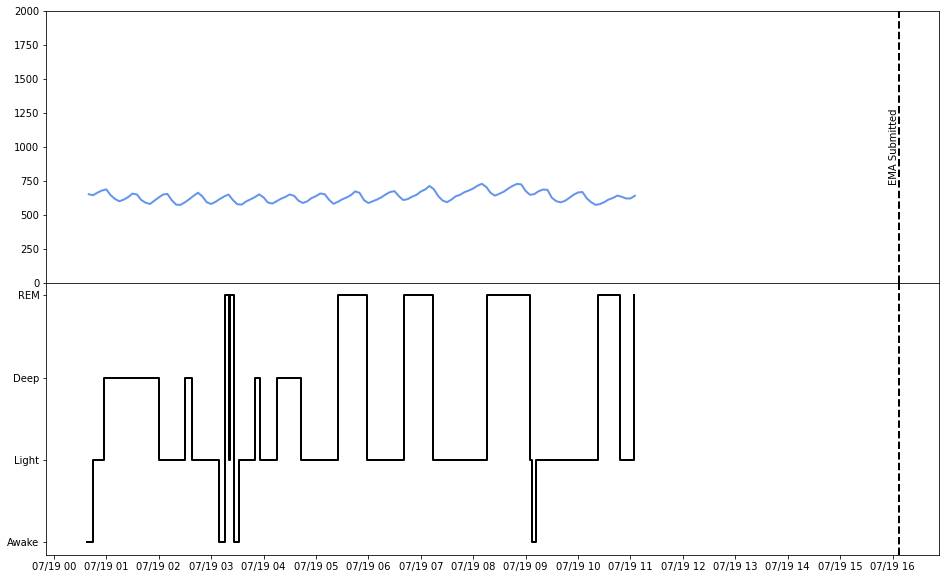

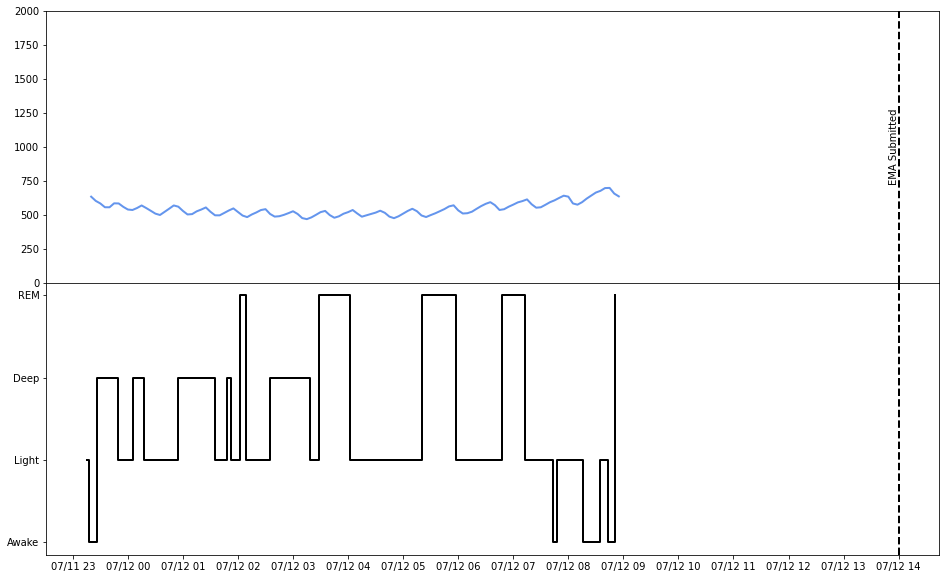

vr9j5rry


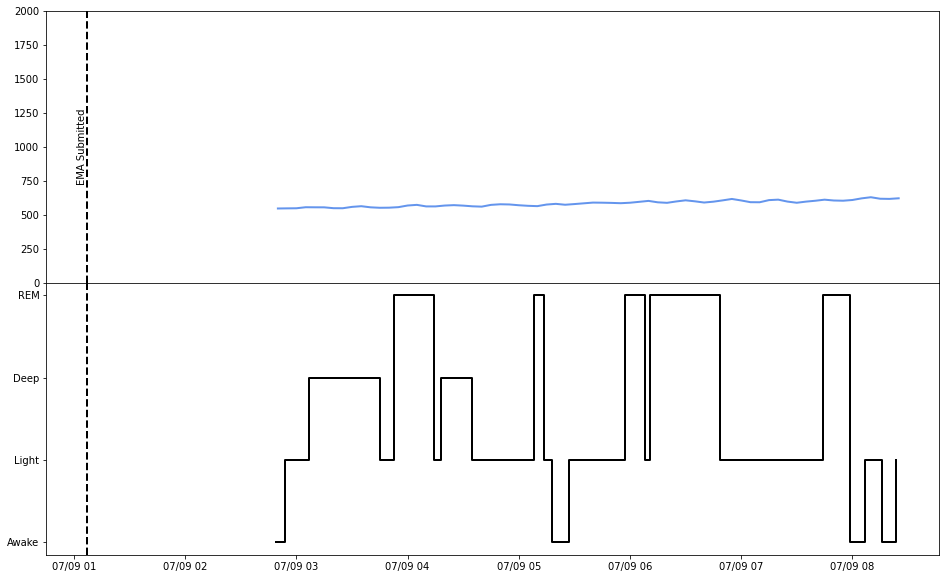

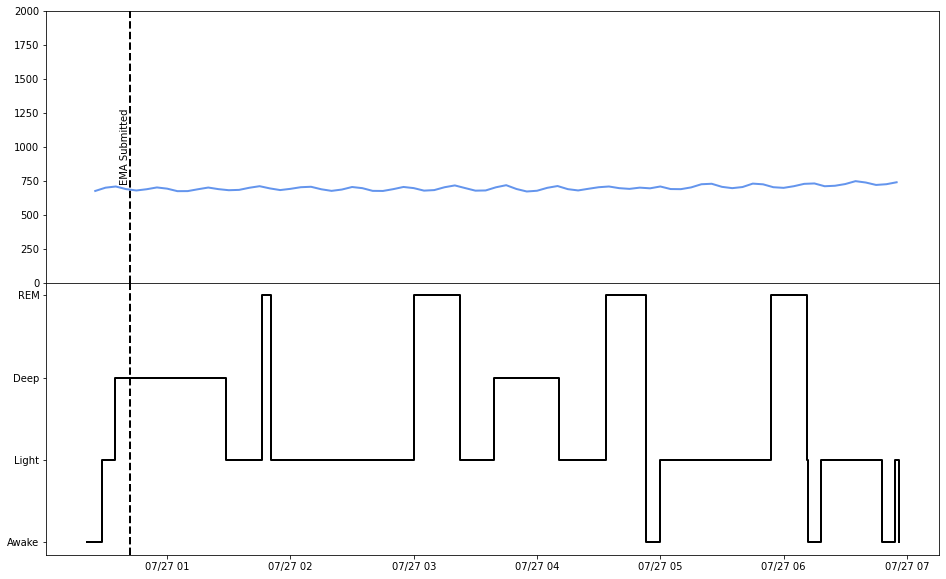

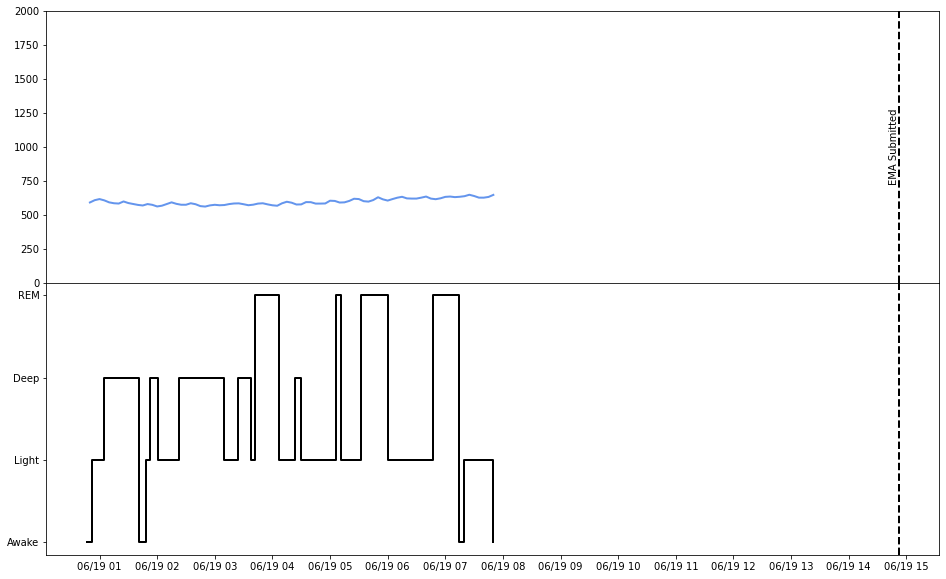

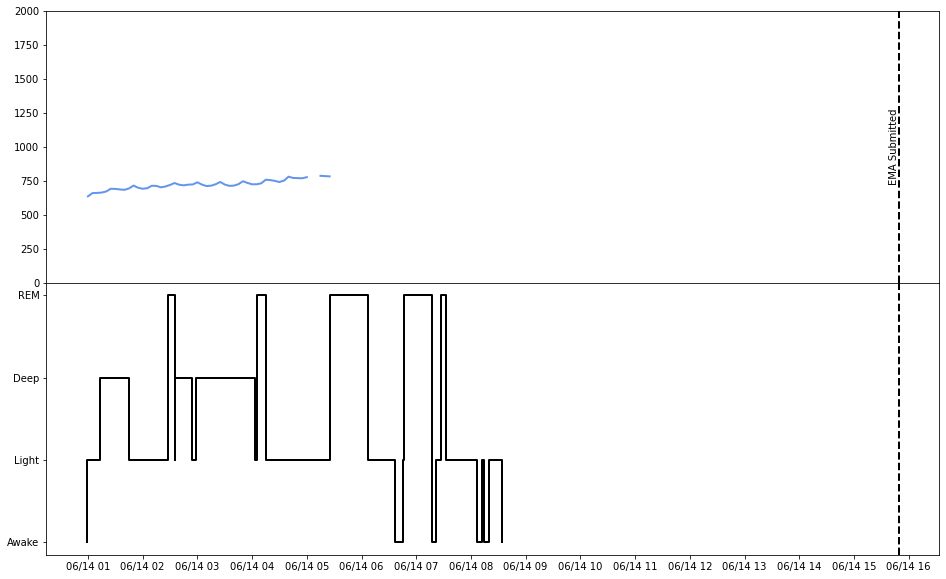

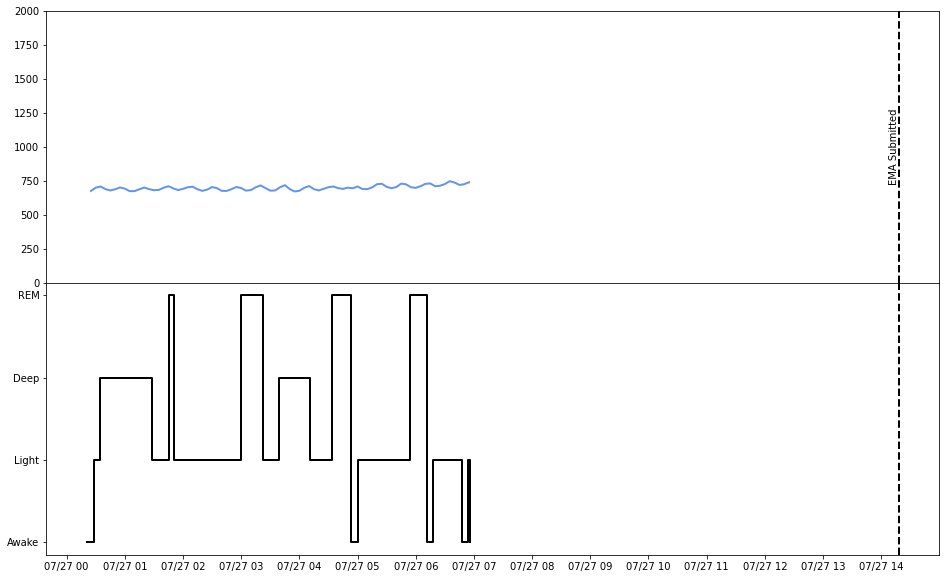

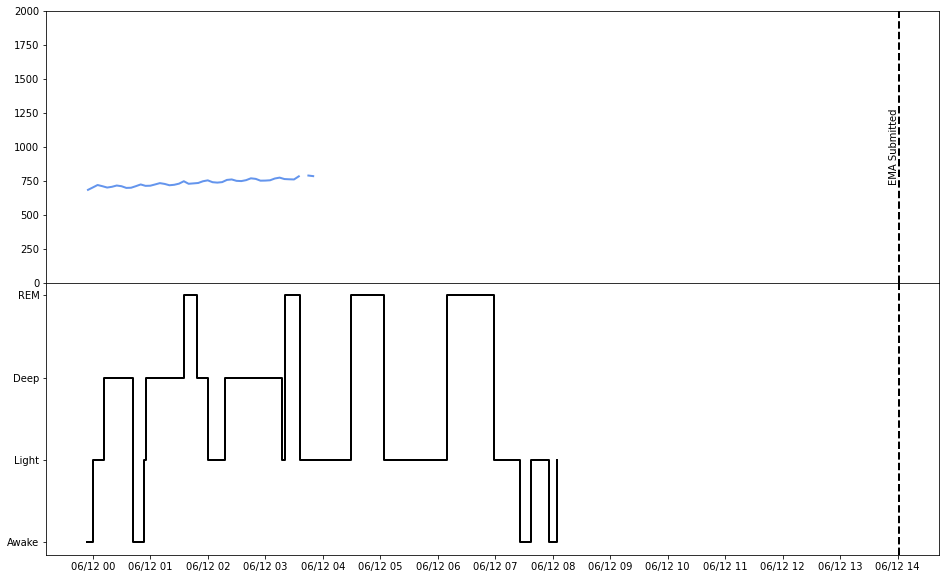

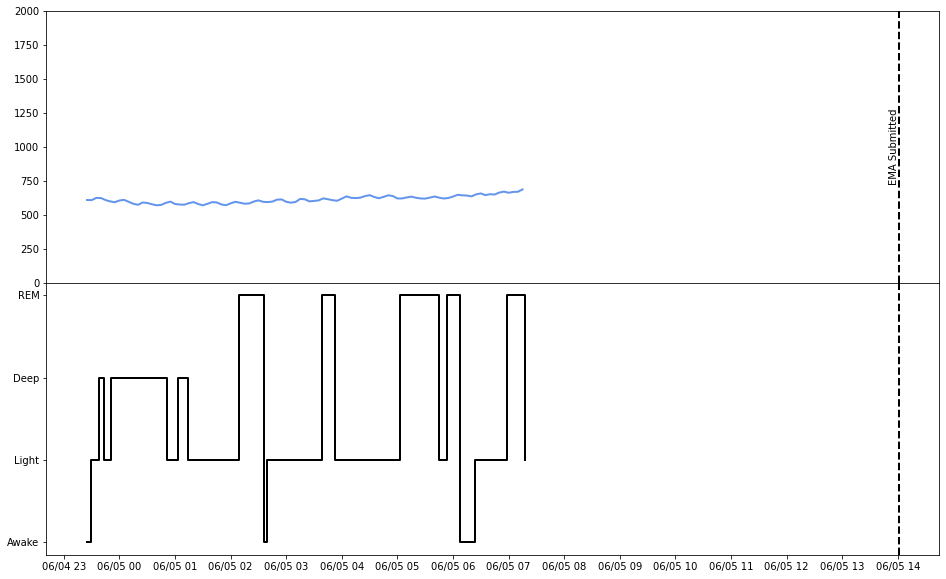

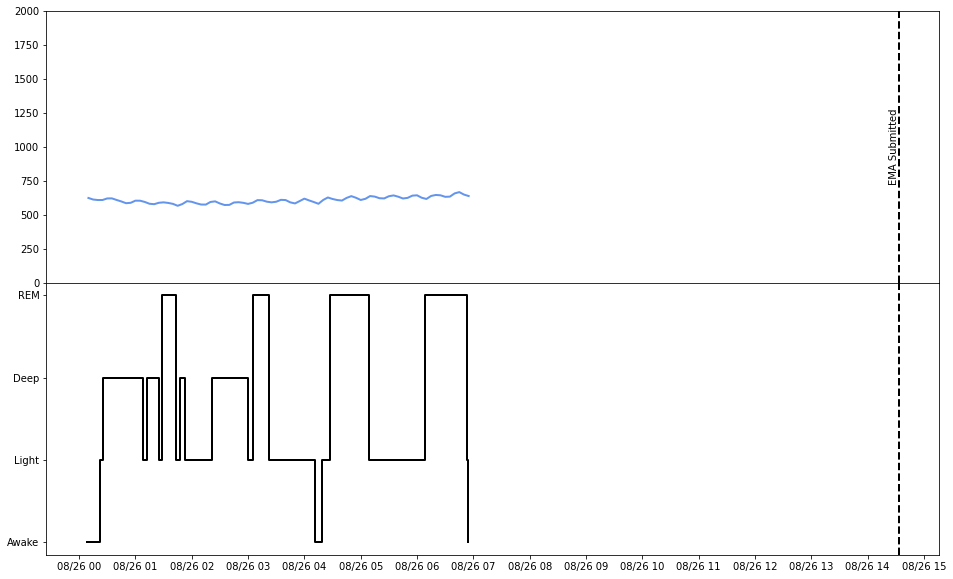

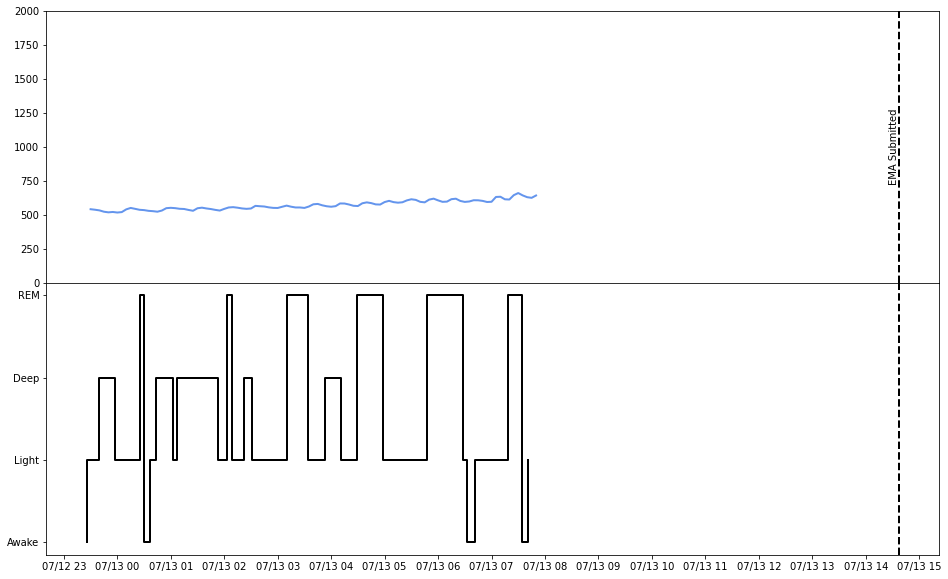

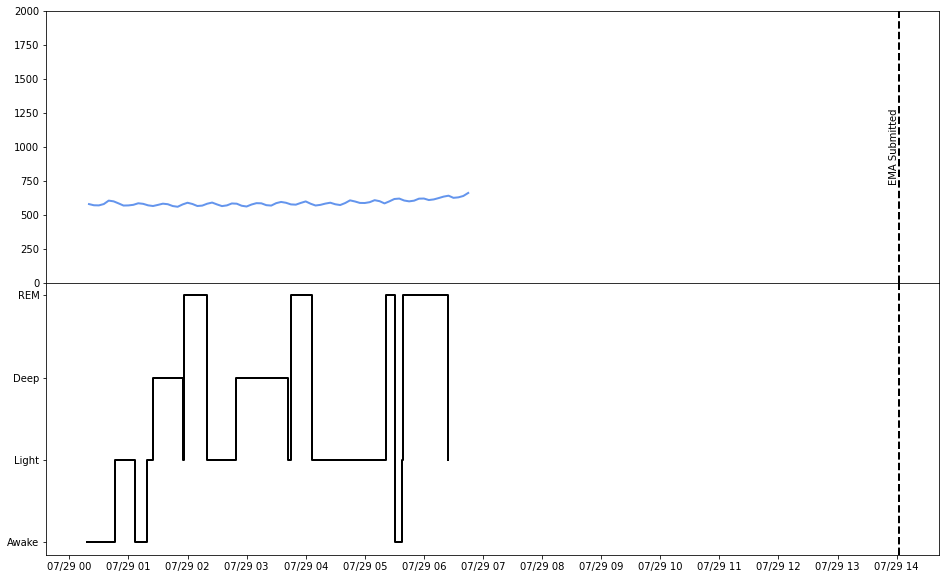

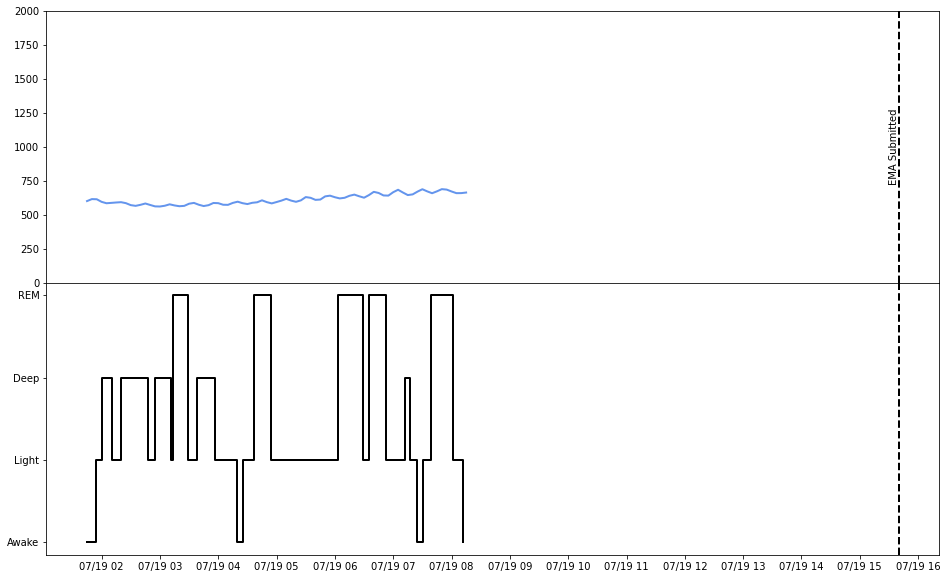

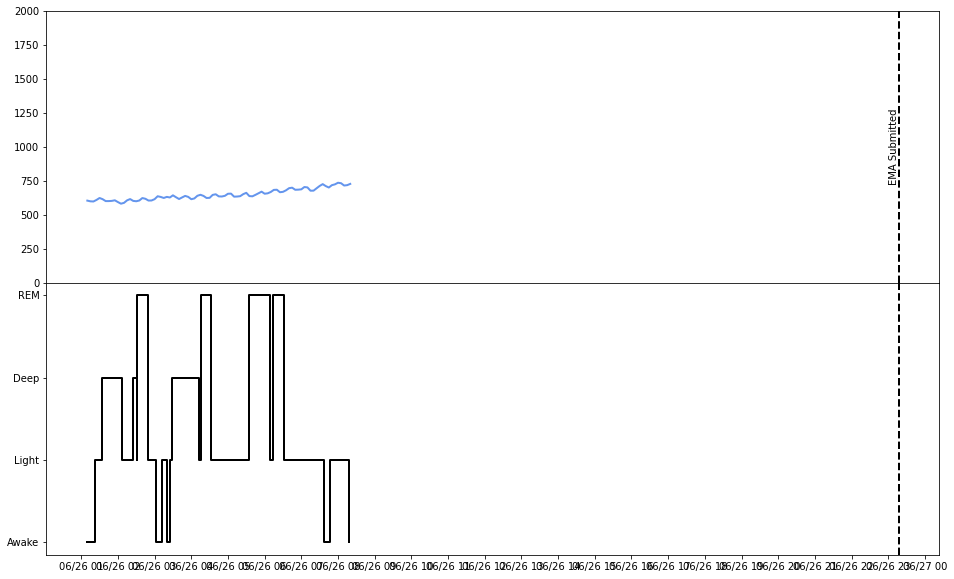

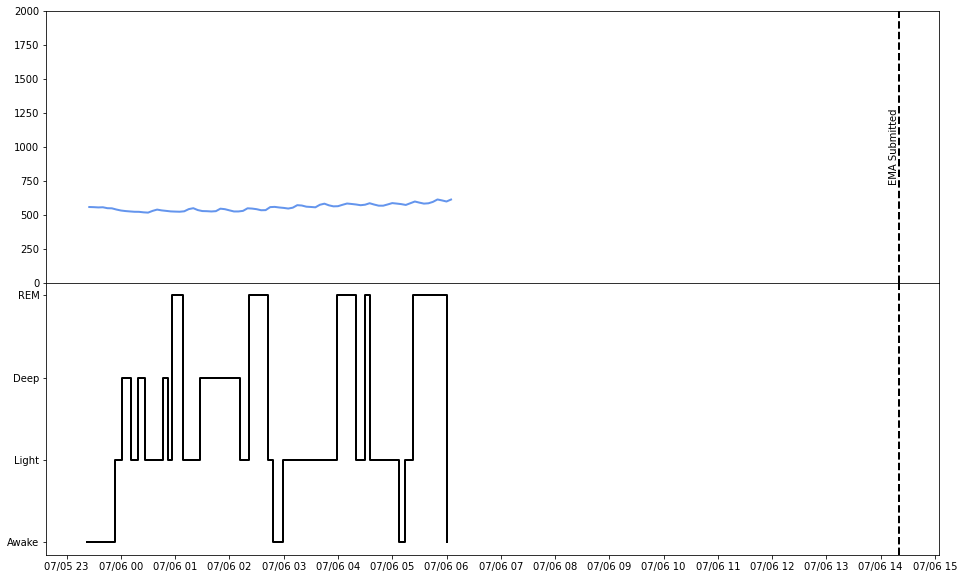

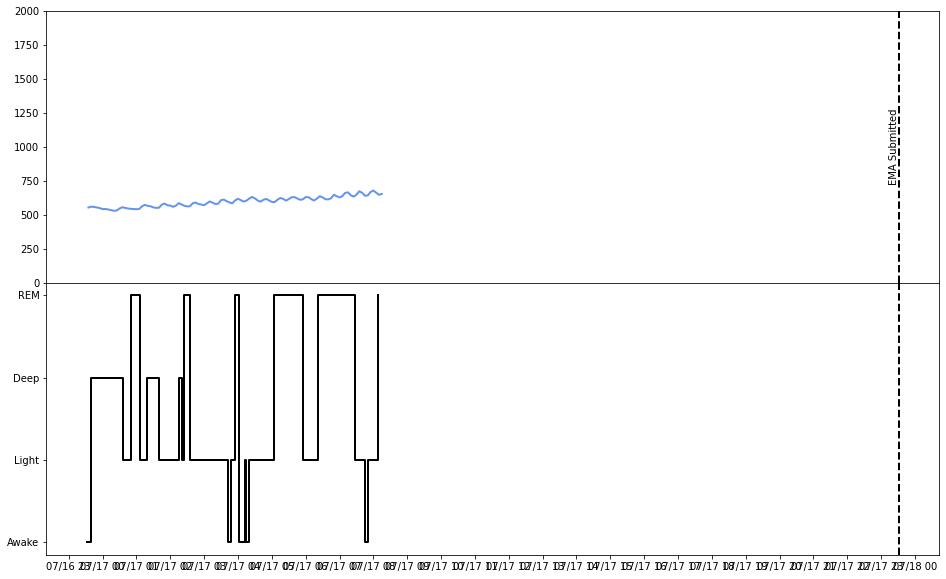

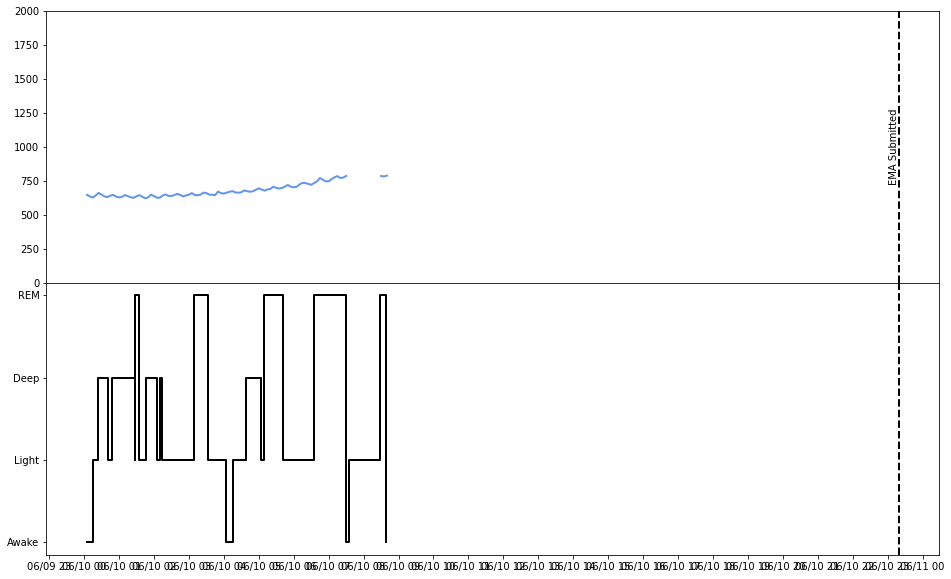

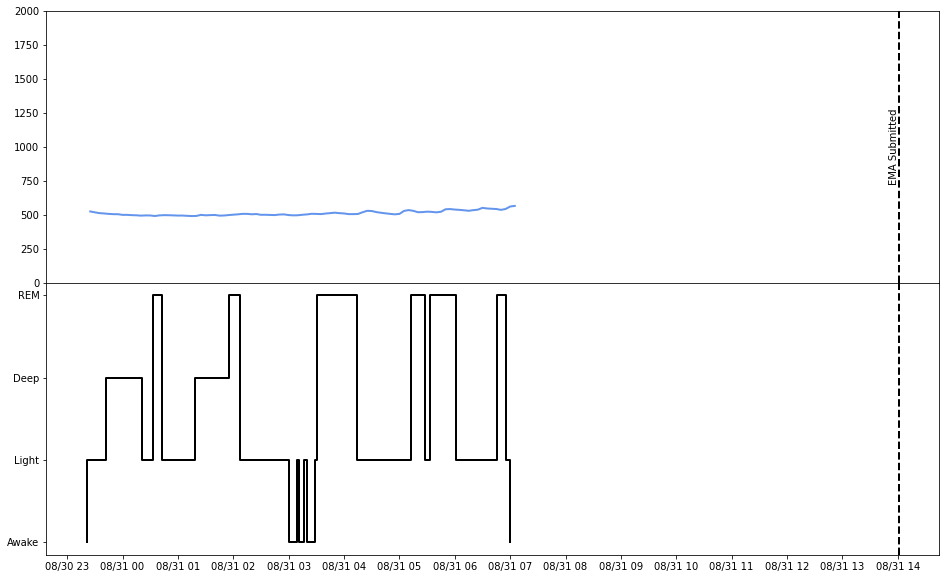

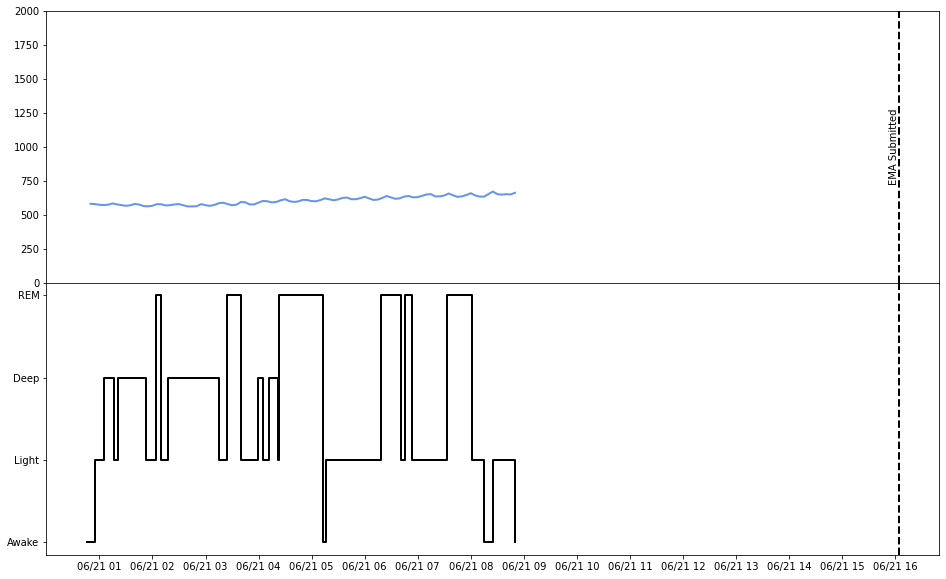

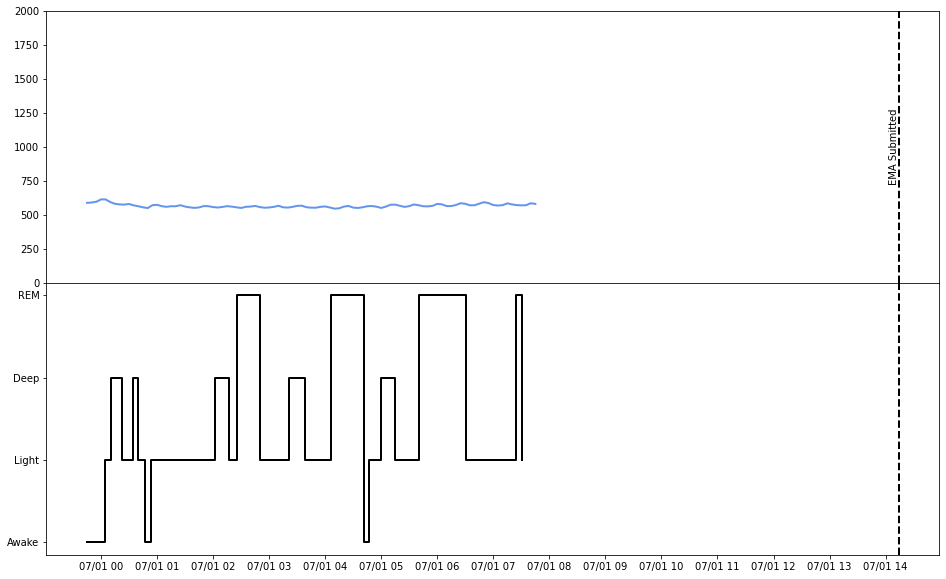

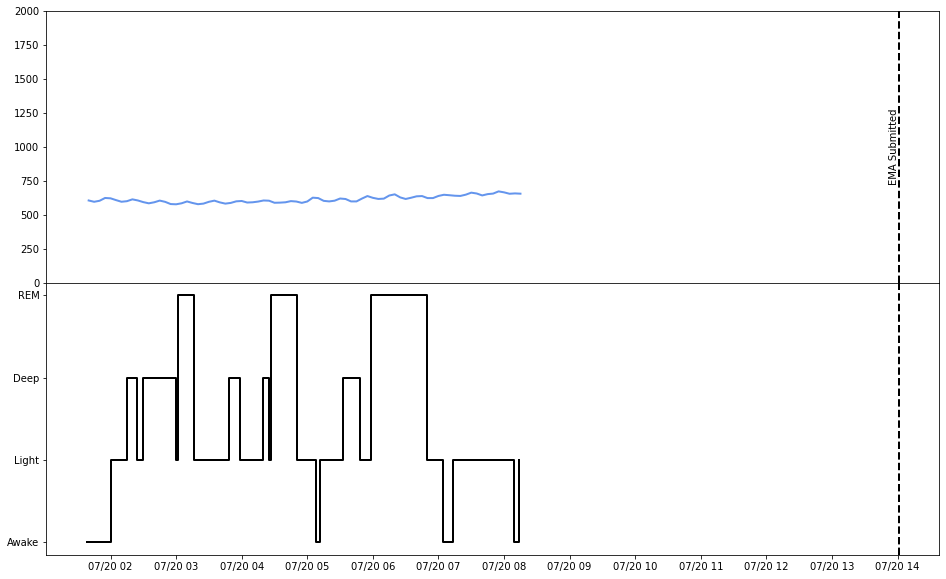

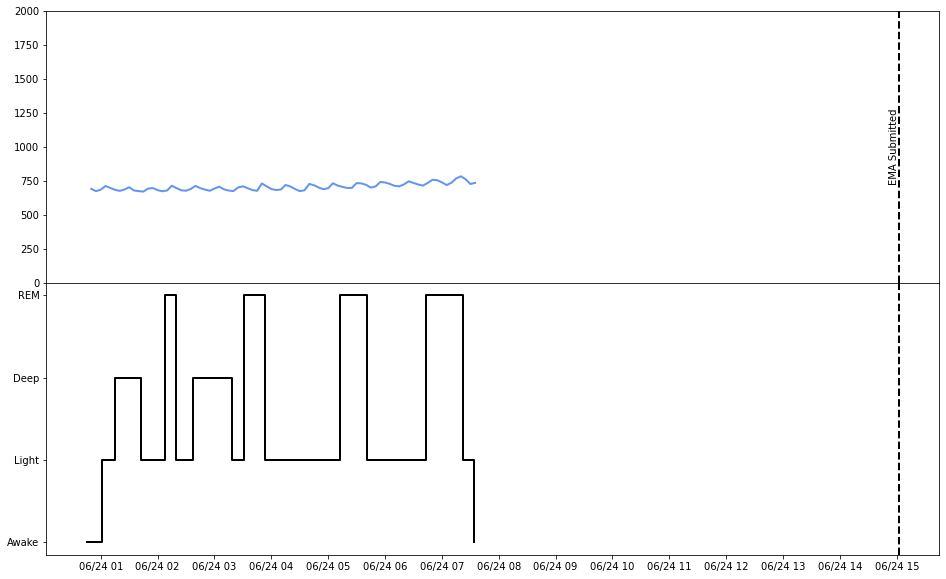

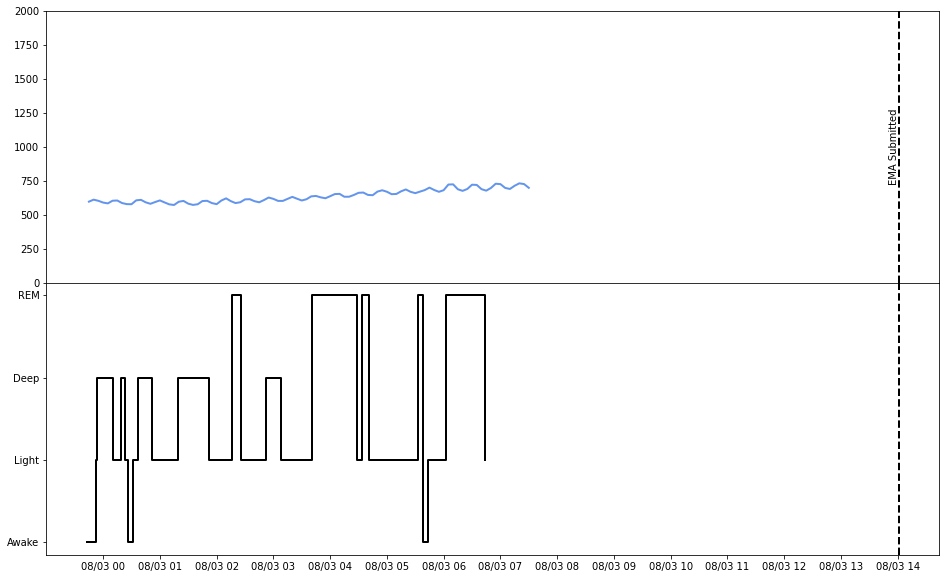

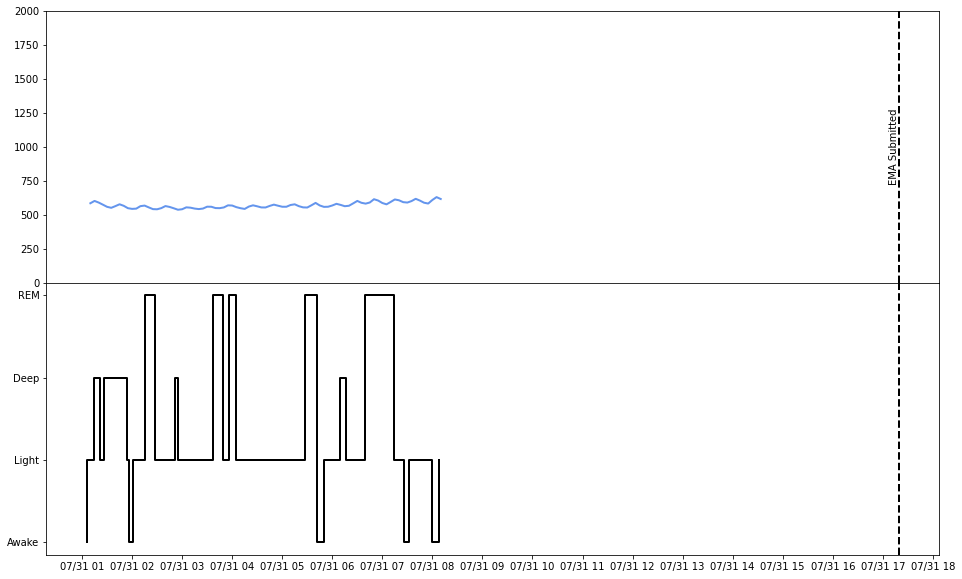

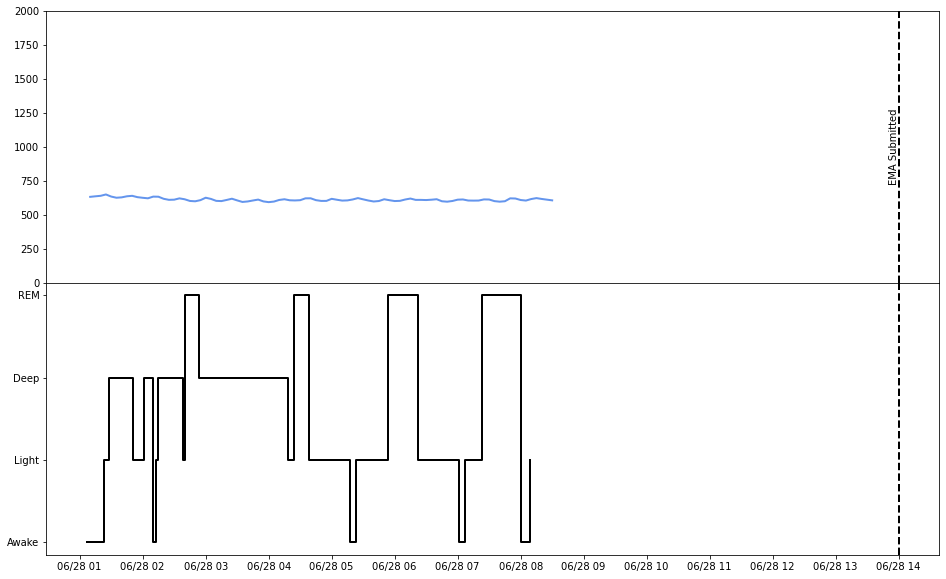

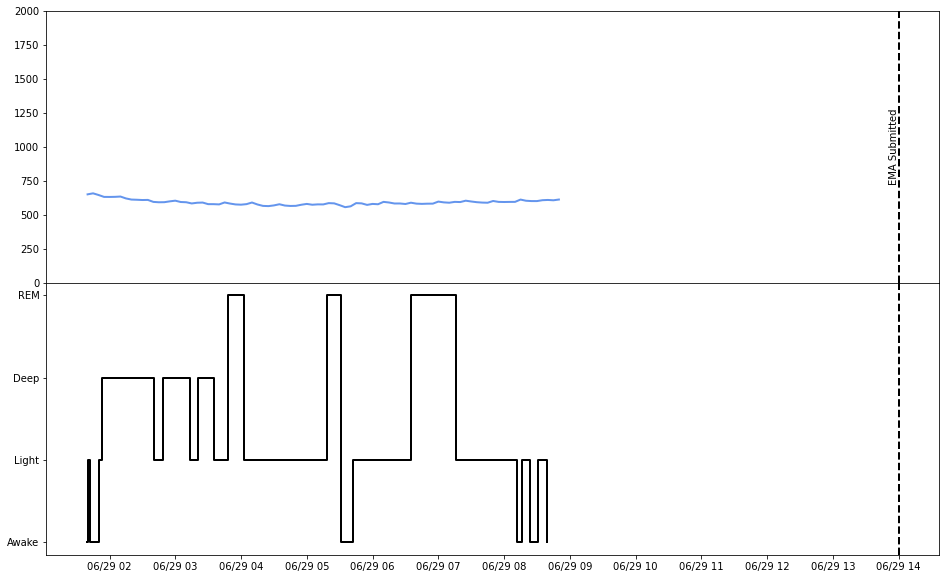

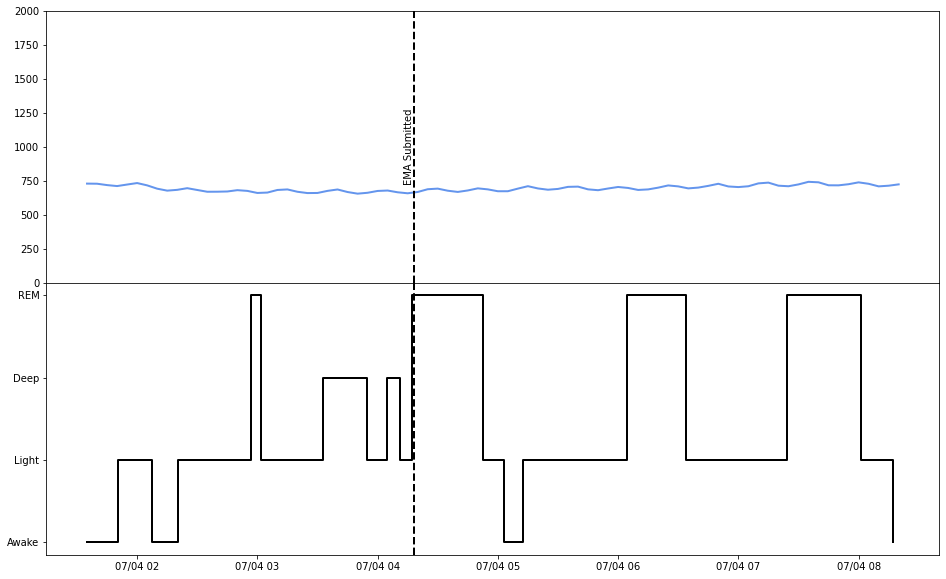

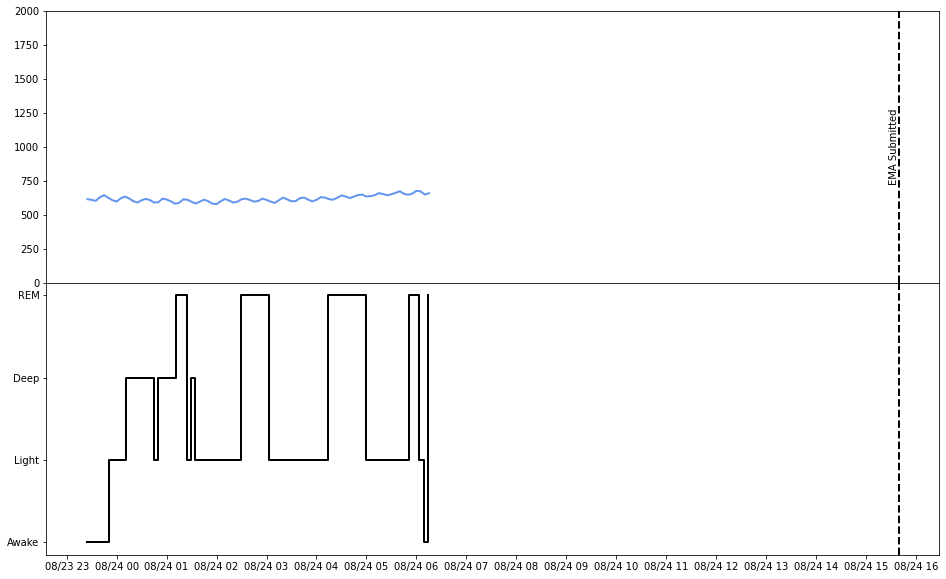

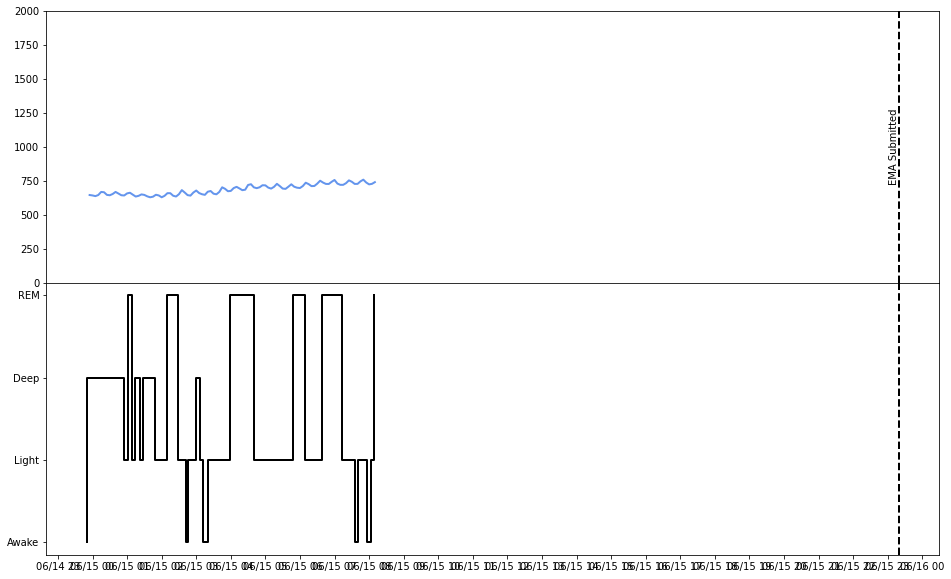

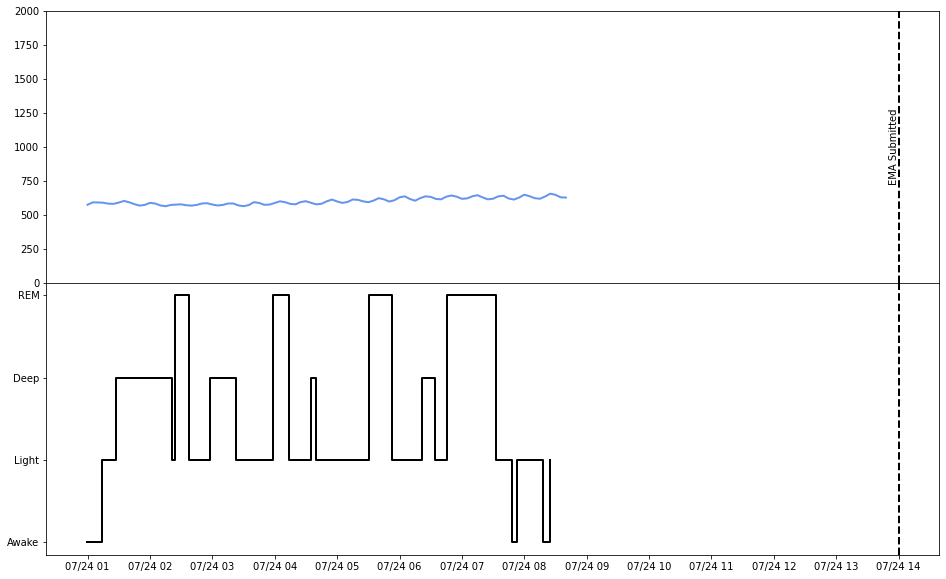

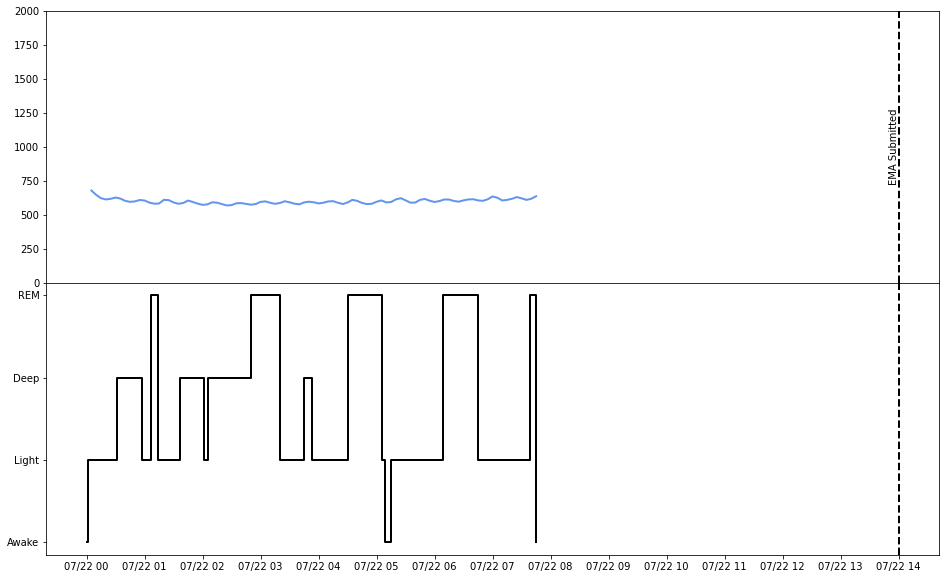

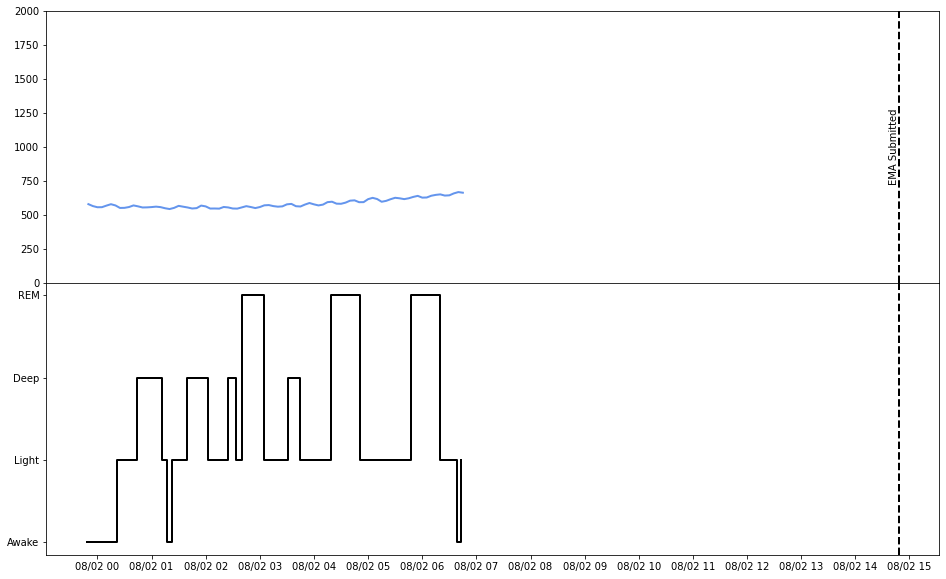

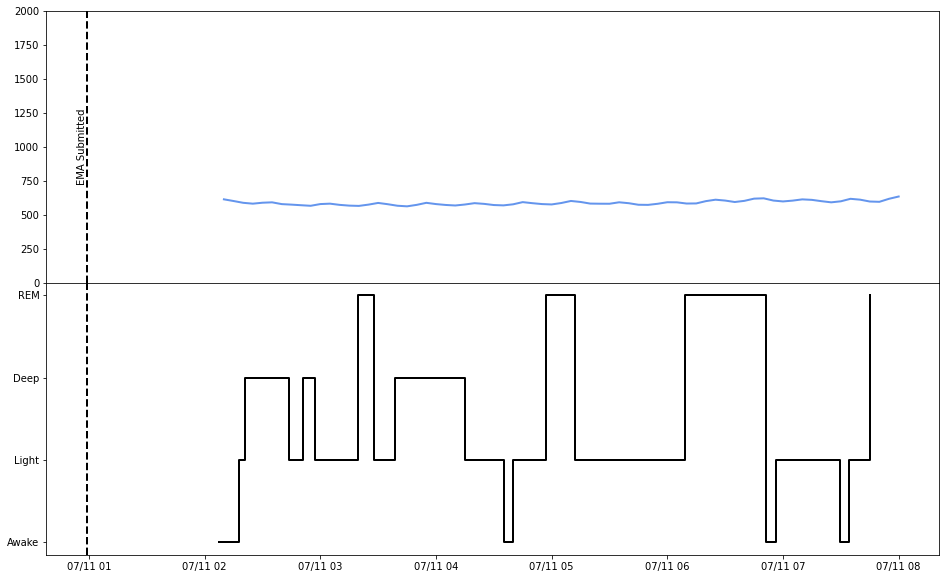

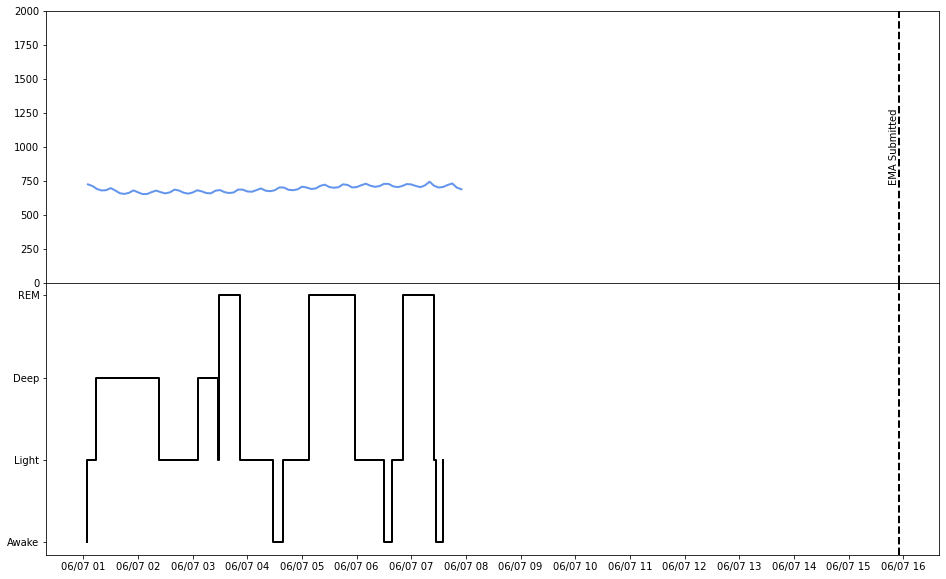

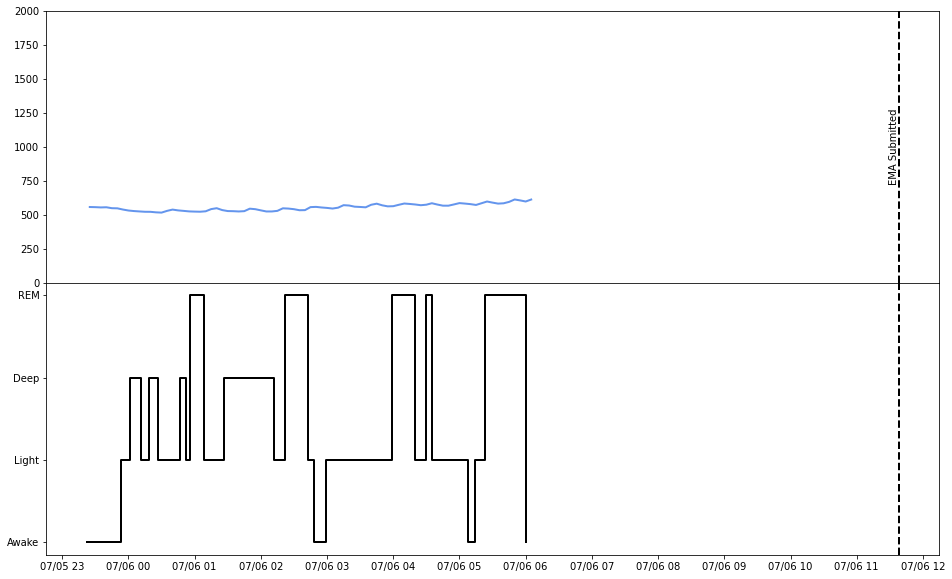

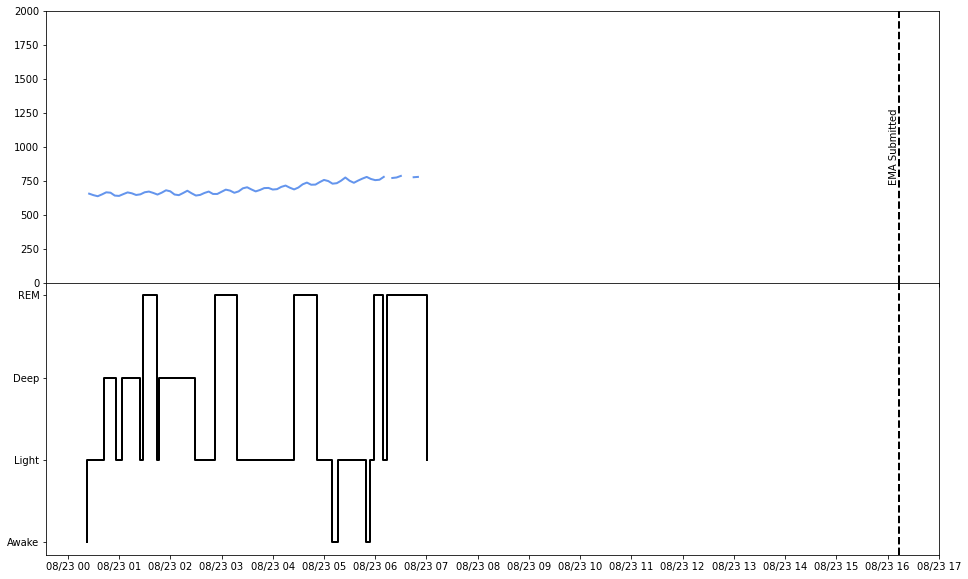

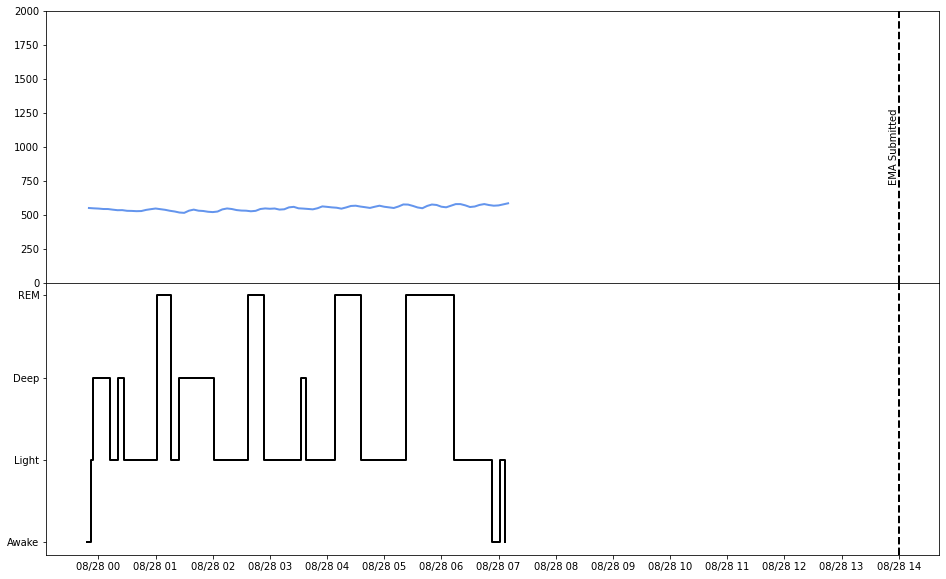

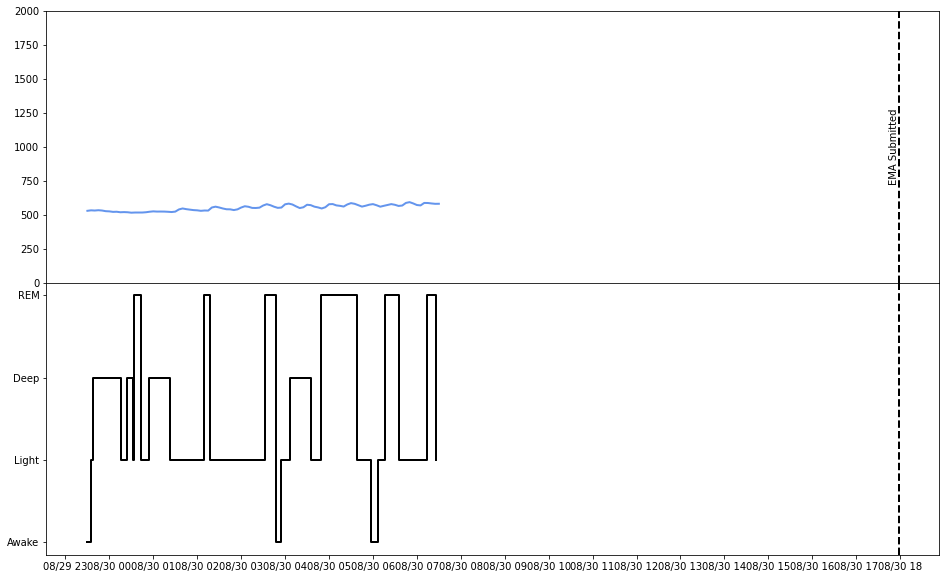

xdbdrk6e


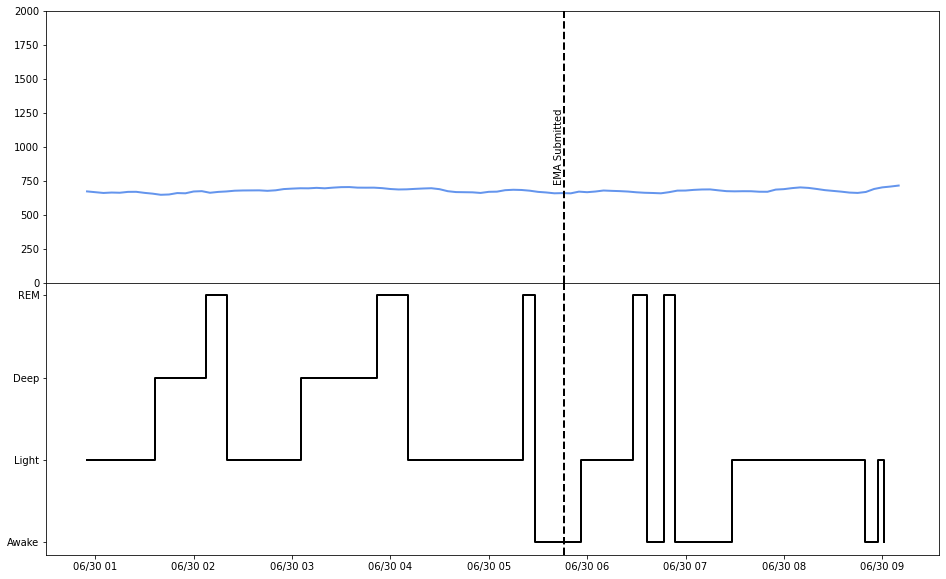

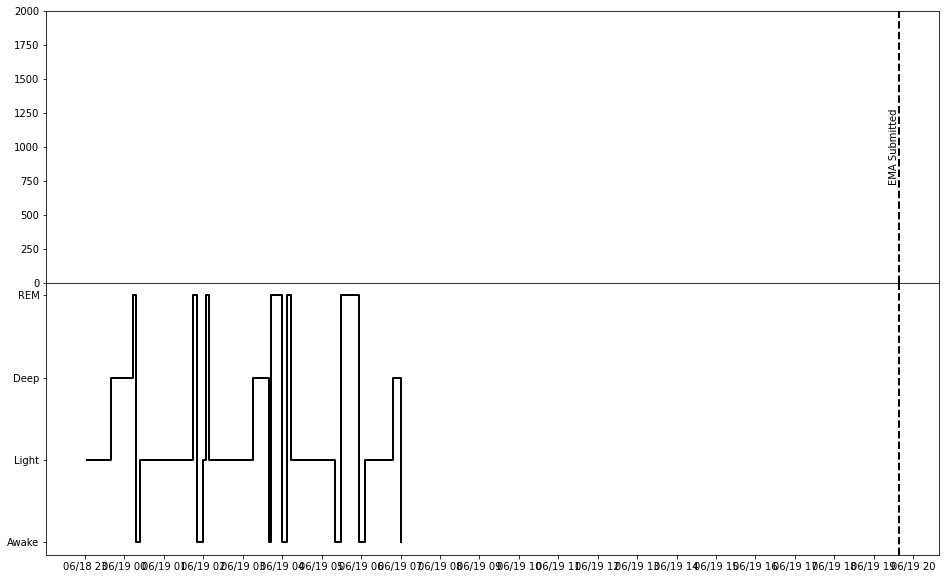

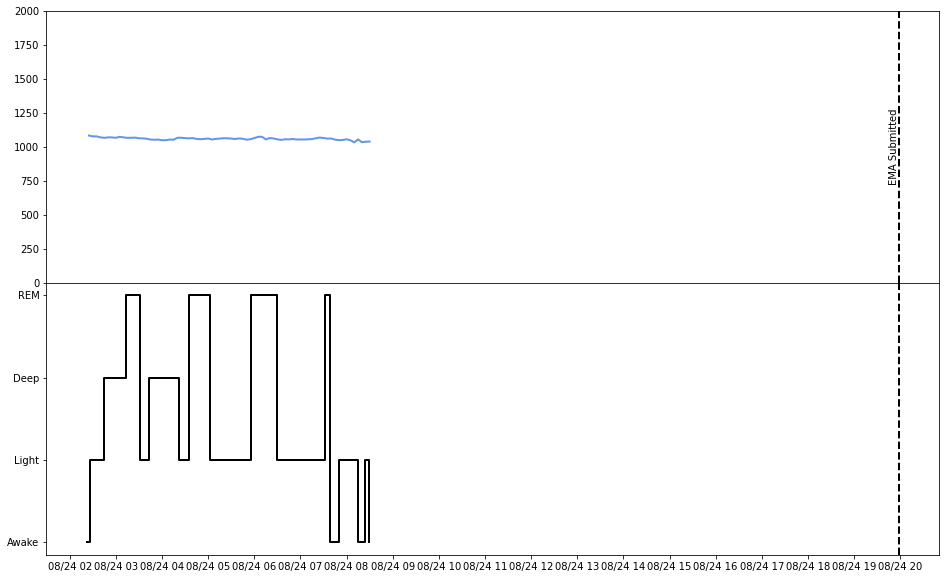

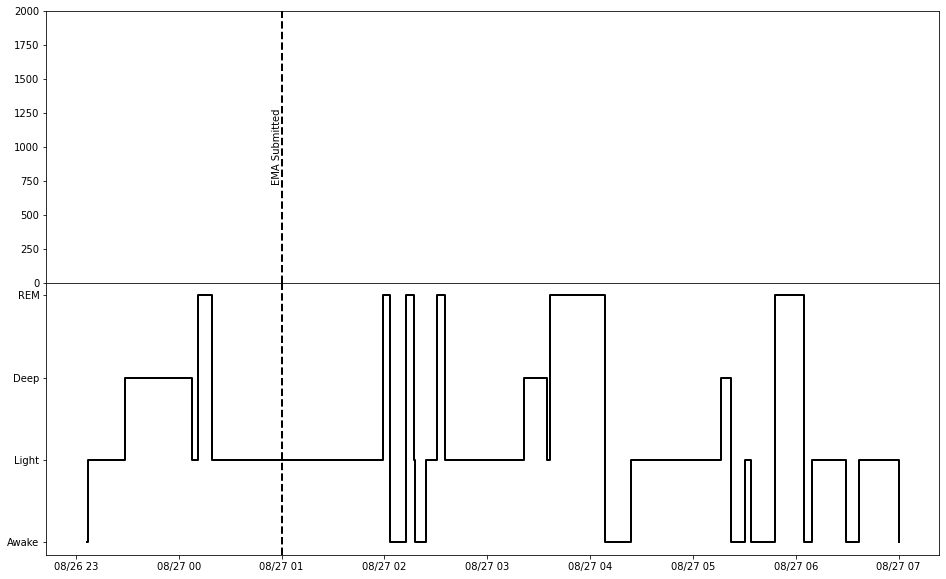

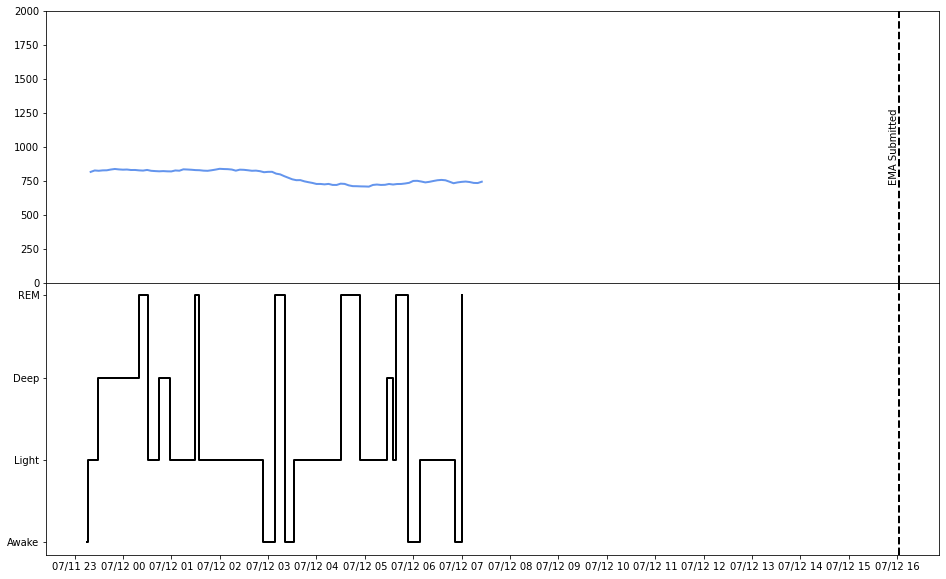

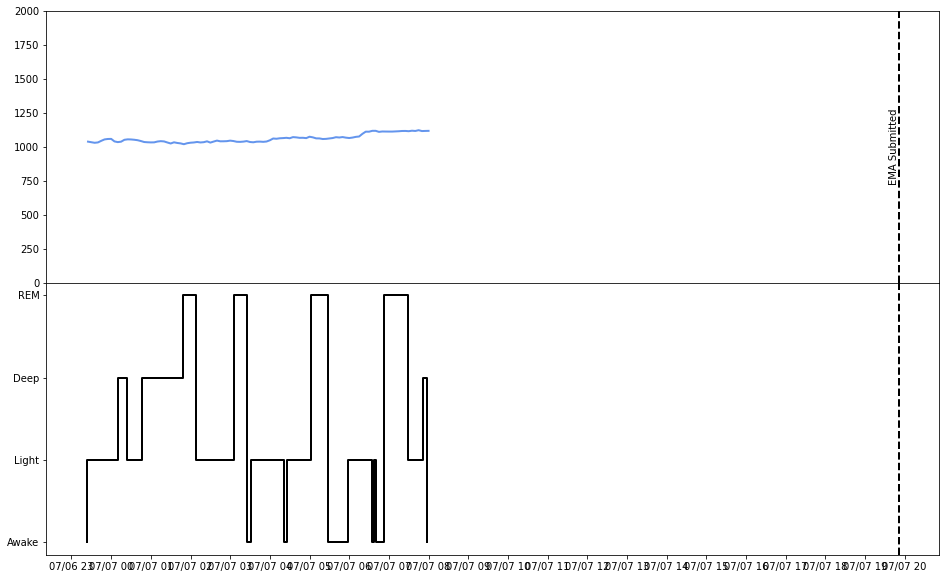

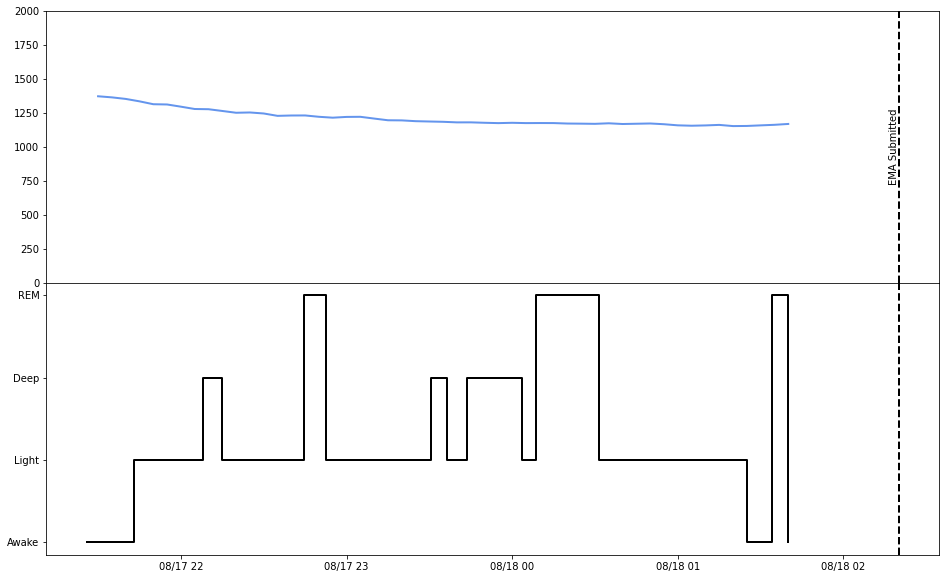

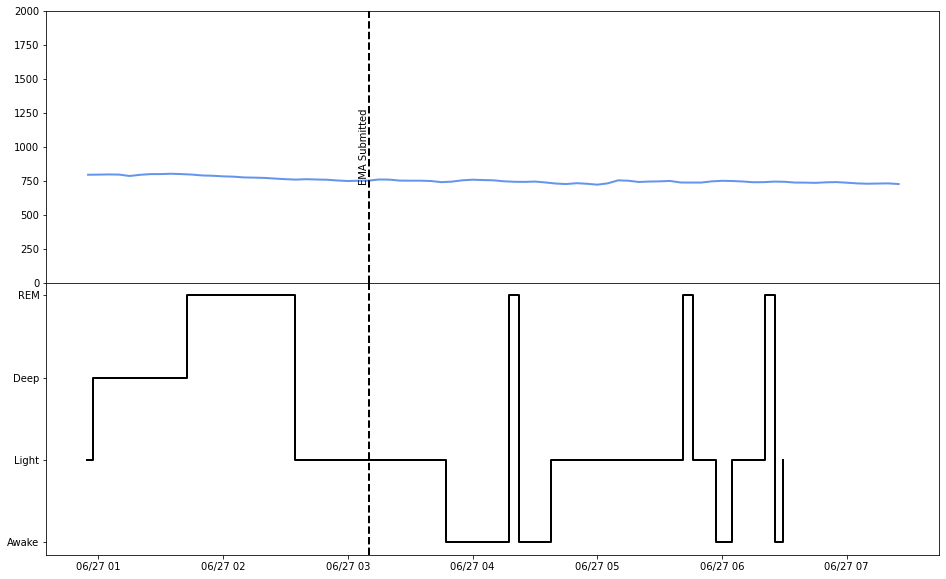

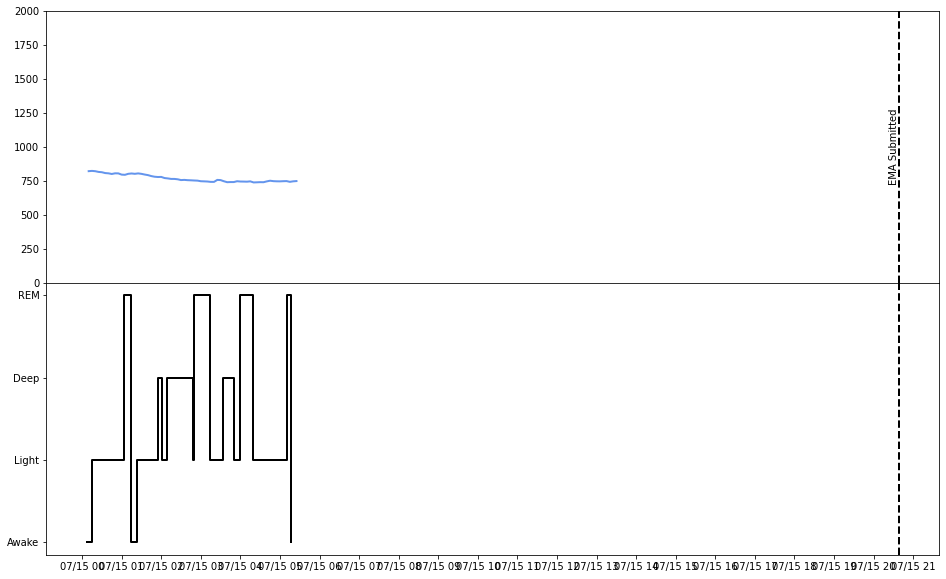

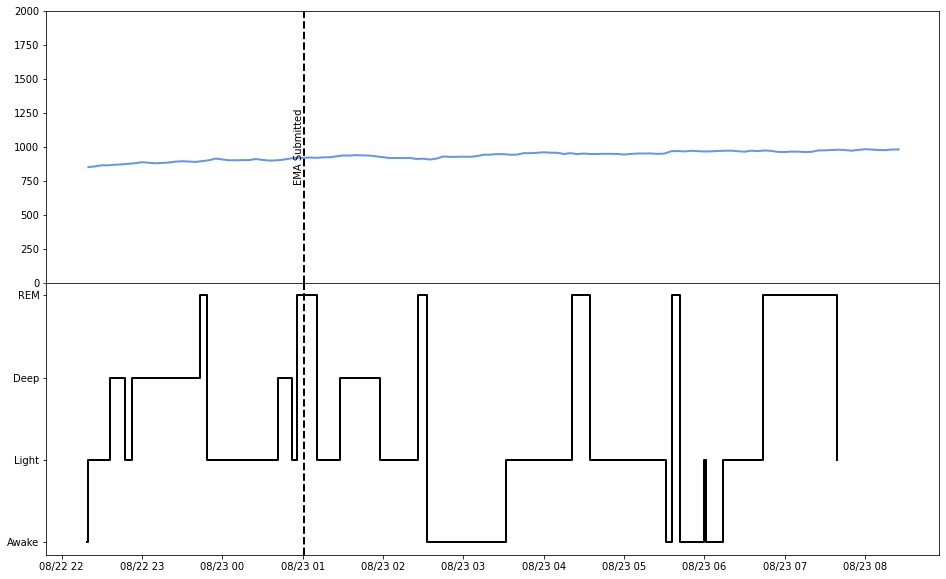

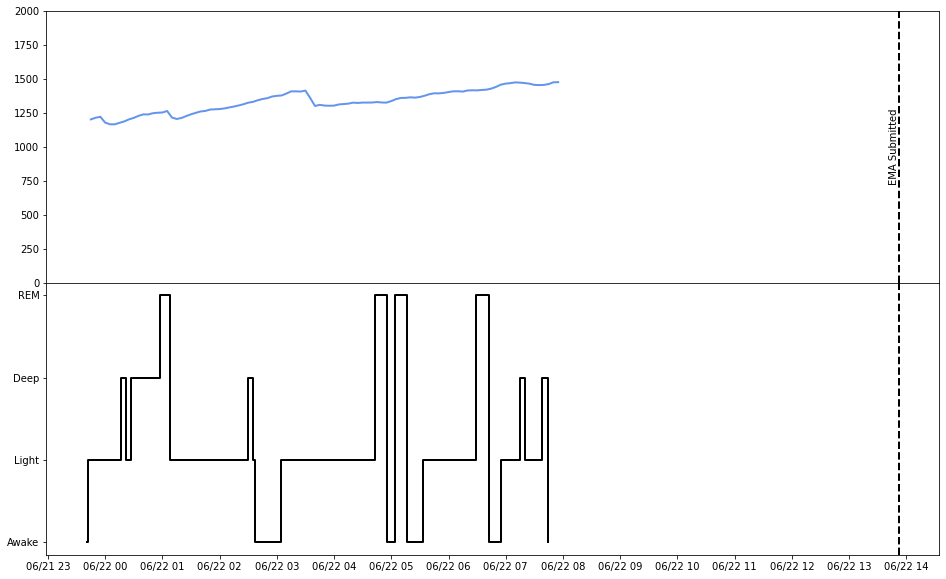

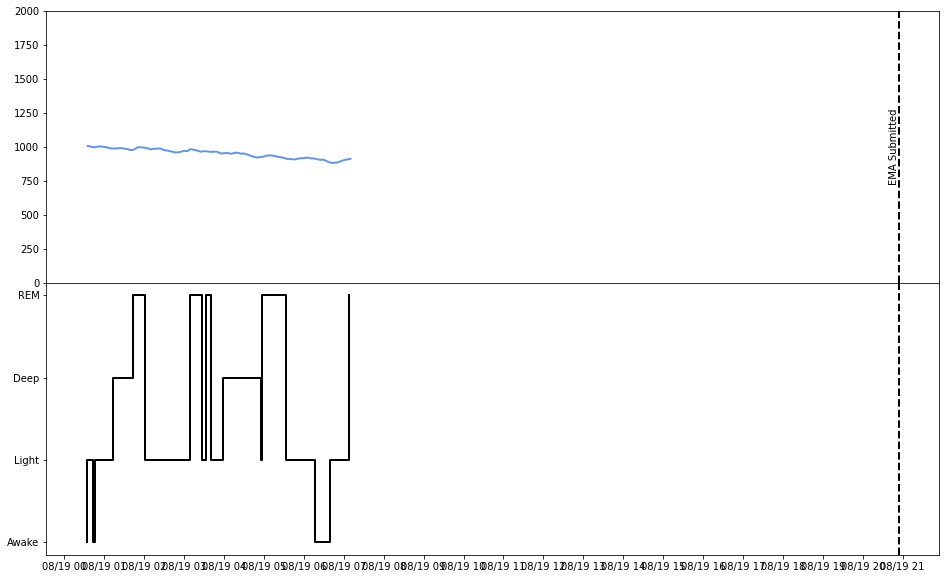

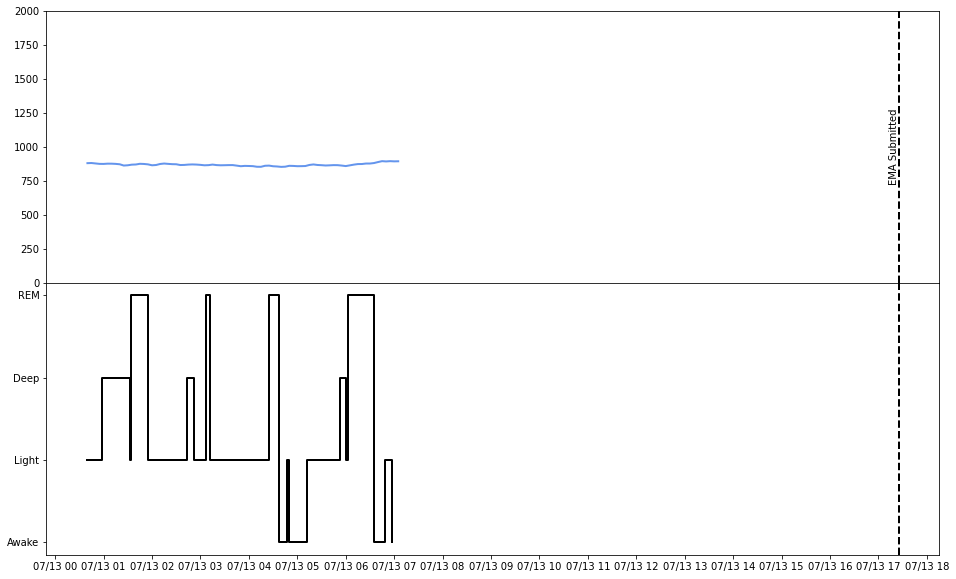

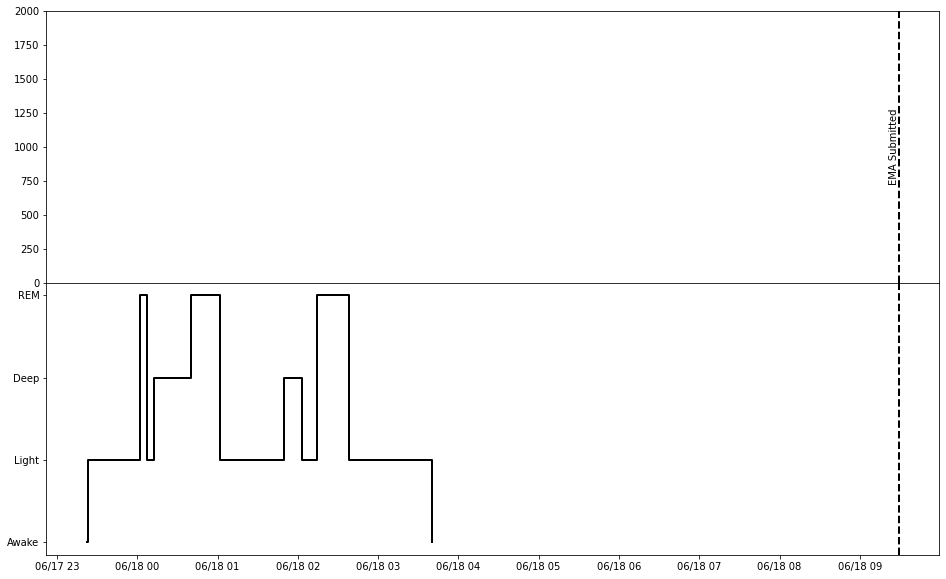

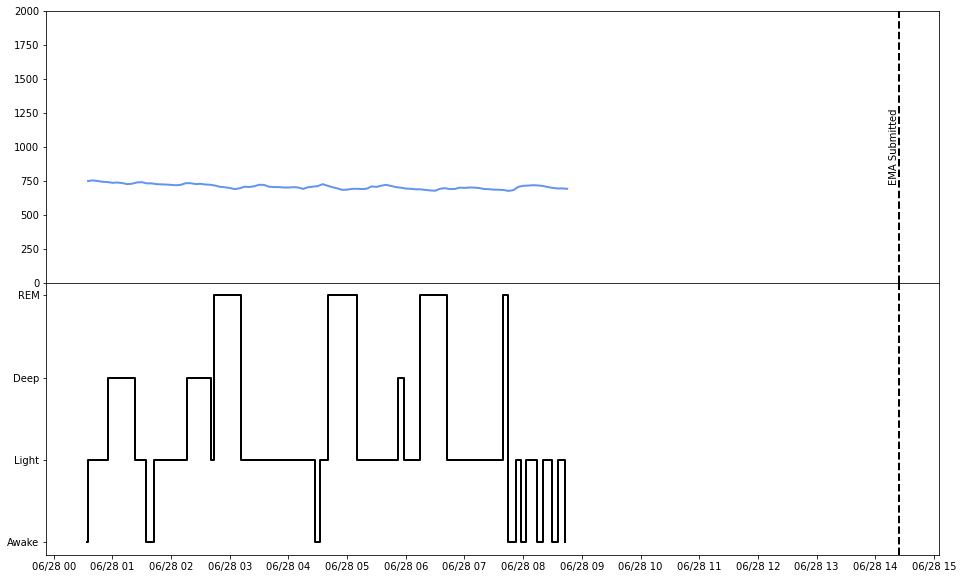

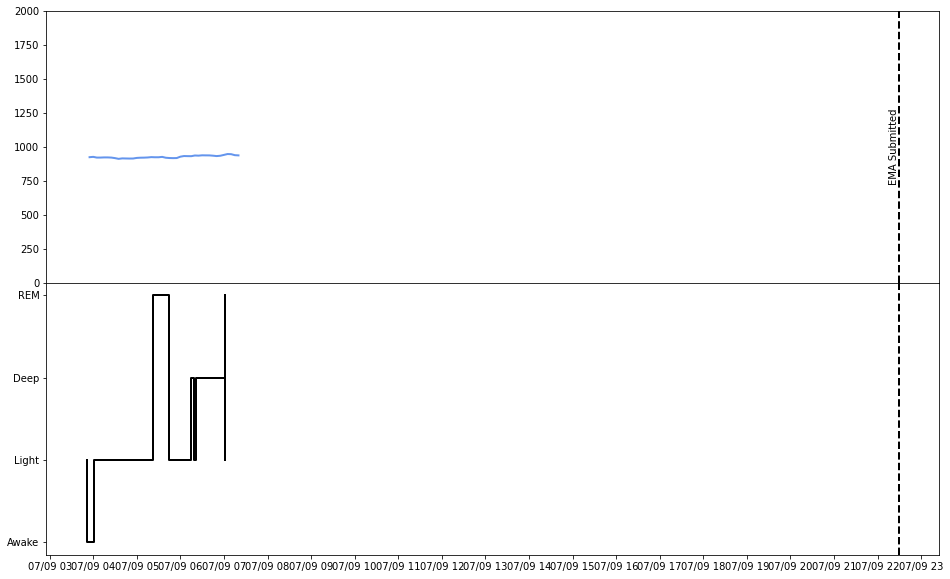

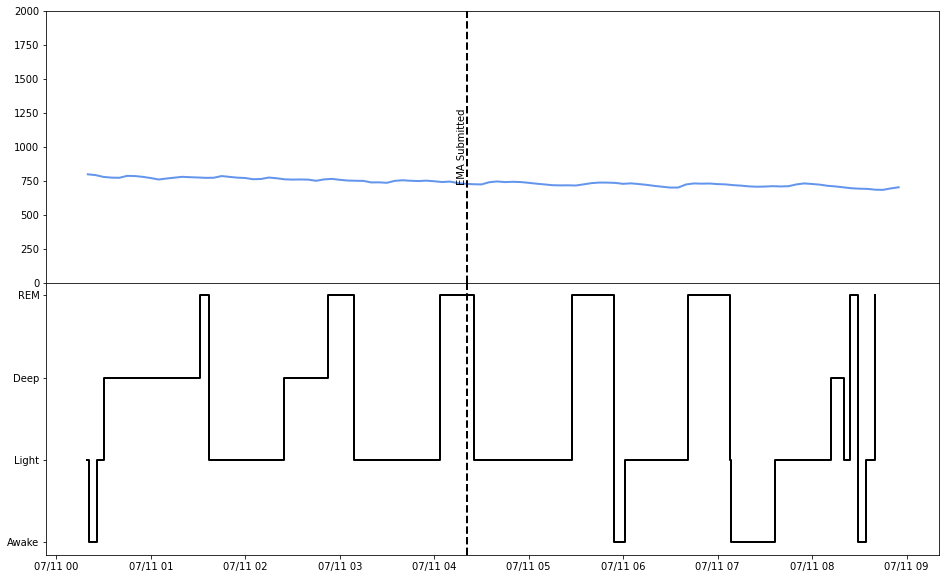

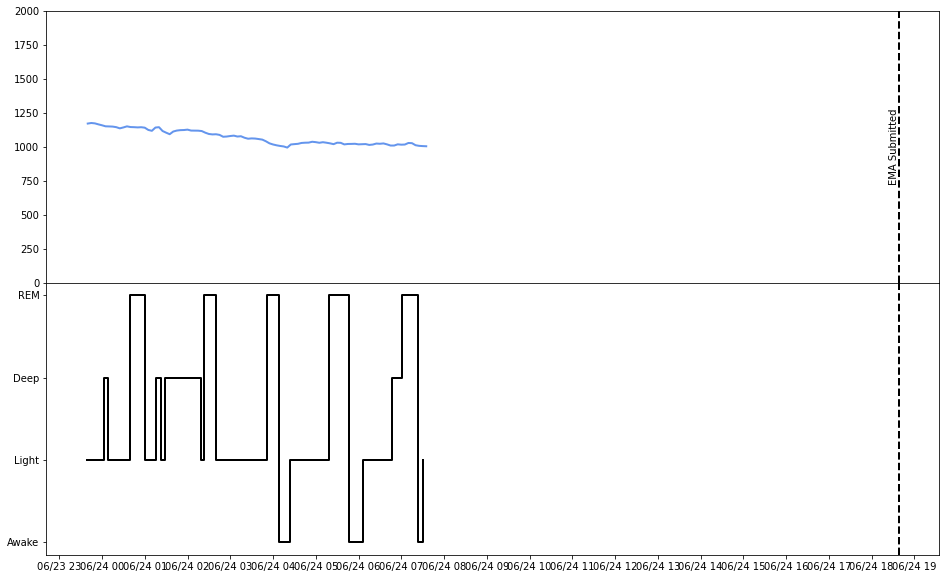

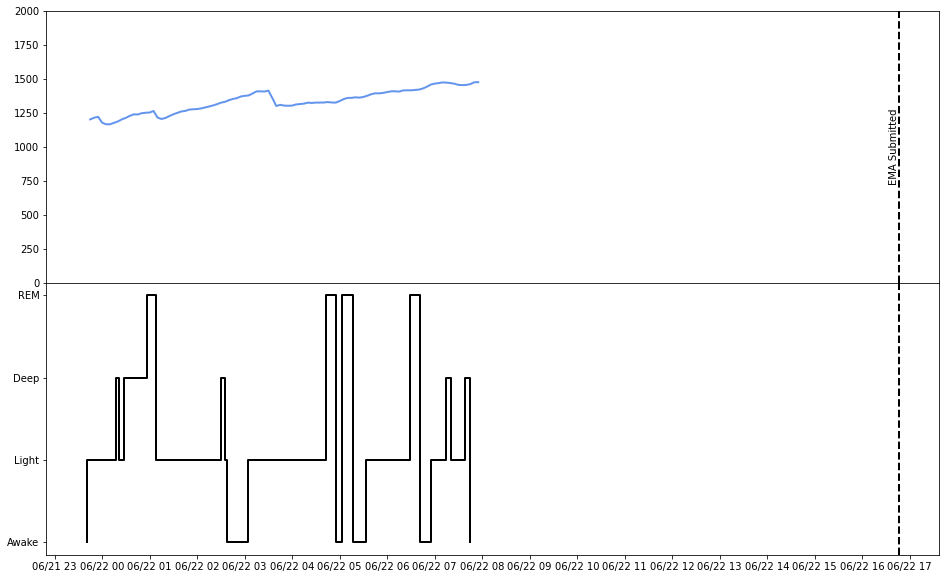

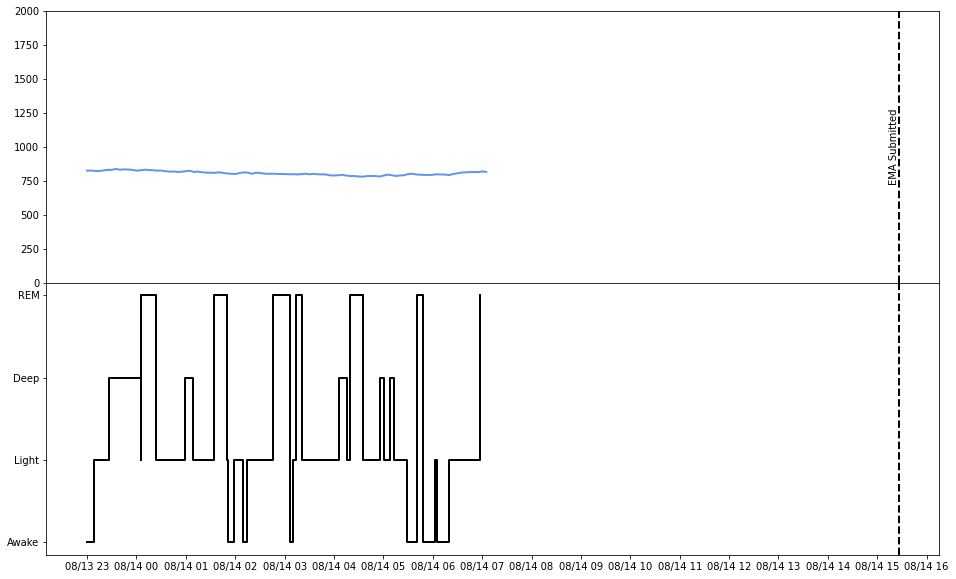

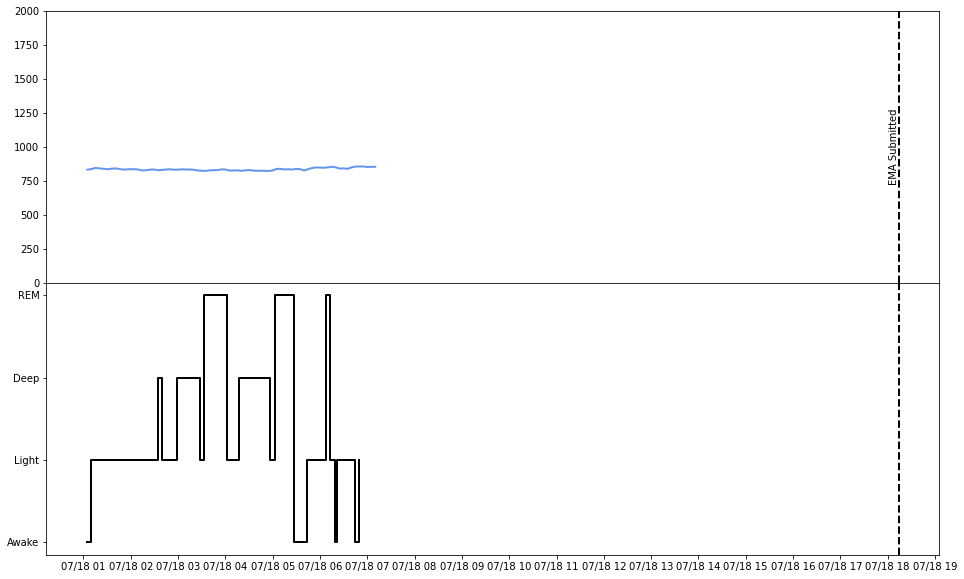

xlw5ntd5


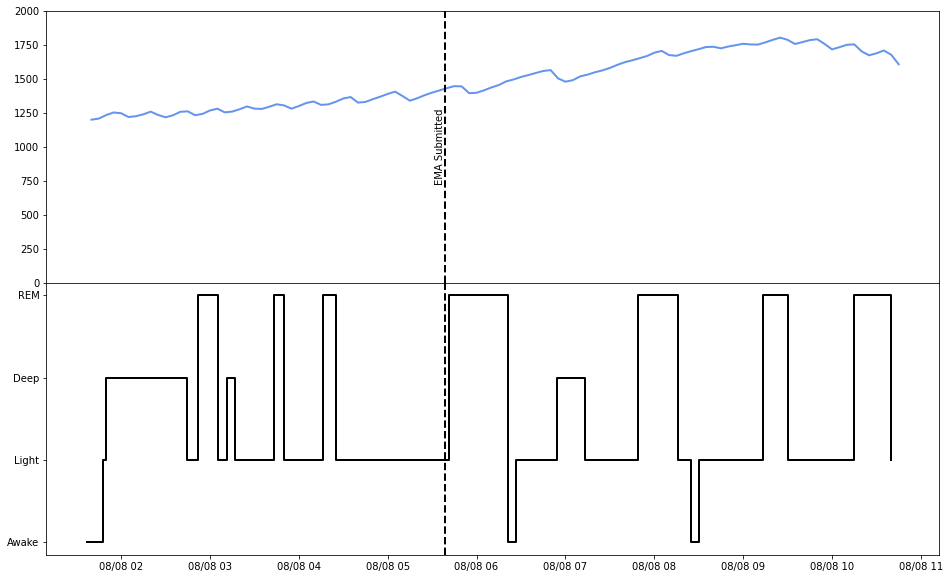

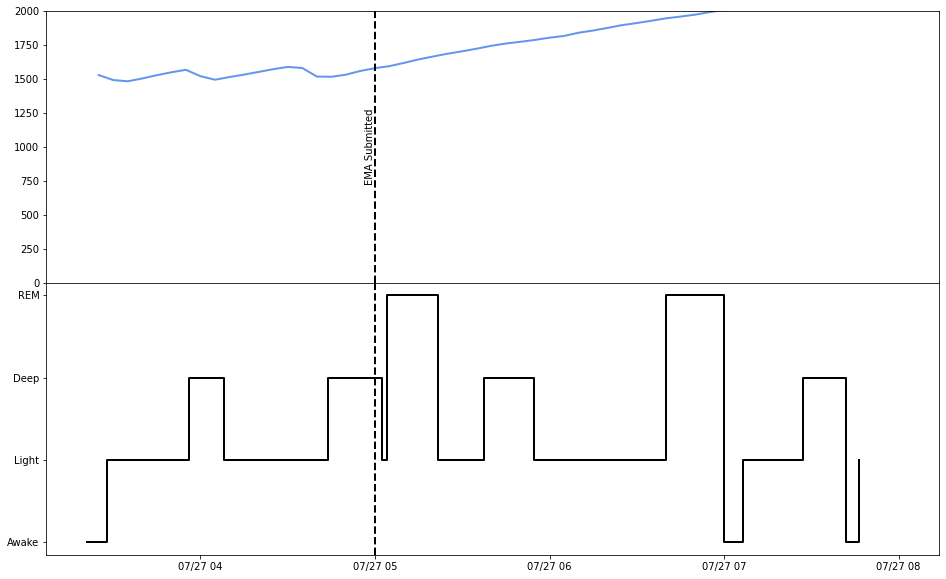

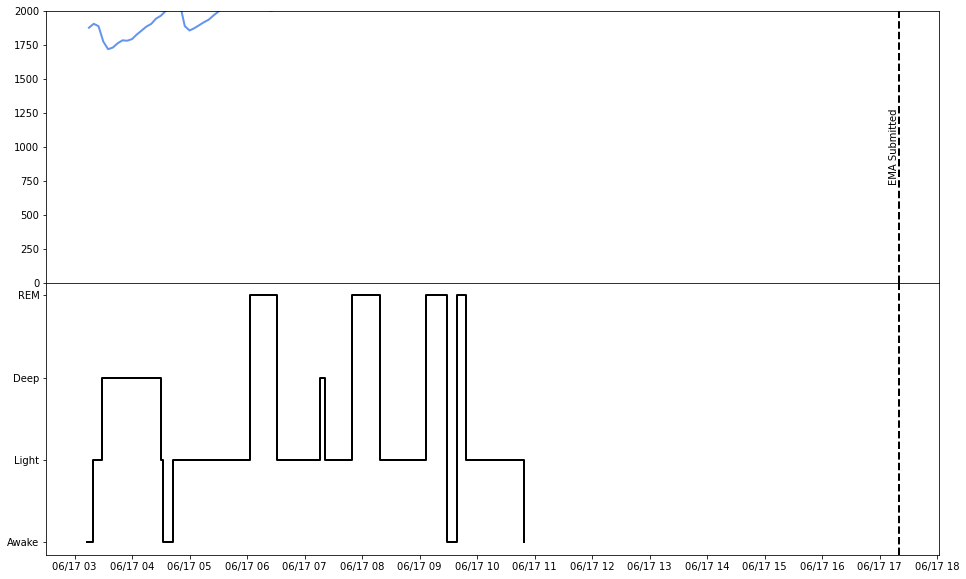

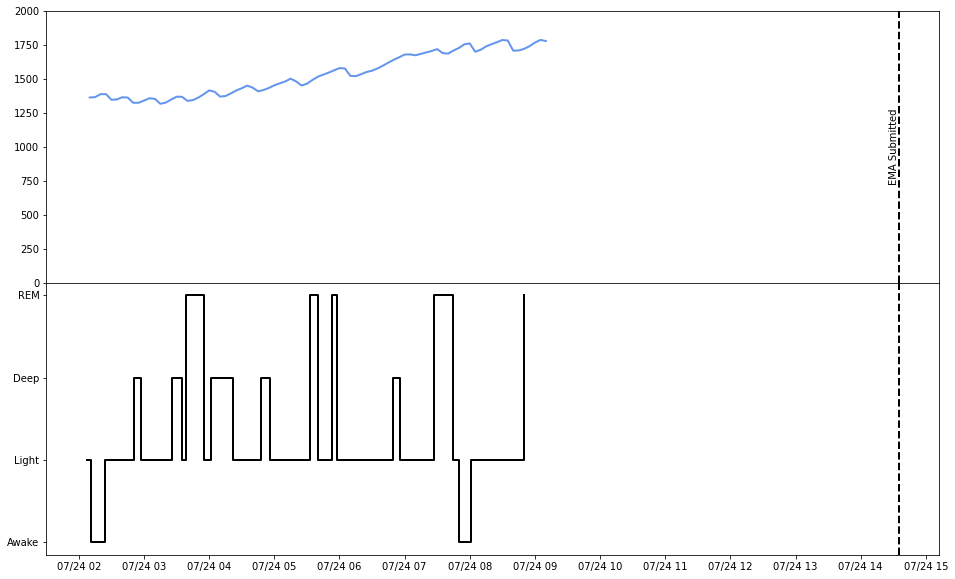

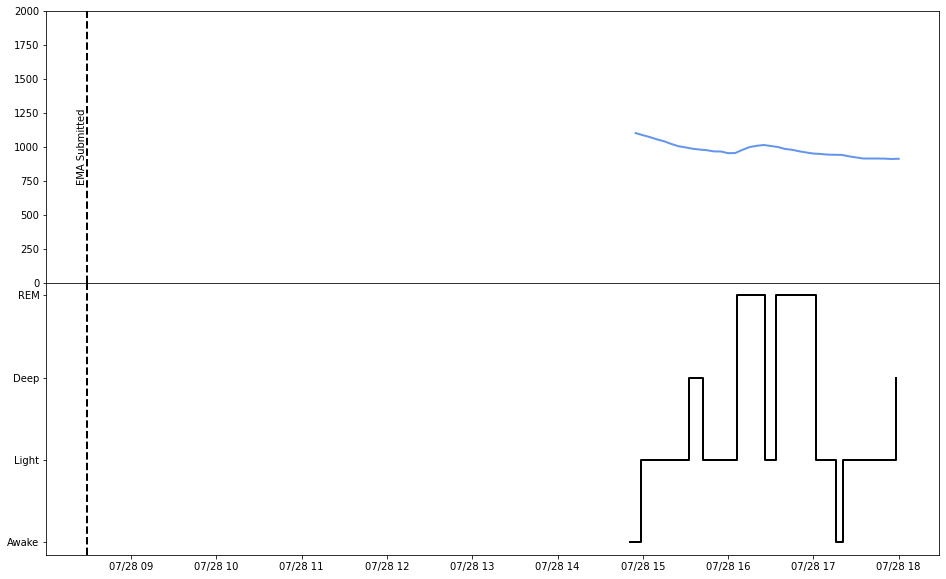

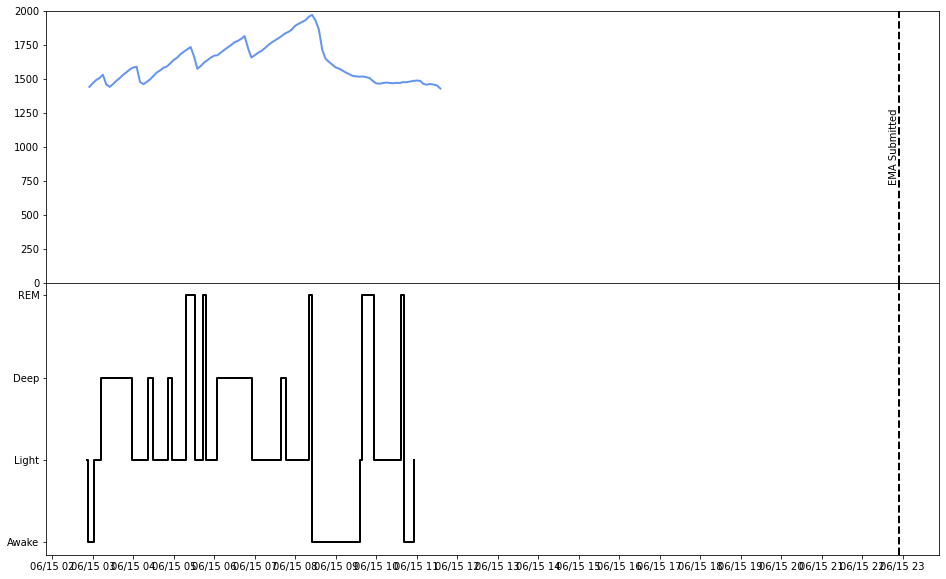

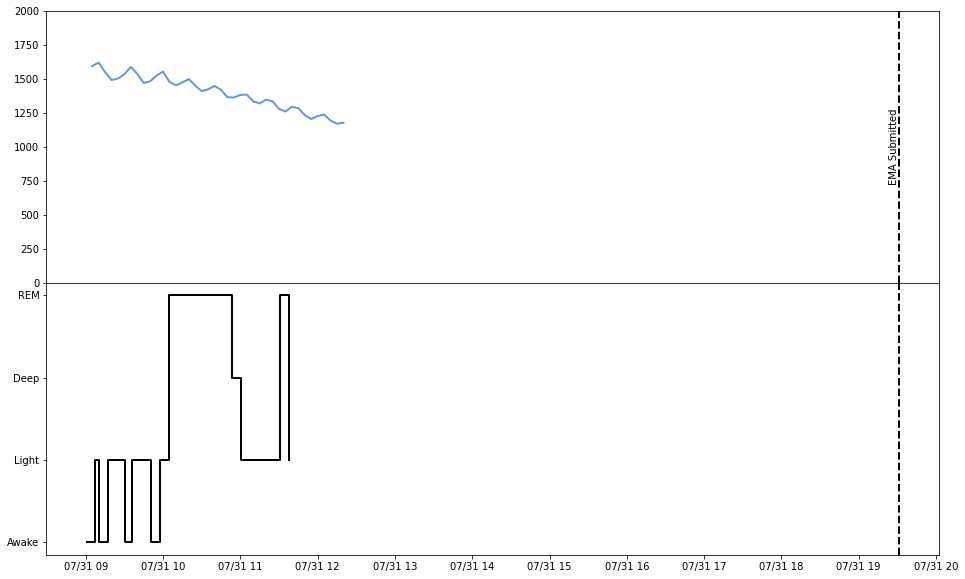

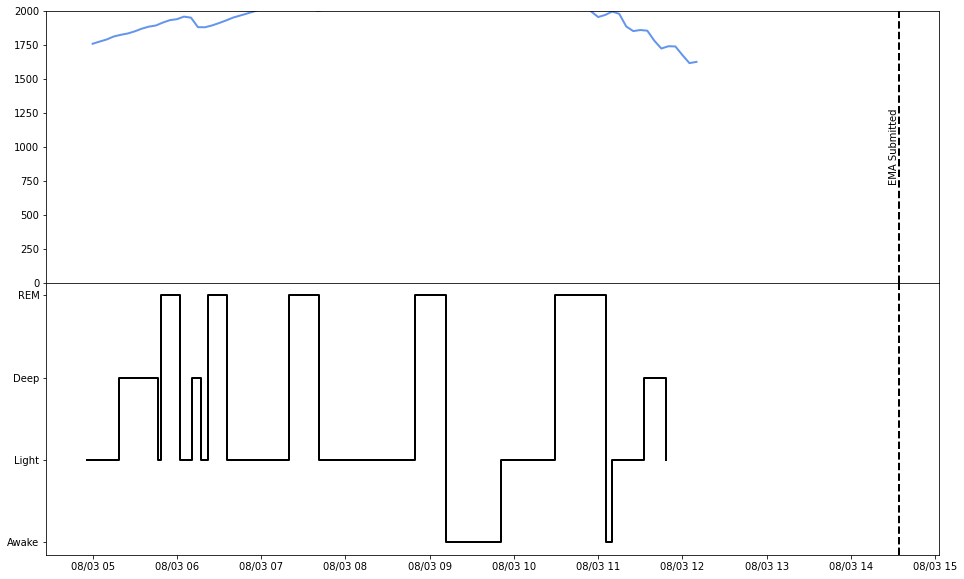

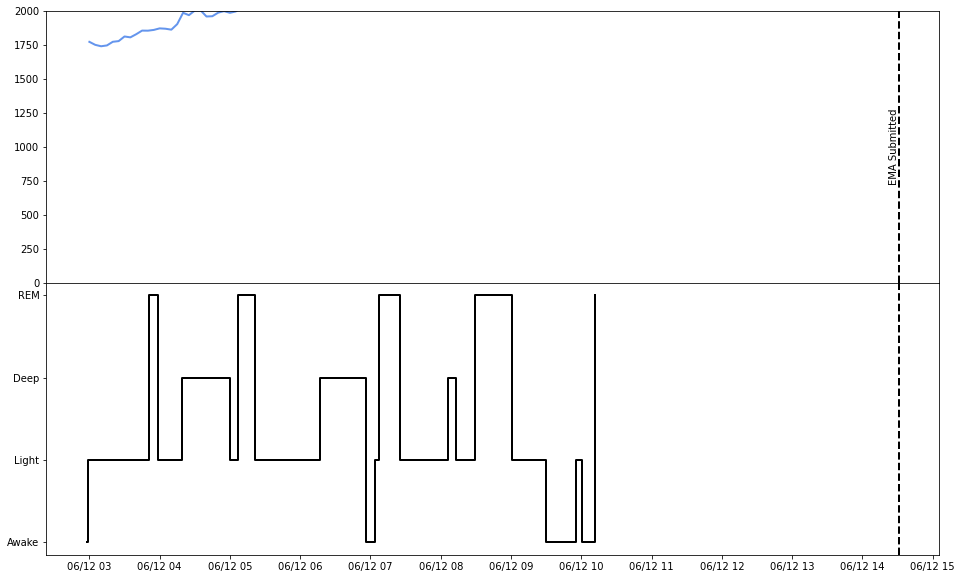

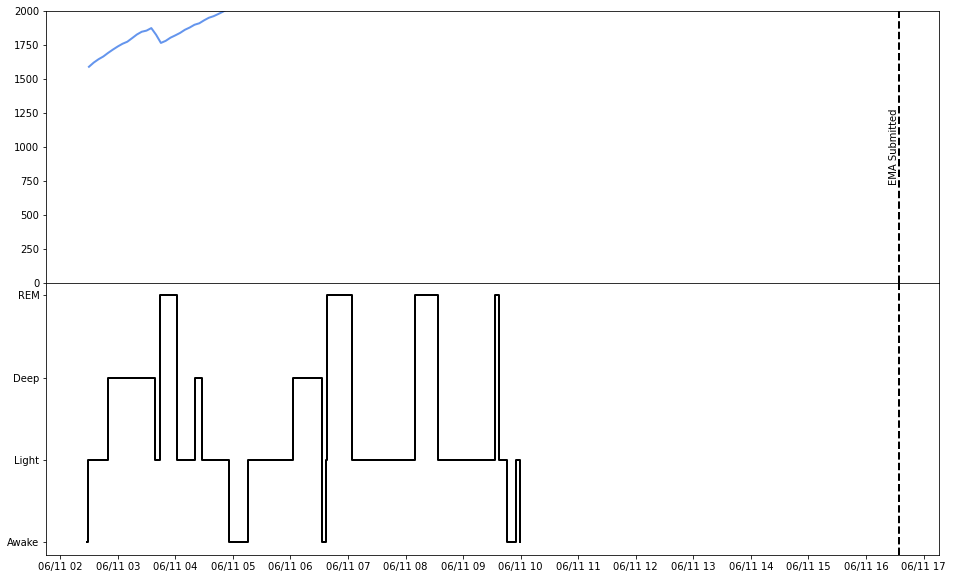

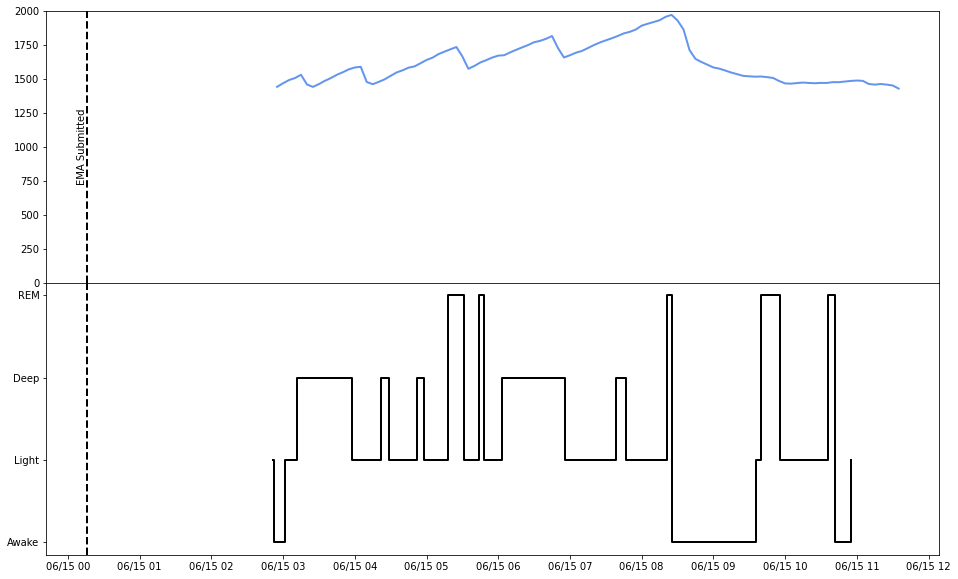

zdpffrox


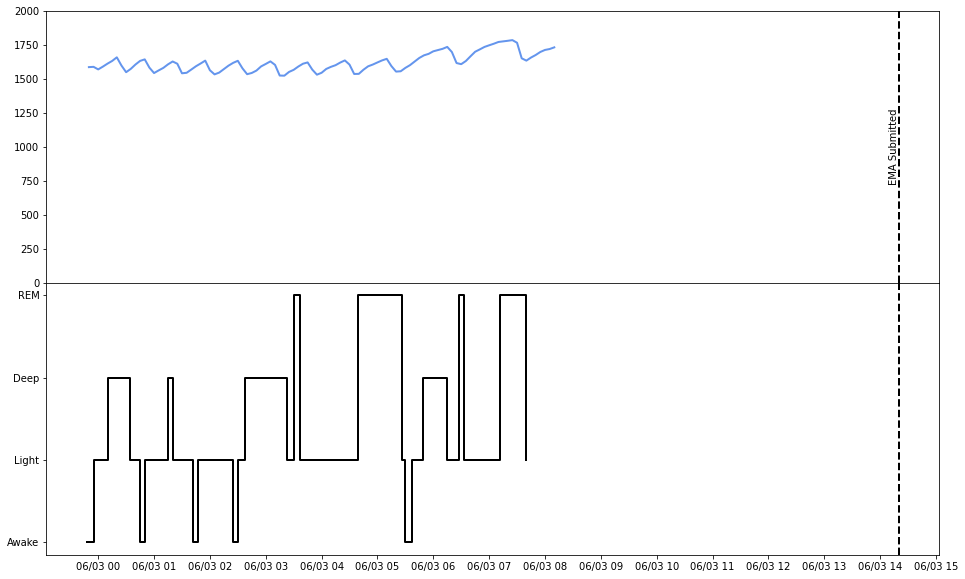

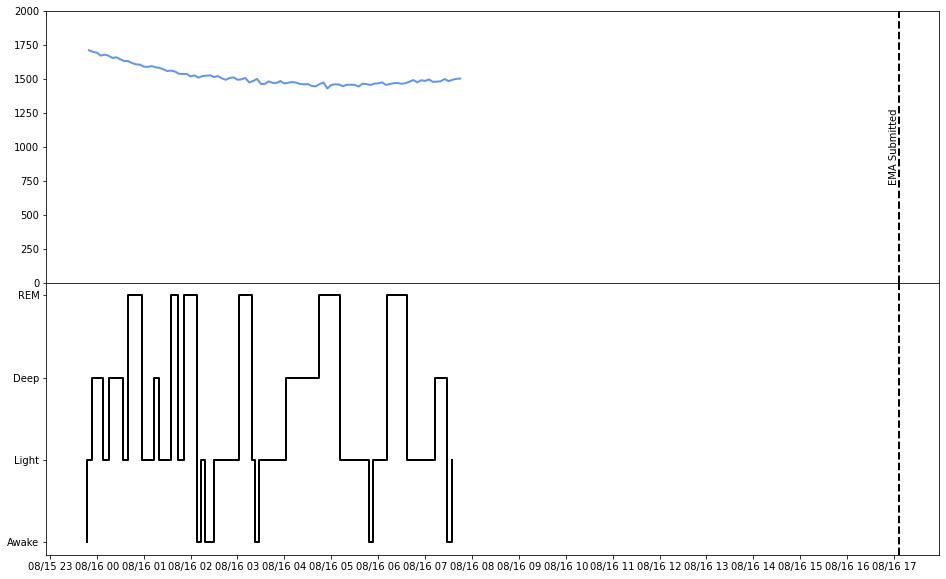

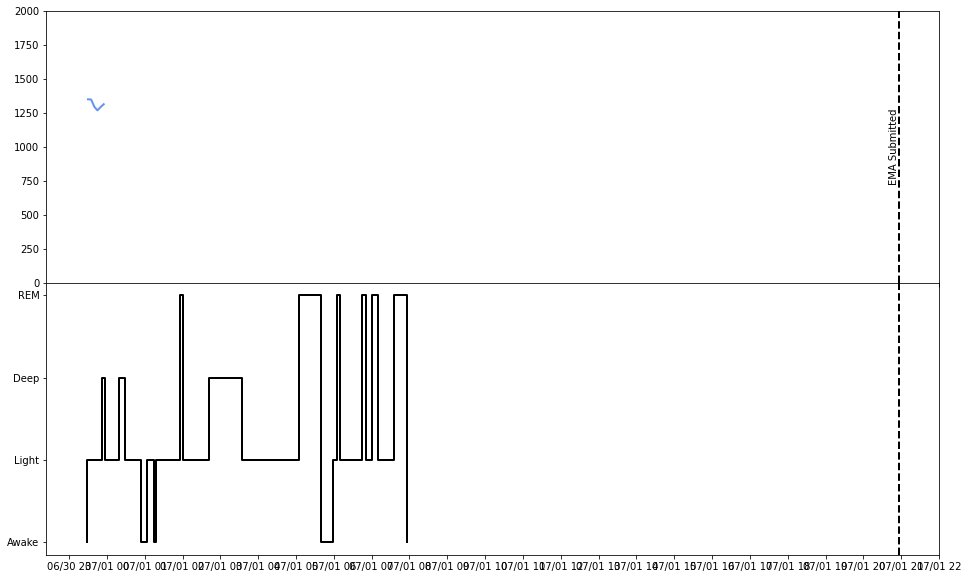

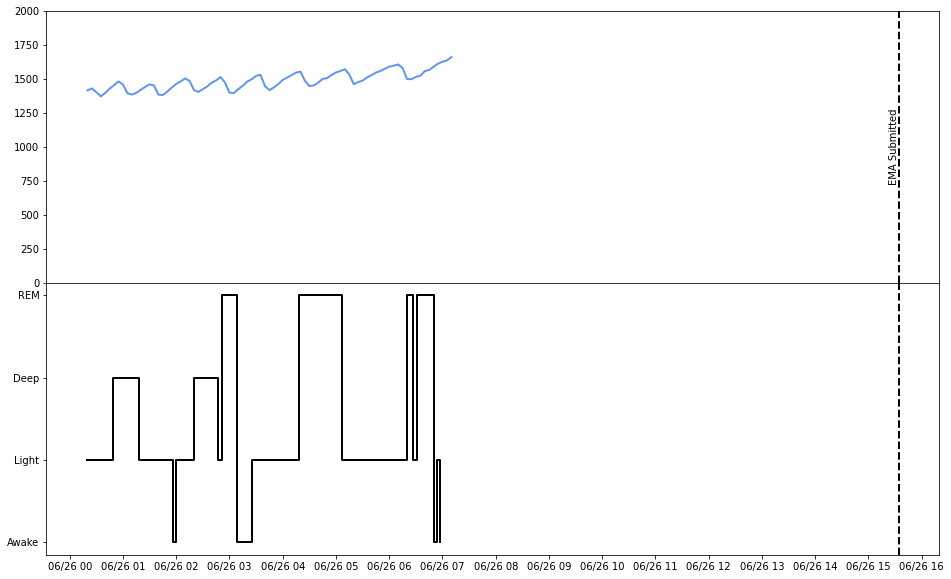

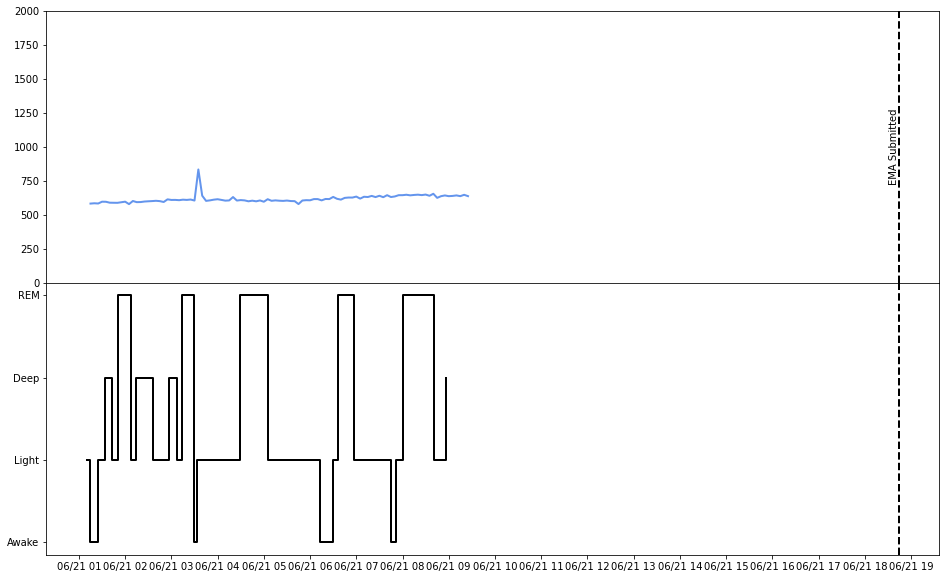

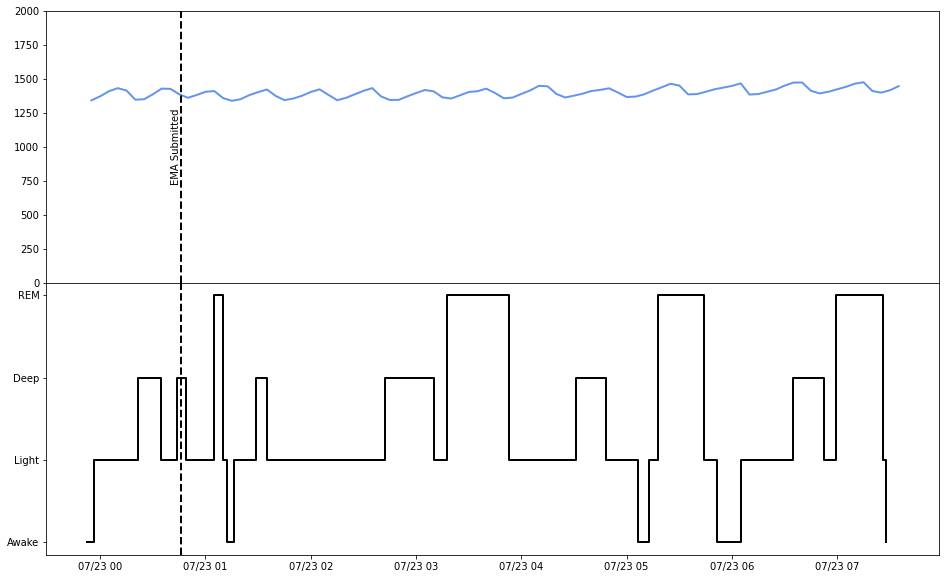

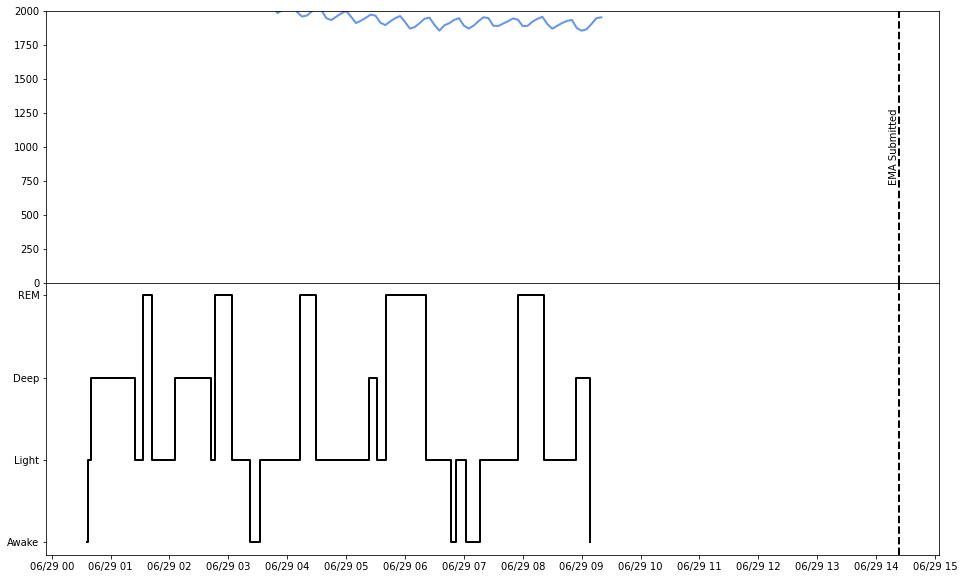

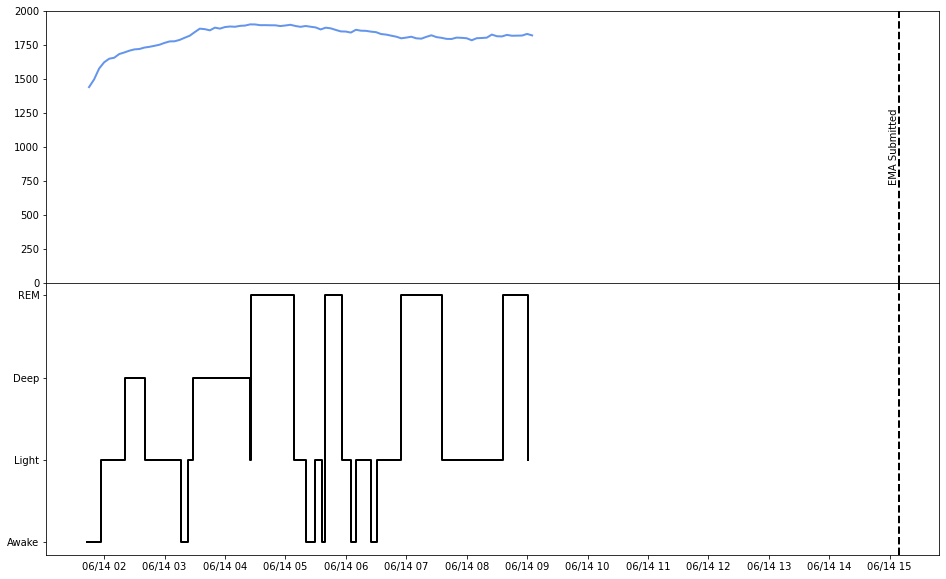

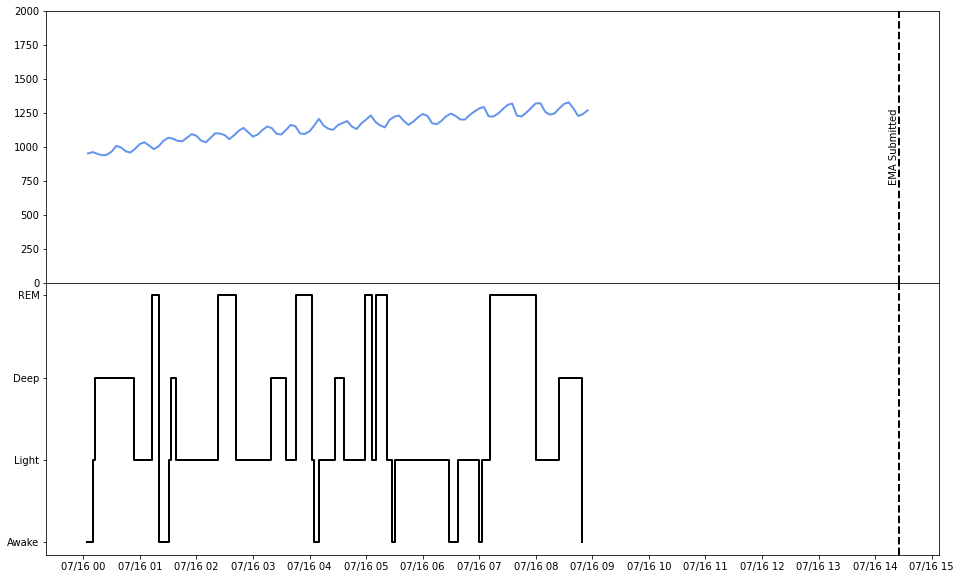

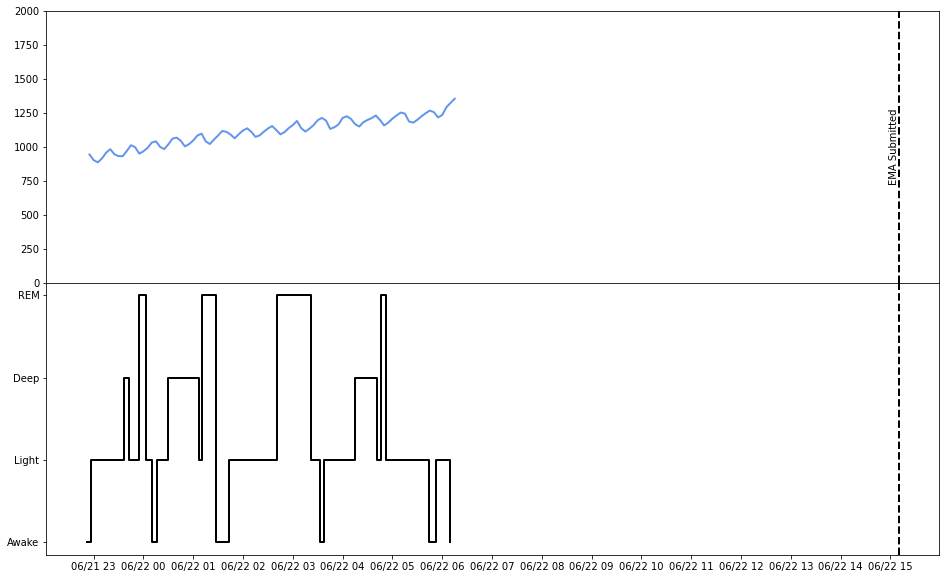

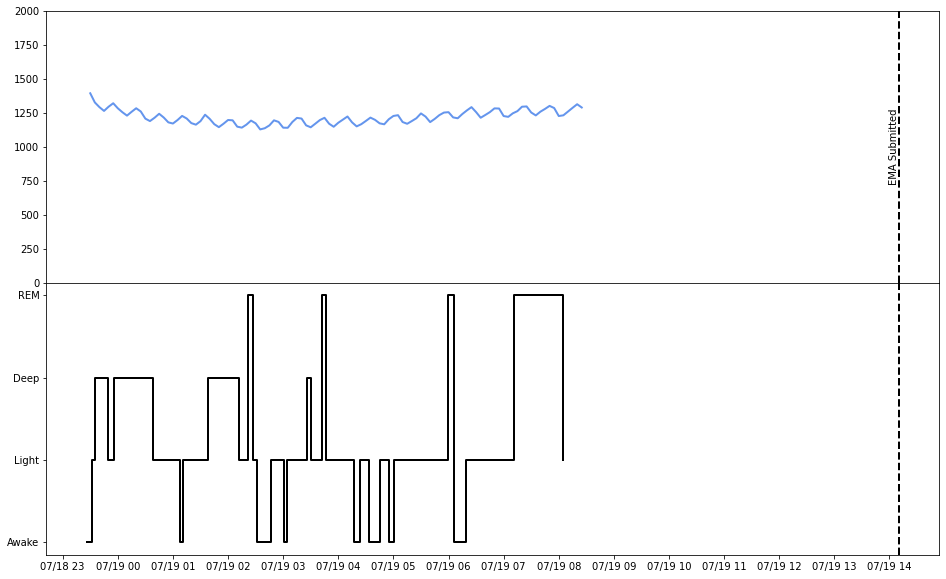

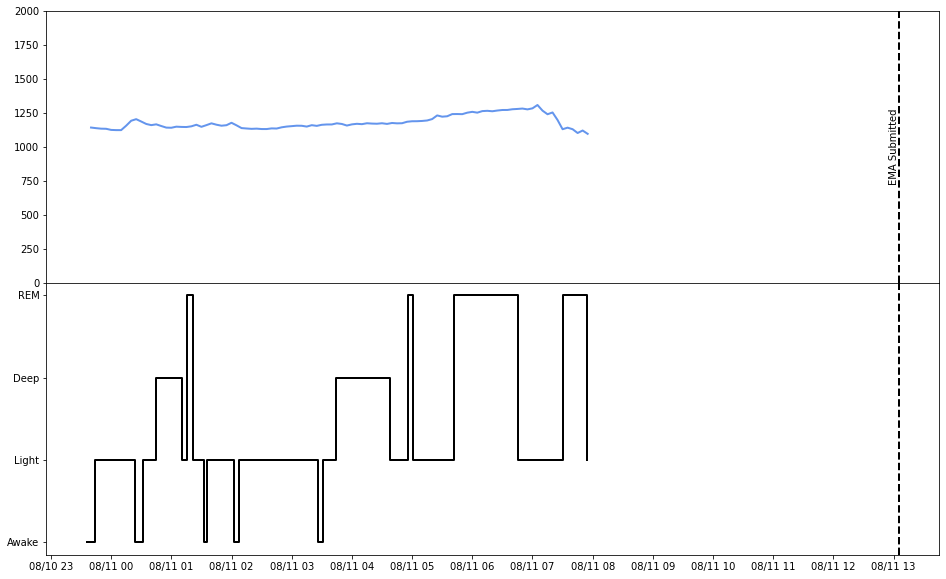

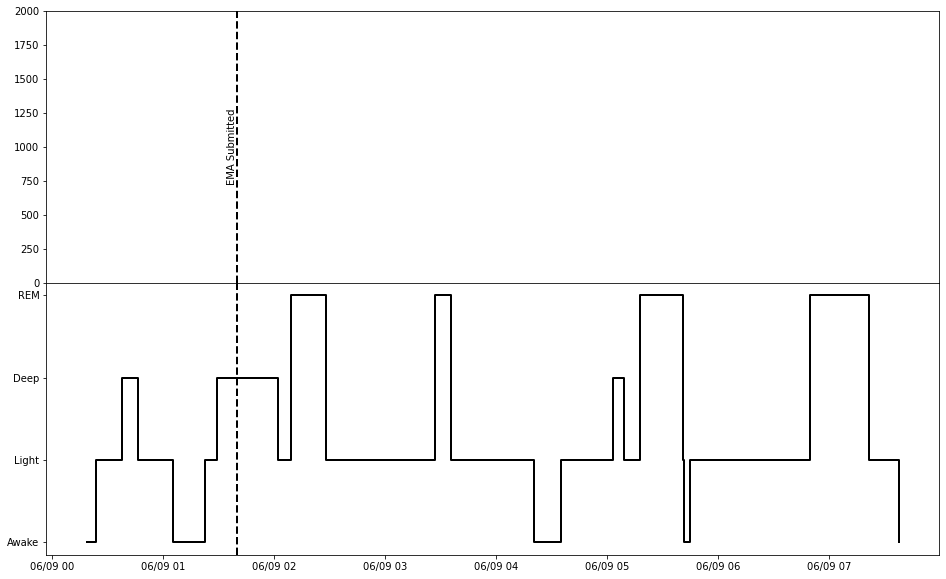

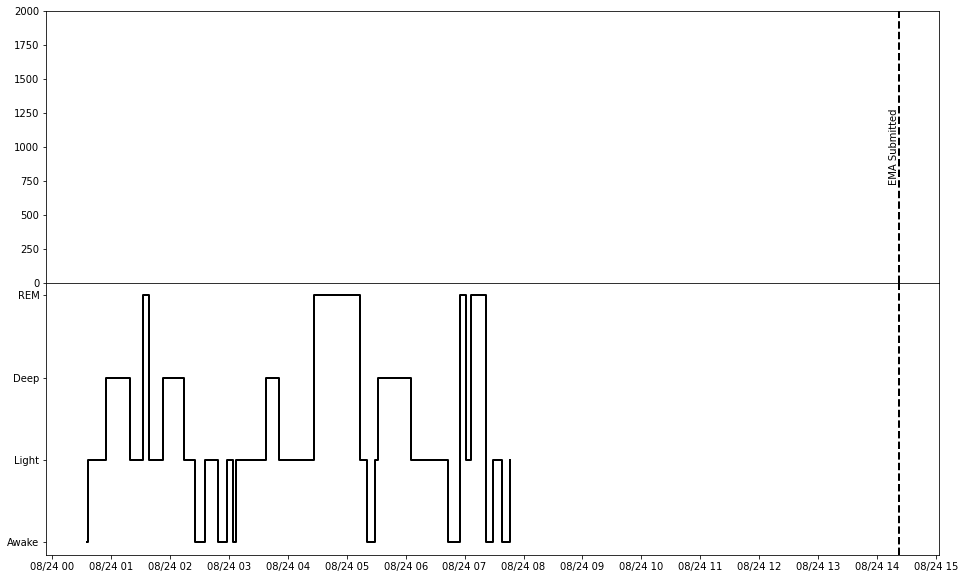

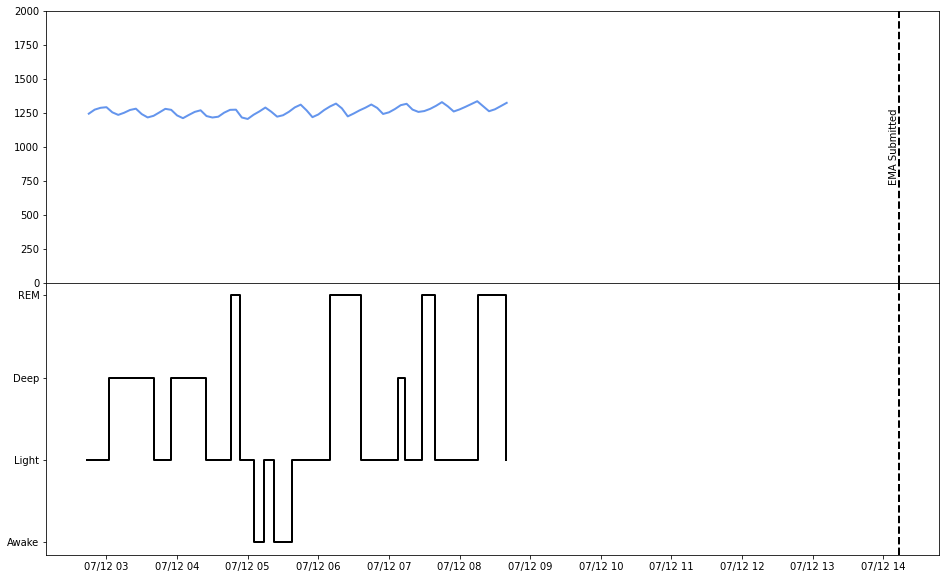

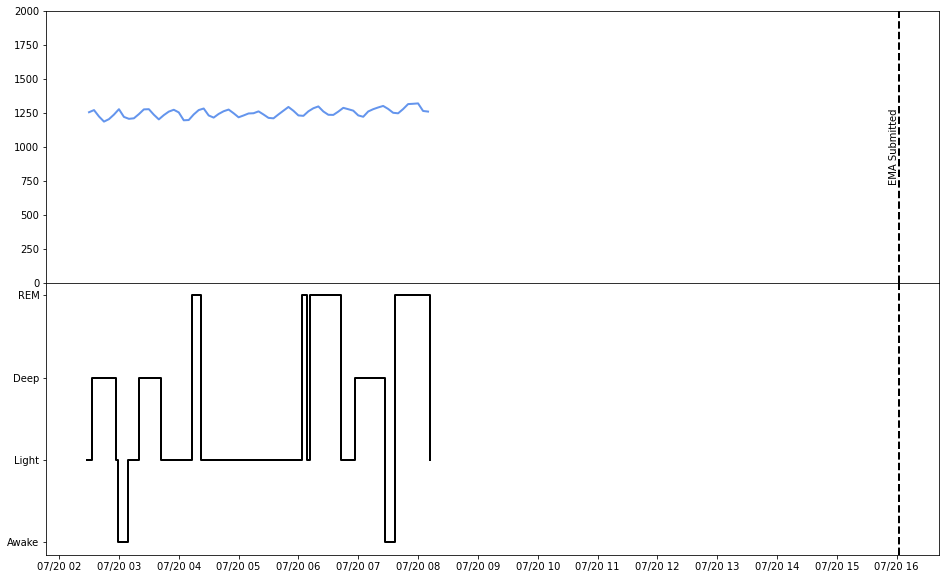

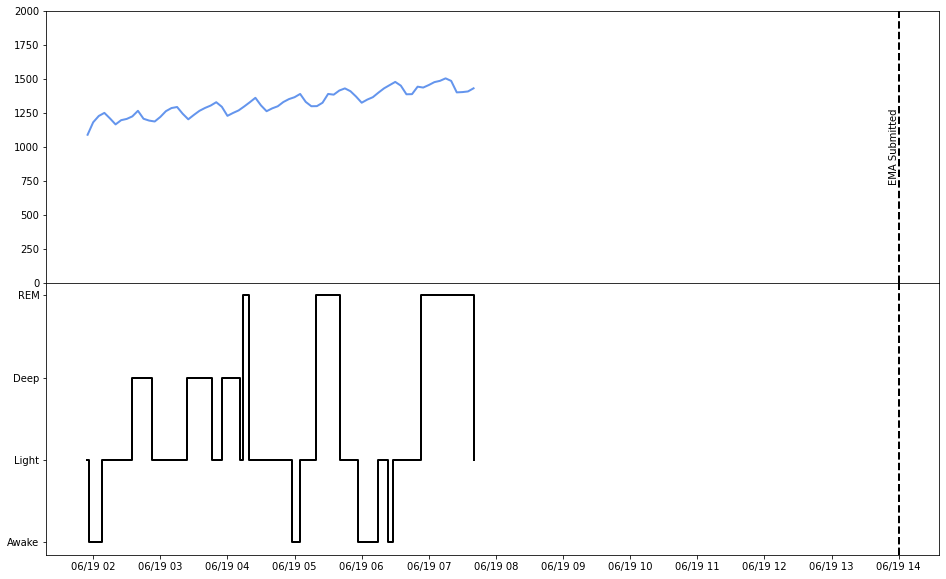

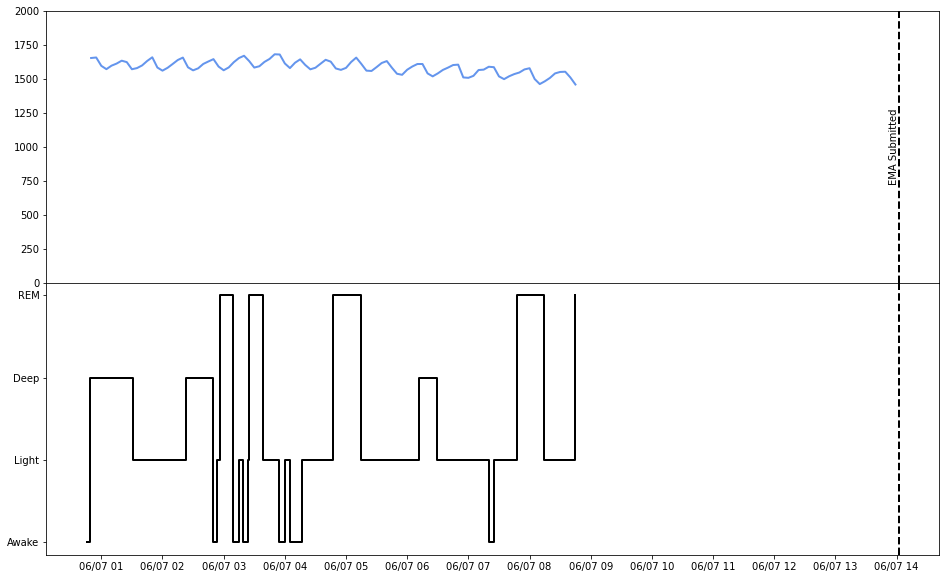

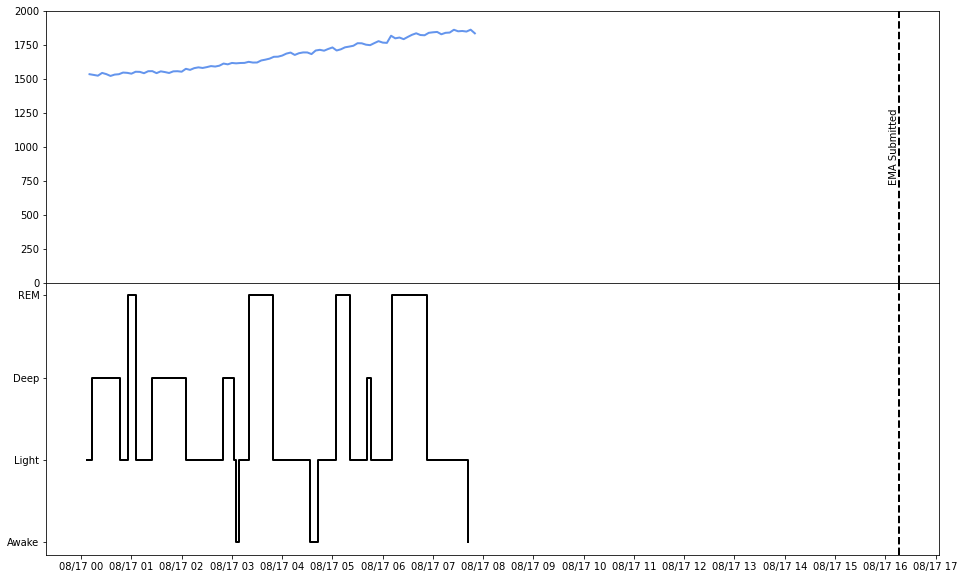

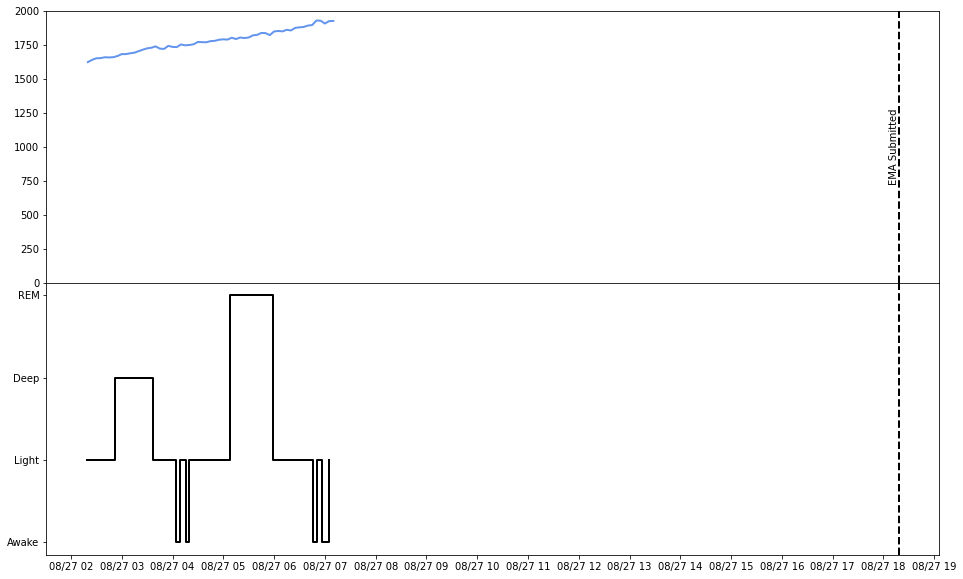

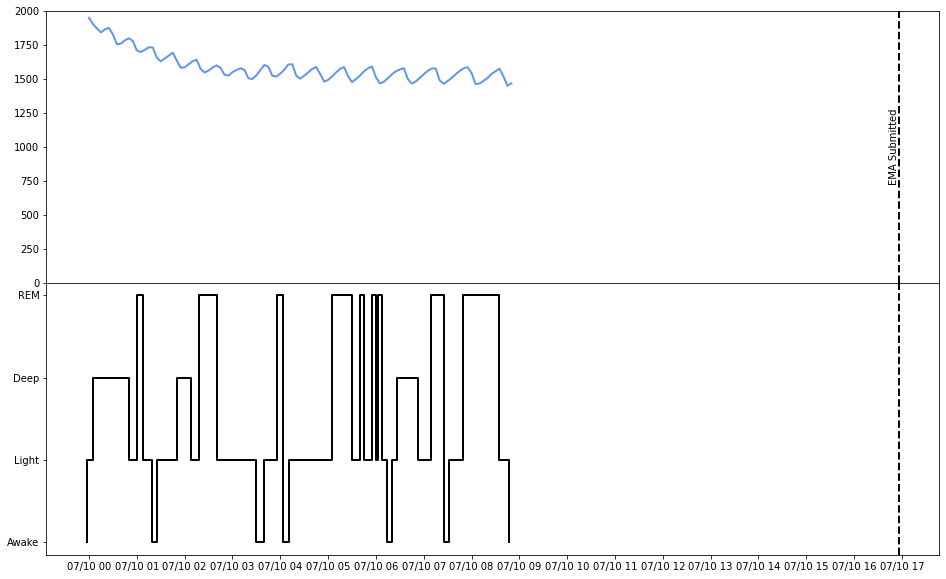

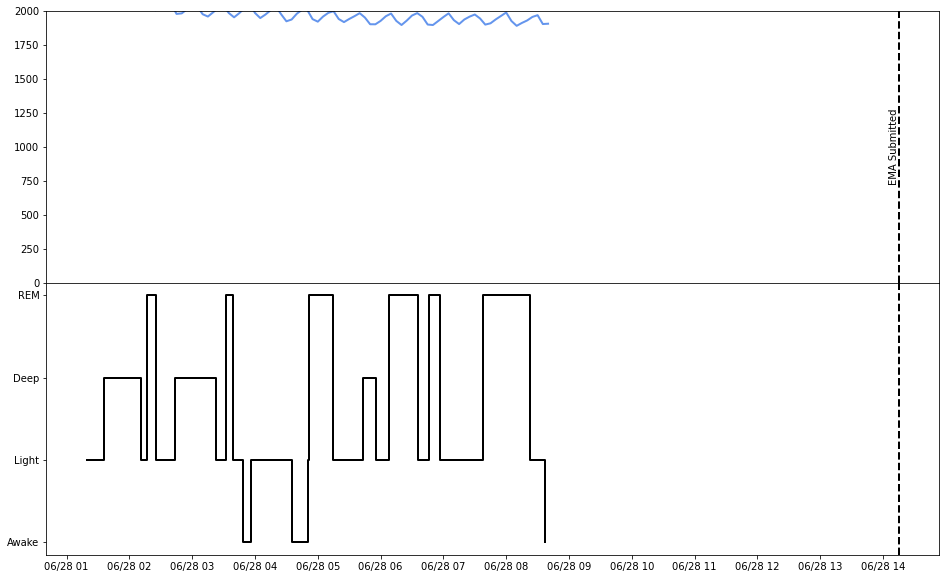

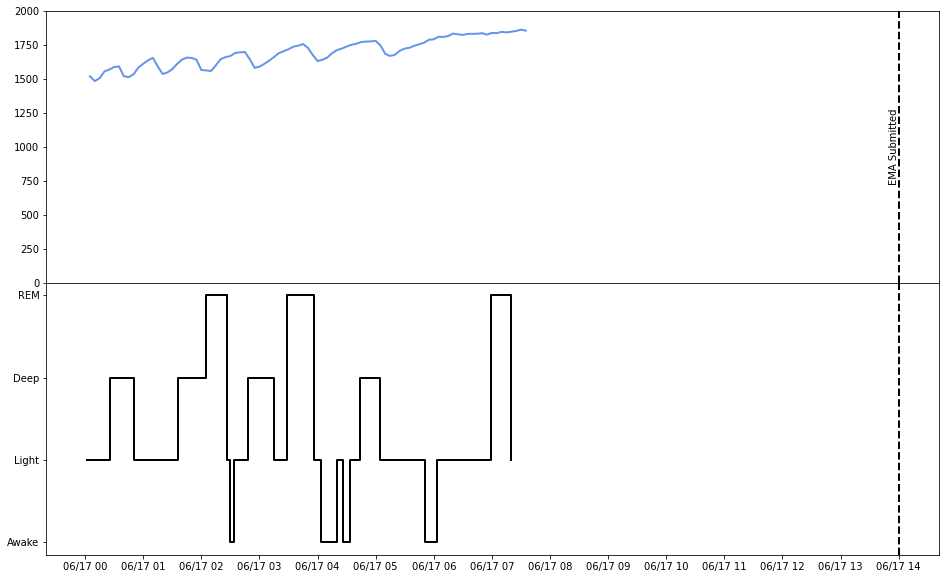

In [100]:
for pt in iaq_evening_restricted['beiwe'].unique():
    # restricting to patient
    iaq_pt = iaq_evening_restricted[iaq_evening_restricted['beiwe'] == pt]
    ema_pt = ema[ema['ID'] == pt]
    fb_pt = fitbit[fitbit['beiwe'] == pt]
    print(pt)
    for i in range(len(ema_pt)):
        iaq_pt_night = iaq_pt[iaq_pt['end_time'].dt.date == ema_pt.index[i]]
        fb_pt_night = fb_pt[fb_pt['end_date'].dt.date == ema_pt.index[i]]
        if len(iaq_pt_night['CO2']) > 0 and len(fb_pt_night) > 0:
            fig, axes = plt.subplots(2,1,figsize=(16,10),sharex=True)
            # beacon plot
            ax = axes[0]
            ax.plot(iaq_pt_night.index,iaq_pt_night['CO2'],color='cornflowerblue',linewidth=2)
            ax.axvline(ema_pt.index[i],color='black',linewidth=2,linestyle='dashed')
            ax.text(ema_pt.index[i],1000,'EMA Submitted',rotation=90,ha='right',va='center')
            
            ax.set_ylim([0,2000])
            
            # fitbit plot
            ax = axes[1]
            ## Getting fitbit times
            fb_times = [None]*(len(fb_pt_night.index)+len(fb_pt_night.index)-1)
            fb_times[::2] = fb_pt_night.index
            fb_times[1::2] = fb_pt_night.index[1:]
            ## Getting fitbit values
            fb_vals = [None]*(len(fb_pt_night['value'])+len(fb_pt_night['value'])-1)
            fb_vals[::2] = fb_pt_night['value']
            fb_vals[1::2] = fb_pt_night['value'][:-1]
            ## Plotting
            ax.plot(fb_times,fb_vals,color='black',linewidth=2)
            ax.axvline(ema_pt.index[i],color='black',linewidth=2,linestyle='dashed')
            
            ax.set_yticks([0,1,2,3])
            ax.set_yticklabels(['Awake','Light','Deep','REM'])
            
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H'))
            ax.xaxis.set_major_locator(mdates.HourLocator())

            plt.subplots_adjust(hspace=0)
            plt.show()
            plt.close()